In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

import optuna
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
import shap

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, AUC, PR_curve, multiple_curve, \
    best_threshold, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

In [3]:
##### GPU? #####
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device.'.format(device))

Using cpu device.


### Dataloader

In [4]:
# dataloder in pytorch
class RunhistSet(Dataset):
    
    def __init__(self, train_x, train_y):
        self.x = torch.tensor(train_x.values.astype(np.float32))
        self.y = torch.tensor(train_y.values.astype(np.float32)).long()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

### Neural Network

In [5]:
# architecture of classifier 
class NeuralNetworkC(nn.Module):
    
    def __init__(self, dim):
        super(NeuralNetworkC, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits
    

# architecture of regressor (optional)
class NeuralNetworkR(nn.Module):
    
    def __init__(self):
        super(NeuralNetworkR, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(114, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

### Label Smoothing (optional)

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim                                                                                                                                                                                                                                                                                                                                                                                                                                              

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

### Training & Testing for Classifier

In [33]:
# training main function
def trainingC(network, trainloader, validloader, optimizer, criterion, epoch, early_stop, 
              filename = None, save_ckpt = False):
    
    network.train()
    best_model = network
    best_objective = 0
    stop_trigger = 0
    train_loss = []
    valid_loss = []
    
    for i in tqdm(range(epoch)):
        
        total_loss = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0  
        for x, y in trainloader:
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = network(x)
            loss = criterion(output, y)         
            
            _, predicted = torch.max(output.data, 1)
            TP += torch.dot((predicted == y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
            TN += torch.dot((predicted == y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
            FN += torch.dot((predicted != y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
            FP += torch.dot((predicted != y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
            total_loss += loss.item()*len(y)
            loss.backward()
            optimizer.step()
        
        train_loss.append(total_loss)
        print(f'Epoch {i+1}: Train Loss = {total_loss / (TP + TN + FP + FN)}')

        if ((i+1) % 5 == 0):
            recall = TP / (TP + FN) if (TP + FN) != 0 else 0
            precision = TP / (TP + FP) if FP != 0 else 0
            aging = (TP + FP) / (TP + TN + FP + FN)   
            print(f'Recall = {recall}, Aging Rate = {aging}, Precision = {precision}')
              
            five_loss, valid_objective, _ = testingC(network, validloader, criterion)
            valid_loss.append(five_loss)
            
            if valid_objective > best_objective:
                best_objective = valid_objective
                best_model = network
                if save_ckpt:
                    torch.save(best_model, f'{filename}_NeuralNetworkC_{epoch}.ckpt')
                print(f'Model in epoch {i+1} is saved.\n')
                stop_trigger = 0
            else:
                print('')   
                stop_trigger += 1            
                if stop_trigger == early_stop:
                    print(f'Training Finished at epoch {i+1}.')
                    break
            
    return best_model, train_loss, valid_loss


# testing main function
def testingC(network, dataloader, criterion):
    
    network.eval()
    total_loss = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)
        output = network(x)
        loss = criterion(output, y)
        
        _, predicted = torch.max(output.data, 1)
        TP += torch.dot((predicted == y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
        TN += torch.dot((predicted == y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
        FN += torch.dot((predicted != y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
        FP += torch.dot((predicted != y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
        total_loss += loss.item()*len(y)
        
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    aging = (TP + FP) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    print(f'Validation: Test Loss = {total_loss / (TP + TN + FP + FN)}')
    print(f'Recall = {recall}, Aging Rate = {aging}, precision = {precision}')
    beta = 1
    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) if precision != 0 else 0
    efficiency = recall / aging if aging != 0 else 0
    score = score1(recall, aging) if aging != 0 else 0
    
    valid_objective = fscore
    table = pd.Series({'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'Precision': precision, 'Recall': recall, 
                       'Aging Rate': aging, 'Efficiency': efficiency, 'fscore': fscore, 'Score': score})
    table = pd.DataFrame(table).T
    
    return total_loss, valid_objective, table

### Training & Testing for Regressor (optional)

In [ ]:
def PR_matrix(predict):
    
    Y_new = predict.sort_values(['predict', 'truth'], ascending = [False, True]).reset_index(drop = True)
    Y_new.loc[Y_new['truth'] != 1, 'truth'] = 0
    
    matrix = pd.DataFrame(Y_new.groupby('predict').sum()).rename(columns = {'truth': 'Bad_Count'})
    matrix = matrix.sort_index(ascending = False)
    matrix['All_Count'] = Y_new.groupby('predict').count()
    matrix['Class_Prob'] = matrix.index
    
    matrix['TP'] = matrix['Bad_Count'].cumsum()
    matrix['FP'] = matrix['All_Count'].cumsum() - matrix['TP']
    matrix['FN'] = matrix['TP'].values[-1] - matrix['TP']
    matrix['TN'] = matrix['FP'].values[-1] - matrix['FP']
    
    matrix['Precision'] = matrix['TP'] / (matrix['TP'] + matrix['FP'])
    matrix['Recall'] = matrix['TP'] / (matrix['TP'] + matrix['FN'])
    matrix['Aging Rate'] = (matrix['TP'] + matrix['FP']) / (matrix['TP'] + matrix['FP'] + matrix['FN'] + matrix['TN'])
    matrix['Efficiency'] = matrix['Recall'] / matrix['Aging Rate']
    matrix['Score'] = score1(matrix['Recall'], matrix['Aging Rate'])            
    matrix = matrix.drop(columns = ['Bad_Count', 'All_Count']).reset_index(drop = True)
    
    return matrix


def trainingR(network, trainloader, validloader, optimizer, criterion, epoch, filename, early_stop):
    
    network.train()
    best_model = network
    best_objective = 1
    stop_trigger = 0
    train_loss = []
    valid_loss = []
    
    for i in tqdm(range(epoch)):
        
        total_loss = 0
        predict_vector = torch.tensor([0])
        y_vector = torch.tensor([0])
        for x, y in trainloader:
            
            x = x.to(device)
            y = y.type(torch.FloatTensor).to(device)
            y = y.unsqueeze(1)
            optimizer.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            total_loss += loss.item()*len(y)
            loss.backward()
            optimizer.step()    
            predict_vector = torch.cat((predict_vector, output.data[:,0]), axis = 0)
            y_vector = torch.cat((y_vector, y[:,0]), axis = 0)       
        result_df = pd.DataFrame(dict(predict = predict_vector, truth = y_vector))
        pr_matrix = PR_matrix(result_df.iloc[1:, :])
        best_data, best_thres = best_threshold(pr_matrix, target = 'Recall', threshold = 0.7)
        auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
        train_loss.append(total_loss)
        
        recall = best_data["Recall"].values
        aging = best_data["Aging Rate"].values
        print(f'Epoch {i+1}: Train Loss = {total_loss}, AUC = {auc}, Recall(0.7) = {recall}, Aging Rate = {aging}')
        
        if ((i+1) % 5 == 0):
            five_loss, valid_auc, _ = testingR(network, validloader, criterion)
            valid_loss.append(five_loss)
            
            if valid_auc < best_objective:
                best_objective = valid_auc
                best_model = network
                torch.save(best_model, f'{filename}_NeuralNetworkR_{epoch}.ckpt')
                print(f'Model in epoch {i+1} is saved.\n')
                stop_trigger = 0
            else:
                stop_trigger += 1
                print('')
                
            if stop_trigger == early_stop:
                print(f'Training Finished at epoch {i+1}.')
                return network, train_loss, valid_loss
      
    return network, train_loss, valid_loss


def testingR(network, dataloader, criterion):
    
    network.eval()   
    total_loss = 0
    predict_vector = torch.tensor([0])
    y_vector = torch.tensor([0])
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)
        y = y.unsqueeze(1)
        output = network(x)
        loss = criterion(output, y)
        total_loss += loss.item()*len(y)
        
        predict_vector = torch.cat((predict_vector, output.data[:,0]), axis = 0)
        y_vector = torch.cat((y_vector, y[:,0]), axis = 0)
    result_df = pd.DataFrame(dict(predict = predict_vector, truth = y_vector))
    pr_matrix = PR_matrix(result_df.iloc[1:, :])
    best_data, best_thres = best_threshold(pr_matrix, target = 'Recall', threshold = 0.7)
    auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
    recall = best_data['Recall'].values[0]
    aging = best_data['Aging Rate'].values[0]
    precision = best_data['Precision'].values[0]
    efficiency = best_data['Efficiency'].values[0]
    score = best_data['Score'].values[0]
    TP = best_data['TP'].values[0]
    FP = best_data['FP'].values[0]
    TN = best_data['TN'].values[0]
    FN = best_data['FN'].values[0]
        
    print(f'\nTest Loss = {total_loss}, Recall = {recall}, Aging Rate = {aging}, Efficiency = {efficiency}')
    
    valid_objective = auc
    table = pd.Series({'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'Precision': precision, 'Recall': recall,
                       'Aging Rate': aging,'Efficiency': efficiency, 'Score': score})
    table = pd.DataFrame(table).T
    
    return total_loss, valid_objective, table

### Run All Datasets

In [34]:
# classifier for all resampling datasets
def runall_nn(train_x, train_y, test_x, test_y, n_epoch, config, early_stop, mode):
    
    set_name = list(train_x.keys())[1:]
    result_table = pd.DataFrame()
    train_dict = {}
    valid_dict = {}
    judge = list(config.keys())[0]
    for num, i in enumerate(tqdm(set_name)):
        print(f'\nStarting training Data{i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[i]
        else :
            best_config = config
        
        # data preparation
        train_ratio = 0.75
        train_data = RunhistSet(train_x[i], train_y[i])
        test_data = RunhistSet(test_x, test_y)
        train_size = int(len(train_data)*train_ratio)
        valid_size = len(train_data) - train_size
        train_data, valid_data = random_split(train_data, [train_size, valid_size])
        train_loader = DataLoader(train_data, batch_size = best_config['batch_size'], shuffle = True)
        valid_loader = DataLoader(valid_data, batch_size = best_config['batch_size'], shuffle = False)
        test_loader = DataLoader(test_data, batch_size = best_config['batch_size'], shuffle = False)
        
        modelC = NeuralNetworkC(dim = train_x[i].shape[1]).to(device)
        optimizerC = torch.optim.Adam(modelC.parameters(), lr = best_config['learning_rate'], 
                                      weight_decay = best_config['weight_decay'])
        criterionC = nn.CrossEntropyLoss(
            weight = torch.tensor([1-best_config['bad_weight'], best_config['bad_weight']])).to(device)
        
        # training
        if mode == 'C':
            done_model, train_loss, valid_loss = trainingC(network = modelC, 
                                                           trainloader = train_loader, 
                                                           validloader = valid_loader, 
                                                           optimizer = optimizerC, 
                                                           criterion = criterionC, 
                                                           epoch = n_epoch, 
                                                           early_stop = early_stop)
        elif mode == 'R':
            pass
        
        train_dict[i] = train_loss
        valid_dict[i] = valid_loss
        
        # testing
        if mode == 'C':
            _, _, table = testingC(done_model, test_loader, criterionC)
        elif mode == 'R':
            pass
        result_table = pd.concat([result_table, table], axis = 0).rename({0: f'data{i}'})
    loss_dict = dict(train = train_dict, valid = valid_dict)
        
    return result_table, loss_dict


# plot the loss in training stage for all resampling datasets
def loss_plot(train_loss, valid_loss, num_row, num_col):
    
    fig , axes = plt.subplots(num_row, num_col, sharex = False, sharey = False, figsize = (num_row*8 + 1, num_col*6))
    plt.suptitle('Training & Validation Loss Curve', y = 0.94, fontsize = 30)
    for row in range(num_row):
        for col in range(num_col):
            
            index = num_col*row + col + 1
            if index <= len(train_loss):
                
                train = train_loss[f'set{index}']
                valid = valid_loss[f'set{index}']
                axes[row, col].plot(range(len(train)), train, 'b-', linewidth = 5, label = 'train')
                axes[row, col].plot(range(4, len(train)+1, 5), valid, 'r-', linewidth = 5, label = 'valid')
                axes[row, col].set_xlabel('Epoch')
                axes[row, col].set_ylabel('Total Loss')
                axes[row, col].set_title(f'dataset {index}')
                axes[row, col].legend(loc = 'upper right', fancybox = True, prop = dict(size = 20))

### Optuna

In [35]:
# creator of optuna study for neural network
def NeuralNetwork_creator(train_data, mode, num_valid = 5, label = 'GB') :
    
    def objective(trial) :

        param = {
            'batch_size': trial.suggest_int('batch_size', 32, 128, step = 32),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4]),
            'weight_decay': trial.suggest_categorical('weight_decay', [1e-2, 1e-3, 1e-4]),
            'bad_weight': trial.suggest_categorical('bad_weight', [0.5, 0.6, 0.7, 0.8])
        }

        result_list = []
        for i in range(num_valid):
            
            train_x, train_y = label_divide(train_data, None, label, train_only = True)
            train_set = RunhistSet(train_x, train_y)
            train_ratio = 0.75
            train_size = int(len(train_data)*train_ratio)
            valid_size = len(train_data) - train_size
            training_data, validing_data = random_split(train_set, [train_size, valid_size])
            train_loader = DataLoader(training_data, batch_size = param['batch_size'], shuffle = True)
            valid_loader = DataLoader(validing_data, batch_size = param['batch_size'], shuffle = False)

            if mode == 'C':
                model = NeuralNetworkC(dim = train_x.shape[1]).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = param['learning_rate'], 
                                             weight_decay = param['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-param['bad_weight'], param['bad_weight']])).to(device)

                done_modelC, train_lossC, valid_lossC = trainingC(network = model, 
                                                                  trainloader = train_loader, 
                                                                  validloader = train_loader, 
                                                                  optimizer = optimizer, 
                                                                  criterion = criterion, 
                                                                  epoch = 150, 
                                                                  early_stop = 10)
                _, valid_objective, _ = testingC(done_modelC, valid_loader, criterion)
                result_list.append(valid_objective)

            elif mode == 'R':
                pass

        return np.mean(result_list)
    return objective

## 

### Load Data

In [25]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1350, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2208, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimension

### For One Dataset

In [ ]:
##### data preparation #####
target = 'set4'
print(best_paramC[target])

train_data = RunhistSet(run_train_x[target], run_train_y[target])
test_data = RunhistSet(run_test_x, run_test_y)
train_ratio = 0.75
train_size = int(len(train_data)*train_ratio)
valid_size = len(train_data) - train_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)

#### Classifier

In [ ]:
##### model preparation #####
# hyperparameter: learning rate, weight decay, weight
modelC = NeuralNetworkC(dim = len(train_data[0][0])).to(device)
optimizerC = torch.optim.Adam(modelC.parameters(), lr = 0.01, weight_decay = 0.0001)
criterionC = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 0.5])).to(device)

### label smoothing ###
#criterionC = LabelSmoothingLoss(classes = 2, smoothing = 0.2)

##### training #####
done_modelC, train_lossC, valid_lossC = trainingC(network = modelC, 
                                                  trainloader = train_loader, 
                                                  validloader = valid_loader, 
                                                  optimizer = optimizerC, 
                                                  criterion = criterionC, 
                                                  epoch = 200, 
                                                  filename = 'tamama',
                                                  early_stop = 20)

##### testing #####
_, _, result_tableC = testingC(done_modelC, test_loader, criterionC)

#### Feature Importance

In [ ]:
batch = next(iter(test_loader))
sample_x, _ = batch
background = sample_x[:32].to(device)
tobetest = sample_x[16:].to(device)

e = shap.DeepExplainer(modelC, background)
shap_values = e.shap_values(tobetest)
values = abs(shap_values[1]).mean(axis = 0)
shap.summary_plot(shap_values, run_train_x[target])

In [ ]:
fig = plt.figure(figsize = (24, 8))
colname = run_train[target].columns.to_list()[:-1]
plt.bar(colname, values, color = 'green')
plt.xticks(rotation = 90)
plt.title('20211228_NeuralNetwork_ShapValue')

#### Regressor (optional)

In [ ]:
##### model preparation #####
# hyperparameter: learning rate, weight decay, weight
modelR = NeuralNetworkR().to(device)
optimizerR = torch.optim.Adam(modelR.parameters(), lr = 0.001, weight_decay = 0.01)
criterionR = nn.MSELoss().to(device)

##### training #####
done_modelR, train_lossR, valid_lossR = trainingR(network = modelR, 
                                                  trainloader = train_loader, 
                                                  validloader = valid_loader, 
                                                  optimizer = optimizerR, 
                                                  criterion = criterionR, 
                                                  epoch = 150, 
                                                  filename = 'tamama',
                                                  early_stop = 10)

##### testing #####
_, _, result_tableR = testingR(done_modelR, test_loader, criterionR)

### Search for Best Hyperparameters

In [51]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 10, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_NeuralNetwork', 
                                     creator = NeuralNetwork_creator
                                    )

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-07 13:22:10,832] A new study created in memory with name: no-name-572c7891-71e7-4583-b9cc-3bd6e1705b08


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4184602241412453
Epoch 2: Train Loss = 0.24248509383719902
Epoch 3: Train Loss = 0.16122031491735708
Epoch 4: Train Loss = 0.1083792475125064
Epoch 5: Train Loss = 0.09130127476609272
Recall = 0.9886907351022184, Aging Rate = 0.542608695652174, Precision = 0.9106570512820513
Validation: Test Loss = 0.04814244560573412
Recall = 0.9978251413658112, Aging Rate = 0.5254347826086957, precision = 0.9491104675217211
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0364224931532922
Epoch 7: Train Loss = 0.02045290056940006
Epoch 8: Train Loss = 0.013247779759213976
Epoch 9: Train Loss = 0.00963119151637606
Epoch 10: Train Loss = 0.007456469590897146
Recall = 1.0, Aging Rate = 0.5010869565217392, Precision = 0.9973969631236442
Validation: Test Loss = 0.006348399020245542
Recall = 1.0, Aging Rate = 0.5004347826086957, precision = 0.9986967854039965
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.006236629421296327
Epoch 12: Train Loss = 0.00556377526210702
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.39183261596638225
Epoch 2: Train Loss = 0.20182014457557512
Epoch 3: Train Loss = 0.13171406129132146
Epoch 4: Train Loss = 0.09576096668191578
Epoch 5: Train Loss = 0.07771605737831282
Recall = 0.9859956236323851, Aging Rate = 0.5334782608695652, Precision = 0.9180929095354523
Validation: Test Loss = 0.04636353985770889
Recall = 0.9991247264770241, Aging Rate = 0.5267391304347826, precision = 0.9422203879488238
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0296056789872439
Epoch 7: Train Loss = 0.01501922913543556
Epoch 8: Train Loss = 0.010541240652294262
Epoch 9: Train Loss = 0.007765436807404394
Epoch 10: Train Loss = 0.00641652962759785
Recall = 1.0, Aging Rate = 0.4980434782608696, Precision = 0.9973810563072893
Validation: Test Loss = 0.005322743805692248
Recall = 1.0, Aging Rate = 0.4980434782608696, precision = 0.9973810563072893
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005334175540863172
Epoch 12: Train Loss = 0.004770940477433412
Ep

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4135010493319968
Epoch 2: Train Loss = 0.22702400230843087
Epoch 3: Train Loss = 0.15381289571523665
Epoch 4: Train Loss = 0.11102115156857864
Epoch 5: Train Loss = 0.08391706096737281
Recall = 0.9881941407958024, Aging Rate = 0.5360869565217391, Precision = 0.916463909164639
Validation: Test Loss = 0.043458600426497664
Recall = 0.9982509838216004, Aging Rate = 0.5176086956521739, precision = 0.9588408231835364
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.03294577562290689
Epoch 7: Train Loss = 0.018570297660063143
Epoch 8: Train Loss = 0.012336990732861602
Epoch 9: Train Loss = 0.009481064111966154
Epoch 10: Train Loss = 0.007045035360623961
Recall = 0.9995627459554001, Aging Rate = 0.49826086956521737, Precision = 0.9973821989528796
Validation: Test Loss = 0.006069720569674087
Recall = 1.0, Aging Rate = 0.4980434782608696, precision = 0.998254037538193
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005879412050885351
Epoch 12: Train Loss = 0.0049

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.493262037401614
Epoch 2: Train Loss = 0.26909156975538834
Epoch 3: Train Loss = 0.17947394819363305
Epoch 4: Train Loss = 0.13529540093048759
Epoch 5: Train Loss = 0.11085235367650571
Recall = 0.9814094249891915, Aging Rate = 0.53, Precision = 0.9310910582444627
Validation: Test Loss = 0.06967628523707389
Recall = 0.9991353220925205, Aging Rate = 0.5278260869565218, precision = 0.9518121911037891
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0543046081746402
Epoch 7: Train Loss = 0.035757935643196105
Epoch 8: Train Loss = 0.03052348127183707
Epoch 9: Train Loss = 0.027522145120993904
Epoch 10: Train Loss = 0.027323365124023478
Recall = 0.9982706441850411, Aging Rate = 0.5071739130434783, Precision = 0.9897128161165881
Validation: Test Loss = 0.028340038035226906
Recall = 0.9995676610462603, Aging Rate = 0.5032608695652174, precision = 0.9987041036717063
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.025485956147313117
Epoch 12: Train Loss = 0.026651

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4760870028578717
Epoch 2: Train Loss = 0.2531968541248985
Epoch 3: Train Loss = 0.16259988380515056
Epoch 4: Train Loss = 0.11751802273418592
Epoch 5: Train Loss = 0.1010636649183605
Recall = 0.9850615114235501, Aging Rate = 0.5178260869565218, Precision = 0.9412258606213266
Validation: Test Loss = 0.05466978723588197
Recall = 0.9982425307557118, Aging Rate = 0.5104347826086957, precision = 0.9676320272572402
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.048433107273734136
Epoch 7: Train Loss = 0.033502279267362926
Epoch 8: Train Loss = 0.029423842261666836
Epoch 9: Train Loss = 0.025782177036871082
Epoch 10: Train Loss = 0.02487382064047067
Recall = 0.9991212653778558, Aging Rate = 0.4973913043478261, Precision = 0.9938811188811189
Validation: Test Loss = 0.02019096814095974
Recall = 1.0, Aging Rate = 0.4965217391304348, precision = 0.9964973730297724
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02407419668915479
Epoch 12: Train Loss = 0.02633462

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4803663942606553
Epoch 2: Train Loss = 0.2592422811881356
Epoch 3: Train Loss = 0.17581400412580242
Epoch 4: Train Loss = 0.12240168320096058
Epoch 5: Train Loss = 0.10564700946859691
Recall = 0.9787141615986099, Aging Rate = 0.5241304347826087, Precision = 0.9344670261302365
Validation: Test Loss = 0.061821606230476625
Recall = 0.998262380538662, Aging Rate = 0.5180434782608696, precision = 0.9643306756189677
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04997269031146298
Epoch 7: Train Loss = 0.03643346888539584
Epoch 8: Train Loss = 0.03161685826985732
Epoch 9: Train Loss = 0.026359404150558555
Epoch 10: Train Loss = 0.026181571201785752
Recall = 0.9986967854039965, Aging Rate = 0.5023913043478261, Precision = 0.9948074426655128
Validation: Test Loss = 0.021603401484696763
Recall = 0.9978279756733276, Aging Rate = 0.5006521739130435, precision = 0.9973947025618758
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.025712166004206824
Epoch 12: Train L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6481729578971863
Epoch 2: Train Loss = 0.48835184828094813
Epoch 3: Train Loss = 0.38068402943403823
Epoch 4: Train Loss = 0.3147977685150893
Epoch 5: Train Loss = 0.26151912569999697
Recall = 0.9398692810457516, Aging Rate = 0.537608695652174, Precision = 0.87221997573797
Validation: Test Loss = 0.22240852563277536
Recall = 0.9660130718954248, Aging Rate = 0.5443478260869565, precision = 0.8853833865814696
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20512280337188554
Epoch 7: Train Loss = 0.1685910956237627
Epoch 8: Train Loss = 0.13961727229149445
Epoch 9: Train Loss = 0.11592970502117406
Epoch 10: Train Loss = 0.09783834519593612
Recall = 0.9869281045751634, Aging Rate = 0.5073913043478261, Precision = 0.9704370179948586
Validation: Test Loss = 0.08477295079956884
Recall = 0.9908496732026144, Aging Rate = 0.5054347826086957, precision = 0.9780645161290322
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08254700523355733
Epoch 12: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6259307338880457
Epoch 2: Train Loss = 0.46062838875729106
Epoch 3: Train Loss = 0.3563733609344648
Epoch 4: Train Loss = 0.2910990083217621
Epoch 5: Train Loss = 0.24045009027356687
Recall = 0.9517601043024772, Aging Rate = 0.5397826086956522, Precision = 0.8819975835682642
Validation: Test Loss = 0.20366038998831873
Recall = 0.9791395045632334, Aging Rate = 0.5521739130434783, precision = 0.887007874015748
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1853385610424954
Epoch 7: Train Loss = 0.15041550721811212
Epoch 8: Train Loss = 0.12334325313568115
Epoch 9: Train Loss = 0.10274865771117418
Epoch 10: Train Loss = 0.08625405132770539
Recall = 0.9934810951760105, Aging Rate = 0.5110869565217391, Precision = 0.9723521905572097
Validation: Test Loss = 0.07516526767093203
Recall = 0.9960886571056062, Aging Rate = 0.5102173913043478, precision = 0.9765658287175117
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.07298580673077833
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6505339783170949
Epoch 2: Train Loss = 0.49170892264532007
Epoch 3: Train Loss = 0.3788047716928565
Epoch 4: Train Loss = 0.304019091129303
Epoch 5: Train Loss = 0.25312638878822324
Recall = 0.9419104991394148, Aging Rate = 0.5408695652173913, Precision = 0.8798231511254019
Validation: Test Loss = 0.21184775676416315
Recall = 0.9750430292598967, Aging Rate = 0.5543478260869565, precision = 0.8886274509803922
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19190564663513848
Epoch 7: Train Loss = 0.15319325123144234
Epoch 8: Train Loss = 0.12542999476194383
Epoch 9: Train Loss = 0.10257847244324891
Epoch 10: Train Loss = 0.08563339611110479
Recall = 0.9926850258175559, Aging Rate = 0.5126086956521739, Precision = 0.9783715012722646
Validation: Test Loss = 0.07584652642840925
Recall = 0.9918244406196214, Aging Rate = 0.508695652173913, precision = 0.9850427350427351
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.07308505510506423
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6371887896371924
Epoch 2: Train Loss = 0.5501258171123007
Epoch 3: Train Loss = 0.4548091974984045
Epoch 4: Train Loss = 0.38813581969427025
Epoch 5: Train Loss = 0.3456240609936092
Recall = 0.941278816876903, Aging Rate = 0.6141304347826086, Precision = 0.7660176991150442
Validation: Test Loss = 0.3162329633598742
Recall = 0.9525880817746847, Aging Rate = 0.6093478260869565, precision = 0.7813057438458794
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3028044857149539
Epoch 7: Train Loss = 0.27012832931850267
Epoch 8: Train Loss = 0.24191157791925513
Epoch 9: Train Loss = 0.2167535382250081
Epoch 10: Train Loss = 0.19206650632879008
Recall = 0.9756415832970857, Aging Rate = 0.5558695652173913, Precision = 0.8771998435666797
Validation: Test Loss = 0.17905265307944754
Recall = 0.9752066115702479, Aging Rate = 0.5406521739130434, precision = 0.9014877362283876
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17122658167196356
Epoch 12: Train Loss = 0.15

Epoch 95: Train Loss = 0.017122869867345562
Recall = 1.0, Aging Rate = 0.5004347826086957, Precision = 0.9986967854039965
Validation: Test Loss = 0.016413246396443117
Recall = 1.0, Aging Rate = 0.49978260869565216, precision = 1.0
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.016811154850799103
Epoch 97: Train Loss = 0.016812726158810697
Epoch 98: Train Loss = 0.01681600395752036
Epoch 99: Train Loss = 0.01678989177812701
Epoch 100: Train Loss = 0.016716216789639516
Recall = 1.0, Aging Rate = 0.5004347826086957, Precision = 0.9986967854039965
Validation: Test Loss = 0.01655142266789208
Recall = 1.0, Aging Rate = 0.49978260869565216, precision = 1.0

Epoch 101: Train Loss = 0.01690734445076922
Epoch 102: Train Loss = 0.016682095106529155
Epoch 103: Train Loss = 0.016910705582603165
Epoch 104: Train Loss = 0.01665281683854435
Epoch 105: Train Loss = 0.01665401260490003
Recall = 0.9995650282731623, Aging Rate = 0.49978260869565216, Precision = 0.9995650282731623
Validation: Test L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6315091444098431
Epoch 2: Train Loss = 0.5516855782529582
Epoch 3: Train Loss = 0.4642791841341102
Epoch 4: Train Loss = 0.39405923579050145
Epoch 5: Train Loss = 0.34418971865073494
Recall = 0.9492036160137753, Aging Rate = 0.6247826086956522, Precision = 0.767223382045929
Validation: Test Loss = 0.3101318099706069
Recall = 0.9591046061127851, Aging Rate = 0.6130434782608696, precision = 0.7900709219858156
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29383747738340626
Epoch 7: Train Loss = 0.2582387302751126
Epoch 8: Train Loss = 0.22605268968188244
Epoch 9: Train Loss = 0.19693462221518807
Epoch 10: Train Loss = 0.1722318009449088
Recall = 0.978906586310805, Aging Rate = 0.5517391304347826, Precision = 0.8959810874704491
Validation: Test Loss = 0.16015658370826555
Recall = 0.9896685320705984, Aging Rate = 0.5667391304347826, precision = 0.8818565400843882
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.15055811558080756
Epoch 12: Train Loss = 0.13

Epoch 96: Train Loss = 0.01704989837563556
Epoch 97: Train Loss = 0.017033619138857592
Epoch 98: Train Loss = 0.017052749103826027
Epoch 99: Train Loss = 0.017035829596545385
Epoch 100: Train Loss = 0.017249787488709326
Recall = 1.0, Aging Rate = 0.5056521739130435, Precision = 0.9987102321582115
Validation: Test Loss = 0.01636586433519488
Recall = 1.0, Aging Rate = 0.5056521739130435, precision = 0.9987102321582115

Epoch 101: Train Loss = 0.017275247243435488
Epoch 102: Train Loss = 0.016991965848466625
Epoch 103: Train Loss = 0.017234654740794844
Epoch 104: Train Loss = 0.01685246946695058
Epoch 105: Train Loss = 0.0169661911447411
Recall = 1.0, Aging Rate = 0.5060869565217392, Precision = 0.997852233676976
Validation: Test Loss = 0.015998596510161524
Recall = 1.0, Aging Rate = 0.5054347826086957, precision = 0.9991397849462366

Training Finished at epoch 105.
Validation: Test Loss = 0.03251746078319313
Recall = 0.9959677419354839, Aging Rate = 0.4934810951760104, precision = 0.9788

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6310358529505522
Epoch 2: Train Loss = 0.541521383886752
Epoch 3: Train Loss = 0.44777693292369014
Epoch 4: Train Loss = 0.38498507256093234
Epoch 5: Train Loss = 0.3407708500260892
Recall = 0.9452714535901926, Aging Rate = 0.6076086956521739, Precision = 0.7724508050089446
Validation: Test Loss = 0.3087504177508147
Recall = 0.9540280210157618, Aging Rate = 0.5895652173913043, precision = 0.8034660766961652
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29360276730164236
Epoch 7: Train Loss = 0.2580951792260875
Epoch 8: Train Loss = 0.2273005579347196
Epoch 9: Train Loss = 0.20095752552799556
Epoch 10: Train Loss = 0.1773306411763896
Recall = 0.9859894921190894, Aging Rate = 0.5482608695652174, Precision = 0.8929421094369548
Validation: Test Loss = 0.16362873981828274
Recall = 0.9890542907180385, Aging Rate = 0.5519565217391305, precision = 0.8897203623473808
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1574056570167127
Epoch 12: Train Loss = 0.140

Epoch 97: Train Loss = 0.017038345913524214
Epoch 98: Train Loss = 0.016664633757394295
Epoch 99: Train Loss = 0.016677796672219816
Epoch 100: Train Loss = 0.016978507437135863
Recall = 1.0, Aging Rate = 0.49717391304347824, Precision = 0.9986882378662003
Validation: Test Loss = 0.015738596822256628
Recall = 1.0, Aging Rate = 0.4969565217391304, precision = 0.9991251093613298

Epoch 101: Train Loss = 0.016770840364953746
Epoch 102: Train Loss = 0.016630089205244312
Epoch 103: Train Loss = 0.016480882002607635
Epoch 104: Train Loss = 0.016772851738268913
Epoch 105: Train Loss = 0.0164900716588549
Recall = 1.0, Aging Rate = 0.4969565217391304, Precision = 0.9991251093613298
Validation: Test Loss = 0.015748284300384312
Recall = 1.0, Aging Rate = 0.4969565217391304, precision = 0.9991251093613298

Epoch 106: Train Loss = 0.016581145584907222
Epoch 107: Train Loss = 0.01651966108576111
Epoch 108: Train Loss = 0.01660966122927873
Epoch 109: Train Loss = 0.016670648073372634
Epoch 110: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4760971827092378
Epoch 2: Train Loss = 0.25094106249187303
Epoch 3: Train Loss = 0.1390530178728311
Epoch 4: Train Loss = 0.09509799073571744
Epoch 5: Train Loss = 0.06745746245850688
Recall = 0.9786492374727669, Aging Rate = 0.49826086956521737, Precision = 0.9799301919720768
Validation: Test Loss = 0.029014825688108155
Recall = 0.9978213507625272, Aging Rate = 0.5017391304347826, precision = 0.9922010398613518
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.026626611481542172
Epoch 7: Train Loss = 0.015910756380661674
Epoch 8: Train Loss = 0.010897547092450702
Epoch 9: Train Loss = 0.00806569448793712
Epoch 10: Train Loss = 0.006256406841718632
Recall = 0.9995642701525055, Aging Rate = 0.49869565217391304, Precision = 0
Validation: Test Loss = 0.004990646094893632
Recall = 1.0, Aging Rate = 0.4989130434782609, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005351358310359975
Epoch 12: Train Loss = 0.004824121356334375
Epoch 13: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4634834886633831
Epoch 2: Train Loss = 0.243995758217314
Epoch 3: Train Loss = 0.1320563552690589
Epoch 4: Train Loss = 0.09663768318036328
Epoch 5: Train Loss = 0.07392598929612533
Recall = 0.9760139555167903, Aging Rate = 0.49956521739130433, Precision = 0.9738903394255874
Validation: Test Loss = 0.03693514749407768
Recall = 0.9965111208024422, Aging Rate = 0.5032608695652174, precision = 0.9870410367170627
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.02749568230432013
Epoch 7: Train Loss = 0.014136469931058262
Epoch 8: Train Loss = 0.008776806686883387
Epoch 9: Train Loss = 0.006957710425005011
Epoch 10: Train Loss = 0.006092775966162267
Recall = 0.9995638901003053, Aging Rate = 0.49869565217391304, Precision = 0.999128160418483
Validation: Test Loss = 0.0042903829086571935
Recall = 1.0, Aging Rate = 0.4984782608695652, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.004301476811828173
Epoch 12: Train Loss = 0.0038758817217920136


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4877067334237306
Epoch 2: Train Loss = 0.26154456750206323
Epoch 3: Train Loss = 0.16509938110475955
Epoch 4: Train Loss = 0.10338152503189833
Epoch 5: Train Loss = 0.07250259308711342
Recall = 0.9790301441677588, Aging Rate = 0.4980434782608696, Precision = 0.9781754692274116
Validation: Test Loss = 0.03794405240403569
Recall = 0.9921363040629095, Aging Rate = 0.49717391304347824, precision = 0.9930039352864014
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.03292824648320675
Epoch 7: Train Loss = 0.020596582815051077
Epoch 8: Train Loss = 0.014687599011737367
Epoch 9: Train Loss = 0.01312868989356186
Epoch 10: Train Loss = 0.007901624535898799
Recall = 0.999563128003495, Aging Rate = 0.4973913043478261, Precision = 0
Validation: Test Loss = 0.005609214364996423
Recall = 1.0, Aging Rate = 0.4976086956521739, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005630725361406803
Epoch 12: Train Loss = 0.004833187092419552
Epoch 13: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4497812879085541
Epoch 2: Train Loss = 0.3233487469735353
Epoch 3: Train Loss = 0.2862935110019601
Epoch 4: Train Loss = 0.26973541373791904
Epoch 5: Train Loss = 0.26678976551346156
Recall = 0.9239842726081258, Aging Rate = 0.53, Precision = 0.8675143560295324
Validation: Test Loss = 0.22208159410435221
Recall = 0.9017038007863696, Aging Rate = 0.4671739130434783, precision = 0.9604467194043741
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2028260190590568
Epoch 7: Train Loss = 0.191443344147309
Epoch 8: Train Loss = 0.17801856605902963
Epoch 9: Train Loss = 0.18177469515282174
Epoch 10: Train Loss = 0.1800761090413384
Recall = 0.963302752293578, Aging Rate = 0.5165217391304348, Precision = 0.928030303030303
Validation: Test Loss = 0.1970486949319425
Recall = 0.9130624726955002, Aging Rate = 0.4676086956521739, precision = 0.9716410971641097
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.18581462906754534
Epoch 12: Train Loss = 0.18636648074440335


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4457357210180034
Epoch 2: Train Loss = 0.3249962266113447
Epoch 3: Train Loss = 0.2920120006022246
Epoch 4: Train Loss = 0.27701493372087893
Epoch 5: Train Loss = 0.2606680948837944
Recall = 0.9144736842105263, Aging Rate = 0.5204347826086957, Precision = 0.8709273182957393
Validation: Test Loss = 0.22492368037286012
Recall = 0.9219298245614035, Aging Rate = 0.47978260869565215, precision = 0.9524241051200725
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20214190133239912
Epoch 7: Train Loss = 0.2006022707534873
Epoch 8: Train Loss = 0.18706282086994336
Epoch 9: Train Loss = 0.18017434441525004
Epoch 10: Train Loss = 0.18698150738425875
Recall = 0.9574561403508772, Aging Rate = 0.5089130434782608, Precision = 0.9325074754378471
Validation: Test Loss = 0.18965116283167963
Recall = 0.9899122807017544, Aging Rate = 0.5584782608695652, precision = 0.8785519657454263

Epoch 11: Train Loss = 0.1898566394785176
Epoch 12: Train Loss = 0.18131416613640994
Epoch 13:

Epoch 94: Train Loss = 0.16654384035131206
Epoch 95: Train Loss = 0.16951695942360423
Recall = 0.9640350877192982, Aging Rate = 0.5089130434782608, Precision = 0.9389149935924819
Validation: Test Loss = 0.1593783274422521
Recall = 0.9899122807017544, Aging Rate = 0.5397826086956522, precision = 0.9089810712847362

Epoch 96: Train Loss = 0.16570802800033405
Epoch 97: Train Loss = 0.16590052661688431
Epoch 98: Train Loss = 0.1648023547426514
Epoch 99: Train Loss = 0.16858502657517144
Epoch 100: Train Loss = 0.17056670562080714
Recall = 0.968421052631579, Aging Rate = 0.5117391304347826, Precision = 0.9379779099405268
Validation: Test Loss = 0.17016473321811013
Recall = 0.9881578947368421, Aging Rate = 0.5393478260869565, precision = 0.9081015719467956

Epoch 101: Train Loss = 0.1655064940970877
Epoch 102: Train Loss = 0.16182648692442023
Epoch 103: Train Loss = 0.1687617908353391
Epoch 104: Train Loss = 0.1641001605210097
Epoch 105: Train Loss = 0.1722250137510507
Recall = 0.963596491228

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4324006871555163
Epoch 2: Train Loss = 0.3135650480830151
Epoch 3: Train Loss = 0.28463189430858776
Epoch 4: Train Loss = 0.2739181679487228
Epoch 5: Train Loss = 0.26101639516975567
Recall = 0.9238468233246301, Aging Rate = 0.5269565217391304, Precision = 0.8758250825082509
Validation: Test Loss = 0.21137530171352883
Recall = 0.9499564838990426, Aging Rate = 0.5204347826086957, precision = 0.9118629908103593
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.199020148800767
Epoch 7: Train Loss = 0.19128425916899805
Epoch 8: Train Loss = 0.19311850366385086
Epoch 9: Train Loss = 0.19122318596943566
Epoch 10: Train Loss = 0.18021471878756648
Recall = 0.9621409921671018, Aging Rate = 0.5180434782608696, Precision = 0.9278220730172052
Validation: Test Loss = 0.16872830196567204
Recall = 0.9747606614447345, Aging Rate = 0.5152173913043478, precision = 0.9451476793248945
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.18969740121260933
Epoch 12: Train Loss = 0

Epoch 93: Train Loss = 0.1708346997914107
Epoch 94: Train Loss = 0.17150060288284136
Epoch 95: Train Loss = 0.16936111216959746
Recall = 0.9695387293298521, Aging Rate = 0.5160869565217391, Precision = 0.9385004212299916
Validation: Test Loss = 0.1552974717254224
Recall = 0.9808529155787642, Aging Rate = 0.5173913043478261, precision = 0.9470588235294117

Epoch 96: Train Loss = 0.1643637391795283
Epoch 97: Train Loss = 0.16882081026616305
Epoch 98: Train Loss = 0.17234418432349743
Epoch 99: Train Loss = 0.16866078643695168
Epoch 100: Train Loss = 0.1787652767482011
Recall = 0.9577893820713664, Aging Rate = 0.5130434782608696, Precision = 0.9326271186440678
Validation: Test Loss = 0.15824420354936433
Recall = 0.9908616187989556, Aging Rate = 0.5413043478260869, precision = 0.9144578313253012

Epoch 101: Train Loss = 0.16888821724964226
Epoch 102: Train Loss = 0.1748782895958942
Epoch 103: Train Loss = 0.1691101680631223
Epoch 104: Train Loss = 0.17273991627537685
Epoch 105: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5651079467068548
Epoch 2: Train Loss = 0.389310804605484
Epoch 3: Train Loss = 0.3033472079816072
Epoch 4: Train Loss = 0.2396628168095713
Epoch 5: Train Loss = 0.196179328897725
Recall = 0.9729265148259562, Aging Rate = 0.5656521739130435, Precision = 0.8700999231360492
Validation: Test Loss = 0.15457041110681452
Recall = 0.9888268156424581, Aging Rate = 0.5543478260869565, precision = 0.9023529411764706
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1420877330199532
Epoch 7: Train Loss = 0.11465703626041827
Epoch 8: Train Loss = 0.09316588714070942
Epoch 9: Train Loss = 0.08038928615010303
Epoch 10: Train Loss = 0.06690444684546927
Recall = 0.9939836699613236, Aging Rate = 0.5189130434782608, Precision = 0.9689987431922916
Validation: Test Loss = 0.0586672217949577
Recall = 0.9965620971207564, Aging Rate = 0.5178260869565218, precision = 0.9735516372795969
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05780226812414501
Epoch 12: Train Loss = 0.052

Epoch 96: Train Loss = 0.016682354814332466
Epoch 97: Train Loss = 0.01658624815552131
Epoch 98: Train Loss = 0.01738441425983025
Epoch 99: Train Loss = 0.01664586844975534
Epoch 100: Train Loss = 0.016671518155414126
Recall = 1.0, Aging Rate = 0.5069565217391304, Precision = 0.9978559176672385
Validation: Test Loss = 0.015092026733833811
Recall = 1.0, Aging Rate = 0.5063043478260869, precision = 0.9991412623443539

Epoch 101: Train Loss = 0.01652906070260898
Epoch 102: Train Loss = 0.018529481531485266
Epoch 103: Train Loss = 0.016568592948758083
Epoch 104: Train Loss = 0.016370581187631773
Epoch 105: Train Loss = 0.0165773336848487
Recall = 1.0, Aging Rate = 0.5065217391304347, Precision = 0.9987124463519313
Validation: Test Loss = 0.014809055819135645
Recall = 1.0, Aging Rate = 0.5065217391304347, precision = 0.9987124463519313

Epoch 106: Train Loss = 0.016904423612615335
Epoch 107: Train Loss = 0.01767045999917647
Epoch 108: Train Loss = 0.016217996452165685
Epoch 109: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5565234789641007
Epoch 2: Train Loss = 0.37200453053350035
Epoch 3: Train Loss = 0.282584047783976
Epoch 4: Train Loss = 0.22397540538207344
Epoch 5: Train Loss = 0.17960626130518706
Recall = 0.976713532513181, Aging Rate = 0.5489130434782609, Precision = 0.8803960396039604
Validation: Test Loss = 0.14128347420174142
Recall = 0.9824253075571178, Aging Rate = 0.52, precision = 0.9347826086956522
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12849356742008872
Epoch 7: Train Loss = 0.10243886888027191
Epoch 8: Train Loss = 0.08347673650669014
Epoch 9: Train Loss = 0.07062775220559991
Epoch 10: Train Loss = 0.06021724339412606
Recall = 0.9960456942003515, Aging Rate = 0.5047826086956522, Precision = 0.9763135228251507
Validation: Test Loss = 0.05466709632588469
Recall = 0.9947275922671354, Aging Rate = 0.49782608695652175, precision = 0.988646288209607
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05288194029227547
Epoch 12: Train Loss = 0.045759275724

Epoch 96: Train Loss = 0.01628175349339195
Epoch 97: Train Loss = 0.016366497475815856
Epoch 98: Train Loss = 0.016370393901091556
Epoch 99: Train Loss = 0.01600541429837113
Epoch 100: Train Loss = 0.016260241193129965
Recall = 1.0, Aging Rate = 0.49521739130434783, Precision = 0.9991220368744512
Validation: Test Loss = 0.015133356623675513
Recall = 1.0, Aging Rate = 0.49521739130434783, precision = 0.9991220368744512

Epoch 101: Train Loss = 0.016886096415312395
Epoch 102: Train Loss = 0.016441872157156468
Epoch 103: Train Loss = 0.016129559925554888
Epoch 104: Train Loss = 0.01622212147583132
Epoch 105: Train Loss = 0.016921532776044763
Recall = 1.0, Aging Rate = 0.4960869565217391, Precision = 0.9973707274320771
Validation: Test Loss = 0.015202761525693147
Recall = 1.0, Aging Rate = 0.49543478260869567, precision = 0.998683633172444

Epoch 106: Train Loss = 0.016201522709882777
Epoch 107: Train Loss = 0.01591521329205969
Epoch 108: Train Loss = 0.016255044742770817
Epoch 109: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5692223489802817
Epoch 2: Train Loss = 0.38820774389349894
Epoch 3: Train Loss = 0.29871591233688854
Epoch 4: Train Loss = 0.23384365379810335
Epoch 5: Train Loss = 0.1946741430396619
Recall = 0.9729257641921397, Aging Rate = 0.556304347826087, Precision = 0.870652598671356
Validation: Test Loss = 0.15596935326638428
Recall = 0.9873362445414847, Aging Rate = 0.5508695652173913, precision = 0.8922651933701657
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14178572986436927
Epoch 7: Train Loss = 0.11365251157594763
Epoch 8: Train Loss = 0.09275725209194681
Epoch 9: Train Loss = 0.07701167705914248
Epoch 10: Train Loss = 0.06565673847561297
Recall = 0.9951965065502183, Aging Rate = 0.5106521739130435, Precision = 0.9702000851426139
Validation: Test Loss = 0.05826702807260596
Recall = 0.9982532751091703, Aging Rate = 0.5117391304347826, precision = 0.9711129991503823
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05697210656236047
Epoch 12: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3870781046411266
Epoch 2: Train Loss = 0.17755194171615268
Epoch 3: Train Loss = 0.12793206893879433
Epoch 4: Train Loss = 0.1140722305100897
Epoch 5: Train Loss = 0.09929687297214633
Recall = 0.9638128861429832, Aging Rate = 0.48891304347826087, Precision = 0.9710982658959537
Validation: Test Loss = 0.07973325890691384
Recall = 0.9616063548102383, Aging Rate = 0.4771739130434783, precision = 0.9927107061503417
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04261607295793036
Epoch 7: Train Loss = 0.033579883089532025
Epoch 8: Train Loss = 0.03654297321063021
Epoch 9: Train Loss = 0.04241356688187174
Epoch 10: Train Loss = 0.036559896959882716
Recall = 0.9920564872021183, Aging Rate = 0.4934782608695652, Precision = 0.9903083700440528
Validation: Test Loss = 0.03224656542844099
Recall = 0.999117387466902, Aging Rate = 0.49826086956521737, precision = 0.987783595113438
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0386165867810664
Epoch 12: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.40583486639935035
Epoch 2: Train Loss = 0.19817900852016782
Epoch 3: Train Loss = 0.1367342022450074
Epoch 4: Train Loss = 0.11164596337339153
Epoch 5: Train Loss = 0.10027884436690289
Recall = 0.9614230604372053, Aging Rate = 0.5032608695652174, Precision = 0.9688984881209504
Validation: Test Loss = 0.045209216009015625
Recall = 0.9918559794256322, Aging Rate = 0.5080434782608696, precision = 0.9901583226358579
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.041807795639919196
Epoch 7: Train Loss = 0.035145702899798105
Epoch 8: Train Loss = 0.03428133212677811
Epoch 9: Train Loss = 0.03499947319536106
Epoch 10: Train Loss = 0.04046282026754773
Recall = 0.9888555507929704, Aging Rate = 0.5080434782608696, Precision = 0.9871630295250321
Validation: Test Loss = 0.052681278463291084
Recall = 1.0, Aging Rate = 0.5232608695652174, precision = 0.9692563356875779

Epoch 11: Train Loss = 0.033037170234905634
Epoch 12: Train Loss = 0.03764077361835086
Epoch 13: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.38610705090605696
Epoch 2: Train Loss = 0.1750691609862058
Epoch 3: Train Loss = 0.12692371386548748
Epoch 4: Train Loss = 0.1069226445970328
Epoch 5: Train Loss = 0.08602732333800067
Recall = 0.9707678883071553, Aging Rate = 0.4976086956521739, Precision = 0.9720401922236784
Validation: Test Loss = 0.04651382337445798
Recall = 0.993891797556719, Aging Rate = 0.505, precision = 0.9806284976323719
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04100758146332658
Epoch 7: Train Loss = 0.03608917809455939
Epoch 8: Train Loss = 0.028363797813653946
Epoch 9: Train Loss = 0.03415131683177922
Epoch 10: Train Loss = 0.031103768468551014
Recall = 0.993891797556719, Aging Rate = 0.4980434782608696, Precision = 0.994325621999127
Validation: Test Loss = 0.026567804061848183
Recall = 0.9947643979057592, Aging Rate = 0.4960869565217391, precision = 0.9991235758106923
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.03624119893688223
Epoch 12: Train Loss = 0.032021341

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6937250753070997
Epoch 2: Train Loss = 0.6873854443301325
Epoch 3: Train Loss = 0.6819048009748044
Epoch 4: Train Loss = 0.6751027596515158
Epoch 5: Train Loss = 0.6686135890172875
Recall = 0.13652173913043478, Aging Rate = 0.07934782608695652, Precision = 0.8602739726027397
Validation: Test Loss = 0.6644570200339608
Recall = 0.11521739130434783, Aging Rate = 0.065, precision = 0.8862876254180602
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6606531919603762
Epoch 7: Train Loss = 0.6519061000450798
Epoch 8: Train Loss = 0.6420038760226706
Epoch 9: Train Loss = 0.6311074409277543
Epoch 10: Train Loss = 0.6190639749817226
Recall = 0.5482608695652174, Aging Rate = 0.3084782608695652, Precision = 0.8886539816772375
Validation: Test Loss = 0.612346351561339
Recall = 0.5704347826086956, Aging Rate = 0.3217391304347826, precision = 0.8864864864864865
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6063101288546686
Epoch 12: Train Loss = 0.5929741755775784
E

Epoch 92: Train Loss = 0.24912028657353444
Epoch 93: Train Loss = 0.24728789262149645
Epoch 94: Train Loss = 0.2457862918532413
Epoch 95: Train Loss = 0.24434123640475067
Recall = 0.9378260869565217, Aging Rate = 0.5084782608695653, Precision = 0.9221889696451475
Validation: Test Loss = 0.2428415737722231
Recall = 0.9326086956521739, Aging Rate = 0.4989130434782609, precision = 0.934640522875817
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.24278526611950085
Epoch 97: Train Loss = 0.2410829658611961
Epoch 98: Train Loss = 0.23978884334149567
Epoch 99: Train Loss = 0.23811663637990538
Epoch 100: Train Loss = 0.23659667341605475
Recall = 0.9339130434782609, Aging Rate = 0.49978260869565216, Precision = 0.9343192692474989
Validation: Test Loss = 0.23521865046542623
Recall = 0.9343478260869565, Aging Rate = 0.5006521739130435, precision = 0.9331306990881459
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.23517843331979668
Epoch 102: Train Loss = 0.23362761764422707
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6911266005557516
Epoch 2: Train Loss = 0.6830206867922908
Epoch 3: Train Loss = 0.6758604191697162
Epoch 4: Train Loss = 0.6680616504213084
Epoch 5: Train Loss = 0.6586637378775555
Recall = 0.2485776805251641, Aging Rate = 0.15304347826086956, Precision = 0.8068181818181818
Validation: Test Loss = 0.6544476237504379
Recall = 0.26827133479212256, Aging Rate = 0.15413043478260868, precision = 0.8645980253878702
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6502341252824535
Epoch 7: Train Loss = 0.6406944613871367
Epoch 8: Train Loss = 0.6301824632934901
Epoch 9: Train Loss = 0.6188872466916623
Epoch 10: Train Loss = 0.6070423887086951
Recall = 0.5667396061269147, Aging Rate = 0.32217391304347825, Precision = 0.8738191632928475
Validation: Test Loss = 0.6006638579783232
Recall = 0.5934354485776805, Aging Rate = 0.33956521739130435, precision = 0.8681177976952625
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.594825928936834
Epoch 12: Train Loss = 0.582

Epoch 93: Train Loss = 0.2484478854096454
Epoch 94: Train Loss = 0.24681696256865626
Epoch 95: Train Loss = 0.24504104603891788
Recall = 0.9312910284463894, Aging Rate = 0.49717391304347824, Precision = 0.9304766069086139
Validation: Test Loss = 0.24372789875320766
Recall = 0.9295404814004377, Aging Rate = 0.49630434782608696, precision = 0.9303547963206308
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.24359262761862382
Epoch 97: Train Loss = 0.24202096617740135
Epoch 98: Train Loss = 0.24033869600814323
Epoch 99: Train Loss = 0.23909320484036983
Epoch 100: Train Loss = 0.23740242240221604
Recall = 0.9304157549234136, Aging Rate = 0.4965217391304348, Precision = 0.9308231173380035
Validation: Test Loss = 0.23607345044612885
Recall = 0.9295404814004377, Aging Rate = 0.49391304347826087, precision = 0.9348591549295775
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.235996518212816
Epoch 102: Train Loss = 0.23438068903010825
Epoch 103: Train Loss = 0.23298903066179028
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6874432925556017
Epoch 2: Train Loss = 0.6796929394680521
Epoch 3: Train Loss = 0.6725697461418484
Epoch 4: Train Loss = 0.6655771796599679
Epoch 5: Train Loss = 0.6566682404020558
Recall = 0.3268398268398268, Aging Rate = 0.19108695652173913, Precision = 0.8589306029579067
Validation: Test Loss = 0.6516961222109587
Recall = 0.3354978354978355, Aging Rate = 0.18304347826086956, precision = 0.9204275534441805
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6473548493177994
Epoch 7: Train Loss = 0.637532464110333
Epoch 8: Train Loss = 0.6270029538610707
Epoch 9: Train Loss = 0.6159285990051602
Epoch 10: Train Loss = 0.6042128543231798
Recall = 0.5701298701298702, Aging Rate = 0.32565217391304346, Precision = 0.8791722296395194
Validation: Test Loss = 0.5976040955211805
Recall = 0.6034632034632035, Aging Rate = 0.3482608695652174, precision = 0.8701622971285893
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5920441442987193
Epoch 12: Train Loss = 0.57994

Epoch 91: Train Loss = 0.2585481729455616
Epoch 92: Train Loss = 0.2571898226375165
Epoch 93: Train Loss = 0.255441314448481
Epoch 94: Train Loss = 0.25398051303365954
Epoch 95: Train Loss = 0.25236851031365604
Recall = 0.9225108225108225, Aging Rate = 0.5004347826086957, Precision = 0.9257167680278019
Validation: Test Loss = 0.2509043029598568
Recall = 0.9203463203463204, Aging Rate = 0.4967391304347826, precision = 0.9304157549234136
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.25067092374615046
Epoch 97: Train Loss = 0.24927720818830573
Epoch 98: Train Loss = 0.24757952418016352
Epoch 99: Train Loss = 0.24640008869378463
Epoch 100: Train Loss = 0.24453553241232168
Recall = 0.922077922077922, Aging Rate = 0.4967391304347826, Precision = 0.9321663019693655
Validation: Test Loss = 0.24339346665403117
Recall = 0.9264069264069265, Aging Rate = 0.5, precision = 0.9304347826086956
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.24347192694311556
Epoch 102: Train Loss = 0.2

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5292521609430728
Epoch 2: Train Loss = 0.40965055170266523
Epoch 3: Train Loss = 0.324230014655901
Epoch 4: Train Loss = 0.2741031100179838
Epoch 5: Train Loss = 0.23834316906721695
Recall = 0.9804602692140686, Aging Rate = 0.6534782608695652, Precision = 0.7511643379906853
Validation: Test Loss = 0.2076121960774712
Recall = 0.9878419452887538, Aging Rate = 0.6317391304347826, precision = 0.782863041982106
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1957796955626944
Epoch 7: Train Loss = 0.16661246280307354
Epoch 8: Train Loss = 0.14179275180982506
Epoch 9: Train Loss = 0.12315934875737065
Epoch 10: Train Loss = 0.10646397339261096
Recall = 0.996526270082501, Aging Rate = 0.5639130434782609, Precision = 0.8847340015420201
Validation: Test Loss = 0.09574446798666664
Recall = 0.9978289188015632, Aging Rate = 0.5617391304347826, precision = 0.8893188854489165
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09264716062856757
Epoch 12: Train Loss = 0.08

Epoch 97: Train Loss = 0.01723404170702333
Epoch 98: Train Loss = 0.016807125866737056
Epoch 99: Train Loss = 0.01688543623799215
Epoch 100: Train Loss = 0.01651227466762066
Recall = 1.0, Aging Rate = 0.5026086956521739, Precision = 0.9961072664359861
Validation: Test Loss = 0.015646739919548448
Recall = 1.0, Aging Rate = 0.5017391304347826, precision = 0.9978336221837089

Epoch 101: Train Loss = 0.017048786225850168
Epoch 102: Train Loss = 0.016546002422337946
Epoch 103: Train Loss = 0.016537983754406804
Epoch 104: Train Loss = 0.01685802738627662
Epoch 105: Train Loss = 0.017056893842375798
Recall = 1.0, Aging Rate = 0.5034782608695653, Precision = 0.9943868739205527
Validation: Test Loss = 0.017356140658907268
Recall = 1.0, Aging Rate = 0.503695652173913, precision = 0.9939577039274925

Epoch 106: Train Loss = 0.016741991953357405
Epoch 107: Train Loss = 0.016367582899072895
Epoch 108: Train Loss = 0.016836228892207147
Epoch 109: Train Loss = 0.0169782211728718
Epoch 110: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5362708852083786
Epoch 2: Train Loss = 0.41976145257120545
Epoch 3: Train Loss = 0.3386850831819617
Epoch 4: Train Loss = 0.29161520006863967
Epoch 5: Train Loss = 0.25031885048617486
Recall = 0.978232477144101, Aging Rate = 0.6554347826086957, Precision = 0.745273631840796
Validation: Test Loss = 0.22307095066360805
Recall = 0.9804092294296909, Aging Rate = 0.6223913043478261, precision = 0.7865874956339504
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21026374246763146
Epoch 7: Train Loss = 0.17688890809598176
Epoch 8: Train Loss = 0.1504657909662827
Epoch 9: Train Loss = 0.1258777034541835
Epoch 10: Train Loss = 0.1073891501063886
Recall = 0.9965171963430561, Aging Rate = 0.5597826086956522, Precision = 0.8889320388349514
Validation: Test Loss = 0.09499243289232254
Recall = 0.9965171963430561, Aging Rate = 0.542608695652174, precision = 0.9170673076923077
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09181700389670289
Epoch 12: Train Loss = 0.08

Epoch 97: Train Loss = 0.017422822801315265
Epoch 98: Train Loss = 0.017212607382756213
Epoch 99: Train Loss = 0.016598449430387952
Epoch 100: Train Loss = 0.01671838011106719
Recall = 1.0, Aging Rate = 0.5021739130434782, Precision = 0.9943722943722944
Validation: Test Loss = 0.01586987745826659
Recall = 1.0, Aging Rate = 0.5010869565217392, precision = 0.996529284164859

Epoch 101: Train Loss = 0.017013159013636734
Epoch 102: Train Loss = 0.016826455414943074
Epoch 103: Train Loss = 0.01673876124879588
Epoch 104: Train Loss = 0.016889984393897262
Epoch 105: Train Loss = 0.01677819002581679
Recall = 1.0, Aging Rate = 0.5013043478260869, Precision = 0.9960971379011275
Validation: Test Loss = 0.015737861796565677
Recall = 1.0, Aging Rate = 0.5013043478260869, precision = 0.9960971379011275

Epoch 106: Train Loss = 0.016548999019938965
Epoch 107: Train Loss = 0.017267711269466773
Epoch 108: Train Loss = 0.016849072296982227
Epoch 109: Train Loss = 0.016746245506017103
Epoch 110: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5183918357413748
Epoch 2: Train Loss = 0.39971607405206433
Epoch 3: Train Loss = 0.3213678512365922
Epoch 4: Train Loss = 0.27122259399165277
Epoch 5: Train Loss = 0.23611102223396302
Recall = 0.9836206896551725, Aging Rate = 0.6619565217391304, Precision = 0.7494252873563219
Validation: Test Loss = 0.20319228019403374
Recall = 0.9853448275862069, Aging Rate = 0.6219565217391304, precision = 0.7990213212163579
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19062883229359337
Epoch 7: Train Loss = 0.16161224658074586
Epoch 8: Train Loss = 0.13753122240304946
Epoch 9: Train Loss = 0.1188878572764604
Epoch 10: Train Loss = 0.10152729429628538
Recall = 0.9978448275862069, Aging Rate = 0.5632608695652174, Precision = 0.8934774218448476
Validation: Test Loss = 0.09128723728915919
Recall = 0.9987068965517242, Aging Rate = 0.5508695652173913, precision = 0.914364640883978
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08884544748327007
Epoch 12: Train Loss = 

[I 2022-03-07 13:27:08,158] A new study created in memory with name: no-name-c72291ff-4e4e-4439-a840-afae0cebd722


Sampler is TPESampler
Dataset 2 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.679240853893605
Epoch 2: Train Loss = 0.6682362903851459
Epoch 3: Train Loss = 0.6597808377203886
Epoch 4: Train Loss = 0.6500977935765431
Epoch 5: Train Loss = 0.6392266079133825
Recall = 0.9973238180196253, Aging Rate = 0.9899396378269618, Precision = 0.5049683830171635
Validation: Test Loss = 0.6331271351702976
Recall = 1.0, Aging Rate = 0.9919517102615694, precision = 0.505296371422132
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6278416735865301
Epoch 7: Train Loss = 0.6149849381165405
Epoch 8: Train Loss = 0.6011889349846613
Epoch 9: Train Loss = 0.5867234325344973
Epoch 10: Train Loss = 0.5718368310643713
Recall = 0.9652096342551294, Aging Rate = 0.824279007377599, Precision = 0.5869270409547057
Validation: Test Loss = 0.5635007017015371
Recall = 0.9571810883140054, Aging Rate = 0.7985691929353901, precision = 0.6007838745800672
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5568355637297064
Epoch 12: Train Loss = 0.5424857250321719
Epoch 13

Epoch 92: Train Loss = 0.20141834691216848
Epoch 93: Train Loss = 0.19930595371404963
Epoch 94: Train Loss = 0.19757798501983095
Epoch 95: Train Loss = 0.19566536503378615
Recall = 0.9589652096342551, Aging Rate = 0.5293986139056561, Precision = 0.9079391891891891
Validation: Test Loss = 0.19406226254365014
Recall = 0.9629794826048171, Aging Rate = 0.5343170131902526, precision = 0.903347280334728
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.19356684164861798
Epoch 97: Train Loss = 0.19164247728889217
Epoch 98: Train Loss = 0.18977127214712555
Epoch 99: Train Loss = 0.18798567498593743
Epoch 100: Train Loss = 0.18626058114646346
Recall = 0.9616413916146298, Aging Rate = 0.5251509054325956, Precision = 0.9178373776074925
Validation: Test Loss = 0.1847755893175431
Recall = 0.9669937555753791, Aging Rate = 0.5309635591325732, precision = 0.9128421052631579
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.18418348890914762
Epoch 102: Train Loss = 0.1825848261155513
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6755135973214623
Epoch 2: Train Loss = 0.6630660973484287
Epoch 3: Train Loss = 0.6525613094719362
Epoch 4: Train Loss = 0.6443978861863784
Epoch 5: Train Loss = 0.6341533900346634
Recall = 0.9986571172784243, Aging Rate = 0.9769729488039347, Precision = 0.5105263157894737
Validation: Test Loss = 0.628430567636816
Recall = 0.9995523724261415, Aging Rate = 0.9758551307847082, precision = 0.5115693012600229
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6235228559860522
Epoch 7: Train Loss = 0.6114842842922045
Epoch 8: Train Loss = 0.598624125252947
Epoch 9: Train Loss = 0.5848585655032029
Epoch 10: Train Loss = 0.5706632684174198
Recall = 0.9677708146821844, Aging Rate = 0.8097473731276548, Precision = 0.5969077857537273
Validation: Test Loss = 0.562774139830604
Recall = 0.9583706356311549, Aging Rate = 0.7835904314777554, precision = 0.6108416547788873
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.556203549696566
Epoch 12: Train Loss = 0.54209924863

Epoch 93: Train Loss = 0.20108737784052438
Epoch 94: Train Loss = 0.19954164125310103
Epoch 95: Train Loss = 0.19744188537899876
Recall = 0.9565801253357207, Aging Rate = 0.5249273418287502, Precision = 0.9101362862010222
Validation: Test Loss = 0.1960696884843825
Recall = 0.9556848701880036, Aging Rate = 0.5213503241672256, precision = 0.9155231560891939
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.19573951470100345
Epoch 97: Train Loss = 0.19400931162213736
Epoch 98: Train Loss = 0.19240037616189898
Epoch 99: Train Loss = 0.1905111900857437
Epoch 100: Train Loss = 0.1888255040710361
Recall = 0.9610564010743062, Aging Rate = 0.5251509054325956, Precision = 0.9140059599829715
Validation: Test Loss = 0.18722646768903828
Recall = 0.9588182632050134, Aging Rate = 0.5215738877710708, precision = 0.9181311615945135
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1871117816764504
Epoch 102: Train Loss = 0.1855862860628457
Epoch 103: Train Loss = 0.18388786677103727
Epoch 104

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6762497403891913
Epoch 2: Train Loss = 0.6678855593855312
Epoch 3: Train Loss = 0.6589388914511237
Epoch 4: Train Loss = 0.6509526480691373
Epoch 5: Train Loss = 0.6400077472110469
Recall = 1.0, Aging Rate = 0.9950816007154035, Precision = 0.5037070321276118
Validation: Test Loss = 0.6339839700082258
Recall = 1.0, Aging Rate = 0.9970936731500112, precision = 0.5026905829596413
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6283770636133824
Epoch 7: Train Loss = 0.6158173436450127
Epoch 8: Train Loss = 0.6016566290861803
Epoch 9: Train Loss = 0.5866052952490742
Epoch 10: Train Loss = 0.570756714228893
Recall = 0.967885816235504, Aging Rate = 0.8066174826738207, Precision = 0.6014412416851441
Validation: Test Loss = 0.5621551817731518
Recall = 0.9611953612845674, Aging Rate = 0.7804605410239213, precision = 0.61730163276998
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5546993951842258
Epoch 12: Train Loss = 0.5392873278006381
Epoch 13: Train Loss = 0

Epoch 94: Train Loss = 0.1851773253029261
Epoch 95: Train Loss = 0.1833451402159364
Recall = 0.9607493309545049, Aging Rate = 0.5215738877710708, Precision = 0.9232747535362195
Validation: Test Loss = 0.18190575597431738
Recall = 0.9607493309545049, Aging Rate = 0.5193382517326179, precision = 0.9272492466637968
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.18162089397369977
Epoch 97: Train Loss = 0.17979288741816296
Epoch 98: Train Loss = 0.1780807120959124
Epoch 99: Train Loss = 0.17628743504014774
Epoch 100: Train Loss = 0.17481882859203818
Recall = 0.9647636039250669, Aging Rate = 0.5197853789403085, Precision = 0.9303225806451613
Validation: Test Loss = 0.17331698408948742
Recall = 0.9683318465655665, Aging Rate = 0.5264922870556673, precision = 0.9218683651804671
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.17312778126745718
Epoch 102: Train Loss = 0.17146420193989753
Epoch 103: Train Loss = 0.17007028134096236
Epoch 104: Train Loss = 0.16813304441675575
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.43752655745045654
Epoch 2: Train Loss = 0.2193994402165864
Epoch 3: Train Loss = 0.15184168091842107
Epoch 4: Train Loss = 0.11702015336370564
Epoch 5: Train Loss = 0.10857936136446196
Recall = 0.9538323621694308, Aging Rate = 0.49318131008271854, Precision = 0.9646418857660924
Validation: Test Loss = 0.04671848710941177
Recall = 0.9910354101299865, Aging Rate = 0.5014531634249945, precision = 0.9857333927775301
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04575358053368262
Epoch 7: Train Loss = 0.030972580260330868
Epoch 8: Train Loss = 0.020006376743798033
Epoch 9: Train Loss = 0.017080335808605983
Epoch 10: Train Loss = 0.01615498854778499
Recall = 0.9955177050649933, Aging Rate = 0.498099709367315, Precision = 0.9968581687612208
Validation: Test Loss = 0.01148032324429016
Recall = 0.9982070820259973, Aging Rate = 0.4987704001788509, precision = 0.9982070820259973
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.011996113091499852
Epoch 12: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4458612356707204
Epoch 2: Train Loss = 0.22559810038543562
Epoch 3: Train Loss = 0.16285999414440025
Epoch 4: Train Loss = 0.13469639224958666
Epoch 5: Train Loss = 0.10354748284229756
Recall = 0.9631956912028725, Aging Rate = 0.4983232729711603, Precision = 0.9627635711081203
Validation: Test Loss = 0.05454982613293938
Recall = 0.9919210053859964, Aging Rate = 0.5030181086519114, precision = 0.9822222222222222
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05108029087191323
Epoch 7: Train Loss = 0.030071088714408924
Epoch 8: Train Loss = 0.024125353421740235
Epoch 9: Train Loss = 0.02160007163937223
Epoch 10: Train Loss = 0.015925511021022125
Recall = 0.9959605026929982, Aging Rate = 0.4983232729711603, Precision = 0.9955136832660386
Validation: Test Loss = 0.018833831780486636
Recall = 0.9910233393177738, Aging Rate = 0.4938520008942544, precision = 0.9995473064735174
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.020008988083599865
Epoch 12: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4527153158958076
Epoch 2: Train Loss = 0.2284303889987774
Epoch 3: Train Loss = 0.1528575273699977
Epoch 4: Train Loss = 0.123229896830028
Epoch 5: Train Loss = 0.09534152580365596
Recall = 0.9637259292431706, Aging Rate = 0.4969818913480885, Precision = 0.9680611785874944
Validation: Test Loss = 0.04790383506805311
Recall = 0.9802955665024631, Aging Rate = 0.4940755644980997, precision = 0.9904977375565611
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04227602722574248
Epoch 7: Train Loss = 0.026558345309072445
Epoch 8: Train Loss = 0.02132920480026992
Epoch 9: Train Loss = 0.016165503373599854
Epoch 10: Train Loss = 0.013206350054735975
Recall = 0.9950738916256158, Aging Rate = 0.498099709367315, Precision = 0.9973070017953322
Validation: Test Loss = 0.014948343879776648
Recall = 0.999552171965965, Aging Rate = 0.501900290632685, precision = 0.9942093541202672
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.017194131105470294
Epoch 12: Train Loss =

Epoch 93: Train Loss = 0.00278642383562732
Epoch 94: Train Loss = 0.007713515749761263
Epoch 95: Train Loss = 0.011954977702396896
Recall = 0.9973130317957905, Aging Rate = 0.500335345405768, Precision = 0.9950848972296693
Validation: Test Loss = 0.011419655607593521
Recall = 0.9950738916256158, Aging Rate = 0.4972054549519338, precision = 0.9991007194244604

Epoch 96: Train Loss = 0.0108536552667121
Epoch 97: Train Loss = 0.009038358611543387
Epoch 98: Train Loss = 0.017108180422128486
Epoch 99: Train Loss = 0.006284543644764294
Epoch 100: Train Loss = 0.003738240834141078
Recall = 0.999552171965965, Aging Rate = 0.49944109099038675, Precision = 0.999104744852283
Validation: Test Loss = 0.0030419322285039543
Recall = 1.0, Aging Rate = 0.49966465459423204, precision = 0.9991051454138703

Epoch 101: Train Loss = 0.0022195411475740496
Epoch 102: Train Loss = 0.0019926558023936197
Epoch 103: Train Loss = 0.0030558880324792572
Epoch 104: Train Loss = 0.004566705345327945
Epoch 105: Train L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6135892932803578
Epoch 2: Train Loss = 0.438665037004041
Epoch 3: Train Loss = 0.3500577797165872
Epoch 4: Train Loss = 0.28966923358188285
Epoch 5: Train Loss = 0.24956527981959598
Recall = 0.916030534351145, Aging Rate = 0.5025709814442209, Precision = 0.9074733096085409
Validation: Test Loss = 0.20688116185995067
Recall = 0.9420745397395599, Aging Rate = 0.5052537446903644, precision = 0.9283185840707965
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19548815654550333
Epoch 7: Train Loss = 0.16657315801246944
Epoch 8: Train Loss = 0.14367877508259821
Epoch 9: Train Loss = 0.1281401063541478
Epoch 10: Train Loss = 0.11267871487108674
Recall = 0.9703637180062865, Aging Rate = 0.49631120053655264, Precision = 0.9734234234234235
Validation: Test Loss = 0.0984690093859887
Recall = 0.9726088908845981, Aging Rate = 0.49273418287502796, precision = 0.9827586206896551
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1000577091384515
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.02375910211193756
Epoch 92: Train Loss = 0.024076076561121592
Epoch 93: Train Loss = 0.023644955537916762
Epoch 94: Train Loss = 0.024174051293085117
Epoch 95: Train Loss = 0.023839279552040925
Recall = 0.998652896273013, Aging Rate = 0.49765258215962443, Precision = 0.9991015274034142
Validation: Test Loss = 0.021348043540007525
Recall = 0.9995509654243376, Aging Rate = 0.498099709367315, precision = 0.9991023339317774

Epoch 96: Train Loss = 0.024893755922724862
Epoch 97: Train Loss = 0.024128738495925384
Epoch 98: Train Loss = 0.02324983036437478
Epoch 99: Train Loss = 0.024185184458894882
Epoch 100: Train Loss = 0.024098718947804458
Recall = 0.9991019308486754, Aging Rate = 0.498099709367315, Precision = 0.998653500897666
Validation: Test Loss = 0.020718813419721815
Recall = 0.9991019308486754, Aging Rate = 0.4978761457634697, precision = 0.9991019308486754

Epoch 101: Train Loss = 0.02357503762162627
Epoch 102: Train Loss = 0.02334168542171488
Epoch 103: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6154949182089399
Epoch 2: Train Loss = 0.4481480274655103
Epoch 3: Train Loss = 0.3526438950772736
Epoch 4: Train Loss = 0.2896459149069736
Epoch 5: Train Loss = 0.2415244534275235
Recall = 0.9166666666666666, Aging Rate = 0.4940755644980997, Precision = 0.9158371040723982
Validation: Test Loss = 0.19912783600008516
Recall = 0.9302536231884058, Aging Rate = 0.4831209479096803, precision = 0.950485886163813
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.187622231147099
Epoch 7: Train Loss = 0.15897607694076207
Epoch 8: Train Loss = 0.13568188898013844
Epoch 9: Train Loss = 0.12035723426665552
Epoch 10: Train Loss = 0.1064407229190328
Recall = 0.970108695652174, Aging Rate = 0.48960429242119385, Precision = 0.9780821917808219
Validation: Test Loss = 0.09412346220673756
Recall = 0.9827898550724637, Aging Rate = 0.4956405097250168, precision = 0.9788001804239964
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09439982699716275
Epoch 12: Train Loss = 0.087

Epoch 91: Train Loss = 0.024073943718951368
Epoch 92: Train Loss = 0.02396495697327356
Epoch 93: Train Loss = 0.024463827987658532
Epoch 94: Train Loss = 0.024438376539496535
Epoch 95: Train Loss = 0.024533113308555725
Recall = 0.9981884057971014, Aging Rate = 0.4934048736865638, Precision = 0.9986406887177164
Validation: Test Loss = 0.02209847928777507
Recall = 0.9995471014492754, Aging Rate = 0.4938520008942544, precision = 0.9990946129470348

Epoch 96: Train Loss = 0.024377428158441433
Epoch 97: Train Loss = 0.02455684893781004
Epoch 98: Train Loss = 0.023789937996671767
Epoch 99: Train Loss = 0.024108558069109224
Epoch 100: Train Loss = 0.023477334060689335
Recall = 0.9995471014492754, Aging Rate = 0.4938520008942544, Precision = 0.9990946129470348
Validation: Test Loss = 0.02207213434918119
Recall = 0.9995471014492754, Aging Rate = 0.4938520008942544, precision = 0.9990946129470348

Epoch 101: Train Loss = 0.024508009218520668
Epoch 102: Train Loss = 0.024829322227776358
Epoch 103

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6073093555289681
Epoch 2: Train Loss = 0.4446842133159369
Epoch 3: Train Loss = 0.36107091492730287
Epoch 4: Train Loss = 0.30352811177531636
Epoch 5: Train Loss = 0.25841119964064674
Recall = 0.9051490514905149, Aging Rate = 0.4967583277442432, Precision = 0.9018901890189019
Validation: Test Loss = 0.21566026869194369
Recall = 0.9439927732610659, Aging Rate = 0.5088307623518891, precision = 0.9182776801405975
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2058732027965399
Epoch 7: Train Loss = 0.17278799984963075
Epoch 8: Train Loss = 0.14894122558233858
Epoch 9: Train Loss = 0.13104880131779437
Epoch 10: Train Loss = 0.1150479618132634
Recall = 0.9697380307136405, Aging Rate = 0.49273418287502796, Precision = 0.9741379310344828
Validation: Test Loss = 0.10199120014959231
Recall = 0.9787714543812105, Aging Rate = 0.49742901855577915, precision = 0.9739325842696629
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.10366592766946524
Epoch 12: Train Loss 

Epoch 92: Train Loss = 0.023462045849495596
Epoch 93: Train Loss = 0.0240507480910553
Epoch 94: Train Loss = 0.024306867568985396
Epoch 95: Train Loss = 0.02363440769345814
Recall = 0.999096657633243, Aging Rate = 0.4951933825173262, Precision = 0.9986455981941309
Validation: Test Loss = 0.024018480746658914
Recall = 0.9995483288166215, Aging Rate = 0.4951933825173262, precision = 0.9990970654627539
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.02390173893682567
Epoch 97: Train Loss = 0.023463383785049415
Epoch 98: Train Loss = 0.024279265735517433
Epoch 99: Train Loss = 0.024548254882978855
Epoch 100: Train Loss = 0.02385627334862914
Recall = 0.9986449864498645, Aging Rate = 0.4949698189134809, Precision = 0.9986449864498645
Validation: Test Loss = 0.02010810673661595
Recall = 0.9995483288166215, Aging Rate = 0.4949698189134809, precision = 0.9995483288166215
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.023586364423411818
Epoch 102: Train Loss = 0.02351646512586906


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.629619162140771
Epoch 2: Train Loss = 0.596547505038978
Epoch 3: Train Loss = 0.5792061243178779
Epoch 4: Train Loss = 0.5586410287693526
Epoch 5: Train Loss = 0.5372331834415075
Recall = 0.9986559139784946, Aging Rate = 0.98099709367315, Precision = 0.5079762989972653
Validation: Test Loss = 0.5230236092510304
Recall = 0.9986559139784946, Aging Rate = 0.9615470601386095, precision = 0.5182515694024645
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5126103297618846
Epoch 7: Train Loss = 0.488419093189958
Epoch 8: Train Loss = 0.4693934138112225
Epoch 9: Train Loss = 0.45100773981212905
Epoch 10: Train Loss = 0.4350674528751015
Recall = 0.9547491039426523, Aging Rate = 0.7420076011625307, Precision = 0.6420608617053329
Validation: Test Loss = 0.42567348432253066
Recall = 0.9529569892473119, Aging Rate = 0.7256874580818243, precision = 0.655268022181146
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4210764361845682
Epoch 12: Train Loss = 0.40907069830

Validation: Test Loss = 0.09806257770175025
Recall = 0.9896953405017921, Aging Rate = 0.5175497429018556, precision = 0.9542116630669546
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.09858864590962035
Epoch 92: Train Loss = 0.09677455370561565
Epoch 93: Train Loss = 0.09556056304237012
Epoch 94: Train Loss = 0.09446564071561675
Epoch 95: Train Loss = 0.09310226189295318
Recall = 0.9914874551971327, Aging Rate = 0.5197853789403085, Precision = 0.9518279569892473
Validation: Test Loss = 0.09142073620799508
Recall = 0.9910394265232975, Aging Rate = 0.5164319248826291, precision = 0.9575757575757575
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.091990769372513
Epoch 97: Train Loss = 0.0905598731427925
Epoch 98: Train Loss = 0.08943830385700904
Epoch 99: Train Loss = 0.0882273378546489
Epoch 100: Train Loss = 0.08694748082751
Recall = 0.9914874551971327, Aging Rate = 0.5162083612787838, Precision = 0.9584235599826765
Validation: Test Loss = 0.08531580089176898
Recall = 0.992

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6698449768397516
Epoch 2: Train Loss = 0.6088219752200839
Epoch 3: Train Loss = 0.5874641719958192
Epoch 4: Train Loss = 0.5681406099764847
Epoch 5: Train Loss = 0.5484599568234603
Recall = 1.0, Aging Rate = 0.9921752738654147, Precision = 0.5045065344749887
Validation: Test Loss = 0.5351077426394013
Recall = 1.0, Aging Rate = 0.98859825620389, precision = 0.5063319764812302
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5255542382041587
Epoch 7: Train Loss = 0.503438546464077
Epoch 8: Train Loss = 0.4816939488383126
Epoch 9: Train Loss = 0.46232498540937994
Epoch 10: Train Loss = 0.4436878960004142
Recall = 0.9714158106297455, Aging Rate = 0.7750950145316342, Precision = 0.6273435246610903
Validation: Test Loss = 0.4354320522685086
Recall = 0.9673961589995533, Aging Rate = 0.7525150905432596, precision = 0.64349376114082
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4284367361259013
Epoch 12: Train Loss = 0.4141366628960371
Epoch 13: Train Loss = 0

Validation: Test Loss = 0.0965051959984366
Recall = 0.9915140687807057, Aging Rate = 0.530069304717192, precision = 0.9363137916490932

Epoch 91: Train Loss = 0.09606534820120792
Epoch 92: Train Loss = 0.09490446180518297
Epoch 93: Train Loss = 0.09357872495888704
Epoch 94: Train Loss = 0.09213471411659284
Epoch 95: Train Loss = 0.09110749602690922
Recall = 0.9888343010272443, Aging Rate = 0.5193382517326179, Precision = 0.9530779164873009
Validation: Test Loss = 0.08985042432104477
Recall = 0.9892809289861545, Aging Rate = 0.5171026156941649, precision = 0.9576307825335063
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.09006791201888809
Epoch 97: Train Loss = 0.08915138158013616
Epoch 98: Train Loss = 0.08776618978027367
Epoch 99: Train Loss = 0.08652315953554468
Epoch 100: Train Loss = 0.08594026281786743
Recall = 0.9910674408217954, Aging Rate = 0.5188911245249274, Precision = 0.9560534252477381
Validation: Test Loss = 0.084312305362425
Recall = 0.991960696739616, Aging Rate 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6854257240488363
Epoch 2: Train Loss = 0.6171683024539261
Epoch 3: Train Loss = 0.5962799946760241
Epoch 4: Train Loss = 0.5807483595488403
Epoch 5: Train Loss = 0.5644052501308979
Recall = 0.9995505617977528, Aging Rate = 0.9991057455846188, Precision = 0.49765048109196686
Validation: Test Loss = 0.5517454568955447
Recall = 1.0, Aging Rate = 0.9997764363961547, precision = 0.4975402504472272
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5418804851176353
Epoch 7: Train Loss = 0.5184242959100342
Epoch 8: Train Loss = 0.49426504860994613
Epoch 9: Train Loss = 0.4716022558961702
Epoch 10: Train Loss = 0.45290700571264647
Recall = 0.9680898876404495, Aging Rate = 0.7704001788508831, Precision = 0.6250725478816018
Validation: Test Loss = 0.4419860361061079
Recall = 0.9703370786516854, Aging Rate = 0.7652582159624414, precision = 0.630733274905054
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.43568566933244285
Epoch 12: Train Loss = 0.42048740045831906
E

Epoch 91: Train Loss = 0.09358629887465954
Epoch 92: Train Loss = 0.09268754475333402
Epoch 93: Train Loss = 0.09101299915055473
Epoch 94: Train Loss = 0.08980226194081678
Epoch 95: Train Loss = 0.08888314053059797
Recall = 0.9878651685393258, Aging Rate = 0.5128549072211044, Precision = 0.958151700087184
Validation: Test Loss = 0.086987352896904
Recall = 0.9887640449438202, Aging Rate = 0.5108428347864967, precision = 0.962800875273523
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.08768936097388723
Epoch 97: Train Loss = 0.08606426266084281
Epoch 98: Train Loss = 0.08519525535482969
Epoch 99: Train Loss = 0.08410971722505835
Epoch 100: Train Loss = 0.08251231521361364
Recall = 0.9892134831460674, Aging Rate = 0.5103957075788061, Precision = 0.9640823477879983
Validation: Test Loss = 0.08127151634365073
Recall = 0.9896629213483146, Aging Rate = 0.509501453163425, precision = 0.9662132514260641
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.08152731951420243
Epoch 102: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6927872821971818
Epoch 2: Train Loss = 0.6876819609742876
Epoch 3: Train Loss = 0.6837227697370305
Epoch 4: Train Loss = 0.6780734962860583
Epoch 5: Train Loss = 0.6709886998264629
Recall = 0.5513976555455365, Aging Rate = 0.386317907444668, Precision = 0.7077546296296297
Validation: Test Loss = 0.6672223928575411
Recall = 0.59107303877367, Aging Rate = 0.39548401520232507, precision = 0.7410966647823629
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6635694331752889
Epoch 7: Train Loss = 0.6548850281031212
Epoch 8: Train Loss = 0.6448648261485579
Epoch 9: Train Loss = 0.6333389629620502
Epoch 10: Train Loss = 0.6205934469208951
Recall = 0.7714156898106402, Aging Rate = 0.503465235859602, Precision = 0.7597690941385435
Validation: Test Loss = 0.6133661083452339
Recall = 0.760595130748422, Aging Rate = 0.486697965571205, precision = 0.77491961414791
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6067395840558915
Epoch 12: Train Loss = 0.59198606435335

Epoch 93: Train Loss = 0.2263869910552788
Epoch 94: Train Loss = 0.22427195370557082
Epoch 95: Train Loss = 0.2221233729392177
Recall = 0.9256086564472498, Aging Rate = 0.4945226917057903, Precision = 0.9281193490054249
Validation: Test Loss = 0.2206229495836962
Recall = 0.9305680793507665, Aging Rate = 0.4978761457634697, precision = 0.9268073641670409
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.22006247003566703
Epoch 97: Train Loss = 0.21786469154487967
Epoch 98: Train Loss = 0.21584665288920907
Epoch 99: Train Loss = 0.21411158554564114
Epoch 100: Train Loss = 0.21198141653146516
Recall = 0.9310189359783588, Aging Rate = 0.4945226917057903, Precision = 0.9335443037974683
Validation: Test Loss = 0.21040964276497992
Recall = 0.9328223624887286, Aging Rate = 0.4956405097250168, precision = 0.9332431213351375
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.21005865567393572
Epoch 102: Train Loss = 0.2080433195818731
Epoch 103: Train Loss = 0.2061453127578524
Epoch 104

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6860432367369602
Epoch 2: Train Loss = 0.6793971836446996
Epoch 3: Train Loss = 0.6738675688434015
Epoch 4: Train Loss = 0.6667737422201582
Epoch 5: Train Loss = 0.6581553145593481
Recall = 0.7103752759381898, Aging Rate = 0.5349877040017885, Precision = 0.6723777684914334
Validation: Test Loss = 0.651973278976089
Recall = 0.7907284768211921, Aging Rate = 0.5656159177285938, precision = 0.707905138339921
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6475816454605957
Epoch 7: Train Loss = 0.637481976149734
Epoch 8: Train Loss = 0.6264629010223527
Epoch 9: Train Loss = 0.6145047125149008
Epoch 10: Train Loss = 0.6018377975572177
Recall = 0.8154525386313466, Aging Rate = 0.5548848647440197, Precision = 0.7441579371474617
Validation: Test Loss = 0.5947508032013313
Recall = 0.807505518763797, Aging Rate = 0.5450480661748267, precision = 0.7502050861361772
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5887425709911409
Epoch 12: Train Loss = 0.57554745303

Epoch 91: Train Loss = 0.2407043178343224
Epoch 92: Train Loss = 0.23857928149230576
Epoch 93: Train Loss = 0.2367012372705565
Epoch 94: Train Loss = 0.234892464319705
Epoch 95: Train Loss = 0.23307905332330034
Recall = 0.9298013245033112, Aging Rate = 0.5108428347864967, Precision = 0.9216630196936543
Validation: Test Loss = 0.2316644627250283
Recall = 0.9236203090507726, Aging Rate = 0.5016767270288397, precision = 0.9322638146167558
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.23106524564797196
Epoch 97: Train Loss = 0.22914611569672602
Epoch 98: Train Loss = 0.22741365280829365
Epoch 99: Train Loss = 0.22561713690036045
Epoch 100: Train Loss = 0.2240206230054519
Recall = 0.9289183222958057, Aging Rate = 0.5043594902749833, Precision = 0.9326241134751773
Validation: Test Loss = 0.22239371165783112
Recall = 0.9333333333333333, Aging Rate = 0.5083836351441985, precision = 0.9296394019349165
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.22209150927953744
Epoch 102: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6926181204708636
Epoch 2: Train Loss = 0.6873380773264157
Epoch 3: Train Loss = 0.6808105014779279
Epoch 4: Train Loss = 0.6745529219844638
Epoch 5: Train Loss = 0.6680540988809333
Recall = 0.6434627398482821, Aging Rate = 0.46702436843281914, Precision = 0.6902824317855433
Validation: Test Loss = 0.6634263680361273
Recall = 0.7161981258366801, Aging Rate = 0.49944109099038675, precision = 0.7184422560429723
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6595431268415061
Epoch 7: Train Loss = 0.6505007983826429
Epoch 8: Train Loss = 0.6401371853665541
Epoch 9: Train Loss = 0.6288825649823915
Epoch 10: Train Loss = 0.616721818571306
Recall = 0.7947344935296743, Aging Rate = 0.5202325061479991, Precision = 0.7653631284916201
Validation: Test Loss = 0.6097685354096549
Recall = 0.8179384203480589, Aging Rate = 0.5432595573440644, precision = 0.754320987654321
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.6037686879459494
Epoch 12: Train Loss = 0.5905913


Epoch 91: Train Loss = 0.22398519726866128
Epoch 92: Train Loss = 0.22198947967964344
Epoch 93: Train Loss = 0.2200405209517015
Epoch 94: Train Loss = 0.21787523987800675
Epoch 95: Train Loss = 0.21612329462244556
Recall = 0.9379741186970103, Aging Rate = 0.5065951263134362, Precision = 0.9276257722859664
Validation: Test Loss = 0.21473604352741255
Recall = 0.930834448906738, Aging Rate = 0.4987704001788509, precision = 0.9350067234424025
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.21427786152700756
Epoch 97: Train Loss = 0.2121643291446098
Epoch 98: Train Loss = 0.21033391147258962
Epoch 99: Train Loss = 0.20862332881229878
Epoch 100: Train Loss = 0.20657910745388544
Recall = 0.9406514948683623, Aging Rate = 0.5045830538788285, Precision = 0.9339831634913602
Validation: Test Loss = 0.20516766358908992
Recall = 0.9406514948683623, Aging Rate = 0.5050301810865191, precision = 0.9331562638335547
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.20485435131743213
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49856485995088623
Epoch 2: Train Loss = 0.3970849135831888
Epoch 3: Train Loss = 0.3587045826729101
Epoch 4: Train Loss = 0.3370997234262824
Epoch 5: Train Loss = 0.3203327960478175
Recall = 0.9801623083859333, Aging Rate = 0.749832327297116, Precision = 0.6481812760882528
Validation: Test Loss = 0.296169902150753
Recall = 0.9887285843101894, Aging Rate = 0.7543035993740219, precision = 0.6499703615886189
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2927092521243412
Epoch 7: Train Loss = 0.2748678111634264
Epoch 8: Train Loss = 0.25397207041115083
Epoch 9: Train Loss = 0.2387481692344743
Epoch 10: Train Loss = 0.2278989561879872
Recall = 0.9891794409377818, Aging Rate = 0.6528057232282585, Precision = 0.7513698630136987
Validation: Test Loss = 0.2156412197077485
Recall = 0.9864743011722272, Aging Rate = 0.6322378716744914, precision = 0.7736916548797736
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.21553013822042566
Epoch 12: Train Loss = 0.208957

Epoch 93: Train Loss = 0.16316417251727525
Epoch 94: Train Loss = 0.16539947966081622
Epoch 95: Train Loss = 0.16446855625276355
Recall = 0.9932371505861136, Aging Rate = 0.5922199865861838, Precision = 0.8316345790864477
Validation: Test Loss = 0.1589031534961958
Recall = 0.9959422903516681, Aging Rate = 0.6002682763246143, precision = 0.8227188081936685

Epoch 96: Train Loss = 0.1625812465835945
Epoch 97: Train Loss = 0.16447229759354146
Epoch 98: Train Loss = 0.16455435452047087
Epoch 99: Train Loss = 0.16436332561993477
Epoch 100: Train Loss = 0.1640860527194162
Recall = 0.9959422903516681, Aging Rate = 0.5937849318131009, Precision = 0.8317018072289156
Validation: Test Loss = 0.15822808157670107
Recall = 0.9972948602344455, Aging Rate = 0.5978090766823161, precision = 0.8272251308900523

Epoch 101: Train Loss = 0.16444398931494342
Epoch 102: Train Loss = 0.16453732558805725
Epoch 103: Train Loss = 0.1648140043509958
Epoch 104: Train Loss = 0.1632316685878215
Epoch 105: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47424058304013167
Epoch 2: Train Loss = 0.3788753017906425
Epoch 3: Train Loss = 0.3411026700161832
Epoch 4: Train Loss = 0.31907025507944636
Epoch 5: Train Loss = 0.30092104054819196
Recall = 0.982094897045658, Aging Rate = 0.7487145092778895, Precision = 0.6551209316213795
Validation: Test Loss = 0.2764350136281019
Recall = 0.9932855863921217, Aging Rate = 0.746031746031746, precision = 0.6649685346119268
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.27293315008799024
Epoch 7: Train Loss = 0.2563602600339113
Epoch 8: Train Loss = 0.24160694467682928
Epoch 9: Train Loss = 0.22882801322976454
Epoch 10: Train Loss = 0.2195980055617881
Recall = 0.9892569382273948, Aging Rate = 0.6581712497205455, Precision = 0.7506793478260869
Validation: Test Loss = 0.22275336574460738
Recall = 0.9973142345568488, Aging Rate = 0.7353006930471719, precision = 0.6774095469747644
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.21141026228193252
Epoch 12: Train Loss = 0.2

Epoch 93: Train Loss = 0.1654570055053241
Epoch 94: Train Loss = 0.16434349155641897
Epoch 95: Train Loss = 0.16543178772689138
Recall = 0.9941808415398389, Aging Rate = 0.5955734406438632, Precision = 0.8337087087087087
Validation: Test Loss = 0.15948268941403929
Recall = 0.9955237242614146, Aging Rate = 0.594679186228482, precision = 0.8360902255639098

Epoch 96: Train Loss = 0.16544251631976187
Epoch 97: Train Loss = 0.16410655500823262
Epoch 98: Train Loss = 0.1653144161272923
Epoch 99: Train Loss = 0.16687228903923956
Epoch 100: Train Loss = 0.16378976097515757
Recall = 0.9950760966875559, Aging Rate = 0.6011625307399955, Precision = 0.8267013759761993
Validation: Test Loss = 0.16102860882301978
Recall = 0.9964189794091316, Aging Rate = 0.5957970042477084, precision = 0.8352720450281426

Training Finished at epoch 100.
Validation: Test Loss = 0.17489819139701898
Recall = 0.9893048128342246, Aging Rate = 0.6143527833668678, precision = 0.8078602620087336


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47455835294435683
Epoch 2: Train Loss = 0.37781387659465604
Epoch 3: Train Loss = 0.3421653064270561
Epoch 4: Train Loss = 0.31546276570592396
Epoch 5: Train Loss = 0.2926859764639174
Recall = 0.9832579185520361, Aging Rate = 0.7225575676279902, Precision = 0.6723391089108911
Validation: Test Loss = 0.2752306797201671
Recall = 0.9932126696832579, Aging Rate = 0.7473731276548178, precision = 0.6565958719712833
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2675332211286143
Epoch 7: Train Loss = 0.24674995751581336
Epoch 8: Train Loss = 0.23432120947317606
Epoch 9: Train Loss = 0.22550539720346272
Epoch 10: Train Loss = 0.21748059327746835
Recall = 0.9886877828054299, Aging Rate = 0.6425217974513749, Precision = 0.7602644398051496
Validation: Test Loss = 0.20399360009255676
Recall = 0.9904977375565611, Aging Rate = 0.6241895819360608, precision = 0.7840257879656161
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.20773474702546188
Epoch 12: Train Loss = 

Epoch 94: Train Loss = 0.16514732373685556
Epoch 95: Train Loss = 0.1645308280354934
Recall = 0.9950226244343892, Aging Rate = 0.5911021685669573, Precision = 0.8316944024205749
Validation: Test Loss = 0.1587563049811899
Recall = 0.9950226244343892, Aging Rate = 0.5830538788285267, precision = 0.8431748466257669

Epoch 96: Train Loss = 0.16476900940862993
Epoch 97: Train Loss = 0.16443415847622572
Epoch 98: Train Loss = 0.16466083228521478
Epoch 99: Train Loss = 0.16519028438755312
Epoch 100: Train Loss = 0.1648347948571859
Recall = 0.9950226244343892, Aging Rate = 0.5919964229823385, Precision = 0.8304380664652568
Validation: Test Loss = 0.15892008331906415
Recall = 0.9959276018099548, Aging Rate = 0.593114241001565, precision = 0.8296268375424048

Epoch 101: Train Loss = 0.16364766292901958
Epoch 102: Train Loss = 0.16542402625403735
Epoch 103: Train Loss = 0.1651232488671592
Epoch 104: Train Loss = 0.16400702025182504
Epoch 105: Train Loss = 0.1652250636777914
Recall = 0.99411764705

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5483003162095778
Epoch 2: Train Loss = 0.41580973871063925
Epoch 3: Train Loss = 0.3471458059961087
Epoch 4: Train Loss = 0.29613819792983304
Epoch 5: Train Loss = 0.28612192295260164
Recall = 0.9362370902559497, Aging Rate = 0.5479543930248155, Precision = 0.8506731946144431
Validation: Test Loss = 0.24515359849570556
Recall = 0.957341715312079, Aging Rate = 0.5262687234518221, precision = 0.9056924384027187
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23886800991617377
Epoch 7: Train Loss = 0.21829604362644606
Epoch 8: Train Loss = 0.2018862076415169
Epoch 9: Train Loss = 0.21236880850517428
Epoch 10: Train Loss = 0.1983740489780836
Recall = 0.9685675797036372, Aging Rate = 0.5206796333556897, Precision = 0.9261485616144268
Validation: Test Loss = 0.18550211146204046
Recall = 0.9712617871576111, Aging Rate = 0.515537670467248, precision = 0.937987857762359
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.19180229720641856
Epoch 12: Train Loss = 0.1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5188629394565789
Epoch 2: Train Loss = 0.39042928733602883
Epoch 3: Train Loss = 0.3253641478732318
Epoch 4: Train Loss = 0.31522046459645947
Epoch 5: Train Loss = 0.293247691375842
Recall = 0.9393530997304582, Aging Rate = 0.5517549742901856, Precision = 0.8472447325769854
Validation: Test Loss = 0.25339457881069544
Recall = 0.9411500449236299, Aging Rate = 0.5065951263134362, precision = 0.9245366284201235
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2460796436806693
Epoch 7: Train Loss = 0.22516666541303693
Epoch 8: Train Loss = 0.2147240121672944
Epoch 9: Train Loss = 0.20347682041008414
Epoch 10: Train Loss = 0.2085582716650753
Recall = 0.9690026954177897, Aging Rate = 0.5334227587748714, Precision = 0.9040234702430847
Validation: Test Loss = 0.1896066108180084
Recall = 0.9793351302785265, Aging Rate = 0.5327520679633355, precision = 0.9148132605958875
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.19950067267744648
Epoch 12: Train Loss = 0.20

Epoch 95: Train Loss = 0.17993490051468986
Recall = 0.9779874213836478, Aging Rate = 0.5222445785826068, Precision = 0.9319349315068494
Validation: Test Loss = 0.17369480629961895
Recall = 0.972596585804133, Aging Rate = 0.4967583277442432, precision = 0.9743474347434743
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17938921222304594
Epoch 97: Train Loss = 0.17819778306050346
Epoch 98: Train Loss = 0.17985962696078636
Epoch 99: Train Loss = 0.1849779388347835
Epoch 100: Train Loss = 0.1867259161539747
Recall = 0.9712488769092543, Aging Rate = 0.5222445785826068, Precision = 0.925513698630137
Validation: Test Loss = 0.1732658776972029
Recall = 0.9847259658580413, Aging Rate = 0.5251509054325956, precision = 0.9331630481055768

Epoch 101: Train Loss = 0.18250156717161298
Epoch 102: Train Loss = 0.17813284483940414
Epoch 103: Train Loss = 0.18014008158569284
Epoch 104: Train Loss = 0.18447399248672816
Epoch 105: Train Loss = 0.18630803457554784
Recall = 0.97214734950584, Aging Rat

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5275560260058888
Epoch 2: Train Loss = 0.40738694891150357
Epoch 3: Train Loss = 0.3380200064224923
Epoch 4: Train Loss = 0.29977619733928756
Epoch 5: Train Loss = 0.2781502984359231
Recall = 0.9364005412719891, Aging Rate = 0.5392354124748491, Precision = 0.8606965174129353
Validation: Test Loss = 0.24013017212254553
Recall = 0.961659900766802, Aging Rate = 0.5401296668902302, precision = 0.8824503311258278
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23819526197818097
Epoch 7: Train Loss = 0.21338241207047967
Epoch 8: Train Loss = 0.21132512512541232
Epoch 9: Train Loss = 0.20191205735177822
Epoch 10: Train Loss = 0.19391484795774946
Recall = 0.9724853405502932, Aging Rate = 0.5217974513749162, Precision = 0.9237360754070265
Validation: Test Loss = 0.17535286642096332
Recall = 0.9833107803337844, Aging Rate = 0.5211267605633803, precision = 0.9352209352209352
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.19016692432119572
Epoch 12: Train Loss = 

Epoch 92: Train Loss = 0.1732267731125659
Epoch 93: Train Loss = 0.17671927018517913
Epoch 94: Train Loss = 0.1823121917652865
Epoch 95: Train Loss = 0.17949833278684788
Recall = 0.9738385205232296, Aging Rate = 0.5159847976749385, Precision = 0.9354419410745234
Validation: Test Loss = 0.16299799025032097
Recall = 0.9833107803337844, Aging Rate = 0.509501453163425, precision = 0.9565598946906538

Epoch 96: Train Loss = 0.18120982021713
Epoch 97: Train Loss = 0.1747875873698182
Epoch 98: Train Loss = 0.18442877039409925
Epoch 99: Train Loss = 0.17729248363660427
Epoch 100: Train Loss = 0.17757378734120208
Recall = 0.972936400541272, Aging Rate = 0.5141962888441761, Precision = 0.9378260869565217
Validation: Test Loss = 0.1648287239615453
Recall = 0.9846639603067208, Aging Rate = 0.514866979655712, precision = 0.9478940512375162

Epoch 101: Train Loss = 0.1752951886465745
Epoch 102: Train Loss = 0.1800293899138129
Epoch 103: Train Loss = 0.1776576704049361
Epoch 104: Train Loss = 0.17707

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6540080163400498
Epoch 2: Train Loss = 0.5783113193224133
Epoch 3: Train Loss = 0.5290354630930056
Epoch 4: Train Loss = 0.5054935283530833
Epoch 5: Train Loss = 0.49592903039878095
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49966465459423204
Validation: Test Loss = 0.48809382172204385
Recall = 1.0, Aging Rate = 1.0, precision = 0.49966465459423204
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48436761792543453
Epoch 7: Train Loss = 0.47682928359404575
Epoch 8: Train Loss = 0.4662773966082998
Epoch 9: Train Loss = 0.4569325659623115
Epoch 10: Train Loss = 0.4462380867835368
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49966465459423204
Validation: Test Loss = 0.438700018141218
Recall = 1.0, Aging Rate = 1.0, precision = 0.49966465459423204

Epoch 11: Train Loss = 0.4338157579732533
Epoch 12: Train Loss = 0.42093977298135327
Epoch 13: Train Loss = 0.40735448869900925
Epoch 14: Train Loss = 0.39633947069176406
Epoch 15: Train Loss = 0.38478219448494055
R

Epoch 93: Train Loss = 0.14164909366297557
Epoch 94: Train Loss = 0.14027115641332116
Epoch 95: Train Loss = 0.13902802058455396
Recall = 0.9906040268456375, Aging Rate = 0.5805946791862285, Precision = 0.8525221409318444
Validation: Test Loss = 0.137398483424466
Recall = 0.9897091722595078, Aging Rate = 0.5736642074670244, precision = 0.8620420888542478
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13740046809223602
Epoch 97: Train Loss = 0.13582819245177682
Epoch 98: Train Loss = 0.13441281989400028
Epoch 99: Train Loss = 0.13289326497326753
Epoch 100: Train Loss = 0.13135913664692872
Recall = 0.9906040268456375, Aging Rate = 0.5750055890900961, Precision = 0.8608087091757387
Validation: Test Loss = 0.1299634897019968
Recall = 0.9914988814317673, Aging Rate = 0.5788061703554661, precision = 0.8559289300888374

Epoch 101: Train Loss = 0.1300958646338524
Epoch 102: Train Loss = 0.12830040544744523
Epoch 103: Train Loss = 0.126893566143065
Epoch 104: Train Loss = 0.1260582453288

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.693190985309073
Epoch 2: Train Loss = 0.5948195189217607
Epoch 3: Train Loss = 0.522678864520587
Epoch 4: Train Loss = 0.49052255773421716
Epoch 5: Train Loss = 0.48212696199126087
Recall = 1.0, Aging Rate = 1.0, Precision = 0.509501453163425
Validation: Test Loss = 0.47555842362019457
Recall = 1.0, Aging Rate = 1.0, precision = 0.509501453163425
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.47028729807949426
Epoch 7: Train Loss = 0.46322553218570356
Epoch 8: Train Loss = 0.452239696508602
Epoch 9: Train Loss = 0.44198923185051303
Epoch 10: Train Loss = 0.4330657661334263
Recall = 1.0, Aging Rate = 1.0, Precision = 0.509501453163425
Validation: Test Loss = 0.4257460489399396
Recall = 1.0, Aging Rate = 1.0, precision = 0.509501453163425

Epoch 11: Train Loss = 0.4215682398518699
Epoch 12: Train Loss = 0.40972712238229897
Epoch 13: Train Loss = 0.3982266697698649
Epoch 14: Train Loss = 0.38934466886408453
Epoch 15: Train Loss = 0.3801626430417557
Recall = 0.

Epoch 92: Train Loss = 0.15672998990477957
Epoch 93: Train Loss = 0.1544717951273188
Epoch 94: Train Loss = 0.1527769762765314
Epoch 95: Train Loss = 0.1510384486088304
Recall = 0.991224221149627, Aging Rate = 0.6031746031746031, Precision = 0.8372868791697554
Validation: Test Loss = 0.14965232578788112
Recall = 0.9894690653795525, Aging Rate = 0.596244131455399, precision = 0.8455193100862393
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.14970353626509308
Epoch 97: Train Loss = 0.14883008568299688
Epoch 98: Train Loss = 0.14733848982800207
Epoch 99: Train Loss = 0.14560788473093134
Epoch 100: Train Loss = 0.1443015247543413
Recall = 0.9907854322071084, Aging Rate = 0.5957970042477084, Precision = 0.8472795497185741
Validation: Test Loss = 0.14294513283814198
Recall = 0.991224221149627, Aging Rate = 0.5971383858707803, precision = 0.8457506551853239
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1433342553886716
Epoch 102: Train Loss = 0.14119672203274505
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5953857230575138
Epoch 2: Train Loss = 0.5346604151238591
Epoch 3: Train Loss = 0.5028721188275627
Epoch 4: Train Loss = 0.4910990643389348
Epoch 5: Train Loss = 0.4837689727857932
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4998882181980773
Validation: Test Loss = 0.47519524695621146
Recall = 1.0, Aging Rate = 1.0, precision = 0.4998882181980773
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4702465665332428
Epoch 7: Train Loss = 0.4603838857097592
Epoch 8: Train Loss = 0.44986681045500887
Epoch 9: Train Loss = 0.43803816374158955
Epoch 10: Train Loss = 0.42587477173310595
Recall = 1.0, Aging Rate = 0.9988821819807735, Precision = 0.5004476275738585
Validation: Test Loss = 0.4198570489856772
Recall = 1.0, Aging Rate = 0.9979879275653923, precision = 0.5008960573476703
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4147970595536764
Epoch 12: Train Loss = 0.4023396951918258
Epoch 13: Train Loss = 0.38978193435470665
Epoch 14: Train Loss = 0.38047867

Epoch 93: Train Loss = 0.1406974673417759
Epoch 94: Train Loss = 0.1389348835465947
Epoch 95: Train Loss = 0.13712927926953888
Recall = 0.9923971377459749, Aging Rate = 0.5808182427900738, Precision = 0.8541185527328714
Validation: Test Loss = 0.13599082656669426
Recall = 0.9915026833631485, Aging Rate = 0.5761234071093226, precision = 0.860302677532014
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13593108299432546
Epoch 97: Train Loss = 0.1344461275571522
Epoch 98: Train Loss = 0.13320635802162697
Epoch 99: Train Loss = 0.1324875260106328
Epoch 100: Train Loss = 0.1303103079724946
Recall = 0.9923971377459749, Aging Rate = 0.574111334674715, Precision = 0.8640965732087228
Validation: Test Loss = 0.12891473650945637
Recall = 0.9937388193202147, Aging Rate = 0.5785826067516209, precision = 0.8585780525502318

Epoch 101: Train Loss = 0.1291500792163825
Epoch 102: Train Loss = 0.12765897617073846
Epoch 103: Train Loss = 0.12667213921016052
Epoch 104: Train Loss = 0.125198288149623

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5221141260021516
Epoch 2: Train Loss = 0.3315756084027238
Epoch 3: Train Loss = 0.22901974750023518
Epoch 4: Train Loss = 0.18013463762484486
Epoch 5: Train Loss = 0.14539630493874148
Recall = 0.9669051878354203, Aging Rate = 0.5193382517326179, Precision = 0.9306930693069307
Validation: Test Loss = 0.08901251284682508
Recall = 0.988819320214669, Aging Rate = 0.5146434160518668, precision = 0.9604691572545613
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.08656533457223878
Epoch 7: Train Loss = 0.06500417368705977
Epoch 8: Train Loss = 0.057962652814686766
Epoch 9: Train Loss = 0.051401663937212606
Epoch 10: Train Loss = 0.04426691863705002
Recall = 0.9941860465116279, Aging Rate = 0.5021238542365303, Precision = 0.9897595725734639
Validation: Test Loss = 0.053224374202642026
Recall = 1.0, Aging Rate = 0.5153141068634026, precision = 0.9700650759219089
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.041194088262331556
Epoch 12: Train Loss = 0.03800319

Epoch 94: Train Loss = 0.028247681676028907
Epoch 95: Train Loss = 0.030039470772728033
Recall = 0.9977638640429338, Aging Rate = 0.5023474178403756, Precision = 0.9928793947485536
Validation: Test Loss = 0.023378387401694557
Recall = 0.9991055456171736, Aging Rate = 0.5012295998211491, precision = 0.9964317573595004

Epoch 96: Train Loss = 0.030819632182521973
Epoch 97: Train Loss = 0.0317956225356479
Epoch 98: Train Loss = 0.02860687868267784
Epoch 99: Train Loss = 0.026644382747829213
Epoch 100: Train Loss = 0.02805311415197064
Recall = 0.9959749552772809, Aging Rate = 0.500335345405768, Precision = 0.9950848972296693
Validation: Test Loss = 0.021605710541255225
Recall = 1.0, Aging Rate = 0.5016767270288397, precision = 0.9964349376114082

Epoch 101: Train Loss = 0.02681388129893896
Epoch 102: Train Loss = 0.02654811393293843
Epoch 103: Train Loss = 0.02864896598266404
Epoch 104: Train Loss = 0.03018049317523054
Epoch 105: Train Loss = 0.026941266106164697
Recall = 0.997316636851520

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49245785887998783
Epoch 2: Train Loss = 0.28290915774027825
Epoch 3: Train Loss = 0.19482836154598318
Epoch 4: Train Loss = 0.16766132862075395
Epoch 5: Train Loss = 0.13581632700824323
Recall = 0.9640091116173121, Aging Rate = 0.5041359266711379, Precision = 0.9383592017738359
Validation: Test Loss = 0.0759528003634688
Recall = 0.9913439635535307, Aging Rate = 0.4998882181980773, precision = 0.9731663685152058
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0728196546596927
Epoch 7: Train Loss = 0.06129594965719841
Epoch 8: Train Loss = 0.05276775368685667
Epoch 9: Train Loss = 0.04664146212168436
Epoch 10: Train Loss = 0.04407160076890087
Recall = 0.9945330296127562, Aging Rate = 0.4945226917057903, Precision = 0.9868896925858951
Validation: Test Loss = 0.03552862992995329
Recall = 0.9940774487471526, Aging Rate = 0.4878157835904315, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.043953504405870765
Epoch 12: Train Loss = 0.0409274893

Epoch 93: Train Loss = 0.02662683478786645
Epoch 94: Train Loss = 0.030523469772796994
Epoch 95: Train Loss = 0.031977008795834164
Recall = 0.9972665148063782, Aging Rate = 0.49295774647887325, Precision = 0.9927437641723356
Validation: Test Loss = 0.025729264971555917
Recall = 0.9972665148063782, Aging Rate = 0.4922870556673374, precision = 0.9940962761126249

Epoch 96: Train Loss = 0.030783013298044847
Epoch 97: Train Loss = 0.028447780645292742
Epoch 98: Train Loss = 0.03233227187802188
Epoch 99: Train Loss = 0.028752280962619104
Epoch 100: Train Loss = 0.027353629774690715
Recall = 0.9981776765375854, Aging Rate = 0.49206349206349204, Precision = 0.9954566106315311
Validation: Test Loss = 0.027859874610203426
Recall = 0.9990888382687927, Aging Rate = 0.4945226917057903, precision = 0.9914104882459313

Epoch 101: Train Loss = 0.026990105081312134
Epoch 102: Train Loss = 0.02642940962884934
Epoch 103: Train Loss = 0.02522068088984572
Epoch 104: Train Loss = 0.027444687180792408
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4887284459602425
Epoch 2: Train Loss = 0.2913559715959175
Epoch 3: Train Loss = 0.20548686864870175
Epoch 4: Train Loss = 0.15981100567589662
Epoch 5: Train Loss = 0.12617635623656634
Recall = 0.9667405764966741, Aging Rate = 0.5173261792980103, Precision = 0.9420916162489196
Validation: Test Loss = 0.0862343266636313
Recall = 0.9716186252771618, Aging Rate = 0.49653476414039793, precision = 0.9864925709140027
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07896692754287275
Epoch 7: Train Loss = 0.06631423717686562
Epoch 8: Train Loss = 0.05566455936194692
Epoch 9: Train Loss = 0.04921291280257177
Epoch 10: Train Loss = 0.043837188340168844
Recall = 0.9942350332594235, Aging Rate = 0.5070422535211268, Precision = 0.9885361552028219
Validation: Test Loss = 0.03691465104206574
Recall = 0.9946784922394678, Aging Rate = 0.5039123630672926, precision = 0.9951197870452528
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.046584055273259165
Epoch 12: Train Los

Epoch 94: Train Loss = 0.0295706819022512
Epoch 95: Train Loss = 0.02527675277678633
Recall = 0.9995565410199556, Aging Rate = 0.5061479991057456, Precision = 0.9955830388692579
Validation: Test Loss = 0.021721005026253577
Recall = 1.0, Aging Rate = 0.505700871898055, precision = 0.9969053934571176

Epoch 96: Train Loss = 0.026008149375774677
Epoch 97: Train Loss = 0.024449478900661785
Epoch 98: Train Loss = 0.027179394706020998
Epoch 99: Train Loss = 0.026433584508301827
Epoch 100: Train Loss = 0.024755931812699358
Recall = 0.998669623059867, Aging Rate = 0.5048066174826739, Precision = 0.9973427812223207
Validation: Test Loss = 0.022243933372820834
Recall = 0.9991130820399113, Aging Rate = 0.5045830538788285, precision = 0.998227735932654

Epoch 101: Train Loss = 0.026857987714595317
Epoch 102: Train Loss = 0.028531091481367267
Epoch 103: Train Loss = 0.026529739125930114
Epoch 104: Train Loss = 0.02684044846779757
Epoch 105: Train Loss = 0.028276454006868696
Recall = 0.9982261640798

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5098922654616601
Epoch 2: Train Loss = 0.3794448411080919
Epoch 3: Train Loss = 0.34197508851713765
Epoch 4: Train Loss = 0.30786324577418955
Epoch 5: Train Loss = 0.2944991850104077
Recall = 0.8863119599818099, Aging Rate = 0.4893807288173485, Precision = 0.890360895386021
Validation: Test Loss = 0.24993136325272675
Recall = 0.924056389267849, Aging Rate = 0.49653476414039793, precision = 0.9149031967582171
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.24943181204097584
Epoch 7: Train Loss = 0.22319067594870715
Epoch 8: Train Loss = 0.22640639373300966
Epoch 9: Train Loss = 0.2134635870938543
Epoch 10: Train Loss = 0.21395799306756613
Recall = 0.9322419281491587, Aging Rate = 0.48893360160965793, Precision = 0.9373571101966164
Validation: Test Loss = 0.1931269467410001
Recall = 0.9727148703956344, Aging Rate = 0.5197853789403085, precision = 0.92
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2052319907693023
Epoch 12: Train Loss = 0.20500446014854

Epoch 93: Train Loss = 0.19120636943493705
Epoch 94: Train Loss = 0.199265325706383
Epoch 95: Train Loss = 0.19383085593864366
Recall = 0.954524783992724, Aging Rate = 0.4940755644980997, Precision = 0.9497737556561086
Validation: Test Loss = 0.17635329397511434
Recall = 0.9645293315143247, Aging Rate = 0.4954169461211715, precision = 0.9571299638989169

Epoch 96: Train Loss = 0.198599782051748
Epoch 97: Train Loss = 0.19778351262861416
Epoch 98: Train Loss = 0.19989373206945704
Epoch 99: Train Loss = 0.1991488931564418
Epoch 100: Train Loss = 0.19505732717221944
Recall = 0.9513415188722146, Aging Rate = 0.49318131008271854, Precision = 0.9483227561196736
Validation: Test Loss = 0.19262726202510547
Recall = 0.9190541155070486, Aging Rate = 0.46389447797898503, precision = 0.9739759036144578

Epoch 101: Train Loss = 0.19716813351160298
Epoch 102: Train Loss = 0.19247129027499146
Epoch 103: Train Loss = 0.19348398625197732
Epoch 104: Train Loss = 0.19684440729377148
Epoch 105: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5195038901288425
Epoch 2: Train Loss = 0.3966166830865057
Epoch 3: Train Loss = 0.32589326500093113
Epoch 4: Train Loss = 0.29746392163392443
Epoch 5: Train Loss = 0.2766421854149541
Recall = 0.9007599463567277, Aging Rate = 0.5005589090096132, Precision = 0.899955337204109
Validation: Test Loss = 0.23849604602111096
Recall = 0.9682610639248994, Aging Rate = 0.5428124301363738, precision = 0.8920922570016474
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23071425255715328
Epoch 7: Train Loss = 0.21403500350121815
Epoch 8: Train Loss = 0.21223495640451945
Epoch 9: Train Loss = 0.20421504923728603
Epoch 10: Train Loss = 0.20504498055336753
Recall = 0.9454626732230667, Aging Rate = 0.5023474178403756, Precision = 0.9412550066755674
Validation: Test Loss = 0.2174124069763408
Recall = 0.9812248547161377, Aging Rate = 0.5524256651017214, precision = 0.8883043302306758
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2154619010094959
Epoch 12: Train Loss = 0.

Epoch 92: Train Loss = 0.19156133690163937
Epoch 93: Train Loss = 0.1901857978927724
Epoch 94: Train Loss = 0.19221801015452838
Epoch 95: Train Loss = 0.19503221353201586
Recall = 0.9481448368350469, Aging Rate = 0.501900290632685, Precision = 0.9447661469933185
Validation: Test Loss = 0.17422806325839346
Recall = 0.9606616003576218, Aging Rate = 0.4956405097250168, precision = 0.9693279206134416

Epoch 96: Train Loss = 0.19766481803043454
Epoch 97: Train Loss = 0.19063336909043824
Epoch 98: Train Loss = 0.1954065486072508
Epoch 99: Train Loss = 0.1982474125073896
Epoch 100: Train Loss = 0.18861100176903536
Recall = 0.9490388913723737, Aging Rate = 0.498099709367315, Precision = 0.9528725314183124
Validation: Test Loss = 0.1852820439144666
Recall = 0.9740724184175235, Aging Rate = 0.5238095238095238, precision = 0.9300042680324371

Epoch 101: Train Loss = 0.19575364221442926
Epoch 102: Train Loss = 0.19148803096395356
Epoch 103: Train Loss = 0.19155002973529014
Epoch 104: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5105330745912148
Epoch 2: Train Loss = 0.3809413771061137
Epoch 3: Train Loss = 0.3327413301139557
Epoch 4: Train Loss = 0.3069865966693363
Epoch 5: Train Loss = 0.2905490210651685
Recall = 0.8960285586791611, Aging Rate = 0.5061479991057456, Precision = 0.8869257950530035
Validation: Test Loss = 0.3021617428970742
Recall = 0.9901829540383758, Aging Rate = 0.6197183098591549, precision = 0.8005050505050505
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.24442127263375424
Epoch 7: Train Loss = 0.22339880982488428
Epoch 8: Train Loss = 0.21842679920384156
Epoch 9: Train Loss = 0.2101993843023606
Epoch 10: Train Loss = 0.20198761186236214
Recall = 0.9491298527443106, Aging Rate = 0.5039123630672926, Precision = 0.9436557231588287
Validation: Test Loss = 0.2065871489106636
Recall = 0.9790272199910754, Aging Rate = 0.5343170131902526, precision = 0.9179916317991632
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2134725414124906
Epoch 12: Train Loss = 0.202

[I 2022-03-07 13:34:15,065] A new study created in memory with name: no-name-30e9ba60-8715-4d2e-8315-6b9f808e3ba9


Sampler is TPESampler
Dataset 3 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4305172702930188
Epoch 2: Train Loss = 0.29960071589821485
Epoch 3: Train Loss = 0.27737606656576913
Epoch 4: Train Loss = 0.2555503164982895
Epoch 5: Train Loss = 0.25853022076738197
Recall = 0.9172473867595818, Aging Rate = 0.5172565398988789, Precision = 0.8950276243093923
Validation: Test Loss = 0.20502545397624677
Recall = 0.9420731707317073, Aging Rate = 0.49879094306440974, precision = 0.9532833847509916
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21338687806496073
Epoch 7: Train Loss = 0.19815778912463328
Epoch 8: Train Loss = 0.1891196603338308
Epoch 9: Train Loss = 0.1808412900928692
Epoch 10: Train Loss = 0.18765041979623906
Recall = 0.9468641114982579, Aging Rate = 0.5073642558804132, Precision = 0.9419410745233969
Validation: Test Loss = 0.16129348119632783
Recall = 0.9729965156794426, Aging Rate = 0.5049461420092328, precision = 0.9725729212015672
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.18129911900195586
Epoch 12: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4483935196312162
Epoch 2: Train Loss = 0.3157071741000981
Epoch 3: Train Loss = 0.28177620804972847
Epoch 4: Train Loss = 0.2691561040327454
Epoch 5: Train Loss = 0.24998201611645277
Recall = 0.9201235657546337, Aging Rate = 0.5007693998681029, Precision = 0.9152765583845478
Validation: Test Loss = 0.2023861164505153
Recall = 0.9338040600176523, Aging Rate = 0.4798856891624533, precision = 0.9693082913421897
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20322670194343515
Epoch 7: Train Loss = 0.19255030834889722
Epoch 8: Train Loss = 0.18797778239759097
Epoch 9: Train Loss = 0.18904632575618327
Epoch 10: Train Loss = 0.18886724708630084
Recall = 0.9496910856134158, Aging Rate = 0.5045064849417454, Precision = 0.9376906318082788
Validation: Test Loss = 0.1612763684132409
Recall = 0.9616063548102383, Aging Rate = 0.4915366014508683, precision = 0.9745080500894454
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17951993129952554
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4403126427801815
Epoch 2: Train Loss = 0.3040896321743707
Epoch 3: Train Loss = 0.27848933983383717
Epoch 4: Train Loss = 0.2655391763379008
Epoch 5: Train Loss = 0.25630549914523987
Recall = 0.9131762652705061, Aging Rate = 0.5117608265552869, Precision = 0.8990549828178694
Validation: Test Loss = 0.21075350036985877
Recall = 0.9742582897033158, Aging Rate = 0.5381402506045284, precision = 0.9121732026143791
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20505277505711583
Epoch 7: Train Loss = 0.19126031039232316
Epoch 8: Train Loss = 0.19218887048360933
Epoch 9: Train Loss = 0.18444714321621591
Epoch 10: Train Loss = 0.19546680925481527
Recall = 0.9493891797556719, Aging Rate = 0.5102220268190811, Precision = 0.9375269280482551
Validation: Test Loss = 0.20637534890273923
Recall = 0.893979057591623, Aging Rate = 0.4548252363156738, precision = 0.9903334944417593

Epoch 11: Train Loss = 0.1918828714860877
Epoch 12: Train Loss = 0.2018007380827675
Epoch 13: 

Epoch 94: Train Loss = 0.1693325719861021
Epoch 95: Train Loss = 0.1675728758525576
Recall = 0.9642233856893543, Aging Rate = 0.506924598812926, Precision = 0.95836947094536
Validation: Test Loss = 0.15076656406673658
Recall = 0.9773123909249564, Aging Rate = 0.5128599692240052, precision = 0.9601371624517788

Epoch 96: Train Loss = 0.17109130792668636
Epoch 97: Train Loss = 0.16337391935251236
Epoch 98: Train Loss = 0.16797255648999823
Epoch 99: Train Loss = 0.1632243987720703
Epoch 100: Train Loss = 0.16840649810229638
Recall = 0.9668411867364747, Aging Rate = 0.50956254121785, Precision = 0.9559965487489215
Validation: Test Loss = 0.1491513133694324
Recall = 0.9799301919720768, Aging Rate = 0.5108815124203122, precision = 0.9664371772805508

Epoch 101: Train Loss = 0.165606741749027
Epoch 102: Train Loss = 0.17175405593226573
Epoch 103: Train Loss = 0.1669997559042652
Epoch 104: Train Loss = 0.16648892458846842
Epoch 105: Train Loss = 0.16805963376100888
Recall = 0.9690226876090751,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.37297599018930366
Epoch 2: Train Loss = 0.2256677069194135
Epoch 3: Train Loss = 0.1548400723585639
Epoch 4: Train Loss = 0.11561369807982502
Epoch 5: Train Loss = 0.08881048349613252
Recall = 0.9898767605633803, Aging Rate = 0.5214332820400088, Precision = 0.9481450252951096
Validation: Test Loss = 0.060109584194489904
Recall = 0.9991197183098591, Aging Rate = 0.5161573972301605, precision = 0.9667802385008518
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05718832162971889
Epoch 7: Train Loss = 0.04098326021223559
Epoch 8: Train Loss = 0.03242623986654634
Epoch 9: Train Loss = 0.030583185883053424
Epoch 10: Train Loss = 0.02586683383464132
Recall = 0.9982394366197183, Aging Rate = 0.5029676852055397, Precision = 0.9912587412587412
Validation: Test Loss = 0.02385801640186671
Recall = 1.0, Aging Rate = 0.5058254561442075, precision = 0.9873967840069535
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02343178824635227
Epoch 12: Train Loss = 0.024758194

Validation: Test Loss = 0.01610799347291866
Recall = 0.9995598591549296, Aging Rate = 0.5012090569355903, precision = 0.9960526315789474

Training Finished at epoch 95.
Validation: Test Loss = 0.06614460852598783
Recall = 0.9750328515111695, Aging Rate = 0.4950560316413975, precision = 0.9880159786950732


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.37575530378890315
Epoch 2: Train Loss = 0.2392348405076111
Epoch 3: Train Loss = 0.16502515129805606
Epoch 4: Train Loss = 0.12658973875301804
Epoch 5: Train Loss = 0.09795719721233957
Recall = 0.9894273127753304, Aging Rate = 0.5245108815124203, Precision = 0.9413243922883487
Validation: Test Loss = 0.06972199447975497
Recall = 0.9995594713656387, Aging Rate = 0.526049681248626, precision = 0.9481821980777267
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05759336605789269
Epoch 7: Train Loss = 0.03811426976174411
Epoch 8: Train Loss = 0.028230962396129905
Epoch 9: Train Loss = 0.02704512482522529
Epoch 10: Train Loss = 0.028331970129793466
Recall = 0.9982378854625551, Aging Rate = 0.5042866564080017, Precision = 0.987794245858762
Validation: Test Loss = 0.022119020136221867
Recall = 1.0, Aging Rate = 0.5012090569355903, precision = 0.9956140350877193
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02534205134148112
Epoch 12: Train Loss = 0.023168876

Epoch 98: Train Loss = 0.021773825375419328
Epoch 99: Train Loss = 0.022015268311877386
Epoch 100: Train Loss = 0.020971854767872885
Recall = 1.0, Aging Rate = 0.502747856671796, Precision = 0.9925666812418015
Validation: Test Loss = 0.02049868981969975
Recall = 1.0, Aging Rate = 0.5058254561442075, precision = 0.9865275966970882

Epoch 101: Train Loss = 0.0243655771985863
Epoch 102: Train Loss = 0.0239947465633096
Epoch 103: Train Loss = 0.019366972732721487
Epoch 104: Train Loss = 0.01857648829641474
Epoch 105: Train Loss = 0.017351356483414477
Recall = 1.0, Aging Rate = 0.5005495713343592, Precision = 0.9969257795344751
Validation: Test Loss = 0.014317579714019998
Recall = 1.0, Aging Rate = 0.5001099142668718, precision = 0.9978021978021978

Epoch 106: Train Loss = 0.017201351046080667
Epoch 107: Train Loss = 0.018891523990376385
Epoch 108: Train Loss = 0.021989501186024753
Epoch 109: Train Loss = 0.021807072056872184
Epoch 110: Train Loss = 0.019266426680164497
Recall = 1.0, Aging 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.36939306478889256
Epoch 2: Train Loss = 0.23143691736463662
Epoch 3: Train Loss = 0.15840561675826229
Epoch 4: Train Loss = 0.12191990071284847
Epoch 5: Train Loss = 0.10055687367935762
Recall = 0.9869167030091583, Aging Rate = 0.5429764783468894, Precision = 0.9161943319838056
Validation: Test Loss = 0.0650661651394765
Recall = 1.0, Aging Rate = 0.5306660804572434, precision = 0.9498757249378624
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.056280108418083896
Epoch 7: Train Loss = 0.03932076818531858
Epoch 8: Train Loss = 0.030953049826789727
Epoch 9: Train Loss = 0.029350801340123536
Epoch 10: Train Loss = 0.028129593645476146
Recall = 0.9986916703009159, Aging Rate = 0.5106616838865685, Precision = 0.9857942315970728
Validation: Test Loss = 0.021515695211328328
Recall = 1.0, Aging Rate = 0.506924598812926, precision = 0.9943625325238509
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02562236668454812
Epoch 12: Train Loss = 0.023535695874882967
Ep

Epoch 98: Train Loss = 0.01650892559108917
Epoch 99: Train Loss = 0.01692471882890583
Epoch 100: Train Loss = 0.017340176212025046
Recall = 1.0, Aging Rate = 0.5051659705429765, Precision = 0.9978241949521323
Validation: Test Loss = 0.015946607476611745
Recall = 1.0, Aging Rate = 0.5051659705429765, precision = 0.9978241949521323

Epoch 101: Train Loss = 0.017753989049404447
Epoch 102: Train Loss = 0.019231582716824746
Epoch 103: Train Loss = 0.021396781825827986
Epoch 104: Train Loss = 0.022807784337582338
Epoch 105: Train Loss = 0.021592165299446197
Recall = 0.9986916703009159, Aging Rate = 0.5084633985491317, Precision = 0.9900562040639862
Validation: Test Loss = 0.017861063330284605
Recall = 0.9982555604012211, Aging Rate = 0.5053857990767202, precision = 0.9956502827316225

Epoch 106: Train Loss = 0.01850648558843749
Epoch 107: Train Loss = 0.019993934436615457
Epoch 108: Train Loss = 0.020692061587830747
Epoch 109: Train Loss = 0.02133080620006641
Epoch 110: Train Loss = 0.033959

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6464204723873251
Epoch 2: Train Loss = 0.5818959773176449
Epoch 3: Train Loss = 0.5295762162099542
Epoch 4: Train Loss = 0.4989499084161753
Epoch 5: Train Loss = 0.4829364022230625
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5042866564080017
Validation: Test Loss = 0.4735569481562457
Recall = 1.0, Aging Rate = 1.0, precision = 0.5042866564080017
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4705869628914531
Epoch 7: Train Loss = 0.46060488433150254
Epoch 8: Train Loss = 0.4518597262014161
Epoch 9: Train Loss = 0.44349154373346306
Epoch 10: Train Loss = 0.4350050082178424
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5042866564080017
Validation: Test Loss = 0.429809184697047
Recall = 1.0, Aging Rate = 1.0, precision = 0.5042866564080017

Epoch 11: Train Loss = 0.4263791020596832
Epoch 12: Train Loss = 0.4186486983841711
Epoch 13: Train Loss = 0.41042094210080454
Epoch 14: Train Loss = 0.4030562187713905
Epoch 15: Train Loss = 0.39435530945766784
Recall = 

Epoch 92: Train Loss = 0.1413682390829054
Epoch 93: Train Loss = 0.13949976509339104
Epoch 94: Train Loss = 0.1373777419204213
Epoch 95: Train Loss = 0.13614516597667822
Recall = 0.9899738448125545, Aging Rate = 0.5669377885249506, Precision = 0.8805738658394726
Validation: Test Loss = 0.1338017207203291
Recall = 0.9908456843940715, Aging Rate = 0.5678171026599252, precision = 0.8799845141308555
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13364922941700655
Epoch 97: Train Loss = 0.13197710891298264
Epoch 98: Train Loss = 0.13024157509093076
Epoch 99: Train Loss = 0.12835268662850605
Epoch 100: Train Loss = 0.1270491542033794
Recall = 0.9908456843940715, Aging Rate = 0.5568256759727412, Precision = 0.8973549151204105
Validation: Test Loss = 0.12542453239706486
Recall = 0.992153443766347, Aging Rate = 0.563200703451308, precision = 0.8883684621389539
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12506856632890426
Epoch 102: Train Loss = 0.12339087167358
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6324063700276381
Epoch 2: Train Loss = 0.5688966161655997
Epoch 3: Train Loss = 0.524337546082218
Epoch 4: Train Loss = 0.4976658009780478
Epoch 5: Train Loss = 0.48324867456686266
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038469993405144
Validation: Test Loss = 0.4744636112646785
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038469993405144
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4698286444033914
Epoch 7: Train Loss = 0.46171227011687943
Epoch 8: Train Loss = 0.4510549780928871
Epoch 9: Train Loss = 0.44099469184482404
Epoch 10: Train Loss = 0.43086517535872343
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038469993405144
Validation: Test Loss = 0.4251841950951159
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038469993405144

Epoch 11: Train Loss = 0.4218023153917426
Epoch 12: Train Loss = 0.41243471507581675
Epoch 13: Train Loss = 0.4022729217049629
Epoch 14: Train Loss = 0.3947255132839847
Epoch 15: Train Loss = 0.38516025382441516
Recall 

Epoch 93: Train Loss = 0.1340034495352074
Epoch 94: Train Loss = 0.13215342255104084
Epoch 95: Train Loss = 0.13071392229079518
Recall = 0.9908376963350786, Aging Rate = 0.5627610463838206, Precision = 0.887109375
Validation: Test Loss = 0.12899894416528787
Recall = 0.9921465968586387, Aging Rate = 0.5680369311936689, precision = 0.8800309597523219
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1292350499754189
Epoch 97: Train Loss = 0.12753332538456938
Epoch 98: Train Loss = 0.1259853433327089
Epoch 99: Train Loss = 0.12419128844792514
Epoch 100: Train Loss = 0.12258005003486001
Recall = 0.9930191972076788, Aging Rate = 0.5627610463838206, Precision = 0.8890625
Validation: Test Loss = 0.12123322645421342
Recall = 0.9943280977312391, Aging Rate = 0.5636403605187953, precision = 0.8888455538221529
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12074985376922187
Epoch 102: Train Loss = 0.11907446844665841
Epoch 103: Train Loss = 0.11769998877107193
Epoch 104: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.682757186677383
Epoch 2: Train Loss = 0.6224582424318955
Epoch 3: Train Loss = 0.5717523303836958
Epoch 4: Train Loss = 0.5320862332237346
Epoch 5: Train Loss = 0.5079309089573223
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49527368652451087
Validation: Test Loss = 0.49815690323504075
Recall = 1.0, Aging Rate = 1.0, precision = 0.49527368652451087
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.493507024625496
Epoch 7: Train Loss = 0.48292799538689724
Epoch 8: Train Loss = 0.47464725743364206
Epoch 9: Train Loss = 0.4677998863109837
Epoch 10: Train Loss = 0.46078696678590975
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49527368652451087
Validation: Test Loss = 0.45558281271346035
Recall = 1.0, Aging Rate = 1.0, precision = 0.49527368652451087

Epoch 11: Train Loss = 0.45134161048130456
Epoch 12: Train Loss = 0.44385367728872965
Epoch 13: Train Loss = 0.43640523831198097
Epoch 14: Train Loss = 0.42826331433528697
Epoch 15: Train Loss = 0.4209140686837886
R

Epoch 91: Train Loss = 0.15496848962560647
Epoch 92: Train Loss = 0.15315983623796883
Epoch 93: Train Loss = 0.15114598653295008
Epoch 94: Train Loss = 0.14927208514678975
Epoch 95: Train Loss = 0.1470024199879125
Recall = 0.9897913892587661, Aging Rate = 0.5647395031875138, Precision = 0.868042039704165
Validation: Test Loss = 0.14591696843665414
Recall = 0.9897913892587661, Aging Rate = 0.5618817322488459, precision = 0.8724569640062598
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1453258369873843
Epoch 97: Train Loss = 0.14375455681276364
Epoch 98: Train Loss = 0.14227239837533015
Epoch 99: Train Loss = 0.13981846424348277
Epoch 100: Train Loss = 0.13754153195633473
Recall = 0.9902352418996893, Aging Rate = 0.5557265333040229, Precision = 0.8825158227848101
Validation: Test Loss = 0.13649720051316644
Recall = 0.9906790945406125, Aging Rate = 0.5552868762365355, precision = 0.8836104513064132
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1359231079946798
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6226965128576187
Epoch 2: Train Loss = 0.5030045391151108
Epoch 3: Train Loss = 0.43497778961726086
Epoch 4: Train Loss = 0.39793066353844037
Epoch 5: Train Loss = 0.36882190358824823
Recall = 0.8755002223210315, Aging Rate = 0.5223125961749835, Precision = 0.8287037037037037
Validation: Test Loss = 0.34578406173309195
Recall = 0.8901734104046243, Aging Rate = 0.5181358540338536, precision = 0.8493848112006789
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34101113709781844
Epoch 7: Train Loss = 0.3145303787582915
Epoch 8: Train Loss = 0.2926732343444459
Epoch 9: Train Loss = 0.27298268651563956
Epoch 10: Train Loss = 0.2547287375658626
Recall = 0.9346376167185416, Aging Rate = 0.5080237414816443, Precision = 0.9095629597576806
Validation: Test Loss = 0.24624547625693888
Recall = 0.915073365940418, Aging Rate = 0.4741701472851176, precision = 0.9541029207232267
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.24153197194277834
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.13657738283443618
Epoch 94: Train Loss = 0.1369001655381809
Epoch 95: Train Loss = 0.13693658769733436
Recall = 0.9795464650955981, Aging Rate = 0.4937348867883051, Precision = 0.9808548530721283
Validation: Test Loss = 0.13245454667904635
Recall = 0.9888839484215207, Aging Rate = 0.4985711145306661, precision = 0.9805996472663139
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1371574625913377
Epoch 97: Train Loss = 0.13671985974506273
Epoch 98: Train Loss = 0.13603318762546007
Epoch 99: Train Loss = 0.13685181001878932
Epoch 100: Train Loss = 0.13680004356168973
Recall = 0.9862160960426857, Aging Rate = 0.496592657726973, Precision = 0.981850376272687
Validation: Test Loss = 0.13155545952045464
Recall = 0.9866607381058248, Aging Rate = 0.4950538579907672, precision = 0.9853463587921847
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1372894142670641
Epoch 102: Train Loss = 0.13559330363382635
Epoch 103: Train Loss = 0.13700675248942498
Epoch 104

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6373417516361621
Epoch 2: Train Loss = 0.519319160832602
Epoch 3: Train Loss = 0.4468436474445286
Epoch 4: Train Loss = 0.41025650397083946
Epoch 5: Train Loss = 0.38776343162045634
Recall = 0.8548812664907651, Aging Rate = 0.5258298527148824, Precision = 0.8127090301003345
Validation: Test Loss = 0.3650456017506047
Recall = 0.8746701846965699, Aging Rate = 0.5165970542976478, precision = 0.8463829787234043
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3591912249584307
Epoch 7: Train Loss = 0.33425289710869394
Epoch 8: Train Loss = 0.31073467775763297
Epoch 9: Train Loss = 0.2899107015651775
Epoch 10: Train Loss = 0.2706694675719615
Recall = 0.9291996481970096, Aging Rate = 0.5148384260276984, Precision = 0.9022203245089667
Validation: Test Loss = 0.25538449471901997
Recall = 0.9362357080035181, Aging Rate = 0.5132996262914926, precision = 0.9117773019271949
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2542153062676828
Epoch 12: Train Loss = 0.238

Epoch 93: Train Loss = 0.14022372151029114
Epoch 94: Train Loss = 0.14025102428982195
Epoch 95: Train Loss = 0.14042080547697441
Recall = 0.9819700967458224, Aging Rate = 0.5020883710705649, Precision = 0.9776707530647986
Validation: Test Loss = 0.135673226685046
Recall = 0.9854881266490765, Aging Rate = 0.5031875137392834, precision = 0.9790301441677588

Epoch 96: Train Loss = 0.14106329057138814
Epoch 97: Train Loss = 0.14025499729841298
Epoch 98: Train Loss = 0.1410082723117446
Epoch 99: Train Loss = 0.1418832516861528
Epoch 100: Train Loss = 0.139970965806299
Recall = 0.9837291116974495, Aging Rate = 0.5034073422730271, Precision = 0.9768558951965065
Validation: Test Loss = 0.1355937011138663
Recall = 0.9876868953386104, Aging Rate = 0.5042866564080017, precision = 0.979075850043592

Epoch 101: Train Loss = 0.14034273825089574
Epoch 102: Train Loss = 0.140399000986798
Epoch 103: Train Loss = 0.14025732470321298
Epoch 104: Train Loss = 0.14001289650447343
Epoch 105: Train Loss = 0.1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6419434920723136
Epoch 2: Train Loss = 0.5304052345397368
Epoch 3: Train Loss = 0.4521042487403277
Epoch 4: Train Loss = 0.41296536840824377
Epoch 5: Train Loss = 0.38639577543848186
Recall = 0.8670829616413916, Aging Rate = 0.5168168828313915, Precision = 0.8268821777966823
Validation: Test Loss = 0.36099144549756607
Recall = 0.8907225691347012, Aging Rate = 0.5238513959111892, precision = 0.8380193033990768
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3530640050680408
Epoch 7: Train Loss = 0.32701048260207854
Epoch 8: Train Loss = 0.3020229244014671
Epoch 9: Train Loss = 0.2801215093747473
Epoch 10: Train Loss = 0.26219092077555356
Recall = 0.931757359500446, Aging Rate = 0.5025280281380523, Precision = 0.9138232720909887
Validation: Test Loss = 0.2516043776632744
Recall = 0.9152542372881356, Aging Rate = 0.4743899758188613, precision = 0.9508804448563485
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2455200972885162
Epoch 12: Train Loss = 0.230


Epoch 91: Train Loss = 0.13694800228817328
Epoch 92: Train Loss = 0.13706965915486954
Epoch 93: Train Loss = 0.13725803236590292
Epoch 94: Train Loss = 0.13767047768557406
Epoch 95: Train Loss = 0.13791227680060805
Recall = 0.9817127564674398, Aging Rate = 0.49329522972081774, Precision = 0.9808377896613191
Validation: Test Loss = 0.13236575901580397
Recall = 0.9857270294380018, Aging Rate = 0.4930754011870741, precision = 0.9852875613018279
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1378570950294647
Epoch 97: Train Loss = 0.13733210120326372
Epoch 98: Train Loss = 0.13789707793393327
Epoch 99: Train Loss = 0.1379609531420984
Epoch 100: Train Loss = 0.13679499551080615
Recall = 0.97992863514719, Aging Rate = 0.4915366014508683, Precision = 0.9825581395348837
Validation: Test Loss = 0.13308581426349883
Recall = 0.9875111507582516, Aging Rate = 0.4959331721257419, precision = 0.9813829787234043

Epoch 101: Train Loss = 0.13653548646560212
Epoch 102: Train Loss = 0.13726246577

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4244656069026095
Epoch 2: Train Loss = 0.22637295872988505
Epoch 3: Train Loss = 0.13374270296969448
Epoch 4: Train Loss = 0.09786126341701051
Epoch 5: Train Loss = 0.07132033558239333
Recall = 0.9858156028368794, Aging Rate = 0.5064849417454386, Precision = 0.9652777777777778
Validation: Test Loss = 0.03505210777890829
Recall = 0.9960106382978723, Aging Rate = 0.4970323147944603, precision = 0.9938080495356038
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.030000888046215434
Epoch 7: Train Loss = 0.015286893667364533
Epoch 8: Train Loss = 0.010096415786339172
Epoch 9: Train Loss = 0.007099515321762988
Epoch 10: Train Loss = 0.0064927767989344225
Recall = 1.0, Aging Rate = 0.4963728291932293, Precision = 0.9991142604074402
Validation: Test Loss = 0.004696646606128693
Recall = 1.0, Aging Rate = 0.4959331721257419, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005117230938702894
Epoch 12: Train Loss = 0.004415700414293145
Epoch 13: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4037533894911733
Epoch 2: Train Loss = 0.20702166656336435
Epoch 3: Train Loss = 0.12079920799889704
Epoch 4: Train Loss = 0.08709104788102902
Epoch 5: Train Loss = 0.06260080693281858
Recall = 0.9880847308031774, Aging Rate = 0.5029676852055397, Precision = 0.978583916083916
Validation: Test Loss = 0.037976885205030335
Recall = 1.0, Aging Rate = 0.5038469993405144, precision = 0.9886561954624782
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.024352107807145484
Epoch 7: Train Loss = 0.010749131782966381
Epoch 8: Train Loss = 0.006900240289844584
Epoch 9: Train Loss = 0.0068096134485707595
Epoch 10: Train Loss = 0.004949682101615102
Recall = 1.0, Aging Rate = 0.4985711145306661, Precision = 0.9991181657848325
Validation: Test Loss = 0.004054900923797893
Recall = 1.0, Aging Rate = 0.4981314574631787, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0042471051458783235
Epoch 12: Train Loss = 0.003517027626890557
Epoch 13: Train Loss = 0.00

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4009560113111468
Epoch 2: Train Loss = 0.2058693743238189
Epoch 3: Train Loss = 0.13527024904367138
Epoch 4: Train Loss = 0.09892151112408003
Epoch 5: Train Loss = 0.06958644974229099
Recall = 0.987105380168964, Aging Rate = 0.5016487140030776, Precision = 0.9728308501314636
Validation: Test Loss = 0.03441906683875797
Recall = 1.0, Aging Rate = 0.5009892284018466, precision = 0.9868363317244405
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.025789209573545423
Epoch 7: Train Loss = 0.012980364840399907
Epoch 8: Train Loss = 0.008845761281786829
Epoch 9: Train Loss = 0.006532278863697176
Epoch 10: Train Loss = 0.005181088525954217
Recall = 0.9995553579368608, Aging Rate = 0.49417454385579246, Precision = 0
Validation: Test Loss = 0.004967640087116574
Recall = 1.0, Aging Rate = 0.49549351505825456, precision = 0.9977817213842058
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.004784704237409832
Epoch 12: Train Loss = 0.0044640601225890125
Epoch 13: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.602921757417135
Epoch 2: Train Loss = 0.5499088998861852
Epoch 3: Train Loss = 0.5170015895411219
Epoch 4: Train Loss = 0.49616913068003643
Epoch 5: Train Loss = 0.48474078549608135
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49417454385579246
Validation: Test Loss = 0.47720814692657004
Recall = 1.0, Aging Rate = 1.0, precision = 0.49417454385579246
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4737316865820391
Epoch 7: Train Loss = 0.4643038180758073
Epoch 8: Train Loss = 0.4559863878229367
Epoch 9: Train Loss = 0.4468305972637148
Epoch 10: Train Loss = 0.43769941451287997
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49417454385579246
Validation: Test Loss = 0.43219120323225596
Recall = 1.0, Aging Rate = 1.0, precision = 0.49417454385579246

Epoch 11: Train Loss = 0.42833964701248123
Epoch 12: Train Loss = 0.4190437174624311
Epoch 13: Train Loss = 0.40966975033794245
Epoch 14: Train Loss = 0.40131639382765305
Epoch 15: Train Loss = 0.3924189895411118
R

Epoch 93: Train Loss = 0.13082857956386287
Epoch 94: Train Loss = 0.1282884475506251
Epoch 95: Train Loss = 0.12599229944796583
Recall = 0.9924377224199288, Aging Rate = 0.5524291052978677, Precision = 0.8877835256665341
Validation: Test Loss = 0.12523047660577163
Recall = 0.9919928825622776, Aging Rate = 0.5495713343591998, precision = 0.892
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12468827995730641
Epoch 97: Train Loss = 0.1222752352882071
Epoch 98: Train Loss = 0.12111683469613743
Epoch 99: Train Loss = 0.11914965598812259
Epoch 100: Train Loss = 0.11724491241175307
Recall = 0.9924377224199288, Aging Rate = 0.5438557924818641, Precision = 0.9017784963621666
Validation: Test Loss = 0.11552892298908332
Recall = 0.9933274021352313, Aging Rate = 0.5447351066168389, precision = 0.9011299435028248
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11583349715519486
Epoch 102: Train Loss = 0.11377367205798272
Epoch 103: Train Loss = 0.1122543224399497
Epoch 104: Train Los

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.702899127615549
Epoch 2: Train Loss = 0.6222364156946923
Epoch 3: Train Loss = 0.5664947191734423
Epoch 4: Train Loss = 0.5308935694719152
Epoch 5: Train Loss = 0.5085040755155559
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49461420092327985
Validation: Test Loss = 0.4996336898742914
Recall = 1.0, Aging Rate = 1.0, precision = 0.49461420092327985
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.49472041434312974
Epoch 7: Train Loss = 0.48582065306566236
Epoch 8: Train Loss = 0.4779561989043775
Epoch 9: Train Loss = 0.47007520121777546
Epoch 10: Train Loss = 0.46061347079397585
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49461420092327985
Validation: Test Loss = 0.4564472786815226
Recall = 1.0, Aging Rate = 1.0, precision = 0.49461420092327985

Epoch 11: Train Loss = 0.4522969810929658
Epoch 12: Train Loss = 0.4440098514816844
Epoch 13: Train Loss = 0.435017677356081
Epoch 14: Train Loss = 0.42642985720979326
Epoch 15: Train Loss = 0.41863559235266523
Reca

Epoch 93: Train Loss = 0.15926473111628334
Epoch 94: Train Loss = 0.1565304200094751
Epoch 95: Train Loss = 0.1547008509765905
Recall = 0.988, Aging Rate = 0.5728731589360299, Precision = 0.853031465848043
Validation: Test Loss = 0.15282366161596436
Recall = 0.9871111111111112, Aging Rate = 0.5680369311936689, precision = 0.8595201238390093
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.15308290851669118
Epoch 97: Train Loss = 0.15062945731644264
Epoch 98: Train Loss = 0.14884418962905369
Epoch 99: Train Loss = 0.14666871479852667
Epoch 100: Train Loss = 0.14438684620118764
Recall = 0.988, Aging Rate = 0.5625412178500769, Precision = 0.8686987104337632
Validation: Test Loss = 0.142864870080701
Recall = 0.9897777777777778, Aging Rate = 0.5653989887887447, precision = 0.8658631415241057
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.14283463088633805
Epoch 102: Train Loss = 0.14080392297256594
Epoch 103: Train Loss = 0.13886193068938404
Epoch 104: Train Loss = 0.136984689

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7333991248074614
Epoch 2: Train Loss = 0.634461837159222
Epoch 3: Train Loss = 0.5633402236950845
Epoch 4: Train Loss = 0.5192928939605708
Epoch 5: Train Loss = 0.4961045821647535
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038469993405144
Validation: Test Loss = 0.4847088114432802
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038469993405144
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.48005670096801384
Epoch 7: Train Loss = 0.47114908446267717
Epoch 8: Train Loss = 0.46205161314373305
Epoch 9: Train Loss = 0.45376167975564297
Epoch 10: Train Loss = 0.4459407211830653
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5038469993405144
Validation: Test Loss = 0.44194294604974205
Recall = 1.0, Aging Rate = 1.0, precision = 0.5038469993405144

Epoch 11: Train Loss = 0.43770393206408115
Epoch 12: Train Loss = 0.4305223137055106
Epoch 13: Train Loss = 0.42274904265511715
Epoch 14: Train Loss = 0.41480293737633933
Epoch 15: Train Loss = 0.406300044866886
Recall

Epoch 91: Train Loss = 0.16032191996038236
Epoch 92: Train Loss = 0.15774223562858214
Epoch 93: Train Loss = 0.1559490299036173
Epoch 94: Train Loss = 0.15414330872317467
Epoch 95: Train Loss = 0.1514128095948007
Recall = 0.9860383944153578, Aging Rate = 0.5781490437458782, Precision = 0.8593155893536122
Validation: Test Loss = 0.15012327849432566
Recall = 0.9869109947643979, Aging Rate = 0.5799076720158276, precision = 0.8574677786201668
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.15043550022855437
Epoch 97: Train Loss = 0.14779464009175539
Epoch 98: Train Loss = 0.14633391188589864
Epoch 99: Train Loss = 0.14420833384913387
Epoch 100: Train Loss = 0.1422246097650311
Recall = 0.987783595113438, Aging Rate = 0.5726533304022862, Precision = 0.8690978886756238
Validation: Test Loss = 0.14121733143660334
Recall = 0.987783595113438, Aging Rate = 0.5680369311936689, precision = 0.8761609907120743
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.14010129556809972
Epoch 102: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6910847730231983
Epoch 2: Train Loss = 0.6412281438161264
Epoch 3: Train Loss = 0.6136538524579467
Epoch 4: Train Loss = 0.5938465301087464
Epoch 5: Train Loss = 0.5819016343801985
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49681248626071667
Validation: Test Loss = 0.572868719484078
Recall = 1.0, Aging Rate = 1.0, precision = 0.49681248626071667
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5668383686981193
Epoch 7: Train Loss = 0.5537876581183945
Epoch 8: Train Loss = 0.5394893389897023
Epoch 9: Train Loss = 0.5259343876396334
Epoch 10: Train Loss = 0.5121569607016228
Recall = 0.9973451327433628, Aging Rate = 0.9729610903495274, Precision = 0.509263443289652
Validation: Test Loss = 0.5058182183727639
Recall = 0.9946902654867257, Aging Rate = 0.9586722356561882, precision = 0.5154781013529007
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.499806108711106
Epoch 12: Train Loss = 0.4871172204361457
Epoch 13: Train Loss = 0.47459561795579336
Epoch 14

Epoch 92: Train Loss = 0.22297813207612088
Epoch 93: Train Loss = 0.2215210310074753
Epoch 94: Train Loss = 0.22085085467968335
Epoch 95: Train Loss = 0.21903287123902654
Recall = 0.9646017699115044, Aging Rate = 0.5381402506045284, Precision = 0.8905228758169934
Validation: Test Loss = 0.2174788373011656
Recall = 0.9685840707964601, Aging Rate = 0.5438557924818641, precision = 0.8848019401778496
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.2177909296927255
Epoch 97: Train Loss = 0.21639821932430606
Epoch 98: Train Loss = 0.21517875534108666
Epoch 99: Train Loss = 0.213921666852876
Epoch 100: Train Loss = 0.21228688020422107
Recall = 0.9694690265486726, Aging Rate = 0.5434161354143768, Precision = 0.886326860841424
Validation: Test Loss = 0.21126377400093535
Recall = 0.9663716814159292, Aging Rate = 0.5328643657946801, precision = 0.900990099009901
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.21186052683055415
Epoch 102: Train Loss = 0.20999094778022862
Epoch 103: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7020088065244465
Epoch 2: Train Loss = 0.6459737971906584
Epoch 3: Train Loss = 0.6131486769140776
Epoch 4: Train Loss = 0.5971939395118163
Epoch 5: Train Loss = 0.5832400905428208
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49901077159815344
Validation: Test Loss = 0.5724854339319524
Recall = 1.0, Aging Rate = 1.0, precision = 0.49901077159815344
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5652380006264581
Epoch 7: Train Loss = 0.5506200315625255
Epoch 8: Train Loss = 0.5359125783690307
Epoch 9: Train Loss = 0.5214702286912101
Epoch 10: Train Loss = 0.5062438089602804
Recall = 0.9933920704845814, Aging Rate = 0.9476808089690042, Precision = 0.5230804917652517
Validation: Test Loss = 0.4987336671216117
Recall = 0.9916299559471365, Aging Rate = 0.9327324686744339, precision = 0.530520857883573
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4927192456212823
Epoch 12: Train Loss = 0.47894217244581383
Epoch 13: Train Loss = 0.4667582334489921
Epoch 

Epoch 91: Train Loss = 0.22318600328787785
Epoch 92: Train Loss = 0.22131474284673425
Epoch 93: Train Loss = 0.21945890485192163
Epoch 94: Train Loss = 0.2179562590506921
Epoch 95: Train Loss = 0.2164291604537706
Recall = 0.9709251101321585, Aging Rate = 0.5469333919542757, Precision = 0.8858520900321544
Validation: Test Loss = 0.21538378522012963
Recall = 0.9696035242290749, Aging Rate = 0.5423169927456584, precision = 0.892176732873936
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.215196909927934
Epoch 97: Train Loss = 0.21372290949791073
Epoch 98: Train Loss = 0.21204081710667944
Epoch 99: Train Loss = 0.21075696446071956
Epoch 100: Train Loss = 0.2099630958033174
Recall = 0.9704845814977974, Aging Rate = 0.5427566498131458, Precision = 0.8922640745240988
Validation: Test Loss = 0.20778994130862888
Recall = 0.9700440528634361, Aging Rate = 0.5396790503407343, precision = 0.8969450101832994
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.20843800070993873
Epoch 102: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7051302376986336
Epoch 2: Train Loss = 0.6531875253798124
Epoch 3: Train Loss = 0.6251335230259404
Epoch 4: Train Loss = 0.6051145674475316
Epoch 5: Train Loss = 0.5891116567694714
Recall = 1.0, Aging Rate = 1.0, Precision = 0.497252143328204
Validation: Test Loss = 0.5810825912919404
Recall = 1.0, Aging Rate = 1.0, precision = 0.497252143328204
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5749848802735922
Epoch 7: Train Loss = 0.5600903717128228
Epoch 8: Train Loss = 0.545992025433595
Epoch 9: Train Loss = 0.5315258463586287
Epoch 10: Train Loss = 0.5166122303163122
Recall = 0.997789566755084, Aging Rate = 0.9843921741041988, Precision = 0.504019651630192
Validation: Test Loss = 0.5085425290413599
Recall = 0.9938107869142352, Aging Rate = 0.9685645196746537, precision = 0.5102133454380391
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5012774291366607
Epoch 12: Train Loss = 0.48795581471922633
Epoch 13: Train Loss = 0.47453870777770385
Epoch 14: T

Epoch 92: Train Loss = 0.2301344941752013
Epoch 93: Train Loss = 0.228618645683098
Epoch 94: Train Loss = 0.22718986636611177
Epoch 95: Train Loss = 0.22635740783351363
Recall = 0.9633068081343943, Aging Rate = 0.546713563420532, Precision = 0.8761560112585445
Validation: Test Loss = 0.22436867871174945
Recall = 0.9602122015915119, Aging Rate = 0.5392393932732469, precision = 0.8854463921728496
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.22464062065495374
Epoch 97: Train Loss = 0.22294654525696878
Epoch 98: Train Loss = 0.22161052387005473
Epoch 99: Train Loss = 0.22006991195741604
Epoch 100: Train Loss = 0.2185832800105735
Recall = 0.9628647214854111, Aging Rate = 0.539898878874478, Precision = 0.8868078175895765
Validation: Test Loss = 0.21725189681235552
Recall = 0.9637488947833776, Aging Rate = 0.5409980215431963, precision = 0.8858187728565624
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.21722334187013498
Epoch 102: Train Loss = 0.21686183080932128
Epoch 103: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4834324755257736
Epoch 2: Train Loss = 0.3757127049788718
Epoch 3: Train Loss = 0.3404501358619966
Epoch 4: Train Loss = 0.30722394176146883
Epoch 5: Train Loss = 0.2815521292586619
Recall = 0.9787045252883763, Aging Rate = 0.7168608485381402, Precision = 0.6764796074823674
Validation: Test Loss = 0.25778282489107585
Recall = 0.9809228039041704, Aging Rate = 0.6698175423169928, precision = 0.7256317689530686
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.24927394723965587
Epoch 7: Train Loss = 0.22721174919793935
Epoch 8: Train Loss = 0.2085287687142463
Epoch 9: Train Loss = 0.19461326720715094
Epoch 10: Train Loss = 0.1850020552852909
Recall = 0.9849157054125999, Aging Rate = 0.5952956693778853, Precision = 0.8197932053175776
Validation: Test Loss = 0.17360234152297183
Recall = 0.9884649511978705, Aging Rate = 0.5678171026599252, precision = 0.8625629113433991
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17698031275069015
Epoch 12: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47821294616725213
Epoch 2: Train Loss = 0.36818677911550873
Epoch 3: Train Loss = 0.3294496140157189
Epoch 4: Train Loss = 0.30395336739700896
Epoch 5: Train Loss = 0.278647241965313
Recall = 0.9684444444444444, Aging Rate = 0.7082875357221368, Precision = 0.6762880198634389
Validation: Test Loss = 0.25495342441537033
Recall = 0.9786666666666667, Aging Rate = 0.6981754231699274, precision = 0.6933249370277078
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.25139496144776186
Epoch 7: Train Loss = 0.22889301853668403
Epoch 8: Train Loss = 0.2104424041269847
Epoch 9: Train Loss = 0.19854271361449966
Epoch 10: Train Loss = 0.18833489154925528
Recall = 0.9844444444444445, Aging Rate = 0.5957353264453726, Precision = 0.8173431734317343
Validation: Test Loss = 0.17525374408828528
Recall = 0.9888888888888889, Aging Rate = 0.6131017806111233, precision = 0.7977769809967731
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17993309456100828
Epoch 12: Train Loss = 

Epoch 95: Train Loss = 0.1350354608611029
Recall = 0.9933333333333333, Aging Rate = 0.5447351066168389, Precision = 0.9019370460048426
Validation: Test Loss = 0.14129049765471444
Recall = 0.9991111111111111, Aging Rate = 0.6073862387337876, precision = 0.813608396670286

Training Finished at epoch 95.
Validation: Test Loss = 0.17399219370980598
Recall = 0.979565772669221, Aging Rate = 0.6341463414634146, precision = 0.7972972972972973


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4715928870469666
Epoch 2: Train Loss = 0.36140117298825597
Epoch 3: Train Loss = 0.3228077491866963
Epoch 4: Train Loss = 0.29786371144390966
Epoch 5: Train Loss = 0.2769765271396788
Recall = 0.9802631578947368, Aging Rate = 0.7265333040228622, Precision = 0.6762481089258698
Validation: Test Loss = 0.25411990653436034
Recall = 0.9763157894736842, Aging Rate = 0.6445372609364696, precision = 0.7592087312414734
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.24392821793897934
Epoch 7: Train Loss = 0.22280162628547626
Epoch 8: Train Loss = 0.2062614037325472
Epoch 9: Train Loss = 0.19369190160711666
Epoch 10: Train Loss = 0.182578414871021
Recall = 0.9864035087719298, Aging Rate = 0.6071664102000439, Precision = 0.8142650253439536
Validation: Test Loss = 0.17051737121852786
Recall = 0.9881578947368421, Aging Rate = 0.5963948120466036, precision = 0.8304460007371913
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17596040983846303
Epoch 12: Train Loss = 0.

Epoch 94: Train Loss = 0.13653015281295064
Epoch 95: Train Loss = 0.13595926431927952
Recall = 0.9969298245614036, Aging Rate = 0.5572653330402286, Precision = 0.8966469428007889
Validation: Test Loss = 0.13207309172425488
Recall = 0.9991228070175439, Aging Rate = 0.579687843482084, precision = 0.8638604474781949

Epoch 96: Train Loss = 0.13569356543686553
Epoch 97: Train Loss = 0.13598149230101392
Epoch 98: Train Loss = 0.1352195337244405
Epoch 99: Train Loss = 0.13707906616555646
Epoch 100: Train Loss = 0.13626992514622713
Recall = 0.9969298245614036, Aging Rate = 0.5596834469114091, Precision = 0.8927729772191674
Validation: Test Loss = 0.13037768426597132
Recall = 0.9986842105263158, Aging Rate = 0.5585843042426907, precision = 0.8961038961038961

Epoch 101: Train Loss = 0.13563760084866378
Epoch 102: Train Loss = 0.1366209247972342
Epoch 103: Train Loss = 0.13637625011514112
Epoch 104: Train Loss = 0.13648458542562258
Epoch 105: Train Loss = 0.13546041682097223
Recall = 0.99649122

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6843909611542636
Epoch 2: Train Loss = 0.6729556740339208
Epoch 3: Train Loss = 0.6598157829362027
Epoch 4: Train Loss = 0.6467049414573278
Epoch 5: Train Loss = 0.6314933344567836
Recall = 0.7316644707949056, Aging Rate = 0.4765882611562981, Precision = 0.768450184501845
Validation: Test Loss = 0.6209965001412553
Recall = 0.7782169521299956, Aging Rate = 0.47263134754891184, precision = 0.8241860465116279
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6127378784789964
Epoch 7: Train Loss = 0.5937574560051568
Epoch 8: Train Loss = 0.5738420494442904
Epoch 9: Train Loss = 0.5538606222159628
Epoch 10: Train Loss = 0.5346212312661047
Recall = 0.7878787878787878, Aging Rate = 0.46779511980655086, Precision = 0.8430451127819549
Validation: Test Loss = 0.524678073746473
Recall = 0.7861220904699165, Aging Rate = 0.4644976918003957, precision = 0.8471367723615713
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5167376542384873
Epoch 12: Train Loss = 0.5004463

Epoch 92: Train Loss = 0.17790410129951628
Epoch 93: Train Loss = 0.1757730576173896
Epoch 94: Train Loss = 0.17362471905926552
Epoch 95: Train Loss = 0.17164279872976992
Recall = 0.9415898111550286, Aging Rate = 0.4853814025060453, Precision = 0.9710144927536232
Validation: Test Loss = 0.1701926155604224
Recall = 0.9358805445761967, Aging Rate = 0.4796658606287096, precision = 0.9766269477543538
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.16948605780026027
Epoch 97: Train Loss = 0.16729515662204306
Epoch 98: Train Loss = 0.16542892669368298
Epoch 99: Train Loss = 0.16333357605220827
Epoch 100: Train Loss = 0.16131280427792488
Recall = 0.9446640316205533, Aging Rate = 0.48560123103978897, Precision = 0.9737437754640109
Validation: Test Loss = 0.15980063373897332
Recall = 0.9433465085638999, Aging Rate = 0.48384260276983954, precision = 0.975920036347115
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.15941874702229922
Epoch 102: Train Loss = 0.15746060307928955
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.691227190296423
Epoch 2: Train Loss = 0.6751736334770112
Epoch 3: Train Loss = 0.6612912093474069
Epoch 4: Train Loss = 0.6476436052172492
Epoch 5: Train Loss = 0.6292046362369971
Recall = 0.7173816895179125, Aging Rate = 0.4776874038250165, Precision = 0.7464335020708698
Validation: Test Loss = 0.6183748520660148
Recall = 0.7439186200796107, Aging Rate = 0.46361837766542097, precision = 0.7975343764817449
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6096336257984466
Epoch 7: Train Loss = 0.5902118451465851
Epoch 8: Train Loss = 0.5705843673587815
Epoch 9: Train Loss = 0.5509537137663215
Epoch 10: Train Loss = 0.5321688018387085
Recall = 0.7748783724015922, Aging Rate = 0.45944163552429107, Precision = 0.8382775119617225
Validation: Test Loss = 0.5227374885600592
Recall = 0.7691287041132242, Aging Rate = 0.45240712244449327, precision = 0.8449951409135082
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5149452833061193
Epoch 12: Train Loss = 0.49924

Epoch 91: Train Loss = 0.1829624690736197
Epoch 92: Train Loss = 0.18090599402867194
Epoch 93: Train Loss = 0.1786339395018456
Epoch 94: Train Loss = 0.1765688767496584
Epoch 95: Train Loss = 0.17446445215269873
Recall = 0.9371959310039806, Aging Rate = 0.48252363156737743, Precision = 0.965375854214123
Validation: Test Loss = 0.17265091995323956
Recall = 0.9367536488279522, Aging Rate = 0.4816443174324027, precision = 0.9666818804198996
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17222691341910318
Epoch 97: Train Loss = 0.17010384646057428
Epoch 98: Train Loss = 0.16817752110889964
Epoch 99: Train Loss = 0.16607415293187563
Epoch 100: Train Loss = 0.16408141082487254
Recall = 0.9429455992923486, Aging Rate = 0.48428225983732687, Precision = 0.9677712210621879
Validation: Test Loss = 0.16245854338543
Recall = 0.9447147279964617, Aging Rate = 0.4851615739723016, precision = 0.9678296329859538
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.16219567090672538
Epoch 102: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6939780520695753
Epoch 2: Train Loss = 0.6797089115109489
Epoch 3: Train Loss = 0.6674197809490221
Epoch 4: Train Loss = 0.6523465505142111
Epoch 5: Train Loss = 0.6386103593378073
Recall = 0.7563540753724802, Aging Rate = 0.535722136733348, Precision = 0.7082478457119409
Validation: Test Loss = 0.6275166315963226
Recall = 0.7703768624014022, Aging Rate = 0.50956254121785, precision = 0.7584124245038827
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6188341747878489
Epoch 7: Train Loss = 0.5992787518876546
Epoch 8: Train Loss = 0.5788403779733414
Epoch 9: Train Loss = 0.5585822791784877
Epoch 10: Train Loss = 0.5389159926217214
Recall = 0.7716914986853637, Aging Rate = 0.4702132336777314, Precision = 0.82328190743338
Validation: Test Loss = 0.5287659190911255
Recall = 0.775635407537248, Aging Rate = 0.4710925478127061, precision = 0.8259449370041997
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.520630912286524
Epoch 12: Train Loss = 0.50392832642572

Epoch 93: Train Loss = 0.17985115827086418
Epoch 94: Train Loss = 0.17762959099754078
Epoch 95: Train Loss = 0.17544933045387373
Recall = 0.9395267309377738, Aging Rate = 0.4871400307759947, Precision = 0.9675090252707581
Validation: Test Loss = 0.17376447255911737
Recall = 0.9395267309377738, Aging Rate = 0.4873598593097384, precision = 0.9670726206585476
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17330724942367084
Epoch 97: Train Loss = 0.17122684517098563
Epoch 98: Train Loss = 0.16913067644298613
Epoch 99: Train Loss = 0.16710270297254776
Epoch 100: Train Loss = 0.16517872168916115
Recall = 0.9425942156003506, Aging Rate = 0.48626071664102, Precision = 0.9724231464737794
Validation: Test Loss = 0.16346226339419875
Recall = 0.9456617002629273, Aging Rate = 0.4875796878434821, precision = 0.9729486023444545
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.16310974085860316
Epoch 102: Train Loss = 0.16112838912682367
Epoch 103: Train Loss = 0.1592708003503932
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6907427788409696
Epoch 2: Train Loss = 0.6726353719853443
Epoch 3: Train Loss = 0.6578837920346348
Epoch 4: Train Loss = 0.6446393202309767
Epoch 5: Train Loss = 0.6296628590048369
Recall = 0.9755458515283842, Aging Rate = 0.9441635524291053, Precision = 0.520139697322468
Validation: Test Loss = 0.6212296066087114
Recall = 0.9890829694323144, Aging Rate = 0.9643877775335239, precision = 0.5162981536357419
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6141889410035692
Epoch 7: Train Loss = 0.5977825711889303
Epoch 8: Train Loss = 0.5801923982545186
Epoch 9: Train Loss = 0.5618621300513678
Epoch 10: Train Loss = 0.5432487757265188
Recall = 0.9262008733624454, Aging Rate = 0.736205759507584, Precision = 0.6333233801134667
Validation: Test Loss = 0.5333154704262069
Recall = 0.9196506550218341, Aging Rate = 0.7144427346669597, precision = 0.648
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.525226404579636
Epoch 12: Train Loss = 0.5087674786741064
Epoch 

Epoch 93: Train Loss = 0.17502485803652135
Epoch 94: Train Loss = 0.1728493857364729
Epoch 95: Train Loss = 0.17063462694914008
Recall = 0.9580786026200874, Aging Rate = 0.5086832270828754, Precision = 0.9481417458945549
Validation: Test Loss = 0.1691226600342778
Recall = 0.9572052401746725, Aging Rate = 0.5071444273466696, precision = 0.9501517121803208
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1686147138964451
Epoch 97: Train Loss = 0.16665010800051622
Epoch 98: Train Loss = 0.16448788698799507
Epoch 99: Train Loss = 0.16246508303960094
Epoch 100: Train Loss = 0.16053263941821908
Recall = 0.9585152838427947, Aging Rate = 0.5067047702791823, Precision = 0.9522776572668112
Validation: Test Loss = 0.15903537237112222
Recall = 0.9606986899563319, Aging Rate = 0.5078039129479006, precision = 0.9523809523809523
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.15859705900249704
Epoch 102: Train Loss = 0.15668462201458302
Epoch 103: Train Loss = 0.15480883839786067
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6868800781118553
Epoch 2: Train Loss = 0.671176661971271
Epoch 3: Train Loss = 0.656136894847147
Epoch 4: Train Loss = 0.6445709495891396
Epoch 5: Train Loss = 0.6300938784434104
Recall = 0.9942655491839435, Aging Rate = 0.9777973180918883, Precision = 0.5067446043165468
Validation: Test Loss = 0.6205238322814393
Recall = 0.9977944419938244, Aging Rate = 0.9885689162453286, precision = 0.5030020013342228
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6130848063639583
Epoch 7: Train Loss = 0.5961824630637513
Epoch 8: Train Loss = 0.5781604701882013
Epoch 9: Train Loss = 0.5591016046344173
Epoch 10: Train Loss = 0.5403203006287569
Recall = 0.940891045434495, Aging Rate = 0.7406023301824577, Precision = 0.6331255565449688
Validation: Test Loss = 0.5301563049258964
Recall = 0.9311865902073224, Aging Rate = 0.7146625632007034, precision = 0.6493386650261458
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5218521406766372
Epoch 12: Train Loss = 0.5051890235

Epoch 91: Train Loss = 0.17882090044378002
Epoch 92: Train Loss = 0.17659111716677053
Epoch 93: Train Loss = 0.17433070652653657
Epoch 94: Train Loss = 0.17209079614325548
Epoch 95: Train Loss = 0.17005975519884914
Recall = 0.9585355094838994, Aging Rate = 0.5031875137392834, Precision = 0.9493228484054173
Validation: Test Loss = 0.1684431597659236
Recall = 0.9589766210851345, Aging Rate = 0.5031875137392834, precision = 0.9497597204019222
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.16807886806784894
Epoch 97: Train Loss = 0.16591308588417158
Epoch 98: Train Loss = 0.16384335810056125
Epoch 99: Train Loss = 0.16201551268718667
Epoch 100: Train Loss = 0.15977464484287948
Recall = 0.9611821790913101, Aging Rate = 0.5012090569355903, Precision = 0.9557017543859649
Validation: Test Loss = 0.15831932289884965
Recall = 0.960741067490075, Aging Rate = 0.4983512859969224, precision = 0.960741067490075
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.15826560628790204
Epoch 102

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6719381294163486
Epoch 2: Train Loss = 0.6564164743708579
Epoch 3: Train Loss = 0.6448360357501528
Epoch 4: Train Loss = 0.6297340195083073
Epoch 5: Train Loss = 0.6167611702113761
Recall = 0.9870881567230633, Aging Rate = 0.9415256100241811, Precision = 0.5176278309596077
Validation: Test Loss = 0.6071921827426767
Recall = 0.9928762243989314, Aging Rate = 0.9406462958892065, precision = 0.5211498013554569
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5993465769550359
Epoch 7: Train Loss = 0.582294552974529
Epoch 8: Train Loss = 0.5640869498986626
Epoch 9: Train Loss = 0.5459283031220226
Epoch 10: Train Loss = 0.5283649683024862
Recall = 0.918967052537845, Aging Rate = 0.6885029676852056, Precision = 0.6590038314176245
Validation: Test Loss = 0.5190829950837047
Recall = 0.9109528049866429, Aging Rate = 0.6733347988568916, precision = 0.6679725759059746
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5116512901601122
Epoch 12: Train Loss = 0.496667717

Validation: Test Loss = 0.17836351373623324
Recall = 0.9514692787177204, Aging Rate = 0.4983512859969224, precision = 0.9426554918394354
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.1779311797820125
Epoch 92: Train Loss = 0.1755755959264156
Epoch 93: Train Loss = 0.17350330058821847
Epoch 94: Train Loss = 0.17146838073954265
Epoch 95: Train Loss = 0.1695907946948718
Recall = 0.9577025823686554, Aging Rate = 0.49901077159815344, Precision = 0.9475770925110132
Validation: Test Loss = 0.16794305537317736
Recall = 0.9621549421193233, Aging Rate = 0.5029676852055397, precision = 0.944493006993007
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.16756961495830713
Epoch 97: Train Loss = 0.16541730485910583
Epoch 98: Train Loss = 0.163429218138226
Epoch 99: Train Loss = 0.161484357417547
Epoch 100: Train Loss = 0.15979696519690886
Recall = 0.9599287622439893, Aging Rate = 0.4985711145306661, Precision = 0.9506172839506173
Validation: Test Loss = 0.15803395194990552
Recall = 0.962

[I 2022-03-07 13:39:48,625] A new study created in memory with name: no-name-de4937f6-387e-4f14-a070-5045c6d045e7


Validation: Test Loss = 0.08881079134809548
Recall = 0.9879786286731967, Aging Rate = 0.496592657726973, precision = 0.9822930500221337
Model in epoch 150 is saved.

Validation: Test Loss = 0.13801850572022153
Recall = 0.9504447268106735, Aging Rate = 0.5082399472643375, precision = 0.9701686121919585
[I 2022-03-07 13:39:48,452] Trial 9 finished with value: 0.9561591080144041 and parameters: {'batch_size': 96, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'bad_weight': 0.6}. Best is trial 4 with value: 0.984410605099786.
Sampler is TPESampler
Dataset 4 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7037374776707738
Epoch 2: Train Loss = 0.6852763821373965
Epoch 3: Train Loss = 0.6717496041485634
Epoch 4: Train Loss = 0.6583272782966759
Epoch 5: Train Loss = 0.6426939703744834
Recall = 0.6951006124234471, Aging Rate = 0.43537414965986393, Precision = 0.8009072580645161
Validation: Test Loss = 0.6343042894050116
Recall = 0.7528433945756781, Aging Rate = 0.43647136273864384, precision = 0.8652589240824535
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6256684868487973
Epoch 7: Train Loss = 0.6057142599622539
Epoch 8: Train Loss = 0.5836815303136362
Epoch 9: Train Loss = 0.5606397061931844
Epoch 10: Train Loss = 0.5379539486057591
Recall = 0.7935258092738408, Aging Rate = 0.4630239192451174, Precision = 0.8597156398104265
Validation: Test Loss = 0.5260543436341728
Recall = 0.8079615048118985, Aging Rate = 0.47662936142198814, precision = 0.8503683241252302
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5158970524324564
Epoch 12: Train Loss = 0.4955

Validation: Test Loss = 0.12155369537747009
Recall = 0.9755030621172354, Aging Rate = 0.5066929997805574, precision = 0.9657860545690775
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.12123190913744236
Epoch 92: Train Loss = 0.11954408561304418
Epoch 93: Train Loss = 0.11792072227532492
Epoch 94: Train Loss = 0.11632017563192212
Epoch 95: Train Loss = 0.11479297876259933
Recall = 0.9755030621172354, Aging Rate = 0.5051569014702655, Precision = 0.9687228496959166
Validation: Test Loss = 0.11347866050011238
Recall = 0.9755030621172354, Aging Rate = 0.5060346719332894, precision = 0.9670424978317432
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11314173059450944
Epoch 97: Train Loss = 0.11170771265791152
Epoch 98: Train Loss = 0.1100852275763867
Epoch 99: Train Loss = 0.1086889587936235
Epoch 100: Train Loss = 0.10716849272191485
Recall = 0.9763779527559056, Aging Rate = 0.5049374588545096, Precision = 0.970013037809648
Validation: Test Loss = 0.10597605811501899
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.692252351195503
Epoch 2: Train Loss = 0.6803031742298109
Epoch 3: Train Loss = 0.6685146327627733
Epoch 4: Train Loss = 0.6557574003365889
Epoch 5: Train Loss = 0.6407737828462512
Recall = 0.6228265715559519, Aging Rate = 0.3818301514154049, Precision = 0.8028735632183908
Validation: Test Loss = 0.630771684874195
Recall = 0.686134641105662, Aging Rate = 0.3985077902128593, precision = 0.8474669603524229
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6222138633611879
Epoch 7: Train Loss = 0.6025446851525046
Epoch 8: Train Loss = 0.5811781666245878
Epoch 9: Train Loss = 0.5591884911491967
Epoch 10: Train Loss = 0.5373603804006319
Recall = 0.7904592064199732, Aging Rate = 0.45687952600395, Precision = 0.8515850144092219
Validation: Test Loss = 0.5256208210614577
Recall = 0.8176549264378065, Aging Rate = 0.4775071318850121, precision = 0.8428308823529411
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5155681835890915
Epoch 12: Train Loss = 0.495307917438

Epoch 93: Train Loss = 0.10822044661203602
Epoch 94: Train Loss = 0.10650836485067114
Epoch 95: Train Loss = 0.1049688648606618
Recall = 0.9781542576905929, Aging Rate = 0.4950625411454905, Precision = 0.9725177304964538
Validation: Test Loss = 0.10374367972339275
Recall = 0.9799375835934017, Aging Rate = 0.49484309852973446, precision = 0.9747228381374723
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1034342644048255
Epoch 97: Train Loss = 0.10187113682363597
Epoch 98: Train Loss = 0.10028887216867469
Epoch 99: Train Loss = 0.0989861701510312
Epoch 100: Train Loss = 0.09746805076696435
Recall = 0.9812750780205083, Aging Rate = 0.49440421329822254, Precision = 0.9769196626719929
Validation: Test Loss = 0.09630106362054974
Recall = 0.9817209094962104, Aging Rate = 0.49440421329822254, precision = 0.9773635153129161
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.09607976525433366
Epoch 102: Train Loss = 0.09457312611135862
Epoch 103: Train Loss = 0.09327987232260833
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6835742295376952
Epoch 2: Train Loss = 0.6722157182781378
Epoch 3: Train Loss = 0.657381878902129
Epoch 4: Train Loss = 0.6438575980300727
Epoch 5: Train Loss = 0.6266143915290656
Recall = 0.7144112478031635, Aging Rate = 0.43449637919684003, Precision = 0.8212121212121212
Validation: Test Loss = 0.6165984070089163
Recall = 0.7135325131810193, Aging Rate = 0.41321044546851, precision = 0.862453531598513
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6073926372148238
Epoch 7: Train Loss = 0.5866491413179238
Epoch 8: Train Loss = 0.56482420017093
Epoch 9: Train Loss = 0.5422773629603533
Epoch 10: Train Loss = 0.519873852671723
Recall = 0.8036028119507909, Aging Rate = 0.4663155584814571, Precision = 0.8607058823529412
Validation: Test Loss = 0.5081798035585229
Recall = 0.8137082601054482, Aging Rate = 0.47443493526442837, precision = 0.8566142460684552
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49812624239074
Epoch 12: Train Loss = 0.47749809998285

Epoch 93: Train Loss = 0.11507768741146054
Epoch 94: Train Loss = 0.11362910064193589
Epoch 95: Train Loss = 0.11218848052465892
Recall = 0.9740773286467487, Aging Rate = 0.49967083607636603, Precision = 0.9736495388669302
Validation: Test Loss = 0.11102083294975515
Recall = 0.976274165202109, Aging Rate = 0.5023041474654378, precision = 0.9707295762341633
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11071888027299463
Epoch 97: Train Loss = 0.10929256615825512
Epoch 98: Train Loss = 0.10790505858139429
Epoch 99: Train Loss = 0.10657454258011233
Epoch 100: Train Loss = 0.10523537181224613
Recall = 0.9793497363796133, Aging Rate = 0.5014263770024139, Precision = 0.975492341356674
Validation: Test Loss = 0.10406264201679695
Recall = 0.9806678383128296, Aging Rate = 0.5016458196181699, precision = 0.9763779527559056
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1038895293609181
Epoch 102: Train Loss = 0.10247692115570543
Epoch 103: Train Loss = 0.10120353984098987
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.44173502018570976
Epoch 2: Train Loss = 0.21432759596939435
Epoch 3: Train Loss = 0.11790491954155964
Epoch 4: Train Loss = 0.07615781154435325
Epoch 5: Train Loss = 0.05556945191131811
Recall = 0.9882044560943644, Aging Rate = 0.5060346719332894, Precision = 0.9809193408499567
Validation: Test Loss = 0.027713605943991214
Recall = 0.9938837920489296, Aging Rate = 0.5023041474654378, precision = 0.9938837920489296
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.026149880350296608
Epoch 7: Train Loss = 0.014114016821717899
Epoch 8: Train Loss = 0.00897030593354859
Epoch 9: Train Loss = 0.006788448760658339
Epoch 10: Train Loss = 0.00598060634434354
Recall = 1.0, Aging Rate = 0.5027430326969498, Precision = 0.9991270187690965
Validation: Test Loss = 0.004270454519198394
Recall = 1.0, Aging Rate = 0.5023041474654378, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.004418916256584526
Epoch 12: Train Loss = 0.004424220686874481
Epoch 13: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4273547381587737
Epoch 2: Train Loss = 0.20273563651654553
Epoch 3: Train Loss = 0.12131485914730152
Epoch 4: Train Loss = 0.08488012228830619
Epoch 5: Train Loss = 0.06457374518623157
Recall = 0.9841619005719313, Aging Rate = 0.5029624753127058, Precision = 0.9760034904013961
Validation: Test Loss = 0.032283963376829074
Recall = 0.9934007919049714, Aging Rate = 0.49879306561334213, precision = 0.9934007919049714
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.029454327908638656
Epoch 7: Train Loss = 0.01833810508623147
Epoch 8: Train Loss = 0.011890361065403468
Epoch 9: Train Loss = 0.008685459313345618
Epoch 10: Train Loss = 0.006366649746918544
Recall = 0.9986801583809943, Aging Rate = 0.49835418038183016, Precision = 0.9995596653456627
Validation: Test Loss = 0.005709887343355214
Recall = 0.9991201055873296, Aging Rate = 0.49835418038183016, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005383469084053349
Epoch 12: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41780591901127695
Epoch 2: Train Loss = 0.202267854460792
Epoch 3: Train Loss = 0.12652802347829525
Epoch 4: Train Loss = 0.09434989133891841
Epoch 5: Train Loss = 0.07119393107862046
Recall = 0.9844651575676875, Aging Rate = 0.5016458196181699, Precision = 0.9702537182852143
Validation: Test Loss = 0.03595857219948354
Recall = 0.9924545051043053, Aging Rate = 0.4941847706824665, precision = 0.9928952042628775
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.03680550438732674
Epoch 7: Train Loss = 0.023431120605496347
Epoch 8: Train Loss = 0.0153459855387
Epoch 9: Train Loss = 0.011509640160101938
Epoch 10: Train Loss = 0.008874409939764308
Recall = 0.9982245894363071, Aging Rate = 0.49396532806671056, Precision = 0.9991115059973346
Validation: Test Loss = 0.006971439260426178
Recall = 0.9991122947181535, Aging Rate = 0.4941847706824665, precision = 0.9995559502664298
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.007189211641418482
Epoch 12: Train Los

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6925361553173932
Epoch 2: Train Loss = 0.6733069329217831
Epoch 3: Train Loss = 0.6563649471977548
Epoch 4: Train Loss = 0.6382920244086958
Epoch 5: Train Loss = 0.6192092598988765
Recall = 0.7091546211125712, Aging Rate = 0.44919903445249065, Precision = 0.7909135319980459
Validation: Test Loss = 0.6046604152465562
Recall = 0.7446342531756461, Aging Rate = 0.4426157559798113, precision = 0.842835894893406
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5926154126507791
Epoch 7: Train Loss = 0.5653315136797312
Epoch 8: Train Loss = 0.5372691626137538
Epoch 9: Train Loss = 0.510133886032521
Epoch 10: Train Loss = 0.48492508799668227
Recall = 0.7779237844940867, Aging Rate = 0.45358788676761025, Precision = 0.8592162554426706
Validation: Test Loss = 0.4725977352425695
Recall = 0.7787998247919404, Aging Rate = 0.45183234584156245, precision = 0.8635259834871297
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4624334970979228
Epoch 12: Train Loss = 0.44205

Validation: Test Loss = 0.07814795754372499
Recall = 0.9811651335961454, Aging Rate = 0.500329163923634, precision = 0.9824561403508771
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.07790431742745846
Epoch 92: Train Loss = 0.07652331890147167
Epoch 93: Train Loss = 0.07531713604655657
Epoch 94: Train Loss = 0.07403228570545076
Epoch 95: Train Loss = 0.07286037961648488
Recall = 0.9811651335961454, Aging Rate = 0.4974764099188062, Precision = 0.9880899867666519
Validation: Test Loss = 0.07181560257128883
Recall = 0.9833552343407796, Aging Rate = 0.4990125082290981, precision = 0.9872471416007036
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07180894381884344
Epoch 97: Train Loss = 0.07050175679406563
Epoch 98: Train Loss = 0.06940884235408423
Epoch 99: Train Loss = 0.06842294167453374
Epoch 100: Train Loss = 0.0672513840015792
Recall = 0.9833552343407796, Aging Rate = 0.4981347377660742, Precision = 0.9889867841409692
Validation: Test Loss = 0.06619244749582805
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6808476409866069
Epoch 2: Train Loss = 0.6637798472797501
Epoch 3: Train Loss = 0.6472851078003311
Epoch 4: Train Loss = 0.6270912105586671
Epoch 5: Train Loss = 0.6050414010336296
Recall = 0.6914335664335665, Aging Rate = 0.43208251042352425, Precision = 0.803453529710513
Validation: Test Loss = 0.5903210222838818
Recall = 0.6979895104895105, Aging Rate = 0.4219881500987492, precision = 0.8304732189287571
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5783608633226173
Epoch 7: Train Loss = 0.5523745021930985
Epoch 8: Train Loss = 0.5270219247592811
Epoch 9: Train Loss = 0.5027789063612724
Epoch 10: Train Loss = 0.48093731183087013
Recall = 0.8006993006993007, Aging Rate = 0.4834320825104235, Precision = 0.831593281888334
Validation: Test Loss = 0.4699147042211587
Recall = 0.7976398601398601, Aging Rate = 0.47531270572745227, precision = 0.8425669436749769
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4613175015845057
Epoch 12: Train Loss = 0.443594


Epoch 91: Train Loss = 0.08743079927162771
Epoch 92: Train Loss = 0.08602472421109664
Epoch 93: Train Loss = 0.08483446025981803
Epoch 94: Train Loss = 0.08327537371854864
Epoch 95: Train Loss = 0.08194226440837672
Recall = 0.9759615384615384, Aging Rate = 0.4970375246872943, Precision = 0.9858719646799117
Validation: Test Loss = 0.08067888094593369
Recall = 0.9750874125874126, Aging Rate = 0.4957208689927584, precision = 0.9876051350154936
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.08060917523128568
Epoch 97: Train Loss = 0.07930252316007495
Epoch 98: Train Loss = 0.07805146776680913
Epoch 99: Train Loss = 0.0768509954998884
Epoch 100: Train Loss = 0.07577871565010325
Recall = 0.9803321678321678, Aging Rate = 0.4981347377660742, Precision = 0.9881057268722467
Validation: Test Loss = 0.07452396443042154
Recall = 0.9807692307692307, Aging Rate = 0.4979152951503182, precision = 0.9889819303658
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.0744097002246269
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.689072257781306
Epoch 2: Train Loss = 0.6753759466165614
Epoch 3: Train Loss = 0.6587735265395295
Epoch 4: Train Loss = 0.6391626820507765
Epoch 5: Train Loss = 0.614885843673871
Recall = 0.6638766519823789, Aging Rate = 0.39104674127715605, Precision = 0.845679012345679
Validation: Test Loss = 0.5991261716550291
Recall = 0.6903083700440529, Aging Rate = 0.39302172481895986, precision = 0.8749302065884981
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5852997906510966
Epoch 7: Train Loss = 0.5553801337799431
Epoch 8: Train Loss = 0.5253406201430206
Epoch 9: Train Loss = 0.4972769833327857
Epoch 10: Train Loss = 0.4719715025999422
Recall = 0.8140969162995595, Aging Rate = 0.47421549264867235, Precision = 0.8551596483109671
Validation: Test Loss = 0.4593576014447374
Recall = 0.8193832599118943, Aging Rate = 0.4772876892692561, precision = 0.8551724137931035
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4495939371524109
Epoch 12: Train Loss = 0.4295947

Validation: Test Loss = 0.07611299306317748
Recall = 0.9845814977973568, Aging Rate = 0.49615975422427033, precision = 0.988500663423264
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.07588081782863985
Epoch 92: Train Loss = 0.07454969282536908
Epoch 93: Train Loss = 0.0731838416894303
Epoch 94: Train Loss = 0.0718500814156389
Epoch 95: Train Loss = 0.07055209962937663
Recall = 0.9845814977973568, Aging Rate = 0.4957208689927584, Precision = 0.9893758300132802
Validation: Test Loss = 0.06935888713003774
Recall = 0.9850220264317181, Aging Rate = 0.4957208689927584, precision = 0.9898185037627268
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.06928950715920422
Epoch 97: Train Loss = 0.06806066834435459
Epoch 98: Train Loss = 0.06670708608700567
Epoch 99: Train Loss = 0.06564120822585097
Epoch 100: Train Loss = 0.06430523912550092
Recall = 0.9854625550660793, Aging Rate = 0.4957208689927584, Precision = 0.9902611775121736
Validation: Test Loss = 0.06358143506338258
Recall = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6934118850178328
Epoch 2: Train Loss = 0.678357931901573
Epoch 3: Train Loss = 0.6680494909462291
Epoch 4: Train Loss = 0.6578595151314224
Epoch 5: Train Loss = 0.6481890755445778
Recall = 0.9864273204903677, Aging Rate = 0.945358788676761, Precision = 0.5229805013927576
Validation: Test Loss = 0.6411067600937719
Recall = 0.9978108581436077, Aging Rate = 0.966864165020847, precision = 0.5172492056286881
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6356867280920948
Epoch 7: Train Loss = 0.6230221739170032
Epoch 8: Train Loss = 0.6089799695823809
Epoch 9: Train Loss = 0.5941868222071095
Epoch 10: Train Loss = 0.5789906070476722
Recall = 0.9737302977232924, Aging Rate = 0.7698046960719772, Precision = 0.6339794754846066
Validation: Test Loss = 0.5705394639711462
Recall = 0.973292469352014, Aging Rate = 0.7513715163484749, precision = 0.6492406542056075
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5632145678968264
Epoch 12: Train Loss = 0.54755316590

Epoch 93: Train Loss = 0.22414599927352766
Epoch 94: Train Loss = 0.22319647198919407
Epoch 95: Train Loss = 0.2215260723284888
Recall = 0.978984238178634, Aging Rate = 0.5492648672372175, Precision = 0.8933280063923292
Validation: Test Loss = 0.22015112754229732
Recall = 0.978108581436077, Aging Rate = 0.5461926706166338, precision = 0.8975492165528325
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.21985222915886837
Epoch 97: Train Loss = 0.2188824107177639
Epoch 98: Train Loss = 0.21718612404829163
Epoch 99: Train Loss = 0.21598208344293995
Epoch 100: Train Loss = 0.2142647730563852
Recall = 0.978108581436077, Aging Rate = 0.543998244459074, Precision = 0.9011698265429609
Validation: Test Loss = 0.2133669192909488
Recall = 0.978108581436077, Aging Rate = 0.5426815887645381, precision = 0.9033562474727053
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.21303173634457645
Epoch 102: Train Loss = 0.21181763450265428
Epoch 103: Train Loss = 0.21050807960545623
Epoch 104: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6873253269992902
Epoch 2: Train Loss = 0.6745386894449791
Epoch 3: Train Loss = 0.6643573307064978
Epoch 4: Train Loss = 0.6559809914068457
Epoch 5: Train Loss = 0.6471221008556098
Recall = 0.9921602787456446, Aging Rate = 0.955892034233048, Precision = 0.5229568411386594
Validation: Test Loss = 0.6412241200305193
Recall = 0.9921602787456446, Aging Rate = 0.9655475093263112, precision = 0.5177272727272727
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6364855533606759
Epoch 7: Train Loss = 0.6255110847680538
Epoch 8: Train Loss = 0.6131458653675403
Epoch 9: Train Loss = 0.5997279559883183
Epoch 10: Train Loss = 0.5855557608557344
Recall = 0.9760452961672473, Aging Rate = 0.7882378757954794, Precision = 0.6238864142538976
Validation: Test Loss = 0.5777475260343629
Recall = 0.975609756097561, Aging Rate = 0.7682685977616853, precision = 0.639817195087118
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5709527891430908
Epoch 12: Train Loss = 0.5560606475

Epoch 92: Train Loss = 0.2304175472296145
Epoch 93: Train Loss = 0.22916788615847147
Epoch 94: Train Loss = 0.22777832378440188
Epoch 95: Train Loss = 0.2263046130587036
Recall = 0.962979094076655, Aging Rate = 0.543559359227562, Precision = 0.8926120306822769
Validation: Test Loss = 0.22519119684571154
Recall = 0.9682055749128919, Aging Rate = 0.5503620803159973, precision = 0.8863636363636364
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.22496641970907671
Epoch 97: Train Loss = 0.2236151516090916
Epoch 98: Train Loss = 0.22216861498690707
Epoch 99: Train Loss = 0.2211281372242809
Epoch 100: Train Loss = 0.22017053975945428
Recall = 0.9634146341463414, Aging Rate = 0.5404871626069783, Precision = 0.8980917580186764
Validation: Test Loss = 0.21882543562600193
Recall = 0.9621080139372822, Aging Rate = 0.5396093921439543, precision = 0.898332655551037
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.21857622891030135
Epoch 102: Train Loss = 0.21727406789277084
Epoch 103: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6979879516505714
Epoch 2: Train Loss = 0.6844895961437932
Epoch 3: Train Loss = 0.6742761829377057
Epoch 4: Train Loss = 0.6657147500659908
Epoch 5: Train Loss = 0.6583231982364449
Recall = 0.9938704028021016, Aging Rate = 0.9684002633311389, Precision = 0.5143893043281215
Validation: Test Loss = 0.652785019155707
Recall = 1.0, Aging Rate = 0.9956111476848803, precision = 0.5034163544192197
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6486184397940837
Epoch 7: Train Loss = 0.6393011664648393
Epoch 8: Train Loss = 0.6291584838684489
Epoch 9: Train Loss = 0.6180091948134611
Epoch 10: Train Loss = 0.6059962786
Recall = 0.9973730297723292, Aging Rate = 0.8797454465657231, Precision = 0.568221501621352
Validation: Test Loss = 0.5995217032251532
Recall = 0.9960595446584939, Aging Rate = 0.857801184990125, precision = 0.581990278843694
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.593765451009791
Epoch 12: Train Loss = 0.5805467643156004
Epoch 13: Train 

Validation: Test Loss = 0.23599765931589445
Recall = 0.9785464098073555, Aging Rate = 0.5527759490893132, precision = 0.8872568479555379
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.2358945686487035
Epoch 92: Train Loss = 0.23425882789867344
Epoch 93: Train Loss = 0.23285955194582508
Epoch 94: Train Loss = 0.23152179103070822
Epoch 95: Train Loss = 0.22984878100178496
Recall = 0.9785464098073555, Aging Rate = 0.5525565064735571, Precision = 0.8876092136616363
Validation: Test Loss = 0.2287230203817203
Recall = 0.9776707530647986, Aging Rate = 0.5516787360105333, precision = 0.8882259347653142
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.22863024479403213
Epoch 97: Train Loss = 0.22726715864752217
Epoch 98: Train Loss = 0.2257125229984097
Epoch 99: Train Loss = 0.22441932426907396
Epoch 100: Train Loss = 0.2230868571541512
Recall = 0.978108581436077, Aging Rate = 0.5497037524687294, Precision = 0.8918163672654691
Validation: Test Loss = 0.22201444129162198
Recall = 0.9

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6874920826536902
Epoch 2: Train Loss = 0.6763057058543418
Epoch 3: Train Loss = 0.6608014882382579
Epoch 4: Train Loss = 0.6426889609160432
Epoch 5: Train Loss = 0.6201972233011765
Recall = 0.6143419326628772, Aging Rate = 0.37239411893789776, Precision = 0.8279316440777843
Validation: Test Loss = 0.6058719602100991
Recall = 0.6598163533012681, Aging Rate = 0.39587447882378757, precision = 0.8364745011086474
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5925011621877659
Epoch 7: Train Loss = 0.563017787942767
Epoch 8: Train Loss = 0.5332364769313638
Epoch 9: Train Loss = 0.5049576214564744
Epoch 10: Train Loss = 0.479531985359127
Recall = 0.8281591604722344, Aging Rate = 0.49637919684002635, Precision = 0.8373121131741822
Validation: Test Loss = 0.46709678856877085
Recall = 0.8277219064276344, Aging Rate = 0.49177090190915074, precision = 0.8447121820615796
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4572033825505583
Epoch 12: Train Loss = 0.4379

Epoch 91: Train Loss = 0.0862456337320509
Epoch 92: Train Loss = 0.08473648909468752
Epoch 93: Train Loss = 0.08331863486651712
Epoch 94: Train Loss = 0.08192419856075514
Epoch 95: Train Loss = 0.08047024638771959
Recall = 0.9833843463052033, Aging Rate = 0.500109721307878, Precision = 0.9868363317244405
Validation: Test Loss = 0.07921374656279634
Recall = 0.9838216003498033, Aging Rate = 0.49945139346061007, precision = 0.9885764499121266
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07909870967154496
Epoch 97: Train Loss = 0.07786221819361011
Epoch 98: Train Loss = 0.07645219392602005
Epoch 99: Train Loss = 0.07527736469446004
Epoch 100: Train Loss = 0.07391720290614805
Recall = 0.9842588543944032, Aging Rate = 0.49945139346061007, Precision = 0.9890158172231986
Validation: Test Loss = 0.07276350543857772
Recall = 0.984696108439003, Aging Rate = 0.49945139346061007, precision = 0.9894551845342706
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.07276584245943045
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6895311647453459
Epoch 2: Train Loss = 0.6765753926612422
Epoch 3: Train Loss = 0.662079798748861
Epoch 4: Train Loss = 0.6453278754294794
Epoch 5: Train Loss = 0.6239631562110545
Recall = 0.675153643546971, Aging Rate = 0.4083827079218784, Precision = 0.8264373992477163
Validation: Test Loss = 0.6077870728547358
Recall = 0.6549604916593503, Aging Rate = 0.37327188940092165, precision = 0.8771310993533216
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5943119970622596
Epoch 7: Train Loss = 0.5644097054556637
Epoch 8: Train Loss = 0.534916715190838
Epoch 9: Train Loss = 0.5067039862167215
Epoch 10: Train Loss = 0.480796471189087
Recall = 0.7818261633011413, Aging Rate = 0.45951283739302173, Precision = 0.8505253104106972
Validation: Test Loss = 0.4679788024456375
Recall = 0.7897278314310799, Aging Rate = 0.46456001755540927, precision = 0.8497874350495985
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4578314467901615
Epoch 12: Train Loss = 0.43762396

Epoch 92: Train Loss = 0.08084846093158515
Epoch 93: Train Loss = 0.07942679884443164
Epoch 94: Train Loss = 0.0781876498043197
Epoch 95: Train Loss = 0.07700431134264825
Recall = 0.9833187006145742, Aging Rate = 0.500109721307878, Precision = 0.9828872312417727
Validation: Test Loss = 0.07573534938551131
Recall = 0.9833187006145742, Aging Rate = 0.499890278692122, precision = 0.9833187006145742
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07565513948076305
Epoch 97: Train Loss = 0.07449117502116283
Epoch 98: Train Loss = 0.07316998625981434
Epoch 99: Train Loss = 0.07195693751339696
Epoch 100: Train Loss = 0.07087229182774073
Recall = 0.9833187006145742, Aging Rate = 0.49835418038183016, Precision = 0.9863496257155439
Validation: Test Loss = 0.0697588635584438
Recall = 0.9841966637401229, Aging Rate = 0.49945139346061007, precision = 0.9850615114235501
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.06974027878246157
Epoch 102: Train Loss = 0.06852331873056447
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6896286964259546
Epoch 2: Train Loss = 0.6726575323775172
Epoch 3: Train Loss = 0.6547605822764915
Epoch 4: Train Loss = 0.6321680916357595
Epoch 5: Train Loss = 0.6088214292321154
Recall = 0.7250874125874126, Aging Rate = 0.45380732938336626, Precision = 0.8022243713733076
Validation: Test Loss = 0.5949581846977394
Recall = 0.7425699300699301, Aging Rate = 0.4450296247531271, precision = 0.8377712031558185
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5825196633690514
Epoch 7: Train Loss = 0.5547090633045771
Epoch 8: Train Loss = 0.5263809128788078
Epoch 9: Train Loss = 0.4990515266499133
Epoch 10: Train Loss = 0.47430144171587124
Recall = 0.8002622377622378, Aging Rate = 0.47180162387535657, Precision = 0.8516279069767442
Validation: Test Loss = 0.4617663827059116
Recall = 0.8151223776223776, Aging Rate = 0.47860434496379195, precision = 0.8551123337918386
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.45220558095820673
Epoch 12: Train Loss = 0.43

Validation: Test Loss = 0.0825383271789025
Recall = 0.9803321678321678, Aging Rate = 0.4990125082290981, precision = 0.98636763412489
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.08246238497309656
Epoch 92: Train Loss = 0.08101583163492873
Epoch 93: Train Loss = 0.07980572853122125
Epoch 94: Train Loss = 0.07850922329569167
Epoch 95: Train Loss = 0.07724879108433115
Recall = 0.9812062937062938, Aging Rate = 0.49923195084485406, Precision = 0.9868131868131869
Validation: Test Loss = 0.07607621393749556
Recall = 0.9825174825174825, Aging Rate = 0.49967083607636603, precision = 0.9872639437856829
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07587386040715552
Epoch 97: Train Loss = 0.0749747469789899
Epoch 98: Train Loss = 0.07359015231264156
Epoch 99: Train Loss = 0.07240683568074616
Epoch 100: Train Loss = 0.07126091898880639
Recall = 0.9825174825174825, Aging Rate = 0.49945139346061007, Precision = 0.9876977152899824
Validation: Test Loss = 0.07010287515506793
Recall =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6585814120451923
Epoch 2: Train Loss = 0.5506731578399666
Epoch 3: Train Loss = 0.4469832430642923
Epoch 4: Train Loss = 0.3878301995115006
Epoch 5: Train Loss = 0.35251079951301595
Recall = 0.8704188481675392, Aging Rate = 0.5088874259381172, Precision = 0.8602846054333765
Validation: Test Loss = 0.32680805292023835
Recall = 0.8891797556719022, Aging Rate = 0.5121790651744569, precision = 0.8731790916880892
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3164413538396633
Epoch 7: Train Loss = 0.2917746695374511
Epoch 8: Train Loss = 0.27029974137661567
Epoch 9: Train Loss = 0.2540172340741983
Epoch 10: Train Loss = 0.23380560887822566
Recall = 0.9515706806282722, Aging Rate = 0.5202984419574281, Precision = 0.9198650358498524
Validation: Test Loss = 0.2208358413207314
Recall = 0.9672774869109948, Aging Rate = 0.5264428351985956, precision = 0.9241350562734473
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.21815936239908368
Epoch 12: Train Loss = 0.20

Epoch 92: Train Loss = 0.1281037274318906
Epoch 93: Train Loss = 0.12793877914086857
Epoch 94: Train Loss = 0.12800486109511539
Epoch 95: Train Loss = 0.1286201298609621
Recall = 0.9808027923211169, Aging Rate = 0.5034013605442177, Precision = 0.979947689625109
Validation: Test Loss = 0.12577275451152556
Recall = 0.9808027923211169, Aging Rate = 0.5029624753127058, precision = 0.9808027923211169

Epoch 96: Train Loss = 0.1284832389392114
Epoch 97: Train Loss = 0.12758784099435608
Epoch 98: Train Loss = 0.12717813892023905
Epoch 99: Train Loss = 0.12738015252376614
Epoch 100: Train Loss = 0.12699885171626987
Recall = 0.981239092495637, Aging Rate = 0.5023041474654378, Precision = 0.9825251201397991
Validation: Test Loss = 0.1246591596644464
Recall = 0.9799301919720768, Aging Rate = 0.5014263770024139, precision = 0.9829321663019693

Epoch 101: Train Loss = 0.1279652883932861
Epoch 102: Train Loss = 0.1283064204443304
Epoch 103: Train Loss = 0.1263285383846981
Epoch 104: Train Loss = 0.1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6566997377893918
Epoch 2: Train Loss = 0.5510723202642391
Epoch 3: Train Loss = 0.44719486734781816
Epoch 4: Train Loss = 0.3921982714330415
Epoch 5: Train Loss = 0.357264023713174
Recall = 0.8569542253521126, Aging Rate = 0.49923195084485406, Precision = 0.8558241758241758
Validation: Test Loss = 0.33371130846455505
Recall = 0.8543133802816901, Aging Rate = 0.4834320825104235, precision = 0.8810712664548344
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3232735385883265
Epoch 7: Train Loss = 0.29815433647696954
Epoch 8: Train Loss = 0.2782188959686228
Epoch 9: Train Loss = 0.25822411720523036
Epoch 10: Train Loss = 0.2431331353214244
Recall = 0.948943661971831, Aging Rate = 0.5170068027210885, Precision = 0.9151103565365025
Validation: Test Loss = 0.22922893374707057
Recall = 0.9247359154929577, Aging Rate = 0.4990125082290981, precision = 0.9239226033421284
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.22633700936686085
Epoch 12: Train Loss = 0.21

Epoch 91: Train Loss = 0.12837152978307667
Epoch 92: Train Loss = 0.12812832997822043
Epoch 93: Train Loss = 0.12836528284810786
Epoch 94: Train Loss = 0.1285491072627335
Epoch 95: Train Loss = 0.1284526969329265
Recall = 0.9793133802816901, Aging Rate = 0.4959403116085144, Precision = 0.9845132743362832
Validation: Test Loss = 0.12543590287217085
Recall = 0.9810739436619719, Aging Rate = 0.4981347377660742, precision = 0.9819383259911895

Epoch 96: Train Loss = 0.1277774984647706
Epoch 97: Train Loss = 0.12840853314311299
Epoch 98: Train Loss = 0.12768389926174897
Epoch 99: Train Loss = 0.12814106798587935
Epoch 100: Train Loss = 0.12796341437034658
Recall = 0.9788732394366197, Aging Rate = 0.49681808207153827, Precision = 0.9823321554770318
Validation: Test Loss = 0.12514303842081637
Recall = 0.9775528169014085, Aging Rate = 0.4946236559139785, precision = 0.9853593611357586

Epoch 101: Train Loss = 0.12812653001473875
Epoch 102: Train Loss = 0.12851562776572353
Epoch 103: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.66215872530459
Epoch 2: Train Loss = 0.5511885729894477
Epoch 3: Train Loss = 0.44637703487479113
Epoch 4: Train Loss = 0.3887833667894924
Epoch 5: Train Loss = 0.35648394256849836
Recall = 0.8600967883853937, Aging Rate = 0.49835418038183016, Precision = 0.8608542492294143
Validation: Test Loss = 0.3325234881770017
Recall = 0.8627364716234052, Aging Rate = 0.489137590520079, precision = 0.879766711529834
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3224277816008182
Epoch 7: Train Loss = 0.2995431467462376
Epoch 8: Train Loss = 0.27936156812482216
Epoch 9: Train Loss = 0.26185165888807455
Epoch 10: Train Loss = 0.24566749634255122
Recall = 0.9441267047954246, Aging Rate = 0.5176651305683564, Precision = 0.9097075031793133
Validation: Test Loss = 0.23603169409779307
Recall = 0.9177298724153101, Aging Rate = 0.49045424621461486, precision = 0.9333333333333333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.23344591561772726
Epoch 12: Train Loss = 0.22

Epoch 92: Train Loss = 0.1308657460328333
Epoch 93: Train Loss = 0.13115243084969058
Epoch 94: Train Loss = 0.13031414915378978
Epoch 95: Train Loss = 0.13070006597936742
Recall = 0.9802023757149142, Aging Rate = 0.4981347377660742, Precision = 0.9814977973568282
Validation: Test Loss = 0.12813568110819942
Recall = 0.9810822701275846, Aging Rate = 0.4981347377660742, precision = 0.9823788546255506

Epoch 96: Train Loss = 0.13151782452863953
Epoch 97: Train Loss = 0.13048446038809422
Epoch 98: Train Loss = 0.131058390157668
Epoch 99: Train Loss = 0.1306947589522264
Epoch 100: Train Loss = 0.13084654615967584
Recall = 0.9802023757149142, Aging Rate = 0.49835418038183016, Precision = 0.9810656098634962
Validation: Test Loss = 0.1281572204783791
Recall = 0.979762428508579, Aging Rate = 0.49615975422427033, precision = 0.9849624060150376

Epoch 101: Train Loss = 0.13085609206196924
Epoch 102: Train Loss = 0.13078629586004442
Epoch 103: Train Loss = 0.13048250232254016
Epoch 104: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.39824407855251104
Epoch 2: Train Loss = 0.22259708224667618
Epoch 3: Train Loss = 0.15551573344168496
Epoch 4: Train Loss = 0.11956953472648506
Epoch 5: Train Loss = 0.10489229020160463
Recall = 0.9846558526961858, Aging Rate = 0.5490454246214614, Precision = 0.8976818545163869
Validation: Test Loss = 0.09046076078500066
Recall = 0.997807978956598, Aging Rate = 0.576475751590959, precision = 0.8663875142748382
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0632407725141816
Epoch 7: Train Loss = 0.04245466925816916
Epoch 8: Train Loss = 0.035720547596195015
Epoch 9: Train Loss = 0.03356921191157441
Epoch 10: Train Loss = 0.03393257504857591
Recall = 0.9960543621218764, Aging Rate = 0.5097651964011412, Precision = 0.9780456306500215
Validation: Test Loss = 0.03500397865114203
Recall = 0.9995615957913196, Aging Rate = 0.5264428351985956, precision = 0.9503959983326385
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.03294524646574451
Epoch 12: Train Loss 

Epoch 95: Train Loss = 0.01918919966694083
Recall = 0.9991231915826392, Aging Rate = 0.5060346719332894, Precision = 0.9882914137033825
Validation: Test Loss = 0.01648350425893496
Recall = 0.9995615957913196, Aging Rate = 0.5042791310072416, precision = 0.9921671018276762

Epoch 96: Train Loss = 0.02228780438813275
Epoch 97: Train Loss = 0.02457537562871466
Epoch 98: Train Loss = 0.021237246943558025
Epoch 99: Train Loss = 0.01860426295943524
Epoch 100: Train Loss = 0.02059386023078077
Recall = 0.9982463831652784, Aging Rate = 0.5047180162387536, Precision = 0.99
Validation: Test Loss = 0.01716732052648397
Recall = 0.9995615957913196, Aging Rate = 0.5047180162387536, precision = 0.991304347826087

Epoch 101: Train Loss = 0.020200933613633544
Epoch 102: Train Loss = 0.020228410917723587
Epoch 103: Train Loss = 0.01879779500807093
Epoch 104: Train Loss = 0.02061548128164937
Epoch 105: Train Loss = 0.022087780935315805
Recall = 0.9982463831652784, Aging Rate = 0.5051569014702655, Precisio

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.39773466213899983
Epoch 2: Train Loss = 0.22105097942363283
Epoch 3: Train Loss = 0.14916956639548837
Epoch 4: Train Loss = 0.11510457522760024
Epoch 5: Train Loss = 0.09781753990144382
Recall = 0.9881941407958024, Aging Rate = 0.5455343427693659, Precision = 0.9090909090909091
Validation: Test Loss = 0.06705433522658256
Recall = 0.995190205509401, Aging Rate = 0.5393899495281984, precision = 0.9259560618388935
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05658127395454561
Epoch 7: Train Loss = 0.04469806142273979
Epoch 8: Train Loss = 0.039381541961643396
Epoch 9: Train Loss = 0.03012063078229132
Epoch 10: Train Loss = 0.029064386858653285
Recall = 0.9960647135986008, Aging Rate = 0.5071318850120693, Precision = 0.98572046733016
Validation: Test Loss = 0.02306217265421423
Recall = 0.9986882378662003, Aging Rate = 0.5066929997805574, precision = 0.989172802078822
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02769761817275968
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.376267317822295
Epoch 2: Train Loss = 0.19495576833956646
Epoch 3: Train Loss = 0.13937135725487526
Epoch 4: Train Loss = 0.11871336862552787
Epoch 5: Train Loss = 0.09000656332445427
Recall = 0.9864094695309075, Aging Rate = 0.5378538512179065, Precision = 0.9179926560587516
Validation: Test Loss = 0.05599718479350101
Recall = 0.9943007452871547, Aging Rate = 0.5209567698046961, precision = 0.9553496208930076
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05294495525232187
Epoch 7: Train Loss = 0.0413899147285883
Epoch 8: Train Loss = 0.034482547842883376
Epoch 9: Train Loss = 0.029139320409615782
Epoch 10: Train Loss = 0.03409811747189884
Recall = 0.9964927663305567, Aging Rate = 0.510862409479921, Precision = 0.9763745704467354
Validation: Test Loss = 0.0224801686735256
Recall = 0.997807978956598, Aging Rate = 0.5040596883914856, precision = 0.9908576404005224
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.027081185727428653
Epoch 12: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6510839109779686
Epoch 2: Train Loss = 0.5258878572928375
Epoch 3: Train Loss = 0.414791037841719
Epoch 4: Train Loss = 0.3535931672224853
Epoch 5: Train Loss = 0.310658225815417
Recall = 0.8801742919389978, Aging Rate = 0.5051569014702655, Precision = 0.8774978279756733
Validation: Test Loss = 0.28008126119053206
Recall = 0.8945533769063181, Aging Rate = 0.5047180162387536, precision = 0.8926086956521739
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.267348072692075
Epoch 7: Train Loss = 0.23580400644097904
Epoch 8: Train Loss = 0.2074088019539396
Epoch 9: Train Loss = 0.1837327518149481
Epoch 10: Train Loss = 0.16286914893245133
Recall = 0.9664488017429194, Aging Rate = 0.5123985077902129, Precision = 0.9498929336188436
Validation: Test Loss = 0.1523946291222001
Recall = 0.963834422657952, Aging Rate = 0.5005486065393899, precision = 0.9697501096010521
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1444446490585006
Epoch 12: Train Loss = 0.12816352

Epoch 98: Train Loss = 0.0029103817981875253
Epoch 99: Train Loss = 0.0028202822233170323
Epoch 100: Train Loss = 0.0028032257192720537
Recall = 1.0, Aging Rate = 0.5036208031599737, Precision = 0
Validation: Test Loss = 0.002814294268831444
Recall = 1.0, Aging Rate = 0.5036208031599737, precision = 1.0

Epoch 101: Train Loss = 0.0028106968016366747
Epoch 102: Train Loss = 0.0027381995434727496
Epoch 103: Train Loss = 0.002697890346713686
Epoch 104: Train Loss = 0.0027148536305702095
Epoch 105: Train Loss = 0.002623703842093632
Recall = 1.0, Aging Rate = 0.5036208031599737, Precision = 0
Validation: Test Loss = 0.0026803580189905677
Recall = 1.0, Aging Rate = 0.5036208031599737, precision = 1.0

Epoch 106: Train Loss = 0.002598246286306608
Epoch 107: Train Loss = 0.002589032612700119
Epoch 108: Train Loss = 0.0025290592458317397
Epoch 109: Train Loss = 0.0024820927279456282
Epoch 110: Train Loss = 0.002475418264617735
Recall = 1.0, Aging Rate = 0.5036208031599737, Precision = 0
Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6482437922553271
Epoch 2: Train Loss = 0.5241299398719205
Epoch 3: Train Loss = 0.41356827882734704
Epoch 4: Train Loss = 0.34994045934552603
Epoch 5: Train Loss = 0.30210139413583115
Recall = 0.8991670320035072, Aging Rate = 0.5113012947114329, Precision = 0.8802575107296138
Validation: Test Loss = 0.27141770437631213
Recall = 0.897851819377466, Aging Rate = 0.49945139346061007, precision = 0.8998242530755711
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2563654483018645
Epoch 7: Train Loss = 0.22181986815473712
Epoch 8: Train Loss = 0.1927943026153618
Epoch 9: Train Loss = 0.16888250153211745
Epoch 10: Train Loss = 0.148587713602972
Recall = 0.9688733011836914, Aging Rate = 0.5069124423963134, Precision = 0.9567099567099567
Validation: Test Loss = 0.1367938236589099
Recall = 0.977202981148619, Aging Rate = 0.5095457537853851, precision = 0.9599483204134367
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13175279816495292
Epoch 12: Train Loss = 0.11

Epoch 100: Train Loss = 0.0026347365452371913
Recall = 1.0, Aging Rate = 0.5005486065393899, Precision = 0
Validation: Test Loss = 0.0025018817313004833
Recall = 1.0, Aging Rate = 0.5005486065393899, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.06512910208571028
Recall = 0.9841479524438573, Aging Rate = 0.4976958525345622, precision = 0.9854497354497355


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6436073058970486
Epoch 2: Train Loss = 0.5141085668145917
Epoch 3: Train Loss = 0.41852100467849307
Epoch 4: Train Loss = 0.35037485547224784
Epoch 5: Train Loss = 0.3070967217103311
Recall = 0.8843299869052815, Aging Rate = 0.5029624753127058, Precision = 0.8839441535776614
Validation: Test Loss = 0.27531492904675536
Recall = 0.9087734613705806, Aging Rate = 0.5132762782532367, precision = 0.8901239846088072
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.26067852561270327
Epoch 7: Train Loss = 0.2283204608883595
Epoch 8: Train Loss = 0.199684159821629
Epoch 9: Train Loss = 0.1758257373268206
Epoch 10: Train Loss = 0.15559186446828907
Recall = 0.9716281099956351, Aging Rate = 0.511081852095677, Precision = 0.9557750107342207
Validation: Test Loss = 0.14440493250994507
Recall = 0.975556525534701, Aging Rate = 0.5134957208689928, precision = 0.9551282051282052
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13819246780840955
Epoch 12: Train Loss = 0.123

Epoch 98: Train Loss = 0.002655931137556761
Epoch 99: Train Loss = 0.0026837960482873997
Epoch 100: Train Loss = 0.0026402057846752645
Recall = 1.0, Aging Rate = 0.5027430326969498, Precision = 0
Validation: Test Loss = 0.002524308899592462
Recall = 1.0, Aging Rate = 0.5027430326969498, precision = 1.0

Epoch 101: Train Loss = 0.0026570456799909405
Epoch 102: Train Loss = 0.0025627245571254206
Epoch 103: Train Loss = 0.0025339685079010335
Epoch 104: Train Loss = 0.0026219683179285625
Epoch 105: Train Loss = 0.0025195118817174797
Recall = 1.0, Aging Rate = 0.5027430326969498, Precision = 0
Validation: Test Loss = 0.0023557377419384825
Recall = 1.0, Aging Rate = 0.5027430326969498, precision = 1.0

Epoch 106: Train Loss = 0.0024514117322405175
Epoch 107: Train Loss = 0.0024040142790652894
Epoch 108: Train Loss = 0.002451855260796031
Epoch 109: Train Loss = 0.002434510571758688
Epoch 110: Train Loss = 0.00234190308948129
Recall = 1.0, Aging Rate = 0.5027430326969498, Precision = 0
Validat

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.664375038112442
Epoch 2: Train Loss = 0.6512681209311193
Epoch 3: Train Loss = 0.6380311777671753
Epoch 4: Train Loss = 0.6231169831289752
Epoch 5: Train Loss = 0.6081683884489449
Recall = 0.994752951464801, Aging Rate = 0.9065174456879526, Precision = 0.5507141128056161
Validation: Test Loss = 0.5976692589589685
Recall = 0.9969392216878006, Aging Rate = 0.8725038402457758, precision = 0.5734406438631791
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.588797965004226
Epoch 7: Train Loss = 0.5686512790360366
Epoch 8: Train Loss = 0.5470786155878987
Epoch 9: Train Loss = 0.5251498057153211
Epoch 10: Train Loss = 0.5040702392703377
Recall = 0.9138609532138172, Aging Rate = 0.6330919464560018, Precision = 0.7244367417677643
Validation: Test Loss = 0.4932230386669656
Recall = 0.9134236991692173, Aging Rate = 0.6247531270572745, precision = 0.7337548296452406
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.483991954654671
Epoch 12: Train Loss = 0.46534428133

Epoch 91: Train Loss = 0.12809139458736046
Epoch 92: Train Loss = 0.126507627102715
Epoch 93: Train Loss = 0.12507722573385496
Epoch 94: Train Loss = 0.12336349239115499
Epoch 95: Train Loss = 0.12221444769467547
Recall = 0.9816353301268037, Aging Rate = 0.5156901470265526, Precision = 0.9553191489361702
Validation: Test Loss = 0.12071160857833632
Recall = 0.9820725841714036, Aging Rate = 0.5159095896423085, precision = 0.955338153977031
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12031854907880887
Epoch 97: Train Loss = 0.11880994578817317
Epoch 98: Train Loss = 0.11758173104569346
Epoch 99: Train Loss = 0.11619034784259256
Epoch 100: Train Loss = 0.11449750775251834
Recall = 0.9833843463052033, Aging Rate = 0.5145929339477726, Precision = 0.9590618336886994
Validation: Test Loss = 0.11360247637230445
Recall = 0.9838216003498033, Aging Rate = 0.5152512617950405, precision = 0.9582623509369677
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11328260095359621
Epoch 102

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.682035627688445
Epoch 2: Train Loss = 0.6654870744360522
Epoch 3: Train Loss = 0.6521402309017796
Epoch 4: Train Loss = 0.6394144904856779
Epoch 5: Train Loss = 0.6196544565127977
Recall = 0.9838145231846019, Aging Rate = 0.8768926925608953, Precision = 0.5628128128128128
Validation: Test Loss = 0.6095191827332055
Recall = 0.9881889763779528, Aging Rate = 0.8538512179065174, precision = 0.5805705474171164
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6001567149177989
Epoch 7: Train Loss = 0.5792077321061341
Epoch 8: Train Loss = 0.5572658741529086
Epoch 9: Train Loss = 0.5346324404381544
Epoch 10: Train Loss = 0.5128759206165366
Recall = 0.9164479440069991, Aging Rate = 0.6451612903225806, Precision = 0.7125850340136054
Validation: Test Loss = 0.5016456579910916
Recall = 0.9116360454943132, Aging Rate = 0.6236559139784946, precision = 0.733286418015482
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4924136762010023
Epoch 12: Train Loss = 0.473612039

Epoch 93: Train Loss = 0.12590498111803647
Epoch 94: Train Loss = 0.1242265260537413
Epoch 95: Train Loss = 0.12268830058879174
Recall = 0.9794400699912511, Aging Rate = 0.5152512617950405, Precision = 0.9535775127768313
Validation: Test Loss = 0.1215058276730199
Recall = 0.9798775153105862, Aging Rate = 0.5145929339477726, precision = 0.9552238805970149
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12134031830766312
Epoch 97: Train Loss = 0.12003148784168148
Epoch 98: Train Loss = 0.11825898766439161
Epoch 99: Train Loss = 0.11665617885991411
Epoch 100: Train Loss = 0.11512369195083948
Recall = 0.9798775153105862, Aging Rate = 0.5137151634847488, Precision = 0.9568560444254592
Validation: Test Loss = 0.11421575504670888
Recall = 0.9811898512685914, Aging Rate = 0.5141540487162607, precision = 0.9573196756295348
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11397558741560887
Epoch 102: Train Loss = 0.11272836067984181
Epoch 103: Train Loss = 0.11100137453965249
Epoch 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6950443214378206
Epoch 2: Train Loss = 0.6746390320659861
Epoch 3: Train Loss = 0.6560280478416578
Epoch 4: Train Loss = 0.639985405629681
Epoch 5: Train Loss = 0.6252417755487956
Recall = 0.9864628820960699, Aging Rate = 0.9058591178406846, Precision = 0.5472383720930233
Validation: Test Loss = 0.6136954371437892
Recall = 0.996943231441048, Aging Rate = 0.9076146587667325, precision = 0.5519825918762089
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6049761609312262
Epoch 7: Train Loss = 0.5852531253153592
Epoch 8: Train Loss = 0.564294821420259
Epoch 9: Train Loss = 0.5426363584004867
Epoch 10: Train Loss = 0.5214867293834686
Recall = 0.9663755458515284, Aging Rate = 0.6697388632872504, Precision = 0.7250982961992136
Validation: Test Loss = 0.5100970742261434
Recall = 0.9602620087336244, Aging Rate = 0.6596445029624753, precision = 0.7315369261477046
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5006142155248292
Epoch 12: Train Loss = 0.4807796030

Epoch 93: Train Loss = 0.1185224820921655
Epoch 94: Train Loss = 0.11684315168029623
Epoch 95: Train Loss = 0.11539469264972516
Recall = 0.9820960698689957, Aging Rate = 0.5145929339477726, Precision = 0.9590618336886994
Validation: Test Loss = 0.1141222124138186
Recall = 0.9829694323144105, Aging Rate = 0.5159095896423085, precision = 0.9574649085495534
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11395326530937304
Epoch 97: Train Loss = 0.11245535593663807
Epoch 98: Train Loss = 0.11096513991865223
Epoch 99: Train Loss = 0.1097258180477966
Epoch 100: Train Loss = 0.10838623692166892
Recall = 0.9829694323144105, Aging Rate = 0.5137151634847488, Precision = 0.9615548910721914
Validation: Test Loss = 0.10730647634643721
Recall = 0.982532751091703, Aging Rate = 0.5119596225587009, precision = 0.9644234890698671
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.10701008014984238
Epoch 102: Train Loss = 0.10579919937931839
Epoch 103: Train Loss = 0.10438451989553256
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.557611144423511
Epoch 2: Train Loss = 0.38876148140140077
Epoch 3: Train Loss = 0.33002532400895507
Epoch 4: Train Loss = 0.2938901733346275
Epoch 5: Train Loss = 0.26620308963946926
Recall = 0.9517181383210092, Aging Rate = 0.554970375246873, Precision = 0.8651640964808225
Validation: Test Loss = 0.2376610599760688
Recall = 0.9752066115702479, Aging Rate = 0.5464121132323897, precision = 0.9004016064257028
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23179375060967036
Epoch 7: Train Loss = 0.2090064583900913
Epoch 8: Train Loss = 0.1955109889606177
Epoch 9: Train Loss = 0.18091396453455402
Epoch 10: Train Loss = 0.16990637554263294
Recall = 0.9756415832970857, Aging Rate = 0.5268817204301075, Precision = 0.9341940857975843
Validation: Test Loss = 0.1603941507694725
Recall = 0.9808612440191388, Aging Rate = 0.533026113671275, precision = 0.9283655825442569
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1662714985792564
Epoch 12: Train Loss = 0.1601

Epoch 93: Train Loss = 0.1353101321275961
Epoch 94: Train Loss = 0.13298711090763332
Epoch 95: Train Loss = 0.1339618024453668
Recall = 0.9843410178338408, Aging Rate = 0.5156901470265526, Precision = 0.9629787234042553
Validation: Test Loss = 0.13130740237185012
Recall = 0.9860809047411918, Aging Rate = 0.521615097651964, precision = 0.9537231804795961

Epoch 96: Train Loss = 0.1336622785581474
Epoch 97: Train Loss = 0.13431806702453733
Epoch 98: Train Loss = 0.1343214455530103
Epoch 99: Train Loss = 0.13311085527583333
Epoch 100: Train Loss = 0.13467258730458145
Recall = 0.9812962157459765, Aging Rate = 0.5145929339477726, Precision = 0.962046908315565
Validation: Test Loss = 0.12802233999369828
Recall = 0.9852109612875163, Aging Rate = 0.5192012288786483, precision = 0.9573119188503804

Training Finished at epoch 100.
Validation: Test Loss = 0.14409689589540295
Recall = 0.9824086603518268, Aging Rate = 0.5095457537853851, precision = 0.937984496124031


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5559641848289054
Epoch 2: Train Loss = 0.3883064667893942
Epoch 3: Train Loss = 0.3251666449973372
Epoch 4: Train Loss = 0.28210019022847627
Epoch 5: Train Loss = 0.2527514825382331
Recall = 0.9655923344947736, Aging Rate = 0.5571648014044327, Precision = 0.873178416699488
Validation: Test Loss = 0.22737305569026145
Recall = 0.9769163763066202, Aging Rate = 0.5676980469607198, precision = 0.8670274449168921
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21696496439825058
Epoch 7: Train Loss = 0.19983957093785357
Epoch 8: Train Loss = 0.18302121498172996
Epoch 9: Train Loss = 0.17357176322214485
Epoch 10: Train Loss = 0.16549856206069055
Recall = 0.9760452961672473, Aging Rate = 0.5260039499670837, Precision = 0.934918648310388
Validation: Test Loss = 0.15584853986375866
Recall = 0.9825783972125436, Aging Rate = 0.5286372613561554, precision = 0.9364881693648817
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.15891327595982815
Epoch 12: Train Loss = 0.

Epoch 91: Train Loss = 0.13287307906365325
Epoch 92: Train Loss = 0.1324540002646351
Epoch 93: Train Loss = 0.13349934476874287
Epoch 94: Train Loss = 0.13344304590750242
Epoch 95: Train Loss = 0.13331322819942806
Recall = 0.9804006968641115, Aging Rate = 0.5128373930217248, Precision = 0.9632006846384253
Validation: Test Loss = 0.1297894675453844
Recall = 0.9812717770034843, Aging Rate = 0.5075707702435813, precision = 0.9740596627756161

Epoch 96: Train Loss = 0.1322287389939491
Epoch 97: Train Loss = 0.1324135377506088
Epoch 98: Train Loss = 0.1329985681151988
Epoch 99: Train Loss = 0.13320347867351837
Epoch 100: Train Loss = 0.13250169226650818
Recall = 0.98301393728223, Aging Rate = 0.5126179504059688, Precision = 0.966181506849315
Validation: Test Loss = 0.1304643522373333
Recall = 0.9878048780487805, Aging Rate = 0.5246872942725477, precision = 0.9485570890840652

Epoch 101: Train Loss = 0.1328908495134119
Epoch 102: Train Loss = 0.13418975626137897
Epoch 103: Train Loss = 0.132

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5618374571024338
Epoch 2: Train Loss = 0.3834667628582355
Epoch 3: Train Loss = 0.3208654748947442
Epoch 4: Train Loss = 0.28299944203805577
Epoch 5: Train Loss = 0.2561530827011015
Recall = 0.960741067490075, Aging Rate = 0.5472898836954136, Precision = 0.8732959101844426
Validation: Test Loss = 0.22486037406673917
Recall = 0.9730921923246582, Aging Rate = 0.5404871626069783, precision = 0.8956557044254974
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.22074204622482768
Epoch 7: Train Loss = 0.2005283167409562
Epoch 8: Train Loss = 0.18592183834723744
Epoch 9: Train Loss = 0.17499503678061185
Epoch 10: Train Loss = 0.16728095909744495
Recall = 0.9797088663431849, Aging Rate = 0.5196401141101602, Precision = 0.9379222972972973
Validation: Test Loss = 0.15502337439916414
Recall = 0.9854433171592413, Aging Rate = 0.52183454026772, precision = 0.9394449116904963
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.15897281210896527
Epoch 12: Train Loss = 0.15

[I 2022-03-07 13:44:59,265] A new study created in memory with name: no-name-0aee620d-3979-40e5-9633-8d510b66dbf8



Training Finished at epoch 65.
Validation: Test Loss = 0.15095657647303487
Recall = 0.9779507133592736, Aging Rate = 0.5273206056616195, precision = 0.9413233458177278
[I 2022-03-07 13:44:59,126] Trial 9 finished with value: 0.9636567604369707 and parameters: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01, 'bad_weight': 0.6}. Best is trial 7 with value: 0.9871258853566237.
Sampler is TPESampler
Dataset 5 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6878599314406366
Epoch 2: Train Loss = 0.6775619194845949
Epoch 3: Train Loss = 0.6675272696875897
Epoch 4: Train Loss = 0.6561931651417572
Epoch 5: Train Loss = 0.6462082458407965
Recall = 0.3392461197339246, Aging Rate = 0.19383938393839384, Precision = 0.8683314415437003
Validation: Test Loss = 0.637969461526021
Recall = 0.365410199556541, Aging Rate = 0.19757975797579758, precision = 0.9175946547884187
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6315657076662523
Epoch 7: Train Loss = 0.6169591450455165
Epoch 8: Train Loss = 0.6008212650569752
Epoch 9: Train Loss = 0.5835807980483908
Epoch 10: Train Loss = 0.5660337660572317
Recall = 0.6745011086474502, Aging Rate = 0.37557755775577556, Precision = 0.8910369068541301
Validation: Test Loss = 0.5564649317130791
Recall = 0.6909090909090909, Aging Rate = 0.3872387238723872, precision = 0.8852272727272728
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5486749953562671
Epoch 12: Train Loss = 0.531769

Epoch 92: Train Loss = 0.12477671998758914
Epoch 93: Train Loss = 0.12280513307344008
Epoch 94: Train Loss = 0.12094358348413663
Epoch 95: Train Loss = 0.1191323915576384
Recall = 0.976940133037694, Aging Rate = 0.4998899889988999, Precision = 0.9696302816901409
Validation: Test Loss = 0.1178453126461199
Recall = 0.9658536585365853, Aging Rate = 0.4926292629262926, precision = 0.9727556945064761
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11751494086024784
Epoch 97: Train Loss = 0.11558608888792912
Epoch 98: Train Loss = 0.11384112350027947
Epoch 99: Train Loss = 0.11223285482956631
Epoch 100: Train Loss = 0.11041305092695129
Recall = 0.9787139689578714, Aging Rate = 0.4976897689768977, Precision = 0.9756852343059239
Validation: Test Loss = 0.10917039342445903
Recall = 0.9791574279379157, Aging Rate = 0.49592959295929595, precision = 0.9795918367346939
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.10890880323971065
Epoch 102: Train Loss = 0.10724822931950635
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.691740339778044
Epoch 2: Train Loss = 0.6831322170326812
Epoch 3: Train Loss = 0.6740832138769698
Epoch 4: Train Loss = 0.6632785038979534
Epoch 5: Train Loss = 0.6511653752610235
Recall = 0.31274638633377133, Aging Rate = 0.18151815181518152, Precision = 0.8654545454545455
Validation: Test Loss = 0.6447023387002473
Recall = 0.3442838370565046, Aging Rate = 0.19339933993399339, precision = 0.89419795221843
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6380918063346309
Epoch 7: Train Loss = 0.6225848966305799
Epoch 8: Train Loss = 0.6055281338912032
Epoch 9: Train Loss = 0.5873602385174717
Epoch 10: Train Loss = 0.5684749999455493
Recall = 0.6679807271134472, Aging Rate = 0.3843784378437844, Precision = 0.8729250143102462
Validation: Test Loss = 0.5582935208141213
Recall = 0.6771791502409111, Aging Rate = 0.39163916391639164, precision = 0.8685393258426967
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5496472221789974
Epoch 12: Train Loss = 0.531109

Validation: Test Loss = 0.12177064833861373
Recall = 0.973718791064389, Aging Rate = 0.5020902090209021, precision = 0.9741454864154251
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.1213777679470506
Epoch 92: Train Loss = 0.11960569577838721
Epoch 93: Train Loss = 0.11793302809542949
Epoch 94: Train Loss = 0.1160658198122931
Epoch 95: Train Loss = 0.11421029850496317
Recall = 0.9745948313622427, Aging Rate = 0.5014301430143014, Precision = 0.976305397103993
Validation: Test Loss = 0.11291465278800958
Recall = 0.9741568112133158, Aging Rate = 0.5012101210121012, precision = 0.9762949956101844
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.112488822422602
Epoch 97: Train Loss = 0.11083003656305496
Epoch 98: Train Loss = 0.10914103392720616
Epoch 99: Train Loss = 0.10750036629119722
Epoch 100: Train Loss = 0.10607200881632248
Recall = 0.9802890932982917, Aging Rate = 0.504070407040704, Precision = 0.9768659973810563
Validation: Test Loss = 0.10463199586954841
Recall = 0.979

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7011390316210958
Epoch 2: Train Loss = 0.6908135320880625
Epoch 3: Train Loss = 0.6815673351287842
Epoch 4: Train Loss = 0.6703523810940607
Epoch 5: Train Loss = 0.6605324926549452
Recall = 0.23469837076177896, Aging Rate = 0.14653465346534653, Precision = 0.8003003003003003
Validation: Test Loss = 0.6530453238156763
Recall = 0.2747688243064729, Aging Rate = 0.16061606160616063, precision = 0.8547945205479452
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6471372677548097
Epoch 7: Train Loss = 0.6333018090858711
Epoch 8: Train Loss = 0.618141771149714
Epoch 9: Train Loss = 0.6015173167678782
Epoch 10: Train Loss = 0.5842024073348974
Recall = 0.6406869220607662, Aging Rate = 0.36743674367436746, Precision = 0.8712574850299402
Validation: Test Loss = 0.5744449228343397
Recall = 0.6609423161602818, Aging Rate = 0.37997799779978, precision = 0.8691372321945571
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5662632842268488
Epoch 12: Train Loss = 0.548337

Epoch 91: Train Loss = 0.13328380405706147
Epoch 92: Train Loss = 0.13126639753285022
Epoch 93: Train Loss = 0.1293135390029882
Epoch 94: Train Loss = 0.12758415320230396
Epoch 95: Train Loss = 0.12566276501507648
Recall = 0.9660942316160281, Aging Rate = 0.4961496149614962, Precision = 0.9729490022172949
Validation: Test Loss = 0.12430170637251127
Recall = 0.9630118890356671, Aging Rate = 0.49394939493949397, precision = 0.9741648106904232
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12391200062662068
Epoch 97: Train Loss = 0.12210474850320974
Epoch 98: Train Loss = 0.12030910730558654
Epoch 99: Train Loss = 0.11848219938010666
Epoch 100: Train Loss = 0.116956526822973
Recall = 0.9722589167767504, Aging Rate = 0.49856985698569856, Precision = 0.9744042365401588
Validation: Test Loss = 0.11545973635546052
Recall = 0.9722589167767504, Aging Rate = 0.4974697469746975, precision = 0.9765590446704998
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11509430162584035
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6903727061284257
Epoch 2: Train Loss = 0.6282490537767232
Epoch 3: Train Loss = 0.5858186639181459
Epoch 4: Train Loss = 0.5600842919942438
Epoch 5: Train Loss = 0.5446966995631639
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49834983498349833
Validation: Test Loss = 0.53604332684028
Recall = 1.0, Aging Rate = 1.0, precision = 0.49834983498349833
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5307548713369338
Epoch 7: Train Loss = 0.5219573382234941
Epoch 8: Train Loss = 0.5109995224294883
Epoch 9: Train Loss = 0.5021672778659396
Epoch 10: Train Loss = 0.49240280401916525
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49834983498349833
Validation: Test Loss = 0.48552062384890776
Recall = 1.0, Aging Rate = 1.0, precision = 0.49834983498349833

Epoch 11: Train Loss = 0.48088731613620805
Epoch 12: Train Loss = 0.47014110862094055
Epoch 13: Train Loss = 0.4595046162736429
Epoch 14: Train Loss = 0.44887348243636793
Epoch 15: Train Loss = 0.4383507899882639
Recal

Epoch 91: Train Loss = 0.1397903539789523
Epoch 92: Train Loss = 0.13850692438660445
Epoch 93: Train Loss = 0.13615417532926083
Epoch 94: Train Loss = 0.1353079305066265
Epoch 95: Train Loss = 0.134025732891755
Recall = 0.996467991169978, Aging Rate = 0.5724972497249725, Precision = 0.8674096848578017
Validation: Test Loss = 0.1319568060674552
Recall = 0.9969094922737307, Aging Rate = 0.5738173817381739, precision = 0.86579754601227
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13260047777716738
Epoch 97: Train Loss = 0.1304067499632358
Epoch 98: Train Loss = 0.12810390444085148
Epoch 99: Train Loss = 0.1280068446569579
Epoch 100: Train Loss = 0.1258954508535408
Recall = 0.9960264900662251, Aging Rate = 0.5654565456545655, Precision = 0.8778210116731517
Validation: Test Loss = 0.12412954269692188
Recall = 0.9969094922737307, Aging Rate = 0.5696369636963696, precision = 0.8721514098107377
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12363666632387897
Epoch 102: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7395194977685825
Epoch 2: Train Loss = 0.6539408357492243
Epoch 3: Train Loss = 0.5950648123675054
Epoch 4: Train Loss = 0.5637208447335708
Epoch 5: Train Loss = 0.5487431242193195
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49526952695269527
Validation: Test Loss = 0.540359720748381
Recall = 1.0, Aging Rate = 1.0, precision = 0.49526952695269527
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5360986209938629
Epoch 7: Train Loss = 0.5276879662072043
Epoch 8: Train Loss = 0.5199203314757583
Epoch 9: Train Loss = 0.5109084208019495
Epoch 10: Train Loss = 0.5016164849464125
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49526952695269527
Validation: Test Loss = 0.4970765527718925
Recall = 1.0, Aging Rate = 1.0, precision = 0.49526952695269527

Epoch 11: Train Loss = 0.49180072982712547
Epoch 12: Train Loss = 0.48287797296794727
Epoch 13: Train Loss = 0.472143951796069
Epoch 14: Train Loss = 0.4609206045421437
Epoch 15: Train Loss = 0.4499622615125969
Recall =


Epoch 91: Train Loss = 0.13560359297510816
Epoch 92: Train Loss = 0.1335116508180159
Epoch 93: Train Loss = 0.13210531243413065
Epoch 94: Train Loss = 0.13046089138331587
Epoch 95: Train Loss = 0.12801560117515795
Recall = 0.9964460239893381, Aging Rate = 0.5656765676567657, Precision = 0.8724231816413847
Validation: Test Loss = 0.12629600541360833
Recall = 0.9968902709906708, Aging Rate = 0.5656765676567657, precision = 0.8728121353558926
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12594202658073408
Epoch 97: Train Loss = 0.1246433784203692
Epoch 98: Train Loss = 0.12343966146179026
Epoch 99: Train Loss = 0.12167430379734312
Epoch 100: Train Loss = 0.11949155961785249
Recall = 0.9968902709906708, Aging Rate = 0.5623762376237624, Precision = 0.8779342723004695
Validation: Test Loss = 0.118177781258971
Recall = 0.9968902709906708, Aging Rate = 0.5590759075907591, precision = 0.8831168831168831
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1179819820999968
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6802627320467967
Epoch 2: Train Loss = 0.6310986167002302
Epoch 3: Train Loss = 0.5912813214447894
Epoch 4: Train Loss = 0.5645297944873604
Epoch 5: Train Loss = 0.5492974706215433
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4910891089108911
Validation: Test Loss = 0.5403082107684531
Recall = 1.0, Aging Rate = 1.0, precision = 0.4910891089108911
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5361143496301439
Epoch 7: Train Loss = 0.5245194086868509
Epoch 8: Train Loss = 0.5138055454255199
Epoch 9: Train Loss = 0.5014655073614929
Epoch 10: Train Loss = 0.48938254100917067
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4910891089108911
Validation: Test Loss = 0.48173546481578394
Recall = 1.0, Aging Rate = 1.0, precision = 0.4910891089108911

Epoch 11: Train Loss = 0.4765081682089794
Epoch 12: Train Loss = 0.4652532330440609
Epoch 13: Train Loss = 0.45410671527891927
Epoch 14: Train Loss = 0.4438770302844913
Epoch 15: Train Loss = 0.4343796496081798
Recall = 

Epoch 92: Train Loss = 0.12928994955992934
Epoch 93: Train Loss = 0.1266578361211699
Epoch 94: Train Loss = 0.1257534047967792
Epoch 95: Train Loss = 0.12395978917288865
Recall = 0.9955197132616488, Aging Rate = 0.5548954895489548, Precision = 0.8810467882632831
Validation: Test Loss = 0.121814229582796
Recall = 0.9955197132616488, Aging Rate = 0.555995599559956, precision = 0.8793035219628017
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12193824608694472
Epoch 97: Train Loss = 0.11988600365104456
Epoch 98: Train Loss = 0.11865965320725645
Epoch 99: Train Loss = 0.11756597124163073
Epoch 100: Train Loss = 0.11497869300271811
Recall = 0.996415770609319, Aging Rate = 0.5511551155115512, Precision = 0.8878243512974052
Validation: Test Loss = 0.1144965333349765
Recall = 0.996415770609319, Aging Rate = 0.5476347634763477, precision = 0.8935315387705905
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11396990602541965
Epoch 102: Train Loss = 0.11287672103611124
Epoch 103: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41655997446522003
Epoch 2: Train Loss = 0.19809188731890726
Epoch 3: Train Loss = 0.12292583046214436
Epoch 4: Train Loss = 0.09840103083513513
Epoch 5: Train Loss = 0.09126746106800102
Recall = 0.9762637362637363, Aging Rate = 0.506050605060506, Precision = 0.9656521739130435
Validation: Test Loss = 0.05657556381556067
Recall = 0.9916483516483516, Aging Rate = 0.4996699669966997, precision = 0.9933949801849405
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0387139061512989
Epoch 7: Train Loss = 0.032364092905758764
Epoch 8: Train Loss = 0.03519042147071448
Epoch 9: Train Loss = 0.024645622125241178
Epoch 10: Train Loss = 0.02507226810523189
Recall = 0.9978021978021978, Aging Rate = 0.500990099009901, Precision = 0.9969257795344751
Validation: Test Loss = 0.019266215939693587
Recall = 0.9986813186813187, Aging Rate = 0.500990099009901, precision = 0.9978041282389108
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.027374416083400726
Epoch 12: Train Los

Validation: Test Loss = 0.018103030961359328
Recall = 1.0, Aging Rate = 0.502970297029703, precision = 0.9951881014873141

Epoch 96: Train Loss = 0.020536810885069787
Epoch 97: Train Loss = 0.02930247372432409
Epoch 98: Train Loss = 0.021503801926421318
Epoch 99: Train Loss = 0.019678160116871526
Epoch 100: Train Loss = 0.019295703015639574
Recall = 0.9986813186813187, Aging Rate = 0.5016501650165016, Precision = 0.9964912280701754
Validation: Test Loss = 0.018796319207709335
Recall = 0.9995604395604396, Aging Rate = 0.5018701870187019, precision = 0.9969311705392372

Epoch 101: Train Loss = 0.025919771790647892
Epoch 102: Train Loss = 0.019394983495104077
Epoch 103: Train Loss = 0.018284358368209092
Epoch 104: Train Loss = 0.017528833848925264
Epoch 105: Train Loss = 0.01926446423647624
Recall = 0.9991208791208791, Aging Rate = 0.500990099009901, Precision = 0.9982433025911287
Validation: Test Loss = 0.02165536455587445
Recall = 1.0, Aging Rate = 0.5027502750275028, precision = 0.9956

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.42879792285962204
Epoch 2: Train Loss = 0.21511641994889158
Epoch 3: Train Loss = 0.13940655222640047
Epoch 4: Train Loss = 0.09952723158593431
Epoch 5: Train Loss = 0.08206609101439401
Recall = 0.9814323607427056, Aging Rate = 0.5047304730473048, Precision = 0.967741935483871
Validation: Test Loss = 0.04025548311530298
Recall = 0.9929266136162688, Aging Rate = 0.497029702970297, precision = 0.9942452412571935
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.039078242195886945
Epoch 7: Train Loss = 0.02951994671837741
Epoch 8: Train Loss = 0.03286819789657006
Epoch 9: Train Loss = 0.02495488537356618
Epoch 10: Train Loss = 0.026345908873467588
Recall = 0.9982316534040672, Aging Rate = 0.49922992299229924, Precision = 0.9951520493609519
Validation: Test Loss = 0.024922723023936038
Recall = 0.9991158267020336, Aging Rate = 0.500990099009901, precision = 0.9925340360122968
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.028166291457001526
Epoch 12: Train L

Epoch 94: Train Loss = 0.04019339337506474
Epoch 95: Train Loss = 0.020318716931452912
Recall = 0.9986737400530504, Aging Rate = 0.49944994499449946, Precision = 0.9951541850220265
Validation: Test Loss = 0.01733065867223813
Recall = 1.0, Aging Rate = 0.49944994499449946, precision = 0.9964757709251101

Epoch 96: Train Loss = 0.020930846003514313
Epoch 97: Train Loss = 0.017710696163662065
Epoch 98: Train Loss = 0.018017739947676265
Epoch 99: Train Loss = 0.019675530469131106
Epoch 100: Train Loss = 0.022001181792225013
Recall = 0.997789566755084, Aging Rate = 0.4987898789878988, Precision = 0.9955888839876489
Validation: Test Loss = 0.019319651359547496
Recall = 0.9995579133510168, Aging Rate = 0.4981298129812981, precision = 0.9986749116607774

Epoch 101: Train Loss = 0.019047401484811006
Epoch 102: Train Loss = 0.03849503706200141
Epoch 103: Train Loss = 0.018690764307524962
Epoch 104: Train Loss = 0.017800841419108156
Epoch 105: Train Loss = 0.018557260912416322
Recall = 0.99955791

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4236776395796156
Epoch 2: Train Loss = 0.21057554911678641
Epoch 3: Train Loss = 0.1353189594969891
Epoch 4: Train Loss = 0.11751697930918209
Epoch 5: Train Loss = 0.0807485849451329
Recall = 0.9831261101243339, Aging Rate = 0.5045104510451045, Precision = 0.9655473179241169
Validation: Test Loss = 0.044089168349508406
Recall = 0.9986678507992895, Aging Rate = 0.5012101210121012, precision = 0.9872695346795435
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.03865362145095025
Epoch 7: Train Loss = 0.027761847455447953
Epoch 8: Train Loss = 0.026703361796401644
Epoch 9: Train Loss = 0.027270692239778793
Epoch 10: Train Loss = 0.02473410564988065
Recall = 0.9973357015985791, Aging Rate = 0.49592959295929595, Precision = 0.9964507542147294
Validation: Test Loss = 0.02540218657245337
Recall = 0.9986678507992895, Aging Rate = 0.49526952695269527, precision = 0.9991115059973346
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.023860752149747436
Epoch 12: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6548854107117102
Epoch 2: Train Loss = 0.5244555188877748
Epoch 3: Train Loss = 0.41975279517299663
Epoch 4: Train Loss = 0.35378376373363407
Epoch 5: Train Loss = 0.30763078847340625
Recall = 0.8819351975144252, Aging Rate = 0.4869086908690869, Precision = 0.8978761861726163
Validation: Test Loss = 0.2741506621880893
Recall = 0.9094540612516645, Aging Rate = 0.5014301430143014, precision = 0.8990785432207108
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.25942971755569133
Epoch 7: Train Loss = 0.22462321710665234
Epoch 8: Train Loss = 0.19709825346080384
Epoch 9: Train Loss = 0.17144197259012228
Epoch 10: Train Loss = 0.14985275662476474
Recall = 0.9578339991122947, Aging Rate = 0.4932893289328933, Precision = 0.9625334522747547
Validation: Test Loss = 0.13765383613581705
Recall = 0.9636040834442965, Aging Rate = 0.4897689768976898, precision = 0.9752920035938903
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1336201033527308
Epoch 12: Train Loss = 

Epoch 93: Train Loss = 0.0163571007322311
Epoch 94: Train Loss = 0.0168898883272614
Epoch 95: Train Loss = 0.016343503113430326
Recall = 0.9995561473590768, Aging Rate = 0.4957095709570957, Precision = 0.9995561473590768
Validation: Test Loss = 0.015100906815121669
Recall = 1.0, Aging Rate = 0.4957095709570957, precision = 1.0

Epoch 96: Train Loss = 0.01640340055004008
Epoch 97: Train Loss = 0.01650015789117947
Epoch 98: Train Loss = 0.016661441373475906
Epoch 99: Train Loss = 0.016019028034245614
Epoch 100: Train Loss = 0.016669296826122223
Recall = 0.9995561473590768, Aging Rate = 0.4961496149614962, Precision = 0.998669623059867
Validation: Test Loss = 0.015134034570146709
Recall = 1.0, Aging Rate = 0.4957095709570957, precision = 1.0

Epoch 101: Train Loss = 0.016282710199407226
Epoch 102: Train Loss = 0.016908588720233528
Epoch 103: Train Loss = 0.016791643079357967
Epoch 104: Train Loss = 0.01643756444845656
Epoch 105: Train Loss = 0.01604459738426476
Recall = 0.9995561473590768

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6530247285027708
Epoch 2: Train Loss = 0.5342865166097585
Epoch 3: Train Loss = 0.43055878035699574
Epoch 4: Train Loss = 0.36417336308523374
Epoch 5: Train Loss = 0.31960759280931833
Recall = 0.871749669457911, Aging Rate = 0.4855885588558856, Precision = 0.8962392387856819
Validation: Test Loss = 0.27973182919395245
Recall = 0.8911414720141031, Aging Rate = 0.47898789878987896, precision = 0.928801102434543
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.26390135101359274
Epoch 7: Train Loss = 0.22764156366338825
Epoch 8: Train Loss = 0.19350515954171862
Epoch 9: Train Loss = 0.16659907331757812
Epoch 10: Train Loss = 0.14376021145102214
Recall = 0.9700308505949757, Aging Rate = 0.5005500550055005, Precision = 0.9674725274725274
Validation: Test Loss = 0.13059692311011525
Recall = 0.9647421771705598, Aging Rate = 0.4921892189218922, precision = 0.9785426911041574
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.12577304003065568
Epoch 12: Train Loss =


Epoch 96: Train Loss = 0.01651311479140036
Epoch 97: Train Loss = 0.016971652152588463
Epoch 98: Train Loss = 0.016486872562972626
Epoch 99: Train Loss = 0.01679012617311462
Epoch 100: Train Loss = 0.016674693705815292
Recall = 0.999559277214632, Aging Rate = 0.499009900990099, Precision = 0
Validation: Test Loss = 0.01556660320683576
Recall = 1.0, Aging Rate = 0.49922992299229924, precision = 1.0

Epoch 101: Train Loss = 0.016203712326514446
Epoch 102: Train Loss = 0.016554309010948284
Epoch 103: Train Loss = 0.016944228463096192
Epoch 104: Train Loss = 0.016705041632007058
Epoch 105: Train Loss = 0.016413636220367043
Recall = 1.0, Aging Rate = 0.49922992299229924, Precision = 0
Validation: Test Loss = 0.015491709775189952
Recall = 1.0, Aging Rate = 0.49922992299229924, precision = 1.0

Epoch 106: Train Loss = 0.01647361321589931
Epoch 107: Train Loss = 0.01671889174987774
Epoch 108: Train Loss = 0.017367636606023452
Epoch 109: Train Loss = 0.017604126037396615
Epoch 110: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6427132941315277
Epoch 2: Train Loss = 0.5171195997460054
Epoch 3: Train Loss = 0.42352928629409364
Epoch 4: Train Loss = 0.3649384319978972
Epoch 5: Train Loss = 0.31791051095074946
Recall = 0.8815499779832673, Aging Rate = 0.49504950495049505, Precision = 0.8897777777777778
Validation: Test Loss = 0.2819803540659423
Recall = 0.8793483047115808, Aging Rate = 0.4759075907590759, precision = 0.9232547387887193
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2673408703540418
Epoch 7: Train Loss = 0.23066557365478857
Epoch 8: Train Loss = 0.19963750971032448
Epoch 9: Train Loss = 0.17567282742989732
Epoch 10: Train Loss = 0.1537866597030029
Recall = 0.9660942316160281, Aging Rate = 0.5014301430143014, Precision = 0.9627029398859148
Validation: Test Loss = 0.13811459402144938
Recall = 0.9682959048877147, Aging Rate = 0.49790979097909793, precision = 0.9717189571365444
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1339436120325976
Epoch 12: Train Loss = 0

Epoch 96: Train Loss = 0.01631473004695016
Epoch 97: Train Loss = 0.016116182779026503
Epoch 98: Train Loss = 0.01617551119291153
Epoch 99: Train Loss = 0.016035366417354483
Epoch 100: Train Loss = 0.01631482049958049
Recall = 0.9995596653456627, Aging Rate = 0.49944994499449946, Precision = 0
Validation: Test Loss = 0.01529389581099005
Recall = 1.0, Aging Rate = 0.4996699669966997, precision = 1.0

Epoch 101: Train Loss = 0.016438615892586536
Epoch 102: Train Loss = 0.016092481654100488
Epoch 103: Train Loss = 0.01608803452118592
Epoch 104: Train Loss = 0.016404568346788977
Epoch 105: Train Loss = 0.016433754212318276
Recall = 0.9995596653456627, Aging Rate = 0.49944994499449946, Precision = 0
Validation: Test Loss = 0.016844124803104415
Recall = 1.0, Aging Rate = 0.5001100110011001, precision = 0.9991201055873296

Epoch 106: Train Loss = 0.016289721709666867
Epoch 107: Train Loss = 0.016799391337083313
Epoch 108: Train Loss = 0.015796439948402616
Epoch 109: Train Loss = 0.01617651760

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6539824977566306
Epoch 2: Train Loss = 0.6399577015303936
Epoch 3: Train Loss = 0.6288264003523899
Epoch 4: Train Loss = 0.620056943531477
Epoch 5: Train Loss = 0.6079407462979307
Recall = 1.0, Aging Rate = 1.0, Precision = 0.49372937293729374
Validation: Test Loss = 0.6011506997712768
Recall = 1.0, Aging Rate = 1.0, precision = 0.49372937293729374
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5962143295668926
Epoch 7: Train Loss = 0.5833611272742646
Epoch 8: Train Loss = 0.5686565728667545
Epoch 9: Train Loss = 0.5535340684475285
Epoch 10: Train Loss = 0.5373017326046531
Recall = 0.9986631016042781, Aging Rate = 0.9502750275027503, Precision = 0.5188701088214864
Validation: Test Loss = 0.5281678042986212
Recall = 0.9968805704099821, Aging Rate = 0.917051705170517, precision = 0.5367082533589251
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.52028064751389
Epoch 12: Train Loss = 0.5036869586497643
Epoch 13: Train Loss = 0.48742151445288073
Epoch 14:

Epoch 92: Train Loss = 0.12835470226043127
Epoch 93: Train Loss = 0.12638746394772735
Epoch 94: Train Loss = 0.12423579395800927
Epoch 95: Train Loss = 0.12261612982836494
Recall = 0.9937611408199644, Aging Rate = 0.5271727172717272, Precision = 0.9307178631051753
Validation: Test Loss = 0.12129934005709765
Recall = 0.9942067736185384, Aging Rate = 0.5284928492849285, precision = 0.9288093255620317
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12094291253353504
Epoch 97: Train Loss = 0.11978589216671368
Epoch 98: Train Loss = 0.11763923296047123
Epoch 99: Train Loss = 0.11616926163238267
Epoch 100: Train Loss = 0.11441862232024126
Recall = 0.9942067736185384, Aging Rate = 0.5245324532453245, Precision = 0.9358221476510067
Validation: Test Loss = 0.11323753810755097
Recall = 0.9946524064171123, Aging Rate = 0.5236523652365237, precision = 0.9378151260504202
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11344811311452696
Epoch 102: Train Loss = 0.11161467087740945
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6901851606447704
Epoch 2: Train Loss = 0.6650779923983533
Epoch 3: Train Loss = 0.647976534516111
Epoch 4: Train Loss = 0.632144832375026
Epoch 5: Train Loss = 0.6227824584092244
Recall = 0.9991285403050109, Aging Rate = 0.9988998899889989, Precision = 0.5050660792951542
Validation: Test Loss = 0.6146042268661775
Recall = 1.0, Aging Rate = 1.0, precision = 0.504950495049505
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6091182595432395
Epoch 7: Train Loss = 0.5974951509201881
Epoch 8: Train Loss = 0.5849835674361428
Epoch 9: Train Loss = 0.5713995198605477
Epoch 10: Train Loss = 0.5565042746735878
Recall = 0.9982570806100218, Aging Rate = 0.9801980198019802, Precision = 0.5142536475869809
Validation: Test Loss = 0.5481676999885257
Recall = 0.996078431372549, Aging Rate = 0.9676567656765677, precision = 0.519781718963165
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5405903330730526
Epoch 12: Train Loss = 0.524842389188584
Epoch 13: Train Loss = 0.5

Validation: Test Loss = 0.12474139367688214
Recall = 0.9943355119825708, Aging Rate = 0.5394939493949394, precision = 0.9306688417618271
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.12408441105986585
Epoch 92: Train Loss = 0.12222365733027064
Epoch 93: Train Loss = 0.12025694853008384
Epoch 94: Train Loss = 0.11829213238391939
Epoch 95: Train Loss = 0.11634554179391451
Recall = 0.9947712418300654, Aging Rate = 0.5386138613861386, Precision = 0.9325980392156863
Validation: Test Loss = 0.11513265404764182
Recall = 0.9947712418300654, Aging Rate = 0.5377337733773377, precision = 0.9341243862520459
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11456065630853766
Epoch 97: Train Loss = 0.11272570911807196
Epoch 98: Train Loss = 0.110921246629737
Epoch 99: Train Loss = 0.10929335729025379
Epoch 100: Train Loss = 0.10771936337546546
Recall = 0.996078431372549, Aging Rate = 0.5355335533553355, Precision = 0.9391947411668036
Validation: Test Loss = 0.10643273340691828
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.710594916343689
Epoch 2: Train Loss = 0.6831447724855378
Epoch 3: Train Loss = 0.6617862961473244
Epoch 4: Train Loss = 0.6457743539275116
Epoch 5: Train Loss = 0.6345799268669028
Recall = 1.0, Aging Rate = 0.9997799779977998, Precision = 0.49625880281690143
Validation: Test Loss = 0.6267766977300738
Recall = 1.0, Aging Rate = 1.0, precision = 0.4961496149614962
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6213954048188213
Epoch 7: Train Loss = 0.6105212899717954
Epoch 8: Train Loss = 0.5980988656727001
Epoch 9: Train Loss = 0.585463032313306
Epoch 10: Train Loss = 0.5711787624327657
Recall = 0.9991130820399113, Aging Rate = 0.9867986798679867, Precision = 0.5023411371237458
Validation: Test Loss = 0.5625919358958505
Recall = 0.9991130820399113, Aging Rate = 0.9773377337733773, precision = 0.5072039621791986
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5552093320553846
Epoch 12: Train Loss = 0.540020728701412
Epoch 13: Train Loss = 0.523821314844

Epoch 91: Train Loss = 0.14232494823708391
Epoch 92: Train Loss = 0.14070404747335039
Epoch 93: Train Loss = 0.13816096813175152
Epoch 94: Train Loss = 0.13667078341292863
Epoch 95: Train Loss = 0.1347095932799204
Recall = 0.9933481152993349, Aging Rate = 0.5355335533553355, Precision = 0.9202958093672966
Validation: Test Loss = 0.13321236594281968
Recall = 0.9933481152993349, Aging Rate = 0.5355335533553355, precision = 0.9202958093672966

Epoch 96: Train Loss = 0.13312351844295023
Epoch 97: Train Loss = 0.13120842910442415
Epoch 98: Train Loss = 0.12955293001318136
Epoch 99: Train Loss = 0.12813582302320123
Epoch 100: Train Loss = 0.12621848477978911
Recall = 0.9933481152993349, Aging Rate = 0.532013201320132, Precision = 0.9263854425144747
Validation: Test Loss = 0.12508249156447526
Recall = 0.9933481152993349, Aging Rate = 0.5326732673267327, precision = 0.9252375051631557
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12468108935127951
Epoch 102: Train Loss = 0.1228674273

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6273603222157695
Epoch 2: Train Loss = 0.47495875800534576
Epoch 3: Train Loss = 0.38338003854940433
Epoch 4: Train Loss = 0.32246890953271695
Epoch 5: Train Loss = 0.2831739721682468
Recall = 0.9290178571428571, Aging Rate = 0.5315731573157316, Precision = 0.8613410596026491
Validation: Test Loss = 0.24686546265193732
Recall = 0.9517857142857142, Aging Rate = 0.5452145214521452, precision = 0.8603712671509282
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23370149865402245
Epoch 7: Train Loss = 0.19785766156146464
Epoch 8: Train Loss = 0.1692090790776169
Epoch 9: Train Loss = 0.14417509589389343
Epoch 10: Train Loss = 0.12647966106798259
Recall = 0.9848214285714286, Aging Rate = 0.5091309130913091, Precision = 0.9533275713050994
Validation: Test Loss = 0.1171176349500356
Recall = 0.9982142857142857, Aging Rate = 0.5278327832783278, precision = 0.9320550229262192
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1072653109648309
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6289648407953408
Epoch 2: Train Loss = 0.46639060454793496
Epoch 3: Train Loss = 0.37057549022588926
Epoch 4: Train Loss = 0.30499590990698117
Epoch 5: Train Loss = 0.2578514612646624
Recall = 0.9361984935755427, Aging Rate = 0.5282728272827283, Precision = 0.8800499791753436
Validation: Test Loss = 0.22022299575481083
Recall = 0.9716437749224635, Aging Rate = 0.5430143014301431, precision = 0.8885737439222042
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20809721916553342
Epoch 7: Train Loss = 0.1689967330221427
Epoch 8: Train Loss = 0.1411034269973521
Epoch 9: Train Loss = 0.12021305510657455
Epoch 10: Train Loss = 0.10107292713898637
Recall = 0.9933540097474524, Aging Rate = 0.51001100110011, Precision = 0.9672131147540983
Validation: Test Loss = 0.08895283188058445
Recall = 0.9951262738147985, Aging Rate = 0.5097909790979098, precision = 0.9693569270608545
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08653629900246236
Epoch 12: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6225517571300301
Epoch 2: Train Loss = 0.47634807952297537
Epoch 3: Train Loss = 0.3904655449625158
Epoch 4: Train Loss = 0.3325816036188694
Epoch 5: Train Loss = 0.2827949013352001
Recall = 0.9339457567804025, Aging Rate = 0.5405940594059406, Precision = 0.8689458689458689
Validation: Test Loss = 0.2448050571746952
Recall = 0.9645669291338582, Aging Rate = 0.5493949394939494, precision = 0.8830596716059271
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.22891240951218883
Epoch 7: Train Loss = 0.1938222809765402
Epoch 8: Train Loss = 0.16177112912580913
Epoch 9: Train Loss = 0.13716013158484064
Epoch 10: Train Loss = 0.11562326117710706
Recall = 0.9903762029746281, Aging Rate = 0.5216721672167217, Precision = 0.9548713622943905
Validation: Test Loss = 0.10328019487910275
Recall = 0.9925634295713036, Aging Rate = 0.513971397139714, precision = 0.971318493150685
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1052958575801717
Epoch 12: Train Loss = 0.086

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.48136004725014186
Epoch 2: Train Loss = 0.3121771026582009
Epoch 3: Train Loss = 0.27325448261530877
Epoch 4: Train Loss = 0.2577543803436397
Epoch 5: Train Loss = 0.2763815770448238
Recall = 0.9445178335535006, Aging Rate = 0.5766776677667766, Precision = 0.8183899275085845
Validation: Test Loss = 0.22645694584605192
Recall = 0.9418758256274768, Aging Rate = 0.5078107810781078, precision = 0.9267764298093587
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21340107231906014
Epoch 7: Train Loss = 0.22872043898527902
Epoch 8: Train Loss = 0.18908691949019468
Epoch 9: Train Loss = 0.17121615698366408
Epoch 10: Train Loss = 0.2085096959889394
Recall = 0.9603698811096433, Aging Rate = 0.5491749174917492, Precision = 0.8737980769230769
Validation: Test Loss = 0.171738692137799
Recall = 0.9960369881109643, Aging Rate = 0.5845984598459846, precision = 0.8513360933383515

Epoch 11: Train Loss = 0.18723580018095712
Epoch 12: Train Loss = 0.1694554471995833
Epoch 13: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.46083535217609345
Epoch 2: Train Loss = 0.3151736841736847
Epoch 3: Train Loss = 0.30375098213307533
Epoch 4: Train Loss = 0.25163248644115116
Epoch 5: Train Loss = 0.2535538337313303
Recall = 0.9456953642384106, Aging Rate = 0.5683168316831683, Precision = 0.8292682926829268
Validation: Test Loss = 0.21192310290499228
Recall = 0.9549668874172186, Aging Rate = 0.5141914191419142, precision = 0.9255455712451861
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2115452732597821
Epoch 7: Train Loss = 0.1776713711672183
Epoch 8: Train Loss = 0.17342158289435672
Epoch 9: Train Loss = 0.18277972123869443
Epoch 10: Train Loss = 0.17889201135853075
Recall = 0.97439293598234, Aging Rate = 0.5454345434543454, Precision = 0.890278338039532
Validation: Test Loss = 0.1602011718601808
Recall = 0.990728476821192, Aging Rate = 0.5586358635863586, precision = 0.8838125246159906

Epoch 11: Train Loss = 0.16758721751479558
Epoch 12: Train Loss = 0.17367586981837113
Epoch 13: Tra

Epoch 93: Train Loss = 0.16049850629468432
Epoch 94: Train Loss = 0.1589959375994696
Epoch 95: Train Loss = 0.17752971699004388
Recall = 0.9726269315673289, Aging Rate = 0.5427942794279428, Precision = 0.892987434130523
Validation: Test Loss = 0.14379832478623317
Recall = 0.9902869757174393, Aging Rate = 0.5359735973597359, precision = 0.9207717569786535

Epoch 96: Train Loss = 0.15433039806856969
Epoch 97: Train Loss = 0.18725813368071031
Epoch 98: Train Loss = 0.1565376435110409
Epoch 99: Train Loss = 0.15842876359246613
Epoch 100: Train Loss = 0.15608100715381215
Recall = 0.9836644591611479, Aging Rate = 0.5328932893289329, Precision = 0.9199009083402147
Validation: Test Loss = 0.21858526355760097
Recall = 0.9072847682119205, Aging Rate = 0.4602860286028603, precision = 0.9823135755258127

Epoch 101: Train Loss = 0.2206964487761128
Epoch 102: Train Loss = 0.16074863328497008
Epoch 103: Train Loss = 0.15904106433504353
Epoch 104: Train Loss = 0.15715985847032568
Epoch 105: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41711622661489856
Epoch 2: Train Loss = 0.31118303364259575
Epoch 3: Train Loss = 0.24522672789325023
Epoch 4: Train Loss = 0.23836954069806404
Epoch 5: Train Loss = 0.22856491585277489
Recall = 0.9561170212765957, Aging Rate = 0.5608360836083608, Precision = 0.846214201647705
Validation: Test Loss = 0.1997056429994644
Recall = 0.9898049645390071, Aging Rate = 0.5885588558855885, precision = 0.8347663551401869
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19852564565025935
Epoch 7: Train Loss = 0.19306642611288724
Epoch 8: Train Loss = 0.18203144447080896
Epoch 9: Train Loss = 0.17705265859303826
Epoch 10: Train Loss = 0.251196835298251
Recall = 0.9370567375886525, Aging Rate = 0.5524752475247525, Precision = 0.8418956590999602
Validation: Test Loss = 0.16622543513971585
Recall = 0.9906914893617021, Aging Rate = 0.5597359735973597, precision = 0.8785377358490566
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1730335087600452
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6871974551638361
Epoch 2: Train Loss = 0.6390395124884459
Epoch 3: Train Loss = 0.6206194765693677
Epoch 4: Train Loss = 0.6006557146970457
Epoch 5: Train Loss = 0.5773784454571794
Recall = 0.9991158267020336, Aging Rate = 0.9661166116611661, Precision = 0.5146891368708723
Validation: Test Loss = 0.5635452308670522
Recall = 0.9991158267020336, Aging Rate = 0.9647964796479648, precision = 0.5153933865450399
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5502118418318998
Epoch 7: Train Loss = 0.5217317806087574
Epoch 8: Train Loss = 0.49485405241564423
Epoch 9: Train Loss = 0.46988967247922037
Epoch 10: Train Loss = 0.44809289546099434
Recall = 0.9482758620689655, Aging Rate = 0.7012101210121012, Precision = 0.673046752431754
Validation: Test Loss = 0.4366682664395952
Recall = 0.9473916887709991, Aging Rate = 0.6827282728272828, precision = 0.690621978730261
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4279064454654656
Epoch 12: Train Loss = 0.410944

Epoch 91: Train Loss = 0.07746119539901958
Epoch 92: Train Loss = 0.07617131715561791
Epoch 93: Train Loss = 0.07466927803110238
Epoch 94: Train Loss = 0.07326270533752258
Epoch 95: Train Loss = 0.07225927848971322
Recall = 0.9986737400530504, Aging Rate = 0.5168316831683168, Precision = 0.9616858237547893
Validation: Test Loss = 0.07036415344991437
Recall = 0.9986737400530504, Aging Rate = 0.513971397139714, precision = 0.9670376712328768
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.0706370047294628
Epoch 97: Train Loss = 0.06942869429737822
Epoch 98: Train Loss = 0.06855847626817961
Epoch 99: Train Loss = 0.06697720733970174
Epoch 100: Train Loss = 0.0656681124911909
Recall = 0.9982316534040672, Aging Rate = 0.5133113311331133, Precision = 0.9678525503643378
Validation: Test Loss = 0.06445967713422147
Recall = 0.9986737400530504, Aging Rate = 0.5106710671067106, precision = 0.973287376130978
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.06454364694654942
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6849157028859204
Epoch 2: Train Loss = 0.6430303048248207
Epoch 3: Train Loss = 0.6189086582991157
Epoch 4: Train Loss = 0.5975089067345274
Epoch 5: Train Loss = 0.5732171511132069
Recall = 0.997791519434629, Aging Rate = 0.9874587458745875, Precision = 0.5033422459893048
Validation: Test Loss = 0.558768367373904
Recall = 0.9986749116607774, Aging Rate = 0.981958195819582, precision = 0.5066099036522519
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.545770097539501
Epoch 7: Train Loss = 0.5170479442059535
Epoch 8: Train Loss = 0.48749848713051236
Epoch 9: Train Loss = 0.4618750505550991
Epoch 10: Train Loss = 0.43891985315759846
Recall = 0.9580388692579506, Aging Rate = 0.7007700770077008, Precision = 0.6810047095761381
Validation: Test Loss = 0.4270942062893585
Recall = 0.9377208480565371, Aging Rate = 0.6528052805280528, precision = 0.7155375800471857
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41804811014200594
Epoch 12: Train Loss = 0.40102369

Epoch 91: Train Loss = 0.06267929606967503
Epoch 92: Train Loss = 0.06273603669753988
Epoch 93: Train Loss = 0.06028184990497968
Epoch 94: Train Loss = 0.05968928396931313
Epoch 95: Train Loss = 0.058194280110045495
Recall = 0.9991166077738516, Aging Rate = 0.5086908690869086, Precision = 0.9783737024221453
Validation: Test Loss = 0.05723701373647593
Recall = 0.9991166077738516, Aging Rate = 0.5078107810781078, precision = 0.9800693240901213
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.05737700259806824
Epoch 97: Train Loss = 0.056623408580311584
Epoch 98: Train Loss = 0.055467824852227246
Epoch 99: Train Loss = 0.05456103439083194
Epoch 100: Train Loss = 0.05375912893477446
Recall = 0.9991166077738516, Aging Rate = 0.5082508250825083, Precision = 0.9792207792207792
Validation: Test Loss = 0.05251792449226482
Recall = 0.9991166077738516, Aging Rate = 0.5067106710671068, precision = 0.9821971341728181
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.05273394457364764
Epo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6598329914022725
Epoch 2: Train Loss = 0.6345527499160095
Epoch 3: Train Loss = 0.614064500099755
Epoch 4: Train Loss = 0.5925406562219752
Epoch 5: Train Loss = 0.5681126258291952
Recall = 0.9968888888888889, Aging Rate = 0.9784378437843785, Precision = 0.5043849786372836
Validation: Test Loss = 0.5519626651528907
Recall = 0.9964444444444445, Aging Rate = 0.9625962596259626, precision = 0.5124571428571428
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5380703597572377
Epoch 7: Train Loss = 0.5088662118408153
Epoch 8: Train Loss = 0.48106889756205845
Epoch 9: Train Loss = 0.45751261532765675
Epoch 10: Train Loss = 0.4361771507764479
Recall = 0.9524444444444444, Aging Rate = 0.6864686468646864, Precision = 0.6868589743589744
Validation: Test Loss = 0.4248544198681157
Recall = 0.9537777777777777, Aging Rate = 0.68008800880088, precision = 0.6942736978324167
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4168542499720591
Epoch 12: Train Loss = 0.39906697

Epoch 91: Train Loss = 0.05160263706781421
Epoch 92: Train Loss = 0.05082056650884728
Epoch 93: Train Loss = 0.04995267181739219
Epoch 94: Train Loss = 0.04909641972004141
Epoch 95: Train Loss = 0.048489329991380635
Recall = 0.9995555555555555, Aging Rate = 0.5045104510451045, Precision = 0.9808111644134322
Validation: Test Loss = 0.047482194174470416
Recall = 0.9995555555555555, Aging Rate = 0.5031903190319031, precision = 0.9833843463052033

Epoch 96: Train Loss = 0.04732192667535167
Epoch 97: Train Loss = 0.046916004048600975
Epoch 98: Train Loss = 0.046026777000575274
Epoch 99: Train Loss = 0.045311002258715455
Epoch 100: Train Loss = 0.044590636973721495
Recall = 0.9995555555555555, Aging Rate = 0.5036303630363036, Precision = 0.9825251201397991
Validation: Test Loss = 0.04359565729385998
Recall = 0.9995555555555555, Aging Rate = 0.5027502750275028, precision = 0.9842450765864332
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.043918731597680456
Epoch 102: Train Loss = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5664065361678666
Epoch 2: Train Loss = 0.3832136528785735
Epoch 3: Train Loss = 0.29359506909931193
Epoch 4: Train Loss = 0.23348925873325735
Epoch 5: Train Loss = 0.19057121092599086
Recall = 0.9782993799822852, Aging Rate = 0.5557755775577558, Precision = 0.8745051464766429
Validation: Test Loss = 0.14639752082223415
Recall = 0.9911426040744021, Aging Rate = 0.5471947194719472, precision = 0.8998793727382388
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.13356810502781727
Epoch 7: Train Loss = 0.1002074307406565
Epoch 8: Train Loss = 0.07766001419511566
Epoch 9: Train Loss = 0.06300936597148397
Epoch 10: Train Loss = 0.049453998634917506
Recall = 0.9982285208148804, Aging Rate = 0.5064906490649065, Precision = 0.9791485664639444
Validation: Test Loss = 0.04224614611369885
Recall = 0.9986713906111603, Aging Rate = 0.5023102310231023, precision = 0.9877354358300482
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.042076797073561496
Epoch 12: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5727233770656901
Epoch 2: Train Loss = 0.3967653175391773
Epoch 3: Train Loss = 0.30197070811447924
Epoch 4: Train Loss = 0.25271571626757633
Epoch 5: Train Loss = 0.20248746867030368
Recall = 0.9709821428571429, Aging Rate = 0.546974697469747, Precision = 0.8748994368463395
Validation: Test Loss = 0.16409826626216356
Recall = 0.971875, Aging Rate = 0.5258525852585259, precision = 0.9108786610878661
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14849480289076553
Epoch 7: Train Loss = 0.11730523728114954
Epoch 8: Train Loss = 0.09232611597251307
Epoch 9: Train Loss = 0.0743360731131894
Epoch 10: Train Loss = 0.060827074040083993
Recall = 0.9982142857142857, Aging Rate = 0.508030803080308, Precision = 0.9683845820701602
Validation: Test Loss = 0.05139897208357572
Recall = 0.9982142857142857, Aging Rate = 0.4998899889988999, precision = 0.9841549295774648
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05004579740216827
Epoch 12: Train Loss = 0.04262828

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5657468438017356
Epoch 2: Train Loss = 0.38671534928289314
Epoch 3: Train Loss = 0.291778408744187
Epoch 4: Train Loss = 0.23018006470271593
Epoch 5: Train Loss = 0.18371892682265395
Recall = 0.9737876802096985, Aging Rate = 0.5588558855885588, Precision = 0.8775590551181103
Validation: Test Loss = 0.14527283459082163
Recall = 0.981214504150284, Aging Rate = 0.5331133113311332, precision = 0.9269500619067272
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1332621520813411
Epoch 7: Train Loss = 0.10064440492225034
Epoch 8: Train Loss = 0.0815197546028904
Epoch 9: Train Loss = 0.06408993674173738
Epoch 10: Train Loss = 0.05274296204894535
Recall = 0.9973787680209698, Aging Rate = 0.5157315731573158, Precision = 0.9739761092150171
Validation: Test Loss = 0.04393723400924929
Recall = 0.999563128003495, Aging Rate = 0.513971397139714, precision = 0.9794520547945206
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.04298882474631022
Epoch 12: Train Loss = 0.03

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6674471648875112
Epoch 2: Train Loss = 0.5838916754171793
Epoch 3: Train Loss = 0.4869381043383784
Epoch 4: Train Loss = 0.4282000519327073
Epoch 5: Train Loss = 0.39018443543525416
Recall = 0.8255356362046349, Aging Rate = 0.4849284928492849, Precision = 0.8566243194192378
Validation: Test Loss = 0.36590052628018804
Recall = 0.7905553126366419, Aging Rate = 0.44246424642464244, precision = 0.8990551964196917
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35472822220149736
Epoch 7: Train Loss = 0.3281035001325135
Epoch 8: Train Loss = 0.3067833900320517
Epoch 9: Train Loss = 0.28918961592108766
Epoch 10: Train Loss = 0.2713326868050956
Recall = 0.9077393965894185, Aging Rate = 0.4968096809680968, Precision = 0.9193976970770593
Validation: Test Loss = 0.2584353937829944
Recall = 0.8937472671622213, Aging Rate = 0.4803080308030803, precision = 0.9363261566651397
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2559248275554875
Epoch 12: Train Loss = 0.24

Epoch 91: Train Loss = 0.14127363955358205
Epoch 92: Train Loss = 0.13999885426233835
Epoch 93: Train Loss = 0.1394248381339022
Epoch 94: Train Loss = 0.14023377963549757
Epoch 95: Train Loss = 0.14162830813358587
Recall = 0.9750765194578049, Aging Rate = 0.5003300330033004, Precision = 0.980650835532102
Validation: Test Loss = 0.13658169276512364
Recall = 0.9654569304766069, Aging Rate = 0.4926292629262926, precision = 0.9861545332737829

Epoch 96: Train Loss = 0.14160812324357636
Epoch 97: Train Loss = 0.13963992154375293
Epoch 98: Train Loss = 0.13951978110047455
Epoch 99: Train Loss = 0.14108209410647485
Epoch 100: Train Loss = 0.14058478748214784
Recall = 0.9728902492348054, Aging Rate = 0.5005500550055005, Precision = 0.978021978021978
Validation: Test Loss = 0.13640687469110238
Recall = 0.9768255356362047, Aging Rate = 0.5001100110011001, precision = 0.9828420589529256

Epoch 101: Train Loss = 0.13968457225197875
Epoch 102: Train Loss = 0.14021755533643288
Epoch 103: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6670164308138806
Epoch 2: Train Loss = 0.5869453737575754
Epoch 3: Train Loss = 0.4927138335174984
Epoch 4: Train Loss = 0.4310603839860629
Epoch 5: Train Loss = 0.39212480487078594
Recall = 0.8206593406593407, Aging Rate = 0.47832783278327834, Precision = 0.858785648574057
Validation: Test Loss = 0.3645359758299963
Recall = 0.8153846153846154, Aging Rate = 0.4602860286028603, precision = 0.8867112810707457
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35341589252809746
Epoch 7: Train Loss = 0.32560493724443207
Epoch 8: Train Loss = 0.3034319014045665
Epoch 9: Train Loss = 0.2808966503350517
Epoch 10: Train Loss = 0.26611868125377314
Recall = 0.898021978021978, Aging Rate = 0.48536853685368536, Precision = 0.9261106074342702
Validation: Test Loss = 0.2521487424607062
Recall = 0.9107692307692308, Aging Rate = 0.4957095709570957, precision = 0.9196626719928983
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.25039927785677224
Epoch 12: Train Loss = 0.23

Epoch 91: Train Loss = 0.1376200011067658
Epoch 92: Train Loss = 0.1385081798264427
Epoch 93: Train Loss = 0.13852890061401035
Epoch 94: Train Loss = 0.13710454821062035
Epoch 95: Train Loss = 0.136776916271258
Recall = 0.9753846153846154, Aging Rate = 0.497029702970297, Precision = 0.9822930500221337
Validation: Test Loss = 0.1339327431125085
Recall = 0.9731868131868132, Aging Rate = 0.49372937293729374, precision = 0.9866310160427807

Epoch 96: Train Loss = 0.13717903368281584
Epoch 97: Train Loss = 0.13768991299293223
Epoch 98: Train Loss = 0.13704286519483108
Epoch 99: Train Loss = 0.13717936505578926
Epoch 100: Train Loss = 0.13678252852395817
Recall = 0.970989010989011, Aging Rate = 0.4941694169416942, Precision = 0.9835262689225289
Validation: Test Loss = 0.13354137600845237
Recall = 0.9837362637362638, Aging Rate = 0.49856985698569856, precision = 0.9876434245366285
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.13705000214778681
Epoch 102: Train Loss = 0.1362206790247

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6573938843834125
Epoch 2: Train Loss = 0.5684131833324075
Epoch 3: Train Loss = 0.47919906663684825
Epoch 4: Train Loss = 0.42423166744124113
Epoch 5: Train Loss = 0.3879393877893916
Recall = 0.8139431616341031, Aging Rate = 0.466006600660066, Precision = 0.8654390934844193
Validation: Test Loss = 0.3681139469015585
Recall = 0.8783303730017762, Aging Rate = 0.5168316831683168, precision = 0.8420604512558536
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3553640805127466
Epoch 7: Train Loss = 0.3295340221248182
Epoch 8: Train Loss = 0.30932453183582254
Epoch 9: Train Loss = 0.29030025777774804
Epoch 10: Train Loss = 0.2745060163100298
Recall = 0.8898756660746003, Aging Rate = 0.47612761276127613, Precision = 0.9260628465804066
Validation: Test Loss = 0.26031569995895865
Recall = 0.8983126110124334, Aging Rate = 0.4765676567656766, precision = 0.9339796860572483
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.25825927376222557
Epoch 12: Train Loss = 0.2

Epoch 91: Train Loss = 0.13885673458295555
Epoch 92: Train Loss = 0.13797560027330227
Epoch 93: Train Loss = 0.13790041394490746
Epoch 94: Train Loss = 0.14056042841952232
Epoch 95: Train Loss = 0.139015947320018
Recall = 0.9764653641207816, Aging Rate = 0.4935093509350935, Precision = 0.9803834150691039
Validation: Test Loss = 0.1348559961165532
Recall = 0.9800177619893428, Aging Rate = 0.4946094609460946, precision = 0.9817615658362989

Epoch 96: Train Loss = 0.1377817248878437
Epoch 97: Train Loss = 0.1382530389249128
Epoch 98: Train Loss = 0.13762297819976105
Epoch 99: Train Loss = 0.1380739491338646
Epoch 100: Train Loss = 0.13742732957939896
Recall = 0.9751332149200711, Aging Rate = 0.4921892189218922, Precision = 0.981671881984801
Validation: Test Loss = 0.13453176166817168
Recall = 0.9746891651865008, Aging Rate = 0.4891089108910891, precision = 0.98740440845704

Epoch 101: Train Loss = 0.13841725790133438
Epoch 102: Train Loss = 0.13966623831241176
Epoch 103: Train Loss = 0.13

[I 2022-03-07 13:51:29,000] A new study created in memory with name: no-name-36828570-2ef9-4a42-ad59-996130af5a8b


Sampler is TPESampler
Dataset 6 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41615137694791854
Epoch 2: Train Loss = 0.21382500978956795
Epoch 3: Train Loss = 0.1334208184491198
Epoch 4: Train Loss = 0.10425907112789659
Epoch 5: Train Loss = 0.09610647968816252
Recall = 0.9713774597495528, Aging Rate = 0.5008833922261484, Precision = 0.9576719576719577
Validation: Test Loss = 0.04585845642410508
Recall = 0.988819320214669, Aging Rate = 0.49624558303886923, precision = 0.9839786381842457
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04350828740074441
Epoch 7: Train Loss = 0.030172448858697718
Epoch 8: Train Loss = 0.02448379285814563
Epoch 9: Train Loss = 0.019968475260386778
Epoch 10: Train Loss = 0.016372331599096106
Recall = 0.9973166368515206, Aging Rate = 0.495583038869258, Precision = 0.9937611408199644
Validation: Test Loss = 0.012307897076428648
Recall = 0.998211091234347, Aging Rate = 0.49381625441696114, precision = 0.998211091234347
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.017660832135813053
Epoch 12: Train L

Epoch 91: Train Loss = 0.007436713677933423
Epoch 92: Train Loss = 0.007740414584266983
Epoch 93: Train Loss = 0.008108213371839933
Epoch 94: Train Loss = 0.015841321507962452
Epoch 95: Train Loss = 0.012474706623634955
Recall = 0.9973166368515206, Aging Rate = 0.49492049469964666, Precision = 0.9950914770191879
Validation: Test Loss = 0.007318211612439725
Recall = 0.998211091234347, Aging Rate = 0.49359540636042404, precision = 0.9986577181208054

Epoch 96: Train Loss = 0.010439521859337447
Epoch 97: Train Loss = 0.006749819079537418
Epoch 98: Train Loss = 0.004147682752988429
Epoch 99: Train Loss = 0.006676538972235071
Epoch 100: Train Loss = 0.022986772793712088
Recall = 0.9950805008944544, Aging Rate = 0.49690812720848054, Precision = 0.9888888888888889
Validation: Test Loss = 0.016933520848602845
Recall = 0.9932915921288015, Aging Rate = 0.4916077738515901, precision = 0.9977538185085355

Epoch 101: Train Loss = 0.021027182862977088
Epoch 102: Train Loss = 0.00584924042579889
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.40648059431108063
Epoch 2: Train Loss = 0.19928157811345987
Epoch 3: Train Loss = 0.1550214545860518
Epoch 4: Train Loss = 0.1198294700021352
Epoch 5: Train Loss = 0.0927359476593379
Recall = 0.9766622633201233, Aging Rate = 0.5128091872791519, Precision = 0.9552110249784669
Validation: Test Loss = 0.04874138068407774
Recall = 0.9854689564068693, Aging Rate = 0.5002208480565371, precision = 0.9880794701986755
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04889109502003492
Epoch 7: Train Loss = 0.03276306734742867
Epoch 8: Train Loss = 0.028230295011398544
Epoch 9: Train Loss = 0.027368017274873205
Epoch 10: Train Loss = 0.020355883732359106
Recall = 0.9960369881109643, Aging Rate = 0.5035335689045937, Precision = 0.9921052631578947
Validation: Test Loss = 0.01584894057073673
Recall = 0.9986789960369881, Aging Rate = 0.5055212014134276, precision = 0.9908256880733946
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.01584814363998417
Epoch 12: Train Los

Epoch 93: Train Loss = 0.014564211784110014
Epoch 94: Train Loss = 0.007279890254259195
Epoch 95: Train Loss = 0.005158494580096924
Recall = 0.9991193306913254, Aging Rate = 0.5017667844522968, Precision = 0.9986795774647887
Validation: Test Loss = 0.005661396548940139
Recall = 0.9982386613826508, Aging Rate = 0.5013250883392226, precision = 0.9986784140969163

Epoch 96: Train Loss = 0.0071529925559390695
Epoch 97: Train Loss = 0.007996509338082424
Epoch 98: Train Loss = 0.013452360178932199
Epoch 99: Train Loss = 0.05019018672408319
Epoch 100: Train Loss = 0.014972779407795738
Recall = 0.9964773227653017, Aging Rate = 0.5030918727915195, Precision = 0.9934152765583846
Validation: Test Loss = 0.0065111239293060355
Recall = 0.9982386613826508, Aging Rate = 0.502208480565371, precision = 0.9969217238346526

Epoch 101: Train Loss = 0.015125862825740057
Epoch 102: Train Loss = 0.006371114021625828
Epoch 103: Train Loss = 0.006479779650757909
Epoch 104: Train Loss = 0.00414361024915912
Epoc

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4070204231532639
Epoch 2: Train Loss = 0.2035298356424372
Epoch 3: Train Loss = 0.12663791749902834
Epoch 4: Train Loss = 0.10846750251948833
Epoch 5: Train Loss = 0.09870115080650883
Recall = 0.9700759267530147, Aging Rate = 0.5011042402826855, Precision = 0.9572498898193037
Validation: Test Loss = 0.04784831544877994
Recall = 0.9950870924519875, Aging Rate = 0.5046378091872792, precision = 0.975054704595186
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04028922739659203
Epoch 7: Train Loss = 0.028816696154381486
Epoch 8: Train Loss = 0.02150629061626356
Epoch 9: Train Loss = 0.01570792227914366
Epoch 10: Train Loss = 0.016913197632688146
Recall = 0.9982134881643591, Aging Rate = 0.49690812720848054, Precision = 0.9933333333333333
Validation: Test Loss = 0.024737103089818552
Recall = 0.9995533720410897, Aging Rate = 0.5019876325088339, precision = 0.9846018477782666
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.018306064021661746
Epoch 12: Train L

Epoch 92: Train Loss = 0.009147628984050398
Epoch 93: Train Loss = 0.008206966982425483
Epoch 94: Train Loss = 0.0072631529124507965
Epoch 95: Train Loss = 0.0048322473071509804
Recall = 0.9991067440821796, Aging Rate = 0.49492049469964666, Precision = 0.998215082552432
Validation: Test Loss = 0.004919352502600774
Recall = 0.9982134881643591, Aging Rate = 0.49381625441696114, precision = 0.9995527728085868

Epoch 96: Train Loss = 0.0033168968910766046
Epoch 97: Train Loss = 0.0046412476281678244
Epoch 98: Train Loss = 0.006231489860947991
Epoch 99: Train Loss = 0.008272211428451132
Epoch 100: Train Loss = 0.020552872683212833
Recall = 0.9955337204108977, Aging Rate = 0.4960247349823322, Precision = 0.9924309884238647
Validation: Test Loss = 0.06483325235218192
Recall = 0.9593568557391693, Aging Rate = 0.47747349823321555, precision = 0.9935245143385754

Epoch 101: Train Loss = 0.06222373485983129
Epoch 102: Train Loss = 0.02140758800885538
Epoch 103: Train Loss = 0.007808948798531291
E

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4651664862995013
Epoch 2: Train Loss = 0.26208586701234743
Epoch 3: Train Loss = 0.18626167977972502
Epoch 4: Train Loss = 0.14339241598709734
Epoch 5: Train Loss = 0.1194326569566457
Recall = 0.9738938053097345, Aging Rate = 0.5163427561837456, Precision = 0.9414029084687767
Validation: Test Loss = 0.07463886890257626
Recall = 0.9800884955752213, Aging Rate = 0.49646643109540634, precision = 0.9853202846975089
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07638830657350722
Epoch 7: Train Loss = 0.048114578585163444
Epoch 8: Train Loss = 0.04515635271559967
Epoch 9: Train Loss = 0.030859376280815358
Epoch 10: Train Loss = 0.028627223674168437
Recall = 0.9938053097345133, Aging Rate = 0.5017667844522968, Precision = 0.988556338028169
Validation: Test Loss = 0.01972195739749253
Recall = 0.9986725663716814, Aging Rate = 0.5019876325088339, precision = 0.9929608446986362
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.02547938896955218
Epoch 12: Train Lo

Epoch 91: Train Loss = 0.005046600238320314
Epoch 92: Train Loss = 0.006336370465969305
Epoch 93: Train Loss = 0.005284733068841335
Epoch 94: Train Loss = 0.006349548682662603
Epoch 95: Train Loss = 0.004620748099808453
Recall = 1.0, Aging Rate = 0.4997791519434629, Precision = 0.9986743261157756
Validation: Test Loss = 0.002654269018643223
Recall = 1.0, Aging Rate = 0.5002208480565371, precision = 0.9977924944812362

Epoch 96: Train Loss = 0.0030635744304471904
Epoch 97: Train Loss = 0.005151765475332632
Epoch 98: Train Loss = 0.006781739852878235
Epoch 99: Train Loss = 0.017975191873672677
Epoch 100: Train Loss = 0.017255853272500603
Recall = 0.995575221238938, Aging Rate = 0.5006625441696113, Precision = 0.992501102779003
Validation: Test Loss = 0.005216201241193964
Recall = 1.0, Aging Rate = 0.5, precision = 0.9982332155477032

Epoch 101: Train Loss = 0.012026169416313669
Epoch 102: Train Loss = 0.006774997605626264
Epoch 103: Train Loss = 0.005565935291692141
Epoch 104: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47568007113655547
Epoch 2: Train Loss = 0.2777484274163263
Epoch 3: Train Loss = 0.19804333850688732
Epoch 4: Train Loss = 0.1488012631716661
Epoch 5: Train Loss = 0.11471846339032844
Recall = 0.9729241877256317, Aging Rate = 0.5059628975265018, Precision = 0.9410737669140113
Validation: Test Loss = 0.06940259823950777
Recall = 0.9828519855595668, Aging Rate = 0.48917844522968196, precision = 0.983295711060948
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07138875062337191
Epoch 7: Train Loss = 0.04596140975455092
Epoch 8: Train Loss = 0.03828476578681713
Epoch 9: Train Loss = 0.032485186974699
Epoch 10: Train Loss = 0.024541425018475883
Recall = 0.9954873646209387, Aging Rate = 0.4909452296819788, Precision = 0.9923526765632029
Validation: Test Loss = 0.022436166596812832
Recall = 0.9936823104693141, Aging Rate = 0.486969964664311, precision = 0.998639455782313
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.020076400824154433
Epoch 12: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4942917985966686
Epoch 2: Train Loss = 0.29864021272204366
Epoch 3: Train Loss = 0.2087520429397219
Epoch 4: Train Loss = 0.16982647286918895
Epoch 5: Train Loss = 0.13063917681574821
Recall = 0.9626998223801065, Aging Rate = 0.5094964664310954, Precision = 0.9397485912440399
Validation: Test Loss = 0.0800140047241858
Recall = 0.9862344582593251, Aging Rate = 0.506404593639576, precision = 0.96860008722198
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07443987579469967
Epoch 7: Train Loss = 0.05396407940704705
Epoch 8: Train Loss = 0.04179549359719766
Epoch 9: Train Loss = 0.0435983466984895
Epoch 10: Train Loss = 0.03352230346133083
Recall = 0.9933392539964476, Aging Rate = 0.4986749116607774, Precision = 0.9906997342781222
Validation: Test Loss = 0.026199390670751936
Recall = 0.9964476021314387, Aging Rate = 0.4991166077738516, precision = 0.9929203539823008
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.026108157299393163
Epoch 12: Train Loss = 0

Epoch 95: Train Loss = 0.005533169373349935
Recall = 0.9991119005328597, Aging Rate = 0.49734982332155475, Precision = 0.9991119005328597
Validation: Test Loss = 0.004368724804963956
Recall = 0.9995559502664298, Aging Rate = 0.49757067137809186, precision = 0.9991122947181535

Epoch 96: Train Loss = 0.006227021597164548
Epoch 97: Train Loss = 0.010253212908315785
Epoch 98: Train Loss = 0.015750148026733378
Epoch 99: Train Loss = 0.01585583555489094
Epoch 100: Train Loss = 0.03557991988088133
Recall = 0.9897868561278863, Aging Rate = 0.5006625441696113, Precision = 0.9832377591530658
Validation: Test Loss = 0.05119770183803862
Recall = 0.9733570159857904, Aging Rate = 0.4876325088339223, precision = 0.9927536231884058

Epoch 101: Train Loss = 0.043169619515538216
Epoch 102: Train Loss = 0.016604797840167773
Epoch 103: Train Loss = 0.01132444211967987
Epoch 104: Train Loss = 0.008441074627909032
Epoch 105: Train Loss = 0.004498488912293062
Recall = 1.0, Aging Rate = 0.49823321554770317, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.43367401207714956
Epoch 2: Train Loss = 0.23511769872672145
Epoch 3: Train Loss = 0.17931214712112614
Epoch 4: Train Loss = 0.150267082802925
Epoch 5: Train Loss = 0.1312420876571652
Recall = 0.9498000888494003, Aging Rate = 0.49646643109540634, Precision = 0.951067615658363
Validation: Test Loss = 0.07504215569304493
Recall = 0.9920035539760107, Aging Rate = 0.5103798586572438, precision = 0.966248377325833
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07502956658127873
Epoch 7: Train Loss = 0.06205467472359696
Epoch 8: Train Loss = 0.052025527880912116
Epoch 9: Train Loss = 0.05853624916026639
Epoch 10: Train Loss = 0.06818925979622893
Recall = 0.9791203909373611, Aging Rate = 0.4988957597173145, Precision = 0.9756529437804338
Validation: Test Loss = 0.055458108637837344
Recall = 0.9915593069746779, Aging Rate = 0.5028710247349824, precision = 0.9802371541501976
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05399200367303598
Epoch 12: Train Loss 

Epoch 92: Train Loss = 0.055325931431758534
Epoch 93: Train Loss = 0.041820729125041
Epoch 94: Train Loss = 0.034905040551095466
Epoch 95: Train Loss = 0.04332187122833181
Recall = 0.9871168369613506, Aging Rate = 0.49712897526501765, Precision = 0.9871168369613506
Validation: Test Loss = 0.025738654444290344
Recall = 0.9968902709906708, Aging Rate = 0.49712897526501765, precision = 0.9968902709906708
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.035260385126138744
Epoch 97: Train Loss = 0.041444130952703655
Epoch 98: Train Loss = 0.0422914964426638
Epoch 99: Train Loss = 0.05775215304308561
Epoch 100: Train Loss = 0.047900120082702946
Recall = 0.9893380719680143, Aging Rate = 0.4986749116607774, Precision = 0.9862710363153233
Validation: Test Loss = 0.04062360133844108
Recall = 0.9964460239893381, Aging Rate = 0.5024293286219081, precision = 0.985934065934066

Epoch 101: Train Loss = 0.040536495725305044
Epoch 102: Train Loss = 0.03645941011225903
Epoch 103: Train Loss = 0.041

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41416659524710353
Epoch 2: Train Loss = 0.21456998191747564
Epoch 3: Train Loss = 0.1783954295800347
Epoch 4: Train Loss = 0.1457314632648714
Epoch 5: Train Loss = 0.12761094554100358
Recall = 0.9557245080500895, Aging Rate = 0.49359540636042404, Precision = 0.9561521252796421
Validation: Test Loss = 0.0911183433719111
Recall = 0.9508050089445438, Aging Rate = 0.4752650176678445, precision = 0.9879182156133829
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.07279736904078575
Epoch 7: Train Loss = 0.06897220060940135
Epoch 8: Train Loss = 0.05108236975790176
Epoch 9: Train Loss = 0.05764024296624079
Epoch 10: Train Loss = 0.05865175139435399
Recall = 0.9816636851520573, Aging Rate = 0.4918286219081272, Precision = 0.9856308935788056
Validation: Test Loss = 0.044502458880678504
Recall = 0.9901610017889088, Aging Rate = 0.49514134275618377, precision = 0.9875111507582516
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.057414087430695766
Epoch 12: Train Lo

Epoch 93: Train Loss = 0.039528514785106314
Epoch 94: Train Loss = 0.05521967392019901
Epoch 95: Train Loss = 0.04750900501681511
Recall = 0.9865831842576028, Aging Rate = 0.49337455830388693, Precision = 0.9874664279319606
Validation: Test Loss = 0.03627898862631498
Recall = 0.9901610017889088, Aging Rate = 0.4929328621908127, precision = 0.9919354838709677

Epoch 96: Train Loss = 0.03785379864472909
Epoch 97: Train Loss = 0.040160271710989334
Epoch 98: Train Loss = 0.043818631703066956
Epoch 99: Train Loss = 0.04171129889365009
Epoch 100: Train Loss = 0.03983001806197339
Recall = 0.9910554561717353, Aging Rate = 0.49425795053003535, Precision = 0.9901697944593387
Validation: Test Loss = 0.03260566694365795
Recall = 0.9959749552772809, Aging Rate = 0.49469964664310956, precision = 0.9941964285714285
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.04520814110896823
Epoch 102: Train Loss = 0.04741706867626615
Epoch 103: Train Loss = 0.04280218747592541
Epoch 104: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41222571626358234
Epoch 2: Train Loss = 0.2368292695852556
Epoch 3: Train Loss = 0.17980054865982845
Epoch 4: Train Loss = 0.14985284633118356
Epoch 5: Train Loss = 0.13317996464906648
Recall = 0.9494456762749446, Aging Rate = 0.49757067137809186, Precision = 0.9502885042166
Validation: Test Loss = 0.0783964247959452
Recall = 0.9822616407982262, Aging Rate = 0.5028710247349824, precision = 0.9727711901624945
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0737076403092685
Epoch 7: Train Loss = 0.06130693942413735
Epoch 8: Train Loss = 0.06818440051045098
Epoch 9: Train Loss = 0.05848727078101344
Epoch 10: Train Loss = 0.056760559125076125
Recall = 0.9822616407982262, Aging Rate = 0.4993374558303887, Precision = 0.9796550199026979
Validation: Test Loss = 0.10284613245314929
Recall = 0.991130820399113, Aging Rate = 0.5269434628975265, precision = 0.9367141659681475

Epoch 11: Train Loss = 0.06181947700679302
Epoch 12: Train Loss = 0.0525216499784494
Epoch 13: 

Epoch 91: Train Loss = 0.03864856605342336
Epoch 92: Train Loss = 0.04809371712732757
Epoch 93: Train Loss = 0.045587689220878976
Epoch 94: Train Loss = 0.044690915692742424
Epoch 95: Train Loss = 0.04030002618386236
Recall = 0.991130820399113, Aging Rate = 0.49823321554770317, Precision = 0.9906914893617021
Validation: Test Loss = 0.035889200997858084
Recall = 0.985809312638581, Aging Rate = 0.4920494699646643, precision = 0.9977558348294434

Epoch 96: Train Loss = 0.04228831771037183
Epoch 97: Train Loss = 0.04171933046157074
Epoch 98: Train Loss = 0.04243241057668684
Epoch 99: Train Loss = 0.04672679644696704
Epoch 100: Train Loss = 0.037787703053479484
Recall = 0.9906873614190688, Aging Rate = 0.49712897526501765, Precision = 0.9924478009773434
Validation: Test Loss = 0.04790164796839544
Recall = 0.9973392461197339, Aging Rate = 0.5075088339222615, precision = 0.9786771105308965

Epoch 101: Train Loss = 0.04535621694246366
Epoch 102: Train Loss = 0.04078550319526305
Epoch 103: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6747600811109105
Epoch 2: Train Loss = 0.5884048490136756
Epoch 3: Train Loss = 0.49597389474774417
Epoch 4: Train Loss = 0.44915466668749027
Epoch 5: Train Loss = 0.4202120610555575
Recall = 0.8171854449802718, Aging Rate = 0.49624558303886923, Precision = 0.8295505117935025
Validation: Test Loss = 0.39890901602199136
Recall = 0.8619026742656729, Aging Rate = 0.5236307420494699, precision = 0.8291859974694222
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.39203388583533755
Epoch 7: Train Loss = 0.3688779889273559
Epoch 8: Train Loss = 0.34795355107042897
Epoch 9: Train Loss = 0.32883027448671026
Epoch 10: Train Loss = 0.3117202369779243
Recall = 0.8939061814993424, Aging Rate = 0.5070671378091873, Precision = 0.8880662020905923
Validation: Test Loss = 0.29896113750370146
Recall = 0.9171416045594037, Aging Rate = 0.5165636042402827, precision = 0.8943993159469859
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.29750693002353706
Epoch 12: Train Loss = 

Epoch 94: Train Loss = 0.16692984025175076
Epoch 95: Train Loss = 0.16591437487425315
Recall = 0.9688733011836914, Aging Rate = 0.5061837455830389, Precision = 0.9642233856893543
Validation: Test Loss = 0.16211631062174012
Recall = 0.9767645769399387, Aging Rate = 0.5128091872791519, precision = 0.9595176571920758

Epoch 96: Train Loss = 0.1652209888814616
Epoch 97: Train Loss = 0.1652418964743193
Epoch 98: Train Loss = 0.16619682380462283
Epoch 99: Train Loss = 0.1657106628371633
Epoch 100: Train Loss = 0.16638961002599223
Recall = 0.9693117053923718, Aging Rate = 0.506404593639576, Precision = 0.9642389882250327
Validation: Test Loss = 0.16344913234769667
Recall = 0.9758877685225779, Aging Rate = 0.5141342756183745, precision = 0.9561855670103093

Epoch 101: Train Loss = 0.1657106455665595
Epoch 102: Train Loss = 0.1656385142579938
Epoch 103: Train Loss = 0.1652251374068614
Epoch 104: Train Loss = 0.1654967345534281
Epoch 105: Train Loss = 0.1653991816269214
Recall = 0.97194213064445

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.661733944929952
Epoch 2: Train Loss = 0.5780809233129657
Epoch 3: Train Loss = 0.4977078078702987
Epoch 4: Train Loss = 0.45708058537527024
Epoch 5: Train Loss = 0.42588786870346473
Recall = 0.8093297101449275, Aging Rate = 0.48078621908127206, Precision = 0.8208543867707855
Validation: Test Loss = 0.4044688505123866
Recall = 0.802536231884058, Aging Rate = 0.46135159010600707, precision = 0.8482527525131642
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3967270842710569
Epoch 7: Train Loss = 0.37496513770662854
Epoch 8: Train Loss = 0.35383440032864627
Epoch 9: Train Loss = 0.3349869777794019
Epoch 10: Train Loss = 0.3175065091978956
Recall = 0.8813405797101449, Aging Rate = 0.49469964664310956, Precision = 0.86875
Validation: Test Loss = 0.30353952012297963
Recall = 0.8817934782608695, Aging Rate = 0.48056537102473496, precision = 0.8947610294117647
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.301029599597513
Epoch 12: Train Loss = 0.285629786893

Epoch 92: Train Loss = 0.16646058736336106
Epoch 93: Train Loss = 0.16657270917622866
Epoch 94: Train Loss = 0.16619884425464873
Epoch 95: Train Loss = 0.16654582679692934
Recall = 0.9719202898550725, Aging Rate = 0.4924911660777385, Precision = 0.9623318385650225
Validation: Test Loss = 0.1623994387923197
Recall = 0.9728260869565217, Aging Rate = 0.4911660777385159, precision = 0.9658273381294964

Epoch 96: Train Loss = 0.16633833981655513
Epoch 97: Train Loss = 0.16541750708022304
Epoch 98: Train Loss = 0.16553751355557053
Epoch 99: Train Loss = 0.1660149026359349
Epoch 100: Train Loss = 0.1649783388464695
Recall = 0.9696557971014492, Aging Rate = 0.4911660777385159, Precision = 0.9626798561151079
Validation: Test Loss = 0.1615043306203276
Recall = 0.9710144927536232, Aging Rate = 0.48984098939929327, precision = 0.9666366095581606

Epoch 101: Train Loss = 0.16548854897173892
Epoch 102: Train Loss = 0.16482978200954598
Epoch 103: Train Loss = 0.16476645491780326
Epoch 104: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6622133242367856
Epoch 2: Train Loss = 0.5704902634814434
Epoch 3: Train Loss = 0.49707724306692924
Epoch 4: Train Loss = 0.45604065545034916
Epoch 5: Train Loss = 0.4318972579581999
Recall = 0.8140053523639608, Aging Rate = 0.48984098939929327, Precision = 0.8228133453561768
Validation: Test Loss = 0.41003381268716954
Recall = 0.8099910793933988, Aging Rate = 0.4737190812720848, precision = 0.8466200466200466
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.4029554593057599
Epoch 7: Train Loss = 0.3825812268172894
Epoch 8: Train Loss = 0.36386738996623685
Epoch 9: Train Loss = 0.3455227252240737
Epoch 10: Train Loss = 0.3258405722704035
Recall = 0.8773416592328278, Aging Rate = 0.49536219081272087, Precision = 0.8769505127061971
Validation: Test Loss = 0.31169005765089297
Recall = 0.8889384478144514, Aging Rate = 0.4927120141342756, precision = 0.89332138054684
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.30862424051382514
Epoch 12: Train Loss = 0.2

Epoch 92: Train Loss = 0.16639374807319035
Epoch 93: Train Loss = 0.16598065055301248
Epoch 94: Train Loss = 0.1658361366170034
Epoch 95: Train Loss = 0.16863379103556117
Recall = 0.9723461195361285, Aging Rate = 0.5004416961130742, Precision = 0.9620476610767873
Validation: Test Loss = 0.16411623969516148
Recall = 0.9826048171275646, Aging Rate = 0.5092756183745583, precision = 0.9553339115351258

Epoch 96: Train Loss = 0.1660312564234009
Epoch 97: Train Loss = 0.16685855857264448
Epoch 98: Train Loss = 0.1671926678280106
Epoch 99: Train Loss = 0.16580125189290873
Epoch 100: Train Loss = 0.16642511670244034
Recall = 0.9745762711864406, Aging Rate = 0.5015459363957597, Precision = 0.9621312197269926
Validation: Test Loss = 0.16651399249322843
Recall = 0.9861730597680642, Aging Rate = 0.5145759717314488, precision = 0.9489270386266094

Epoch 101: Train Loss = 0.16644339995333668
Epoch 102: Train Loss = 0.16583831929486548
Epoch 103: Train Loss = 0.16613386108049655
Epoch 104: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5809520729438997
Epoch 2: Train Loss = 0.41146114700253356
Epoch 3: Train Loss = 0.3306024883324182
Epoch 4: Train Loss = 0.27319929056369796
Epoch 5: Train Loss = 0.22854226838152317
Recall = 0.9508270004470273, Aging Rate = 0.5267226148409894, Precision = 0.8918238993710692
Validation: Test Loss = 0.190306611095848
Recall = 0.9637907912382655, Aging Rate = 0.5212014134275619, precision = 0.9135593220338983
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17830688424750687
Epoch 7: Train Loss = 0.149506394596698
Epoch 8: Train Loss = 0.12788508685022698
Epoch 9: Train Loss = 0.11395657575909746
Epoch 10: Train Loss = 0.09780089749358989
Recall = 0.9812248547161377, Aging Rate = 0.5026501766784452, Precision = 0.9644112478031635
Validation: Test Loss = 0.08662034486923958
Recall = 0.9830129637907913, Aging Rate = 0.49734982332155475, precision = 0.9764653641207816
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08718471338334016
Epoch 12: Train Loss = 0

Epoch 92: Train Loss = 0.004961635287836286
Epoch 93: Train Loss = 0.004622923566913726
Epoch 94: Train Loss = 0.004205786525568013
Epoch 95: Train Loss = 0.004418200770863611
Recall = 0.9991059454626732, Aging Rate = 0.49381625441696114, Precision = 0.9995527728085868
Validation: Test Loss = 0.004452177682108256
Recall = 0.9995529727313366, Aging Rate = 0.49469964664310956, precision = 0.9982142857142857

Epoch 96: Train Loss = 0.0051853189887824495
Epoch 97: Train Loss = 0.0041517533340109615
Epoch 98: Train Loss = 0.004037822238432882
Epoch 99: Train Loss = 0.004565394260754394
Epoch 100: Train Loss = 0.004938207965553163
Recall = 0.9995529727313366, Aging Rate = 0.49447879858657245, Precision = 0.9986601161232693
Validation: Test Loss = 0.003141363328668312
Recall = 0.9991059454626732, Aging Rate = 0.49381625441696114, precision = 0.9995527728085868

Epoch 101: Train Loss = 0.004296399853290996
Epoch 102: Train Loss = 0.0046057173786454506
Epoch 103: Train Loss = 0.0040083810433666

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5788056157503026
Epoch 2: Train Loss = 0.41063406136768865
Epoch 3: Train Loss = 0.32707682257195664
Epoch 4: Train Loss = 0.2667495354272873
Epoch 5: Train Loss = 0.22365064750501207
Recall = 0.9431467606875276, Aging Rate = 0.5311395759717314, Precision = 0.8898128898128899
Validation: Test Loss = 0.18493093755556922
Recall = 0.9735566328779198, Aging Rate = 0.5401943462897526, precision = 0.9031071136549469
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1726113679973481
Epoch 7: Train Loss = 0.14075889774061764
Epoch 8: Train Loss = 0.11792690043630533
Epoch 9: Train Loss = 0.10106242782446184
Epoch 10: Train Loss = 0.08841182483695842
Recall = 0.9867783164389599, Aging Rate = 0.510821554770318, Precision = 0.9680069174232598
Validation: Test Loss = 0.07560032595594023
Recall = 0.988100484795064, Aging Rate = 0.5066254416961131, precision = 0.977332170880558
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.07598753559794738
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.003127208994183189
Epoch 94: Train Loss = 0.0031010677456747176
Epoch 95: Train Loss = 0.003701698068733403
Recall = 0.999559277214632, Aging Rate = 0.5013250883392226, Precision = 0.9991189427312775
Validation: Test Loss = 0.003114201247983352
Recall = 1.0, Aging Rate = 0.5013250883392226, precision = 0.9995594713656387

Epoch 96: Train Loss = 0.003020247176302722
Epoch 97: Train Loss = 0.003684514574871099
Epoch 98: Train Loss = 0.003284681820419252
Epoch 99: Train Loss = 0.0039486954737966385
Epoch 100: Train Loss = 0.003450681228361787
Recall = 1.0, Aging Rate = 0.5015459363957597, Precision = 0.9991193306913254
Validation: Test Loss = 0.00274305861149569
Recall = 1.0, Aging Rate = 0.5013250883392226, precision = 0.9995594713656387

Epoch 101: Train Loss = 0.002883460249072237
Epoch 102: Train Loss = 0.0031182478961959323
Epoch 103: Train Loss = 0.0037716733992705287
Epoch 104: Train Loss = 0.00415268079739709
Epoch 105: Train Loss = 0.0037510194252129946
R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5638702200074078
Epoch 2: Train Loss = 0.40454142727615977
Epoch 3: Train Loss = 0.32748682954917946
Epoch 4: Train Loss = 0.2724841292881713
Epoch 5: Train Loss = 0.22795307583606705
Recall = 0.9485918641037103, Aging Rate = 0.5287102473498233, Precision = 0.8863826232247285
Validation: Test Loss = 0.18787012035981504
Recall = 0.9557443004023245, Aging Rate = 0.5141342756183745, precision = 0.9183848797250859
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1774442622655272
Epoch 7: Train Loss = 0.1466873237343222
Epoch 8: Train Loss = 0.12395032692713788
Epoch 9: Train Loss = 0.1059446183721084
Epoch 10: Train Loss = 0.09176508773631636
Recall = 0.9803308001788109, Aging Rate = 0.5024293286219081, Precision = 0.963956043956044
Validation: Test Loss = 0.08000263686262256
Recall = 0.983907018328118, Aging Rate = 0.49646643109540634, precision = 0.9790925266903915
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08095393370665847
Epoch 12: Train Loss = 0.

Epoch 93: Train Loss = 0.004209897538084313
Epoch 94: Train Loss = 0.003766514724136952
Epoch 95: Train Loss = 0.003791682427097441
Recall = 0.9995529727313366, Aging Rate = 0.49403710247349825, Precision = 0.9995529727313366
Validation: Test Loss = 0.004034812282030421
Recall = 1.0, Aging Rate = 0.49447879858657245, precision = 0.9991067440821796

Epoch 96: Train Loss = 0.004533405518348497
Epoch 97: Train Loss = 0.0031911888507000653
Epoch 98: Train Loss = 0.0030494142811607187
Epoch 99: Train Loss = 0.003715976350364858
Epoch 100: Train Loss = 0.003174545677368901
Recall = 0.9995529727313366, Aging Rate = 0.49381625441696114, Precision = 0
Validation: Test Loss = 0.003932216016093578
Recall = 1.0, Aging Rate = 0.49447879858657245, precision = 0.9991067440821796

Epoch 101: Train Loss = 0.0038881286063030783
Epoch 102: Train Loss = 0.004563925626141417
Epoch 103: Train Loss = 0.0036587332773956966
Epoch 104: Train Loss = 0.0031629380208107747
Epoch 105: Train Loss = 0.004371977169946

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.670270048476782
Epoch 2: Train Loss = 0.5673028497097771
Epoch 3: Train Loss = 0.4701548478839254
Epoch 4: Train Loss = 0.4111943555594333
Epoch 5: Train Loss = 0.36992986916232024
Recall = 0.850989010989011, Aging Rate = 0.49712897526501765, Precision = 0.8600621945801866
Validation: Test Loss = 0.3402006293354102
Recall = 0.8615384615384616, Aging Rate = 0.4986749116607774, precision = 0.8680248007085917
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.32647383802771146
Epoch 7: Train Loss = 0.29177905087336214
Epoch 8: Train Loss = 0.26150672606360365
Epoch 9: Train Loss = 0.23528514765597905
Epoch 10: Train Loss = 0.21106237278389003
Recall = 0.9424175824175824, Aging Rate = 0.5112632508833922, Precision = 0.926133909287257
Validation: Test Loss = 0.1959226434201318
Recall = 0.949010989010989, Aging Rate = 0.5083922261484098, precision = 0.9378801042571677
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1907460135095111
Epoch 12: Train Loss = 0.1738

Epoch 93: Train Loss = 0.009568974517233169
Epoch 94: Train Loss = 0.008764304136758664
Epoch 95: Train Loss = 0.009630177193897194
Recall = 0.9982417582417582, Aging Rate = 0.5024293286219081, Precision = 0.9982417582417582
Validation: Test Loss = 0.008287349228776808
Recall = 0.9995604395604396, Aging Rate = 0.5030918727915195, precision = 0.9982440737489026
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.008713278483415134
Epoch 97: Train Loss = 0.008767465501365519
Epoch 98: Train Loss = 0.00858578284586987
Epoch 99: Train Loss = 0.008531208919334907
Epoch 100: Train Loss = 0.00787564041915715
Recall = 0.9991208791208791, Aging Rate = 0.5026501766784452, Precision = 0.9986818980667839
Validation: Test Loss = 0.007274702905476514
Recall = 0.9991208791208791, Aging Rate = 0.5024293286219081, precision = 0.9991208791208791
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.007733183295890531
Epoch 102: Train Loss = 0.007850549097399987
Epoch 103: Train Loss = 0.007777571582

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6617512999912033
Epoch 2: Train Loss = 0.5551375190697795
Epoch 3: Train Loss = 0.46522165008231525
Epoch 4: Train Loss = 0.41074356089211184
Epoch 5: Train Loss = 0.365357100858284
Recall = 0.8472099202834367, Aging Rate = 0.4924911660777385, Precision = 0.8578475336322869
Validation: Test Loss = 0.33673392915472966
Recall = 0.8742249778565102, Aging Rate = 0.5053003533568905, precision = 0.8627622377622378
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3233039186405209
Epoch 7: Train Loss = 0.2904592511300063
Epoch 8: Train Loss = 0.2577902230272866
Epoch 9: Train Loss = 0.23154398151294925
Epoch 10: Train Loss = 0.207821830054054
Recall = 0.937555358724535, Aging Rate = 0.5050795053003534, Precision = 0.9256668124180149
Validation: Test Loss = 0.1929250799198454
Recall = 0.9433126660761736, Aging Rate = 0.5028710247349824, precision = 0.9354413702239789
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.18850236372897144
Epoch 12: Train Loss = 0.17196

Epoch 92: Train Loss = 0.008769517399160053
Epoch 93: Train Loss = 0.008308922908147106
Epoch 94: Train Loss = 0.008246434016594195
Epoch 95: Train Loss = 0.00782865651820658
Recall = 0.9995571302037201, Aging Rate = 0.4988957597173145, Precision = 0.9991146525011066
Validation: Test Loss = 0.007218031874156883
Recall = 0.9991142604074402, Aging Rate = 0.4986749116607774, precision = 0.9991142604074402

Epoch 96: Train Loss = 0.007716362348135705
Epoch 97: Train Loss = 0.007676604312479286
Epoch 98: Train Loss = 0.008811512955401895
Epoch 99: Train Loss = 0.007507037361524341
Epoch 100: Train Loss = 0.007226200703557831
Recall = 0.9991142604074402, Aging Rate = 0.4986749116607774, Precision = 0.9991142604074402
Validation: Test Loss = 0.006912000971770592
Recall = 0.9995571302037201, Aging Rate = 0.4988957597173145, precision = 0.9991146525011066
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.007114357953437015
Epoch 102: Train Loss = 0.007052723474655787
Epoch 103: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6622242339929506
Epoch 2: Train Loss = 0.5617254836609844
Epoch 3: Train Loss = 0.4674788831400787
Epoch 4: Train Loss = 0.41325480251345953
Epoch 5: Train Loss = 0.37540995685034845
Recall = 0.8458110516934046, Aging Rate = 0.49734982332155475, Precision = 0.8428063943161634
Validation: Test Loss = 0.34525169174157266
Recall = 0.8520499108734403, Aging Rate = 0.48476148409893993, precision = 0.8710706150341686
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.33121190707169657
Epoch 7: Train Loss = 0.29946908839178593
Epoch 8: Train Loss = 0.26932494768826787
Epoch 9: Train Loss = 0.23955537589405113
Epoch 10: Train Loss = 0.2162981313445964
Recall = 0.9344919786096256, Aging Rate = 0.5011042402826855, Precision = 0.9241956809167033
Validation: Test Loss = 0.1997966842179585
Recall = 0.9380570409982175, Aging Rate = 0.49447879858657245, precision = 0.9401518535060295
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.19391186514296718
Epoch 12: Train Loss 

Epoch 94: Train Loss = 0.00904767666186466
Epoch 95: Train Loss = 0.008886151604828271
Recall = 0.9991087344028521, Aging Rate = 0.4958038869257951, Precision = 0.9986636971046771
Validation: Test Loss = 0.008381285640499933
Recall = 0.999554367201426, Aging Rate = 0.4958038869257951, precision = 0.9991091314031181
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.009136451804819565
Epoch 97: Train Loss = 0.008982740987631964
Epoch 98: Train Loss = 0.008726167994429598
Epoch 99: Train Loss = 0.008453509148355087
Epoch 100: Train Loss = 0.008619973944440853
Recall = 0.999554367201426, Aging Rate = 0.4960247349823322, Precision = 0.9986642920747997
Validation: Test Loss = 0.00792872196872959
Recall = 0.9986631016042781, Aging Rate = 0.49514134275618377, precision = 0.9995539696699376

Epoch 101: Train Loss = 0.00848189099978116
Epoch 102: Train Loss = 0.008347053769416449
Epoch 103: Train Loss = 0.008559746944177698
Epoch 104: Train Loss = 0.007733348984100162
Epoch 105: Train Loss =

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6891564566760519
Epoch 2: Train Loss = 0.6830247331002576
Epoch 3: Train Loss = 0.6763517323736589
Epoch 4: Train Loss = 0.6685199623815584
Epoch 5: Train Loss = 0.659975620335488
Recall = 0.7556641492669924, Aging Rate = 0.5589664310954063, Precision = 0.6720663769261161
Validation: Test Loss = 0.6540623307228088
Recall = 0.7978676143936029, Aging Rate = 0.551678445229682, precision = 0.7189751801441153
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6493085856572478
Epoch 7: Train Loss = 0.638095305791592
Epoch 8: Train Loss = 0.6256733115486037
Epoch 9: Train Loss = 0.6121482587955865
Epoch 10: Train Loss = 0.5978595420665539
Recall = 0.7832074633496224, Aging Rate = 0.5017667844522968, Precision = 0.7759683098591549
Validation: Test Loss = 0.589901799237349
Recall = 0.7738782763216349, Aging Rate = 0.4905035335689046, precision = 0.7843313822602431
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5832588493613388
Epoch 12: Train Loss = 0.56868270997

Epoch 92: Train Loss = 0.2104508337094169
Epoch 93: Train Loss = 0.2084829661955682
Epoch 94: Train Loss = 0.2064415618198078
Epoch 95: Train Loss = 0.20425354160184153
Recall = 0.9413593958240782, Aging Rate = 0.502208480565371, Precision = 0.9318381706244503
Validation: Test Loss = 0.20293469579607354
Recall = 0.9391381608174145, Aging Rate = 0.4991166077738516, precision = 0.9353982300884955
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.20262124170894757
Epoch 97: Train Loss = 0.20050935647302298
Epoch 98: Train Loss = 0.19848011233991952
Epoch 99: Train Loss = 0.19656608788158364
Epoch 100: Train Loss = 0.1947333823244479
Recall = 0.9444691248334074, Aging Rate = 0.5024293286219081, Precision = 0.9345054945054945
Validation: Test Loss = 0.19331365781622303
Recall = 0.9426921368280764, Aging Rate = 0.5013250883392226, precision = 0.9348017621145375
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.19293758304717262
Epoch 102: Train Loss = 0.19105317404118527
Epoch 103:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6940078421532054
Epoch 2: Train Loss = 0.68548015739387
Epoch 3: Train Loss = 0.6780383142481423
Epoch 4: Train Loss = 0.6698292624402804
Epoch 5: Train Loss = 0.6587825802947944
Recall = 0.6703736654804271, Aging Rate = 0.4821113074204947, Precision = 0.6903344021988089
Validation: Test Loss = 0.6524613520703131
Recall = 0.7108540925266904, Aging Rate = 0.4787985865724382, precision = 0.7370848708487084
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6469723403243209
Epoch 7: Train Loss = 0.6335906011476955
Epoch 8: Train Loss = 0.6186382180810396
Epoch 9: Train Loss = 0.6022021208129587
Epoch 10: Train Loss = 0.5856766405880662
Recall = 0.7842526690391459, Aging Rate = 0.5044169611307421, Precision = 0.771891418563923
Validation: Test Loss = 0.5764406176000939
Recall = 0.7780249110320284, Aging Rate = 0.4929328621908127, precision = 0.7836021505376344
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5691596006336145
Epoch 12: Train Loss = 0.5533338039

Epoch 92: Train Loss = 0.23482353785223337
Epoch 93: Train Loss = 0.2329304404688387
Epoch 94: Train Loss = 0.2309595664482656
Epoch 95: Train Loss = 0.2288786084934174
Recall = 0.9212633451957295, Aging Rate = 0.49757067137809186, Precision = 0.9192188193519751
Validation: Test Loss = 0.22736644792261898
Recall = 0.9261565836298933, Aging Rate = 0.502208480565371, precision = 0.9155672823218998
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.22719549095462152
Epoch 97: Train Loss = 0.2250123554741957
Epoch 98: Train Loss = 0.2229544880533387
Epoch 99: Train Loss = 0.2212105221230234
Epoch 100: Train Loss = 0.21924475188179487
Recall = 0.9261565836298933, Aging Rate = 0.49712897526501765, Precision = 0.9249222567747668
Validation: Test Loss = 0.21782748574924132
Recall = 0.9319395017793595, Aging Rate = 0.5024293286219081, precision = 0.9208791208791208
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.2175237392684175
Epoch 102: Train Loss = 0.2155885087201115
Epoch 103: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6890623226182621
Epoch 2: Train Loss = 0.6811167500886816
Epoch 3: Train Loss = 0.6740042807356629
Epoch 4: Train Loss = 0.6661392064903313
Epoch 5: Train Loss = 0.6577169126419633
Recall = 0.6151079136690647, Aging Rate = 0.4251325088339223, Precision = 0.7106493506493506
Validation: Test Loss = 0.6521228269637684
Recall = 0.677158273381295, Aging Rate = 0.4474381625441696, precision = 0.7433366238894373
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6476993880929037
Epoch 7: Train Loss = 0.6373524408879634
Epoch 8: Train Loss = 0.6258879148075521
Epoch 9: Train Loss = 0.613315304050176
Epoch 10: Train Loss = 0.5997920910376964
Recall = 0.7248201438848921, Aging Rate = 0.45229681978798586, Precision = 0.787109375
Validation: Test Loss = 0.592360607516218
Recall = 0.7459532374100719, Aging Rate = 0.46841872791519434, precision = 0.7821782178217822
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5858370377402423
Epoch 12: Train Loss = 0.57145387839934


Epoch 91: Train Loss = 0.20957159285199936
Epoch 92: Train Loss = 0.20758372192458635
Epoch 93: Train Loss = 0.20584882669440427
Epoch 94: Train Loss = 0.20369817995772344
Epoch 95: Train Loss = 0.20185671378150846
Recall = 0.9410971223021583, Aging Rate = 0.49823321554770317, Precision = 0.9277482269503546
Validation: Test Loss = 0.20026127083141476
Recall = 0.939748201438849, Aging Rate = 0.49690812720848054, precision = 0.9288888888888889
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.19977087372183377
Epoch 97: Train Loss = 0.19783909187089427
Epoch 98: Train Loss = 0.19597255757124601
Epoch 99: Train Loss = 0.194216672660184
Epoch 100: Train Loss = 0.19251722065804283
Recall = 0.9451438848920863, Aging Rate = 0.4986749116607774, Precision = 0.9309123117803366
Validation: Test Loss = 0.1909722447816559
Recall = 0.9433453237410072, Aging Rate = 0.49712897526501765, precision = 0.9320302087960907
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.19068063053141213
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6416195190837443
Epoch 2: Train Loss = 0.5079415495319838
Epoch 3: Train Loss = 0.4388416080929787
Epoch 4: Train Loss = 0.40216686531848705
Epoch 5: Train Loss = 0.37362109014086503
Recall = 0.9016903914590747, Aging Rate = 0.5554328621908127, Precision = 0.8059642147117296
Validation: Test Loss = 0.3543942889771276
Recall = 0.9386120996441281, Aging Rate = 0.5967314487632509, precision = 0.7809030347890451
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.34503068372133344
Epoch 7: Train Loss = 0.32048778704535413
Epoch 8: Train Loss = 0.30275725038860374
Epoch 9: Train Loss = 0.2813014661886667
Epoch 10: Train Loss = 0.2655501418315901
Recall = 0.951067615658363, Aging Rate = 0.5406360424028268, Precision = 0.8733660130718954
Validation: Test Loss = 0.2534418496773858
Recall = 0.974644128113879, Aging Rate = 0.5660335689045937, precision = 0.8548575887631682
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.25011806268995307
Epoch 12: Train Loss = 0.238

Epoch 93: Train Loss = 0.166053985485761
Epoch 94: Train Loss = 0.1673590102802317
Epoch 95: Train Loss = 0.16715072711449208
Recall = 0.9830960854092526, Aging Rate = 0.5209805653710248, Precision = 0.9368376430690971
Validation: Test Loss = 0.16466573423084016
Recall = 0.9755338078291815, Aging Rate = 0.5035335689045937, precision = 0.9618421052631579
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1665576638476166
Epoch 97: Train Loss = 0.16624379795136807
Epoch 98: Train Loss = 0.16714574875764207
Epoch 99: Train Loss = 0.16631265632255338
Epoch 100: Train Loss = 0.16607509163790793
Recall = 0.9826512455516014, Aging Rate = 0.5198763250883393, Precision = 0.9384027187765506
Validation: Test Loss = 0.16421943808191658
Recall = 0.9737544483985765, Aging Rate = 0.5008833922261484, precision = 0.9651675485008818
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.16618570095658725
Epoch 102: Train Loss = 0.16605166069399763
Epoch 103: Train Loss = 0.16675840755233495
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6316634604029436
Epoch 2: Train Loss = 0.5060057267283382
Epoch 3: Train Loss = 0.4358373636070494
Epoch 4: Train Loss = 0.40198102182718554
Epoch 5: Train Loss = 0.374483116839884
Recall = 0.8987116836961351, Aging Rate = 0.5587455830388692, Precision = 0.799604743083004
Validation: Test Loss = 0.349035371739957
Recall = 0.9204797867614394, Aging Rate = 0.566696113074205, precision = 0.8074824629773967
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3422941847740551
Epoch 7: Train Loss = 0.316688454193277
Epoch 8: Train Loss = 0.29510256816557356
Epoch 9: Train Loss = 0.27540502478714124
Epoch 10: Train Loss = 0.26001076152804886
Recall = 0.953798311861395, Aging Rate = 0.5446113074204947, Precision = 0.8706407137064072
Validation: Test Loss = 0.24581830977551086
Recall = 0.9506885828520657, Aging Rate = 0.5271643109540636, precision = 0.896522832006703
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.24517639349922274
Epoch 12: Train Loss = 0.23453083

Epoch 92: Train Loss = 0.16438174932247338
Epoch 93: Train Loss = 0.16422312598767635
Epoch 94: Train Loss = 0.16468097690769304
Epoch 95: Train Loss = 0.16422494614082175
Recall = 0.9831186139493558, Aging Rate = 0.5200971731448764, Precision = 0.9397027600849257
Validation: Test Loss = 0.16337665030897294
Recall = 0.9893380719680143, Aging Rate = 0.5284893992932862, precision = 0.9306310071040534

Epoch 96: Train Loss = 0.16440284267963032
Epoch 97: Train Loss = 0.1637940849095267
Epoch 98: Train Loss = 0.1649739926569032
Epoch 99: Train Loss = 0.16378502605660644
Epoch 100: Train Loss = 0.1639284701103035
Recall = 0.9813416259440249, Aging Rate = 0.5167844522968198, Precision = 0.944017094017094
Validation: Test Loss = 0.15876688858224308
Recall = 0.9871168369613506, Aging Rate = 0.5227473498233216, precision = 0.9387410223912125

Epoch 101: Train Loss = 0.16415232304128236
Epoch 102: Train Loss = 0.16393235404794712
Epoch 103: Train Loss = 0.16669469118750138
Epoch 104: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6265480160291962
Epoch 2: Train Loss = 0.5013224355112958
Epoch 3: Train Loss = 0.43665842590820664
Epoch 4: Train Loss = 0.4055003046778824
Epoch 5: Train Loss = 0.3844196991238072
Recall = 0.8975588491717524, Aging Rate = 0.5675795053003534, Precision = 0.8011673151750973
Validation: Test Loss = 0.35895555937669305
Recall = 0.9285091543156059, Aging Rate = 0.5870141342756183, precision = 0.801354401805869
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35407118357112466
Epoch 7: Train Loss = 0.33148396194191787
Epoch 8: Train Loss = 0.30925295209716147
Epoch 9: Train Loss = 0.28846254123394566
Epoch 10: Train Loss = 0.27130774706075556
Recall = 0.951176983435048, Aging Rate = 0.5512367491166078, Precision = 0.874198717948718
Validation: Test Loss = 0.2578310413621761
Recall = 0.9612031386224935, Aging Rate = 0.5547703180212014, precision = 0.8777866242038217
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.25923138941134666
Epoch 12: Train Loss = 0.24

Epoch 93: Train Loss = 0.16723158966104892
Epoch 94: Train Loss = 0.1697353407372013
Epoch 95: Train Loss = 0.16833334545154033
Recall = 0.986922406277245, Aging Rate = 0.5329063604240283, Precision = 0.938251139660174
Validation: Test Loss = 0.1632116826073441
Recall = 0.987794245858762, Aging Rate = 0.5333480565371025, precision = 0.9383022774327122

Epoch 96: Train Loss = 0.16754211806577002
Epoch 97: Train Loss = 0.16767541237517716
Epoch 98: Train Loss = 0.16865746387323305
Epoch 99: Train Loss = 0.16866490297519698
Epoch 100: Train Loss = 0.16792336811867703
Recall = 0.9825632083696599, Aging Rate = 0.532243816254417, Precision = 0.9352697095435685
Validation: Test Loss = 0.16301307055849068
Recall = 0.9864864864864865, Aging Rate = 0.5271643109540636, precision = 0.948051948051948

Epoch 101: Train Loss = 0.1684345934184617
Epoch 102: Train Loss = 0.16914456761557306
Epoch 103: Train Loss = 0.1678841840673251
Epoch 104: Train Loss = 0.16697813380944013
Epoch 105: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.39791494707968544
Epoch 2: Train Loss = 0.19905140690584486
Epoch 3: Train Loss = 0.1381016311502288
Epoch 4: Train Loss = 0.11089132585342276
Epoch 5: Train Loss = 0.10236121467956384
Recall = 0.9762323943661971, Aging Rate = 0.521422261484099, Precision = 0.939432443879712
Validation: Test Loss = 0.0375674972014482
Recall = 0.9955985915492958, Aging Rate = 0.5083922261484098, precision = 0.9826238053866203
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04148958007189653
Epoch 7: Train Loss = 0.02829768814725716
Epoch 8: Train Loss = 0.019631286783558532
Epoch 9: Train Loss = 0.014666943120615485
Epoch 10: Train Loss = 0.02003564722358838
Recall = 0.9977992957746479, Aging Rate = 0.5053003533568905, Precision = 0.9908216783216783
Validation: Test Loss = 0.011214845286445304
Recall = 0.9986795774647887, Aging Rate = 0.5019876325088339, precision = 0.998240211174659
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.013245216894947493
Epoch 12: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3703429857433474
Epoch 2: Train Loss = 0.1789453281320026
Epoch 3: Train Loss = 0.12372857695544145
Epoch 4: Train Loss = 0.10267325391986344
Epoch 5: Train Loss = 0.09025076285083597
Recall = 0.9812248547161377, Aging Rate = 0.5145759717314488, Precision = 0.9420600858369099
Validation: Test Loss = 0.06168230727986291
Recall = 0.9798837729101475, Aging Rate = 0.49359540636042404, precision = 0.9807606263982103
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04224445976813854
Epoch 7: Train Loss = 0.026133855595829314
Epoch 8: Train Loss = 0.021611286992825857
Epoch 9: Train Loss = 0.019620654846182875
Epoch 10: Train Loss = 0.01253649159462122
Recall = 0.9991059454626732, Aging Rate = 0.4958038869257951, Precision = 0.9955456570155902
Validation: Test Loss = 0.008355440985733913
Recall = 0.9995529727313366, Aging Rate = 0.49425795053003535, precision = 0.9991063449508489
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.010167088451122292
Epoch 12: Trai

Epoch 95: Train Loss = 0.005968862806583423
Recall = 0.9986589181940099, Aging Rate = 0.49469964664310956, Precision = 0.9973214285714286
Validation: Test Loss = 0.006601779806623465
Recall = 1.0, Aging Rate = 0.49469964664310956, precision = 0.9986607142857142

Epoch 96: Train Loss = 0.0055794845655636185
Epoch 97: Train Loss = 0.02275461428811076
Epoch 98: Train Loss = 0.03465540888357262
Epoch 99: Train Loss = 0.012120949380451898
Epoch 100: Train Loss = 0.00799783513150688
Recall = 0.9986589181940099, Aging Rate = 0.4958038869257951, Precision = 0.9951002227171493
Validation: Test Loss = 0.009906205531315016
Recall = 0.9964237818506929, Aging Rate = 0.4929328621908127, precision = 0.9986559139784946

Epoch 101: Train Loss = 0.01195095693478657
Epoch 102: Train Loss = 0.005076271544261828
Epoch 103: Train Loss = 0.005247477633720626
Epoch 104: Train Loss = 0.00456310882456864
Epoch 105: Train Loss = 0.004871101818967268
Recall = 0.9995529727313366, Aging Rate = 0.49469964664310956, 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3900565113806472
Epoch 2: Train Loss = 0.2184296586277628
Epoch 3: Train Loss = 0.1549707262286449
Epoch 4: Train Loss = 0.12550687239679767
Epoch 5: Train Loss = 0.11572256452624452
Recall = 0.9695095006628369, Aging Rate = 0.5159010600706714, Precision = 0.9392123287671232
Validation: Test Loss = 0.06704587561766166
Recall = 0.9955810870525851, Aging Rate = 0.5236307420494699, precision = 0.9502319696330662
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.05378319331619217
Epoch 7: Train Loss = 0.038813961737265965
Epoch 8: Train Loss = 0.03285185001007291
Epoch 9: Train Loss = 0.02282111855987262
Epoch 10: Train Loss = 0.022819616209860404
Recall = 0.996464869642068, Aging Rate = 0.5033127208480566, Precision = 0.9894690653795525
Validation: Test Loss = 0.023500443247801792
Recall = 0.9960229783473266, Aging Rate = 0.5028710247349824, precision = 0.98989898989899
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.022548639039466217
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6927468660863465
Epoch 2: Train Loss = 0.6809061672999244
Epoch 3: Train Loss = 0.671036005651993
Epoch 4: Train Loss = 0.6597213999963902
Epoch 5: Train Loss = 0.6475111069190629
Recall = 0.7135183527305282, Aging Rate = 0.4905035335689046, Precision = 0.7176947321026564
Validation: Test Loss = 0.6390299337912785
Recall = 0.752461951656222, Aging Rate = 0.49469964664310956, precision = 0.7504464285714286
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6318695688416175
Epoch 7: Train Loss = 0.6151883945448239
Epoch 8: Train Loss = 0.5968012150521834
Epoch 9: Train Loss = 0.5769023933174753
Epoch 10: Train Loss = 0.5568093729103412
Recall = 0.76544315129812, Aging Rate = 0.4637809187279152, Precision = 0.8142857142857143
Validation: Test Loss = 0.5463996038841274
Recall = 0.7829006266786034, Aging Rate = 0.4785777385159011, precision = 0.8071065989847716
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5378830615075654
Epoch 12: Train Loss = 0.5197482788

Epoch 91: Train Loss = 0.17912231385707855
Epoch 92: Train Loss = 0.17755943499900426
Epoch 93: Train Loss = 0.17547756999520447
Epoch 94: Train Loss = 0.17352072968289203
Epoch 95: Train Loss = 0.17202448518453134
Recall = 0.9480752014324082, Aging Rate = 0.49801236749116606, Precision = 0.9392461197339246
Validation: Test Loss = 0.17041201215540142
Recall = 0.9525514771709938, Aging Rate = 0.5019876325088339, precision = 0.9362076550813903
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17031454123793557
Epoch 97: Train Loss = 0.16854285485647594
Epoch 98: Train Loss = 0.16672058732581224
Epoch 99: Train Loss = 0.1650553384117861
Epoch 100: Train Loss = 0.1634434367342467
Recall = 0.9538943598925694, Aging Rate = 0.4997791519434629, Precision = 0.9416703490941228
Validation: Test Loss = 0.162149849660405
Recall = 0.9565801253357207, Aging Rate = 0.5026501766784452, precision = 0.9389279437609842
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.16184041088335085
Epoch 102

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6912365519958334
Epoch 2: Train Loss = 0.6800398535947496
Epoch 3: Train Loss = 0.6695076290373246
Epoch 4: Train Loss = 0.6559358837326508
Epoch 5: Train Loss = 0.6430379912625774
Recall = 0.7186813186813187, Aging Rate = 0.5055212014134276, Precision = 0.7142857142857143
Validation: Test Loss = 0.6338070866918395
Recall = 0.7446153846153846, Aging Rate = 0.4988957597173145, precision = 0.7498893315626384
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6262026372309708
Epoch 7: Train Loss = 0.6090992520638995
Epoch 8: Train Loss = 0.5911055721158274
Epoch 9: Train Loss = 0.5723511538741446
Epoch 10: Train Loss = 0.5540400596052514
Recall = 0.7960439560439561, Aging Rate = 0.5119257950530035, Precision = 0.7812769628990509
Validation: Test Loss = 0.5437449077835352
Recall = 0.7982417582417582, Aging Rate = 0.5106007067137809, precision = 0.7854671280276817
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5359657263587304
Epoch 12: Train Loss = 0.5191620

Epoch 92: Train Loss = 0.17960275098839412
Epoch 93: Train Loss = 0.17736381855743935
Epoch 94: Train Loss = 0.17539775684844477
Epoch 95: Train Loss = 0.1736289744031724
Recall = 0.9534065934065934, Aging Rate = 0.5039752650176679, Precision = 0.9504820333041192
Validation: Test Loss = 0.17214090406052215
Recall = 0.9564835164835165, Aging Rate = 0.5070671378091873, precision = 0.9477351916376306
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17185822389888258
Epoch 97: Train Loss = 0.17017575637717128
Epoch 98: Train Loss = 0.16822038053834396
Epoch 99: Train Loss = 0.1664893718258652
Epoch 100: Train Loss = 0.1648489027794174
Recall = 0.9551648351648352, Aging Rate = 0.5030918727915195, Precision = 0.9539069359086918
Validation: Test Loss = 0.1633036234037615
Recall = 0.9586813186813187, Aging Rate = 0.5048586572438163, precision = 0.9540682414698163
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.16303878930453278
Epoch 102: Train Loss = 0.16145277955296183
Epoch 103

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6975271975615
Epoch 2: Train Loss = 0.6863278666570414
Epoch 3: Train Loss = 0.6762841843042272
Epoch 4: Train Loss = 0.6672406251354689
Epoch 5: Train Loss = 0.6548495876072995
Recall = 0.7708703374777975, Aging Rate = 0.5574204946996466, Precision = 0.687797147385103
Validation: Test Loss = 0.6473866532632403
Recall = 0.7784191829484902, Aging Rate = 0.521422261484099, precision = 0.7424819991529014
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6409140926367823
Epoch 7: Train Loss = 0.6253563740649408
Epoch 8: Train Loss = 0.6074094637543911
Epoch 9: Train Loss = 0.587939704054236
Epoch 10: Train Loss = 0.5677954996853751
Recall = 0.7912966252220248, Aging Rate = 0.49492049469964666, Precision = 0.7951807228915663
Validation: Test Loss = 0.556959387481002
Recall = 0.7948490230905861, Aging Rate = 0.49337455830388693, precision = 0.8012533572068039
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5480610104837181
Epoch 12: Train Loss = 0.529610906178

Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.17913896561511414
Epoch 92: Train Loss = 0.17731615653518232
Epoch 93: Train Loss = 0.17572115535449645
Epoch 94: Train Loss = 0.17344787816908672
Epoch 95: Train Loss = 0.1715809264263079
Recall = 0.9489342806394316, Aging Rate = 0.49646643109540634, Precision = 0.9506227758007118
Validation: Test Loss = 0.17025888282081686
Recall = 0.9511545293072824, Aging Rate = 0.4995583038869258, precision = 0.946949602122016
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.17019558932250464
Epoch 97: Train Loss = 0.16800503611775253
Epoch 98: Train Loss = 0.1663130130816264
Epoch 99: Train Loss = 0.1645251473036756
Epoch 100: Train Loss = 0.1629217086958801
Recall = 0.9551509769094139, Aging Rate = 0.5, Precision = 0.9500883392226148
Validation: Test Loss = 0.16143796274392427
Recall = 0.9533747779751333, Aging Rate = 0.49823321554770317, precision = 0.9516843971631206
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1611626640541

[I 2022-03-07 13:59:06,796] A new study created in memory with name: no-name-2b266a4c-ea06-41ec-beb4-4bf19b393ed4


Sampler is TPESampler
Dataset 7 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5865144088244728
Epoch 2: Train Loss = 0.40165650947269776
Epoch 3: Train Loss = 0.31651552065662647
Epoch 4: Train Loss = 0.25493815195011377
Epoch 5: Train Loss = 0.2112247216090125
Recall = 0.9361393323657474, Aging Rate = 0.48495290604181024, Precision = 0.9166271909047845
Validation: Test Loss = 0.1611733693460911
Recall = 0.96903725205612, Aging Rate = 0.48839880542154834, precision = 0.9421448730009407
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14809194023023659
Epoch 7: Train Loss = 0.11995546758847661
Epoch 8: Train Loss = 0.09295045245223153
Epoch 9: Train Loss = 0.07566910198562972
Epoch 10: Train Loss = 0.06298130831434008
Recall = 0.9908079342041606, Aging Rate = 0.4789800137835975, Precision = 0.9822541966426859
Validation: Test Loss = 0.05357669465639195
Recall = 0.9966134494436382, Aging Rate = 0.48012864691017687, precision = 0.9856459330143541
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05250978700743033
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5870000547837477
Epoch 2: Train Loss = 0.40548529968524893
Epoch 3: Train Loss = 0.3243083314815664
Epoch 4: Train Loss = 0.2733430924617625
Epoch 5: Train Loss = 0.22588717287062723
Recall = 0.9357351509250244, Aging Rate = 0.48656099241902134, Precision = 0.9074598677998111
Validation: Test Loss = 0.18121453447110375
Recall = 0.9410905550146057, Aging Rate = 0.46611532276590856, precision = 0.9526860522424839
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1681964092492345
Epoch 7: Train Loss = 0.13705532411646115
Epoch 8: Train Loss = 0.11014042719415576
Epoch 9: Train Loss = 0.09183661758047314
Epoch 10: Train Loss = 0.07628163352673721
Recall = 0.9863680623174295, Aging Rate = 0.4739260280266483, Precision = 0.9820649539505575
Validation: Test Loss = 0.06433603943004869
Recall = 0.9946445959104186, Aging Rate = 0.47599356765449113, precision = 0.986003861003861
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06359468355805688
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5583060901246617
Epoch 2: Train Loss = 0.40357788821030643
Epoch 3: Train Loss = 0.33534251112048447
Epoch 4: Train Loss = 0.28057381360798683
Epoch 5: Train Loss = 0.23442398948740842
Recall = 0.9240875912408759, Aging Rate = 0.48150700666207213, Precision = 0.9060114503816794
Validation: Test Loss = 0.18722889318723338
Recall = 0.9469586374695864, Aging Rate = 0.4736963014013324, precision = 0.9437439379243453
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17612083389920363
Epoch 7: Train Loss = 0.14187918919209855
Epoch 8: Train Loss = 0.11369238357617424
Epoch 9: Train Loss = 0.09346322365260908
Epoch 10: Train Loss = 0.078348987336364
Recall = 0.9897810218978103, Aging Rate = 0.4757638410291753, Precision = 0.9821342346692419
Validation: Test Loss = 0.06528212621640316
Recall = 0.9951338199513382, Aging Rate = 0.4764530209051229, precision = 0.9860173577627772
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06454696404935299
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6353424183670033
Epoch 2: Train Loss = 0.5099503768878835
Epoch 3: Train Loss = 0.431688446964912
Epoch 4: Train Loss = 0.3777373812676791
Epoch 5: Train Loss = 0.3466801789713103
Recall = 0.809156626506024, Aging Rate = 0.4328049620951068, Precision = 0.8911889596602972
Validation: Test Loss = 0.3108888114221666
Recall = 0.8510843373493976, Aging Rate = 0.44314266023432114, precision = 0.9155002592016589
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29823651316246436
Epoch 7: Train Loss = 0.26374831343830907
Epoch 8: Train Loss = 0.23471908890568413
Epoch 9: Train Loss = 0.2051186671160896
Epoch 10: Train Loss = 0.18139351424802835
Recall = 0.931566265060241, Aging Rate = 0.46473696301401335, Precision = 0.9555116164112704
Validation: Test Loss = 0.16614012085389138
Recall = 0.9281927710843374, Aging Rate = 0.456237077877326, precision = 0.9697885196374623
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.160342421410907
Epoch 12: Train Loss = 0.14205

Validation: Test Loss = 0.00290764463180644
Recall = 1.0, Aging Rate = 0.47668274753043877, precision = 1.0

Epoch 96: Train Loss = 0.0031098379759306664
Epoch 97: Train Loss = 0.0030749076394894406
Epoch 98: Train Loss = 0.003058469143447734
Epoch 99: Train Loss = 0.0029194182664962123
Epoch 100: Train Loss = 0.002921869635561431
Recall = 1.0, Aging Rate = 0.47668274753043877, Precision = 0
Validation: Test Loss = 0.0027014668201315226
Recall = 1.0, Aging Rate = 0.47668274753043877, precision = 1.0

Epoch 101: Train Loss = 0.002868018478609565
Epoch 102: Train Loss = 0.002796700917477036
Epoch 103: Train Loss = 0.0028118331377316834
Epoch 104: Train Loss = 0.002799139265516589
Epoch 105: Train Loss = 0.0027525166986217472
Recall = 1.0, Aging Rate = 0.47668274753043877, Precision = 0
Validation: Test Loss = 0.0025722258047121793
Recall = 1.0, Aging Rate = 0.47668274753043877, precision = 1.0

Epoch 106: Train Loss = 0.00278543598573144
Epoch 107: Train Loss = 0.002765575575794406
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6433669845865645
Epoch 2: Train Loss = 0.5047353728732761
Epoch 3: Train Loss = 0.41115821295159183
Epoch 4: Train Loss = 0.3539374780030517
Epoch 5: Train Loss = 0.31672066392609366
Recall = 0.8485139022051774, Aging Rate = 0.4500344589937974, Precision = 0.9035222052067381
Validation: Test Loss = 0.2812913262909811
Recall = 0.8686481303930969, Aging Rate = 0.44704801286469104, precision = 0.9311408016443987
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2686993817392503
Epoch 7: Train Loss = 0.2341747233511907
Epoch 8: Train Loss = 0.20526793620694841
Epoch 9: Train Loss = 0.1790703974720694
Epoch 10: Train Loss = 0.15647160224385462
Recall = 0.9448705656759347, Aging Rate = 0.4665747760165403, Precision = 0.9704579025110783
Validation: Test Loss = 0.14161585083425168
Recall = 0.950143815915628, Aging Rate = 0.4656558695152768, precision = 0.9777997039960533
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13710417874224182
Epoch 12: Train Loss = 0.1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6614430085040224
Epoch 2: Train Loss = 0.5470533378981952
Epoch 3: Train Loss = 0.45324853438496343
Epoch 4: Train Loss = 0.401470658986179
Epoch 5: Train Loss = 0.36109074989242607
Recall = 0.8144774688398849, Aging Rate = 0.44704801286469104, Precision = 0.8730729701952723
Validation: Test Loss = 0.32961742893159185
Recall = 0.8211888782358581, Aging Rate = 0.43671031472547667, precision = 0.9011046817464492
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3165485739173929
Epoch 7: Train Loss = 0.2824253513844238
Epoch 8: Train Loss = 0.2507348084227945
Epoch 9: Train Loss = 0.2221570345017928
Epoch 10: Train Loss = 0.19506915411728978
Recall = 0.9213806327900288, Aging Rate = 0.46450723638869745, Precision = 0.950544015825915
Validation: Test Loss = 0.17981061203306417
Recall = 0.947267497603068, Aging Rate = 0.4792097404089134, precision = 0.947267497603068
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.17323603684905478
Epoch 12: Train Loss = 0.15

Epoch 99: Train Loss = 0.0029086212312762877
Epoch 100: Train Loss = 0.002846896486019242
Recall = 1.0, Aging Rate = 0.4792097404089134, Precision = 0
Validation: Test Loss = 0.00262261697626785
Recall = 1.0, Aging Rate = 0.4792097404089134, precision = 1.0

Epoch 101: Train Loss = 0.002801242968848015
Epoch 102: Train Loss = 0.0027265553507885847
Epoch 103: Train Loss = 0.0028147197675587625
Epoch 104: Train Loss = 0.0026869838717146466
Epoch 105: Train Loss = 0.0027142600381013897
Recall = 1.0, Aging Rate = 0.4792097404089134, Precision = 0
Validation: Test Loss = 0.0024714429708272167
Recall = 1.0, Aging Rate = 0.4792097404089134, precision = 1.0

Epoch 106: Train Loss = 0.002653264995634833
Epoch 107: Train Loss = 0.0025994934633933905
Epoch 108: Train Loss = 0.0025843129319034204
Epoch 109: Train Loss = 0.002543028908108408
Epoch 110: Train Loss = 0.0025213893256159814
Recall = 1.0, Aging Rate = 0.4792097404089134, Precision = 0
Validation: Test Loss = 0.002347573018578272
Recall 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7400869824627255
Epoch 2: Train Loss = 0.6867621973304127
Epoch 3: Train Loss = 0.6418587493124212
Epoch 4: Train Loss = 0.6028531735830134
Epoch 5: Train Loss = 0.5717764196452289
Recall = 0.9990286546867412, Aging Rate = 0.9995405467493682, Precision = 0.4727648816364054
Validation: Test Loss = 0.5560522727546762
Recall = 1.0, Aging Rate = 1.0, precision = 0.47300712152538477
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5458417523873967
Epoch 7: Train Loss = 0.5299062032330428
Epoch 8: Train Loss = 0.518597111903523
Epoch 9: Train Loss = 0.5125952608114874
Epoch 10: Train Loss = 0.5065233498476249
Recall = 1.0, Aging Rate = 1.0, Precision = 0.47300712152538477
Validation: Test Loss = 0.5033188254332613
Recall = 1.0, Aging Rate = 1.0, precision = 0.47300712152538477

Epoch 11: Train Loss = 0.5017867295626468
Epoch 12: Train Loss = 0.49739348642611925
Epoch 13: Train Loss = 0.4932670160261976
Epoch 14: Train Loss = 0.4892635613837353
Epoch 15: Train Loss 

Epoch 94: Train Loss = 0.29122851393276483
Epoch 95: Train Loss = 0.2901899992237362
Recall = 0.9713453132588635, Aging Rate = 0.6753962784286699, Precision = 0.6802721088435374
Validation: Test Loss = 0.28910865187781887
Recall = 0.9708596406022341, Aging Rate = 0.6710314725476683, precision = 0.6843546730571722
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.2885161587802016
Epoch 97: Train Loss = 0.2869034549754131
Epoch 98: Train Loss = 0.2855414923048556
Epoch 99: Train Loss = 0.2839196769774385
Epoch 100: Train Loss = 0.2822793334441817
Recall = 0.968431277319087, Aging Rate = 0.6430048242591316, Precision = 0.7123972847445517
Validation: Test Loss = 0.2808207936795476
Recall = 0.9698882952889752, Aging Rate = 0.6505858028945555, precision = 0.7051553672316384
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.2804281037620038
Epoch 102: Train Loss = 0.27902699343204607
Epoch 103: Train Loss = 0.2786889472767084
Epoch 104: Train Loss = 0.27543603187453025
Epoch 105: Tr

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6876201815175759
Epoch 2: Train Loss = 0.6370752944963816
Epoch 3: Train Loss = 0.6016774668163358
Epoch 4: Train Loss = 0.5732130374739752
Epoch 5: Train Loss = 0.54631899086711
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4702504020215943
Validation: Test Loss = 0.534980355139138
Recall = 1.0, Aging Rate = 1.0, precision = 0.4702504020215943
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5290325749284669
Epoch 7: Train Loss = 0.5166707117338989
Epoch 8: Train Loss = 0.5075048564796527
Epoch 9: Train Loss = 0.5031673011356952
Epoch 10: Train Loss = 0.4982140823366887
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4702504020215943
Validation: Test Loss = 0.4964742002379284
Recall = 1.0, Aging Rate = 1.0, precision = 0.4702504020215943

Epoch 11: Train Loss = 0.49472676951831
Epoch 12: Train Loss = 0.48998013146302083
Epoch 13: Train Loss = 0.4862207049696905
Epoch 14: Train Loss = 0.4825068461588271
Epoch 15: Train Loss = 0.4778847918068434
Recall = 1.0, Ag

Epoch 96: Train Loss = 0.2859931176337064
Epoch 97: Train Loss = 0.28462251596188726
Epoch 98: Train Loss = 0.2832055993663999
Epoch 99: Train Loss = 0.2820397744144814
Epoch 100: Train Loss = 0.2807259236824203
Recall = 0.9706888128969223, Aging Rate = 0.653342522398346, Precision = 0.6986638537271449
Validation: Test Loss = 0.2801202469493175
Recall = 0.9706888128969223, Aging Rate = 0.6544911555249253, precision = 0.6974376974376975
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.27885685338389044
Epoch 102: Train Loss = 0.27766217347324346
Epoch 103: Train Loss = 0.27598943206159215
Epoch 104: Train Loss = 0.27438308001796924
Epoch 105: Train Loss = 0.27377469293720114
Recall = 0.9731314118221788, Aging Rate = 0.6453020905122904, Precision = 0.7091491634033464
Validation: Test Loss = 0.2726823846757576
Recall = 0.9731314118221788, Aging Rate = 0.6439237307603951, precision = 0.7106671423474848
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.27238187561521526
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7182790922921415
Epoch 2: Train Loss = 0.6601338160194092
Epoch 3: Train Loss = 0.616010565525522
Epoch 4: Train Loss = 0.5817355647761877
Epoch 5: Train Loss = 0.553388838408707
Recall = 0.9970530451866405, Aging Rate = 0.9986216402481047, Precision = 0.4669887278582931
Validation: Test Loss = 0.5397373504976062
Recall = 0.99950884086444, Aging Rate = 0.9997702733746842, precision = 0.46760110294117646
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5325013379680407
Epoch 7: Train Loss = 0.5188168253387606
Epoch 8: Train Loss = 0.5089511320477597
Epoch 9: Train Loss = 0.5010978337022154
Epoch 10: Train Loss = 0.4960841676872844
Recall = 1.0, Aging Rate = 1.0, Precision = 0.46772340914311966
Validation: Test Loss = 0.4928530141892664
Recall = 1.0, Aging Rate = 1.0, precision = 0.46772340914311966
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.49039632223021046
Epoch 12: Train Loss = 0.48645679821454324
Epoch 13: Train Loss = 0.4827239577958646
Epoch 1

Epoch 92: Train Loss = 0.288973130879664
Epoch 93: Train Loss = 0.2881290964249931
Epoch 94: Train Loss = 0.28616677966356524
Epoch 95: Train Loss = 0.2841119918259374
Recall = 0.9715127701375246, Aging Rate = 0.6634504939122444, Precision = 0.6849030470914127
Validation: Test Loss = 0.28306198882376793
Recall = 0.9710216110019646, Aging Rate = 0.6606937744084539, precision = 0.6874130737134909
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.2832159999079357
Epoch 97: Train Loss = 0.28125719524887466
Epoch 98: Train Loss = 0.28006453807757775
Epoch 99: Train Loss = 0.27787905631403126
Epoch 100: Train Loss = 0.276991794191775
Recall = 0.9705304518664047, Aging Rate = 0.6489777165173444, Precision = 0.6994690265486726
Validation: Test Loss = 0.27587343546650256
Recall = 0.9700392927308448, Aging Rate = 0.6462209970135538, precision = 0.7020974049057945
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.2748967140618615
Epoch 102: Train Loss = 0.2736089668163288
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.572039565833552
Epoch 2: Train Loss = 0.40758499195732906
Epoch 3: Train Loss = 0.33840454173805573
Epoch 4: Train Loss = 0.2828798507092713
Epoch 5: Train Loss = 0.2420284710011481
Recall = 0.9248916706788638, Aging Rate = 0.48564208591775787, Precision = 0.9087038789025544
Validation: Test Loss = 0.19235055246847185
Recall = 0.9638902262879152, Aging Rate = 0.4982770503101309, precision = 0.9230059935454127
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17626021385822738
Epoch 7: Train Loss = 0.13853906031955585
Epoch 8: Train Loss = 0.10983041921652324
Epoch 9: Train Loss = 0.08994986096090239
Epoch 10: Train Loss = 0.07365054848233557
Recall = 0.9894077997111218, Aging Rate = 0.48196645991270387, Precision = 0.9795042897998093
Validation: Test Loss = 0.061995794214633464
Recall = 0.9918151179585941, Aging Rate = 0.47966919365954513, precision = 0.9865900383141762
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.061370519100045054
Epoch 12: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5678989040579107
Epoch 2: Train Loss = 0.402407019834066
Epoch 3: Train Loss = 0.32475706952044864
Epoch 4: Train Loss = 0.2612668620403227
Epoch 5: Train Loss = 0.22344298006582886
Recall = 0.924866698982065, Aging Rate = 0.48196645991270387, Precision = 0.909437559580553
Validation: Test Loss = 0.17318931821705472
Recall = 0.9587978671837131, Aging Rate = 0.4824259131633356, precision = 0.9419047619047619
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15987668837004082
Epoch 7: Train Loss = 0.12674025581521042
Epoch 8: Train Loss = 0.10041839909086604
Epoch 9: Train Loss = 0.08027894125588952
Epoch 10: Train Loss = 0.06664843347232532
Recall = 0.9961221522055259, Aging Rate = 0.47875028715828166, Precision = 0.986084452975048
Validation: Test Loss = 0.0569320688699816
Recall = 0.9990305380513815, Aging Rate = 0.48058810016080866, precision = 0.9851816443594646
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05656136593242472
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.579897146915913
Epoch 2: Train Loss = 0.41929539615002115
Epoch 3: Train Loss = 0.3352319504813219
Epoch 4: Train Loss = 0.28179356022084306
Epoch 5: Train Loss = 0.22613586572677327
Recall = 0.9322689888727624, Aging Rate = 0.48656099241902134, Precision = 0.9098205854579793
Validation: Test Loss = 0.18486109244160726
Recall = 0.9588776003870344, Aging Rate = 0.490925798300023, precision = 0.927468413664015
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17183665698276507
Epoch 7: Train Loss = 0.13739684006991282
Epoch 8: Train Loss = 0.11188858326771822
Epoch 9: Train Loss = 0.09230293757492938
Epoch 10: Train Loss = 0.07723407947017377
Recall = 0.9903241412675375, Aging Rate = 0.48012864691017687, Precision = 0.9794258373205742
Validation: Test Loss = 0.06489757681811045
Recall = 0.9946782776971457, Aging Rate = 0.47875028715828166, precision = 0.9865642994241842
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06384740023728636
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6468059277906928
Epoch 2: Train Loss = 0.5363716945315733
Epoch 3: Train Loss = 0.45304257825681077
Epoch 4: Train Loss = 0.4085058548273559
Epoch 5: Train Loss = 0.37752813738898083
Recall = 0.79375, Aging Rate = 0.4339535952216862, Precision = 0.8740074113287454
Validation: Test Loss = 0.35083469449994537
Recall = 0.8105769230769231, Aging Rate = 0.43441304847231793, precision = 0.8915917503966155
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3445072937957889
Epoch 7: Train Loss = 0.31784558924701933
Epoch 8: Train Loss = 0.29354904038849133
Epoch 9: Train Loss = 0.2718940759400732
Epoch 10: Train Loss = 0.26141064065148467
Recall = 0.8975961538461539, Aging Rate = 0.4718584883988054, Precision = 0.9089581304771178
Validation: Test Loss = 0.2453605117849268
Recall = 0.9067307692307692, Aging Rate = 0.4718584883988054, precision = 0.9182083739045764
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.24969962768491152
Epoch 12: Train Loss = 0.2308204198

Epoch 92: Train Loss = 0.023835096676001023
Epoch 93: Train Loss = 0.025183469680103245
Epoch 94: Train Loss = 0.023529496591738447
Epoch 95: Train Loss = 0.023026855131656157
Recall = 0.9975961538461539, Aging Rate = 0.4771422007810705, Precision = 0.999037072701011
Validation: Test Loss = 0.02204340986105492
Recall = 0.9995192307692308, Aging Rate = 0.47806110728233403, precision = 0.9990389235944258
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.022617077930748478
Epoch 97: Train Loss = 0.022582484644129718
Epoch 98: Train Loss = 0.03186774011996596
Epoch 99: Train Loss = 0.025518115667142523
Epoch 100: Train Loss = 0.022291861135778315
Recall = 0.9980769230769231, Aging Rate = 0.4776016540317023, Precision = 0.9985569985569985
Validation: Test Loss = 0.021135126938241093
Recall = 0.9975961538461539, Aging Rate = 0.4771422007810705, precision = 0.999037072701011

Epoch 101: Train Loss = 0.021750057132411026
Epoch 102: Train Loss = 0.02153048195974384
Epoch 103: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6537073608680399
Epoch 2: Train Loss = 0.5517805926886861
Epoch 3: Train Loss = 0.474181462472098
Epoch 4: Train Loss = 0.4254000185687816
Epoch 5: Train Loss = 0.39547116721385706
Recall = 0.789549376797699, Aging Rate = 0.43602113484952904, Precision = 0.8677555321390937
Validation: Test Loss = 0.3684985064622207
Recall = 0.8231064237775647, Aging Rate = 0.4516425453710085, precision = 0.8733468972533062
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.36545041456643995
Epoch 7: Train Loss = 0.336653257789706
Epoch 8: Train Loss = 0.31289657415698485
Epoch 9: Train Loss = 0.2935822812162978
Epoch 10: Train Loss = 0.2744825565252541
Recall = 0.8811121764141898, Aging Rate = 0.4633586032621181, Precision = 0.9112543381259296
Validation: Test Loss = 0.2607140141795373
Recall = 0.862895493767977, Aging Rate = 0.44314266023432114, precision = 0.9331259720062208
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2533959766523388
Epoch 12: Train Loss = 0.235172

Epoch 91: Train Loss = 0.02102059961844115
Epoch 92: Train Loss = 0.02111080705968382
Epoch 93: Train Loss = 0.020792664911674134
Epoch 94: Train Loss = 0.02131918827845364
Epoch 95: Train Loss = 0.020540952020588567
Recall = 1.0, Aging Rate = 0.4794394670342293, Precision = 0.9995208433157643
Validation: Test Loss = 0.01977375889163402
Recall = 1.0, Aging Rate = 0.4794394670342293, precision = 0.9995208433157643

Epoch 96: Train Loss = 0.020372062050307938
Epoch 97: Train Loss = 0.020362898909732658
Epoch 98: Train Loss = 0.020183424085597732
Epoch 99: Train Loss = 0.02141772115315541
Epoch 100: Train Loss = 0.020279088924781332
Recall = 0.9995206136145733, Aging Rate = 0.4792097404089134, Precision = 0.9995206136145733
Validation: Test Loss = 0.01935689787530376
Recall = 1.0, Aging Rate = 0.4794394670342293, precision = 0.9995208433157643

Epoch 101: Train Loss = 0.019932194657635734
Epoch 102: Train Loss = 0.019820193142665248
Epoch 103: Train Loss = 0.019670485382158816
Epoch 104: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6514586539562067
Epoch 2: Train Loss = 0.5566495493817762
Epoch 3: Train Loss = 0.4793670642637478
Epoch 4: Train Loss = 0.4378044042755975
Epoch 5: Train Loss = 0.407274143253007
Recall = 0.7830508474576271, Aging Rate = 0.43694004135079256, Precision = 0.8501577287066246
Validation: Test Loss = 0.38259618379331417
Recall = 0.8271186440677966, Aging Rate = 0.45761543762922124, precision = 0.857429718875502
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.370253918843518
Epoch 7: Train Loss = 0.3455192691672404
Epoch 8: Train Loss = 0.33194724745430565
Epoch 9: Train Loss = 0.3036138895952973
Epoch 10: Train Loss = 0.285218607532466
Recall = 0.8682808716707022, Aging Rate = 0.45118309212037677, Precision = 0.9129327902240326
Validation: Test Loss = 0.27223843661822206
Recall = 0.9002421307506053, Aging Rate = 0.46956122214564666, precision = 0.9094911937377691
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2640332086980959
Epoch 12: Train Loss = 0.2444


Epoch 91: Train Loss = 0.022381769831209104
Epoch 92: Train Loss = 0.021963201304044007
Epoch 93: Train Loss = 0.025094330777873493
Epoch 94: Train Loss = 0.022272164792390685
Epoch 95: Train Loss = 0.022554119728683285
Recall = 1.0, Aging Rate = 0.4746152079025959, Precision = 0.9995159728944821
Validation: Test Loss = 0.021299279094151455
Recall = 1.0, Aging Rate = 0.4746152079025959, precision = 0.9995159728944821

Epoch 96: Train Loss = 0.021530097454457674
Epoch 97: Train Loss = 0.022275433266077976
Epoch 98: Train Loss = 0.028682741107678655
Epoch 99: Train Loss = 0.02180415706909284
Epoch 100: Train Loss = 0.020864211719473724
Recall = 1.0, Aging Rate = 0.4746152079025959, Precision = 0.9995159728944821
Validation: Test Loss = 0.020226134797909065
Recall = 1.0, Aging Rate = 0.4746152079025959, precision = 0.9995159728944821

Epoch 101: Train Loss = 0.020905008638830068
Epoch 102: Train Loss = 0.02061520914837368
Epoch 103: Train Loss = 0.02013914979917917
Epoch 104: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5688586751537819
Epoch 2: Train Loss = 0.4006785289883997
Epoch 3: Train Loss = 0.3186137320398052
Epoch 4: Train Loss = 0.2625133959748075
Epoch 5: Train Loss = 0.22068998585233682
Recall = 0.8928225024248303, Aging Rate = 0.4463588329887434, Precision = 0.9475038600102934
Validation: Test Loss = 0.1720149105411753
Recall = 0.9413191076624636, Aging Rate = 0.461750516884907, precision = 0.9656716417910448
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16083170182261827
Epoch 7: Train Loss = 0.1340511059270846
Epoch 8: Train Loss = 0.10584644110290971
Epoch 9: Train Loss = 0.08642401252701012
Epoch 10: Train Loss = 0.08234581664331256
Recall = 0.9815712900096993, Aging Rate = 0.47300712152538477, Precision = 0.9830014570179699
Validation: Test Loss = 0.06486891537240212
Recall = 0.986905916585839, Aging Rate = 0.4709395818975419, precision = 0.9926829268292683
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06313311228541028
Epoch 12: Train Loss = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5728397417925649
Epoch 2: Train Loss = 0.40855021147297466
Epoch 3: Train Loss = 0.3299494817555156
Epoch 4: Train Loss = 0.2720334847172512
Epoch 5: Train Loss = 0.22705529426504162
Recall = 0.8929088277858177, Aging Rate = 0.45233172524695614, Precision = 0.9400711020822753
Validation: Test Loss = 0.17822243860614023
Recall = 0.9416304872165943, Aging Rate = 0.46611532276590856, precision = 0.9620502710694924
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1651233108788771
Epoch 7: Train Loss = 0.13224028325097303
Epoch 8: Train Loss = 0.10595557081981442
Epoch 9: Train Loss = 0.08911777356164108
Epoch 10: Train Loss = 0.07195687760609012
Recall = 0.984081041968162, Aging Rate = 0.47346657477601656, Precision = 0.9898107714701602
Validation: Test Loss = 0.06127761817650267
Recall = 0.9850458273034249, Aging Rate = 0.4720882150241213, precision = 0.9936739659367396
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06071473613754514
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5702178795571002
Epoch 2: Train Loss = 0.4117670552691673
Epoch 3: Train Loss = 0.33457814777634104
Epoch 4: Train Loss = 0.27604454819454477
Epoch 5: Train Loss = 0.2344727861026827
Recall = 0.8996175908221797, Aging Rate = 0.45991270388238, Precision = 0.9400599400599401
Validation: Test Loss = 0.19209311124345585
Recall = 0.9574569789674953, Aging Rate = 0.483574546289915, precision = 0.9515439429928741
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17432576770854222
Epoch 7: Train Loss = 0.14027380511034584
Epoch 8: Train Loss = 0.11326295545984931
Epoch 9: Train Loss = 0.09232919556558365
Epoch 10: Train Loss = 0.08069113840684665
Recall = 0.9789674952198852, Aging Rate = 0.47783138065701813, Precision = 0.9846153846153847
Validation: Test Loss = 0.06654858901367608
Recall = 0.9904397705544933, Aging Rate = 0.48173673328738803, precision = 0.9880782069623272
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06472917377791294
Epoch 12: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5558400175200642
Epoch 2: Train Loss = 0.4770443771944193
Epoch 3: Train Loss = 0.4402385374718142
Epoch 4: Train Loss = 0.4037228111779309
Epoch 5: Train Loss = 0.37921108042210677
Recall = 0.9961519961519961, Aging Rate = 0.9637031932000919, Precision = 0.4936829558998808
Validation: Test Loss = 0.36437169710795086
Recall = 0.9937469937469937, Aging Rate = 0.930622559154606, precision = 0.5099975314737102
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35703371375176157
Epoch 7: Train Loss = 0.3394899375680231
Epoch 8: Train Loss = 0.31985757769509726
Epoch 9: Train Loss = 0.29943578484727684
Epoch 10: Train Loss = 0.2798343056197991
Recall = 0.9822029822029822, Aging Rate = 0.6930852285779922, Precision = 0.6768312893602917
Validation: Test Loss = 0.26755457991242493
Recall = 0.9836459836459837, Aging Rate = 0.6694233861704572, precision = 0.7017844886753604
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.25865803414203914
Epoch 12: Train Loss = 0.2

Epoch 95: Train Loss = 0.021000061724142368
Recall = 1.0, Aging Rate = 0.4808178267861245, Precision = 0.9933110367892977
Validation: Test Loss = 0.020229184991931905
Recall = 1.0, Aging Rate = 0.48035837353549277, precision = 0.994261119081779

Epoch 96: Train Loss = 0.020750106077631836
Epoch 97: Train Loss = 0.020980770467972445
Epoch 98: Train Loss = 0.020756990107874667
Epoch 99: Train Loss = 0.020335461562227687
Epoch 100: Train Loss = 0.020570215115977494
Recall = 1.0, Aging Rate = 0.47989892028486103, Precision = 0.9952130205840115
Validation: Test Loss = 0.01956838521047733
Recall = 1.0, Aging Rate = 0.47989892028486103, precision = 0.9952130205840115
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.020196977434108622
Epoch 102: Train Loss = 0.020149131492692825
Epoch 103: Train Loss = 0.019924424782090697
Epoch 104: Train Loss = 0.020288315506974207
Epoch 105: Train Loss = 0.019918180305520172
Recall = 1.0, Aging Rate = 0.4808178267861245, Precision = 0.993311036789297

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.549086303675884
Epoch 2: Train Loss = 0.4753947205141498
Epoch 3: Train Loss = 0.4351572387387718
Epoch 4: Train Loss = 0.4012372831681556
Epoch 5: Train Loss = 0.3763377461629491
Recall = 0.9966232513265798, Aging Rate = 0.9554330346887204, Precision = 0.49675402741043523
Validation: Test Loss = 0.35906701703578775
Recall = 0.994693680656054, Aging Rate = 0.9411899839191362, precision = 0.5032950939711984
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.35069243404855954
Epoch 7: Train Loss = 0.3283370485747104
Epoch 8: Train Loss = 0.30568919487446444
Epoch 9: Train Loss = 0.29392988363299294
Epoch 10: Train Loss = 0.2723849254067454
Recall = 0.9691268692715871, Aging Rate = 0.634964392373076, Precision = 0.7268451519536903
Validation: Test Loss = 0.2602620945014051
Recall = 0.9744331886155331, Aging Rate = 0.6492074431426602, precision = 0.7147912243453645
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2570677306113669
Epoch 12: Train Loss = 0.24493

Epoch 95: Train Loss = 0.023362510668808307
Recall = 0.9995176073323685, Aging Rate = 0.48012864691017687, Precision = 0.9913875598086125
Validation: Test Loss = 0.022172477032134322
Recall = 0.9995176073323685, Aging Rate = 0.47875028715828166, precision = 0.9942418426103646

Epoch 96: Train Loss = 0.023802141401152513
Epoch 97: Train Loss = 0.022498207011035658
Epoch 98: Train Loss = 0.021934148950607968
Epoch 99: Train Loss = 0.02161802983053958
Epoch 100: Train Loss = 0.021763305622436467
Recall = 1.0, Aging Rate = 0.47966919365954513, Precision = 0.992816091954023
Validation: Test Loss = 0.02212868059683457
Recall = 0.9995176073323685, Aging Rate = 0.4773719274063864, precision = 0.9971126082771896
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.03773743139419885
Epoch 102: Train Loss = 0.025562552744195347
Epoch 103: Train Loss = 0.023951740948495757
Epoch 104: Train Loss = 0.02209889363827406
Epoch 105: Train Loss = 0.02146912056870291
Recall = 0.9995176073323685, Aging 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5356921286328808
Epoch 2: Train Loss = 0.4618776309306721
Epoch 3: Train Loss = 0.41485542760185884
Epoch 4: Train Loss = 0.3709885863197444
Epoch 5: Train Loss = 0.3438929686484982
Recall = 0.9899135446685879, Aging Rate = 0.8623937514357914, Precision = 0.5490143846563665
Validation: Test Loss = 0.3247071069453657
Recall = 0.9846301633045149, Aging Rate = 0.7771651734436021, precision = 0.6059710316287319
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.3128047030649749
Epoch 7: Train Loss = 0.2865382201529743
Epoch 8: Train Loss = 0.2669477455922168
Epoch 9: Train Loss = 0.2448132100555504
Epoch 10: Train Loss = 0.2339607314877392
Recall = 0.9731027857829011, Aging Rate = 0.5881001608086377, Precision = 0.79140625
Validation: Test Loss = 0.2192308546805379
Recall = 0.9855907780979827, Aging Rate = 0.6322076728692856, precision = 0.7456395348837209
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.21067570986869333
Epoch 12: Train Loss = 0.1990033799057

Epoch 93: Train Loss = 0.019496023155151497
Epoch 94: Train Loss = 0.04489389980798504
Epoch 95: Train Loss = 0.023888091087001555
Recall = 1.0, Aging Rate = 0.48403399954054677, Precision = 0.9881347887992407
Validation: Test Loss = 0.019782979824393473
Recall = 1.0, Aging Rate = 0.48058810016080866, precision = 0.9952198852772467

Epoch 96: Train Loss = 0.01975600913213213
Epoch 97: Train Loss = 0.01924337268458898
Epoch 98: Train Loss = 0.01871925900414958
Epoch 99: Train Loss = 0.018441225364615992
Epoch 100: Train Loss = 0.019627218968890713
Recall = 1.0, Aging Rate = 0.47989892028486103, Precision = 0.996649114408808
Validation: Test Loss = 0.01819182312637101
Recall = 1.0, Aging Rate = 0.47966919365954513, precision = 0.9971264367816092

Epoch 101: Train Loss = 0.020421549119868123
Epoch 102: Train Loss = 0.018515500949484752
Epoch 103: Train Loss = 0.018122237240208852
Epoch 104: Train Loss = 0.018036967159248674
Epoch 105: Train Loss = 0.02302953288601322
Recall = 0.9995196926

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.34134823949260873
Epoch 2: Train Loss = 0.15193072101069185
Epoch 3: Train Loss = 0.0953516903969438
Epoch 4: Train Loss = 0.06285969840091808
Epoch 5: Train Loss = 0.053443697699453264
Recall = 0.9870503597122302, Aging Rate = 0.48196645991270387, Precision = 0.9809342230695901
Validation: Test Loss = 0.028838094226312505
Recall = 0.9995203836930455, Aging Rate = 0.48679071904433724, precision = 0.9834827748938179
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.01808623604963401
Epoch 7: Train Loss = 0.009351178830847587
Epoch 8: Train Loss = 0.0062581525185444326
Epoch 9: Train Loss = 0.0050344599264122115
Epoch 10: Train Loss = 0.0041351371887824616
Recall = 0.9995203836930455, Aging Rate = 0.4792097404089134, Precision = 0.9990412272291467
Validation: Test Loss = 0.0031278292643205675
Recall = 1.0, Aging Rate = 0.4794394670342293, precision = 0.9990416866315285
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0037491083448522125
Epoch 12: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.35084456209946563
Epoch 2: Train Loss = 0.14922784488796229
Epoch 3: Train Loss = 0.08838698902254458
Epoch 4: Train Loss = 0.07074246516392617
Epoch 5: Train Loss = 0.05432924748925321
Recall = 0.987535953978907, Aging Rate = 0.48587181254307377, Precision = 0.9739952718676123
Validation: Test Loss = 0.02078729642624865
Recall = 0.9995206136145733, Aging Rate = 0.48196645991270387, precision = 0.9938036224976168
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.014194274650145961
Epoch 7: Train Loss = 0.007894483730179746
Epoch 8: Train Loss = 0.004080028882313145
Epoch 9: Train Loss = 0.0035466213622137943
Epoch 10: Train Loss = 0.003686385753406426
Recall = 0.9995206136145733, Aging Rate = 0.47966919365954513, Precision = 0.9985632183908046
Validation: Test Loss = 0.004890168411166801
Recall = 1.0, Aging Rate = 0.4794394670342293, precision = 0.9995208433157643
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.00328844177495802
Epoch 12: Train Loss = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3572293338921052
Epoch 2: Train Loss = 0.16722481609650544
Epoch 3: Train Loss = 0.10979161153243858
Epoch 4: Train Loss = 0.07559826469629517
Epoch 5: Train Loss = 0.05728565957508476
Recall = 0.987378640776699, Aging Rate = 0.47806110728233403, Precision = 0.9774147044690052
Validation: Test Loss = 0.04145586602911849
Recall = 1.0, Aging Rate = 0.4881690787962325, precision = 0.9694117647058823
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.018028854539773223
Epoch 7: Train Loss = 0.007979627899986463
Epoch 8: Train Loss = 0.005579695725899516
Epoch 9: Train Loss = 0.003335031631340409
Epoch 10: Train Loss = 0.002914018803202309
Recall = 1.0, Aging Rate = 0.47323684815070066, Precision = 0
Validation: Test Loss = 0.00317400525382388
Recall = 1.0, Aging Rate = 0.4736963014013324, precision = 0.9990300678952473
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.003845738997311352
Epoch 12: Train Loss = 0.003292310972673001
Epoch 13: Train Loss = 0.002663

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4018194222492875
Epoch 2: Train Loss = 0.18563821469364072
Epoch 3: Train Loss = 0.1138107043119948
Epoch 4: Train Loss = 0.11086560169424431
Epoch 5: Train Loss = 0.07214257312699375
Recall = 0.9732750242954324, Aging Rate = 0.47070985527222603, Precision = 0.9775500244021474
Validation: Test Loss = 0.028727112940253437
Recall = 0.9956268221574344, Aging Rate = 0.47300712152538477, precision = 0.9951432734337057
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.02583200960557762
Epoch 7: Train Loss = 0.014113470464597707
Epoch 8: Train Loss = 0.0075023581331406216
Epoch 9: Train Loss = 0.005814266734327132
Epoch 10: Train Loss = 0.004421178705505933
Recall = 0.999514091350826, Aging Rate = 0.4727773949000689, Precision = 0.999514091350826
Validation: Test Loss = 0.0040717517981297725
Recall = 1.0, Aging Rate = 0.47323684815070066, precision = 0.9990291262135922
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.004342607335676797
Epoch 12: Train Loss = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.389879689517444
Epoch 2: Train Loss = 0.1698871383170903
Epoch 3: Train Loss = 0.10493148943338078
Epoch 4: Train Loss = 0.08795149209114318
Epoch 5: Train Loss = 0.09082028832049353
Recall = 0.9622823984526112, Aging Rate = 0.47323684815070066, Precision = 0.9660194174757282
Validation: Test Loss = 0.030572541411489847
Recall = 0.996615087040619, Aging Rate = 0.47989892028486103, precision = 0.9865964576352322
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.02159705124450978
Epoch 7: Train Loss = 0.010395134420277688
Epoch 8: Train Loss = 0.026125758990771426
Epoch 9: Train Loss = 0.008095911796590497
Epoch 10: Train Loss = 0.004900734071103414
Recall = 0.9995164410058027, Aging Rate = 0.47507466115322766, Precision = 0.9995164410058027
Validation: Test Loss = 0.005243269643882335
Recall = 0.9990328820116054, Aging Rate = 0.4746152079025959, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.003943567409695937
Epoch 12: Train Loss = 0.003

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4034992533115691
Epoch 2: Train Loss = 0.18372992720380477
Epoch 3: Train Loss = 0.11210433681992493
Epoch 4: Train Loss = 0.07563254791218851
Epoch 5: Train Loss = 0.061682584970175806
Recall = 0.978515625, Aging Rate = 0.4720882150241213, Precision = 0.9751824817518249
Validation: Test Loss = 0.023918670688150546
Recall = 0.99560546875, Aging Rate = 0.47002067539627845, precision = 0.9965786901270772
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.02001998601534271
Epoch 7: Train Loss = 0.0107175574911591
Epoch 8: Train Loss = 0.01118246151842774
Epoch 9: Train Loss = 0.005601630500293834
Epoch 10: Train Loss = 0.004121626950699862
Recall = 1.0, Aging Rate = 0.4704801286469102, Precision = 0
Validation: Test Loss = 0.003166222251498549
Recall = 1.0, Aging Rate = 0.4704801286469102, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0033312082518774837
Epoch 12: Train Loss = 0.003142516896576
Epoch 13: Train Loss = 0.002898701630456883
Ep

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.38111916052632405
Epoch 2: Train Loss = 0.1841234892106949
Epoch 3: Train Loss = 0.13798067998590344
Epoch 4: Train Loss = 0.10795206667396674
Epoch 5: Train Loss = 0.10385012739484964
Recall = 0.9544801149976042, Aging Rate = 0.47139903514817366, Precision = 0.9707602339181286
Validation: Test Loss = 0.049388787592574014
Recall = 0.9846669861044561, Aging Rate = 0.4727773949000689, precision = 0.9985422740524781
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04414708990079077
Epoch 7: Train Loss = 0.02938794385998681
Epoch 8: Train Loss = 0.031210025356440744
Epoch 9: Train Loss = 0.04729043493334477
Epoch 10: Train Loss = 0.040722613463162444
Recall = 0.9894585529468136, Aging Rate = 0.4789800137835975, Precision = 0.9904076738609112
Validation: Test Loss = 0.02988032407779653
Recall = 0.9980833732630571, Aging Rate = 0.48196645991270387, precision = 0.9928503336510963
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.03070291146845038
Epoch 12: Train

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.39182017828054794
Epoch 2: Train Loss = 0.18919345963119008
Epoch 3: Train Loss = 0.14121816598416803
Epoch 4: Train Loss = 0.11422776575838899
Epoch 5: Train Loss = 0.1000868870339502
Recall = 0.9529582929194956, Aging Rate = 0.4651964162646451, Precision = 0.9703703703703703
Validation: Test Loss = 0.04665226052687866
Recall = 0.9786614936954413, Aging Rate = 0.4649666896393292, precision = 0.9970355731225297
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.04437667763294485
Epoch 7: Train Loss = 0.036548834728398406
Epoch 8: Train Loss = 0.0324533625334491
Epoch 9: Train Loss = 0.03283527941316154
Epoch 10: Train Loss = 0.034314064799801335
Recall = 0.9893307468477207, Aging Rate = 0.4704801286469102, Precision = 0.99609375
Validation: Test Loss = 0.0463657679285297
Recall = 0.965082444228904, Aging Rate = 0.45922352400643235, precision = 0.9954977488744372

Epoch 11: Train Loss = 0.05233027690752734
Epoch 12: Train Loss = 0.04369798450660779
Epoch 13: Tra

Epoch 91: Train Loss = 0.02878543081405161
Epoch 92: Train Loss = 0.04381826327791253
Epoch 93: Train Loss = 0.03364528652068813
Epoch 94: Train Loss = 0.041639189082704905
Epoch 95: Train Loss = 0.026278920235140283
Recall = 0.9917555771096024, Aging Rate = 0.4720882150241213, Precision = 0.9951338199513382
Validation: Test Loss = 0.020656434564502273
Recall = 0.9995150339476236, Aging Rate = 0.4741557546519642, precision = 0.998546511627907

Epoch 96: Train Loss = 0.02032533399769281
Epoch 97: Train Loss = 0.042502767639395124
Epoch 98: Train Loss = 0.02451420003193536
Epoch 99: Train Loss = 0.03465306131609829
Epoch 100: Train Loss = 0.02296308548192481
Recall = 0.9936954413191077, Aging Rate = 0.4718584883988054, Precision = 0.9975657254138267
Validation: Test Loss = 0.017156158768753343
Recall = 0.9980601357904947, Aging Rate = 0.47346657477601656, precision = 0.9985443959243085

Epoch 101: Train Loss = 0.02597594128611615
Epoch 102: Train Loss = 0.02508533833571667
Epoch 103: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3802181088818974
Epoch 2: Train Loss = 0.180673911516086
Epoch 3: Train Loss = 0.12526266020781524
Epoch 4: Train Loss = 0.11127585886902516
Epoch 5: Train Loss = 0.1026447545844003
Recall = 0.9473429951690822, Aging Rate = 0.4633586032621181, Precision = 0.9722359940505702
Validation: Test Loss = 0.044241638102674806
Recall = 0.9792270531400966, Aging Rate = 0.4674936825178038, precision = 0.9960687960687961
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.03876702300134457
Epoch 7: Train Loss = 0.02634451999364332
Epoch 8: Train Loss = 0.030795555070231743
Epoch 9: Train Loss = 0.04283091777853468
Epoch 10: Train Loss = 0.041875015427233285
Recall = 0.9855072463768116, Aging Rate = 0.4727773949000689, Precision = 0.9912536443148688
Validation: Test Loss = 0.030245474624849108
Recall = 0.9946859903381643, Aging Rate = 0.47484493452791177, precision = 0.996129656507015
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.035359822721189996
Epoch 12: Train Lo

Epoch 91: Train Loss = 0.03744900468250419
Epoch 92: Train Loss = 0.034173489959691
Epoch 93: Train Loss = 0.02539903790528396
Epoch 94: Train Loss = 0.024185112096997436
Epoch 95: Train Loss = 0.022983932109836763
Recall = 0.9951690821256038, Aging Rate = 0.47438548127728003, Precision = 0.9975786924939467
Validation: Test Loss = 0.0303413304274565
Recall = 0.9995169082125603, Aging Rate = 0.48012864691017687, precision = 0.9899521531100478

Epoch 96: Train Loss = 0.03233472072614998
Epoch 97: Train Loss = 0.03161910684835341
Epoch 98: Train Loss = 0.026619122416472508
Epoch 99: Train Loss = 0.03898889584607594
Epoch 100: Train Loss = 0.07825275943833573
Recall = 0.972463768115942, Aging Rate = 0.47599356765449113, Precision = 0.9715250965250966
Validation: Test Loss = 0.02517242069019601
Recall = 0.9927536231884058, Aging Rate = 0.4739260280266483, precision = 0.9961221522055259

Epoch 101: Train Loss = 0.027662046717523897
Epoch 102: Train Loss = 0.0233075705279971
Epoch 103: Train 

[I 2022-03-07 14:04:51,293] A new study created in memory with name: no-name-84ddaa67-a929-43d5-ab34-a96a92458b7e


Sampler is TPESampler
Dataset 8 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3926214461786705
Epoch 2: Train Loss = 0.2640587747097015
Epoch 3: Train Loss = 0.22714374839213858
Epoch 4: Train Loss = 0.22652061733237483
Epoch 5: Train Loss = 0.21223668043027843
Recall = 0.9373631187034603, Aging Rate = 0.506578947368421, Precision = 0.9264069264069265
Validation: Test Loss = 0.17907539679293047
Recall = 0.9491896627244854, Aging Rate = 0.48289473684210527, precision = 0.9841053587647594
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16563844855940132
Epoch 7: Train Loss = 0.159769270294591
Epoch 8: Train Loss = 0.16509387357193128
Epoch 9: Train Loss = 0.16359552845620273
Epoch 10: Train Loss = 0.16054643306292984
Recall = 0.9614542268944372, Aging Rate = 0.5021929824561403, Precision = 0.9585152838427947
Validation: Test Loss = 0.14112011304027156
Recall = 0.9702146298729741, Aging Rate = 0.4953947368421053, precision = 0.980522355024347
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.16029977550109228
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.37551196541702536
Epoch 2: Train Loss = 0.2517348612609662
Epoch 3: Train Loss = 0.2362105672035301
Epoch 4: Train Loss = 0.21082205113611724
Epoch 5: Train Loss = 0.212529936066845
Recall = 0.9397116644823067, Aging Rate = 0.5070175438596491, Precision = 0.9303633217993079
Validation: Test Loss = 0.16274320394323583
Recall = 0.963302752293578, Aging Rate = 0.5067982456140351, precision = 0.9541324102120294
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17043971895125876
Epoch 7: Train Loss = 0.16524657152201
Epoch 8: Train Loss = 0.15855445519351122
Epoch 9: Train Loss = 0.1648354310476989
Epoch 10: Train Loss = 0.16113055345782062
Recall = 0.9646133682830931, Aging Rate = 0.5081140350877194, Precision = 0.9529564091497627
Validation: Test Loss = 0.1496929374311054
Recall = 0.9571865443425076, Aging Rate = 0.4842105263157895, precision = 0.9923007246376812
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1620925761628569
Epoch 12: Train Loss = 0.16141

Epoch 93: Train Loss = 0.14774782371364142
Epoch 94: Train Loss = 0.14428253215655945
Epoch 95: Train Loss = 0.14616492448145882
Recall = 0.9689820882481432, Aging Rate = 0.5037280701754386, Precision = 0.9656073138876796
Validation: Test Loss = 0.14176321432255862
Recall = 0.9676714722586283, Aging Rate = 0.49429824561403507, precision = 0.9826974267968057

Epoch 96: Train Loss = 0.14840284214730848
Epoch 97: Train Loss = 0.14803594397871117
Epoch 98: Train Loss = 0.14410322742503986
Epoch 99: Train Loss = 0.14393664070388726
Epoch 100: Train Loss = 0.1478435253626422
Recall = 0.9681083442551333, Aging Rate = 0.5039473684210526, Precision = 0.9643167972149695
Validation: Test Loss = 0.1791301326532113
Recall = 0.9855832241153342, Aging Rate = 0.550219298245614, precision = 0.8991630131526505

Epoch 101: Train Loss = 0.14934550777339098
Epoch 102: Train Loss = 0.15038121891649145
Epoch 103: Train Loss = 0.1422146536279143
Epoch 104: Train Loss = 0.1434747001319601
Epoch 105: Train Loss

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3762096306733918
Epoch 2: Train Loss = 0.26280500606486673
Epoch 3: Train Loss = 0.24065947119604078
Epoch 4: Train Loss = 0.21923724867795644
Epoch 5: Train Loss = 0.22328366281693443
Recall = 0.9356544733362715, Aging Rate = 0.5072368421052632, Precision = 0.9178555987894509
Validation: Test Loss = 0.1740113725526291
Recall = 0.9665050683120318, Aging Rate = 0.5114035087719299, precision = 0.9403945111492281
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.18275627520000726
Epoch 7: Train Loss = 0.16256110547927388
Epoch 8: Train Loss = 0.16314071793305246
Epoch 9: Train Loss = 0.1701384055248478
Epoch 10: Train Loss = 0.15938668109868703
Recall = 0.9625385632437197, Aging Rate = 0.4986842105263158, Precision = 0.9604221635883905
Validation: Test Loss = 0.14428063678114036
Recall = 0.9616571176729837, Aging Rate = 0.48969298245614035, precision = 0.9771607702642185
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.16420609208575465
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5412061835590162
Epoch 2: Train Loss = 0.3139507790929393
Epoch 3: Train Loss = 0.23683904357123794
Epoch 4: Train Loss = 0.19107014408759904
Epoch 5: Train Loss = 0.15532566552099428
Recall = 0.9691765741963893, Aging Rate = 0.5182017543859649, Precision = 0.931443080829454
Validation: Test Loss = 0.12468852998133291
Recall = 0.9753412593571114, Aging Rate = 0.512719298245614, precision = 0.9473909324208726
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.11785619550368243
Epoch 7: Train Loss = 0.09600043895474651
Epoch 8: Train Loss = 0.0785482187412287
Epoch 9: Train Loss = 0.0655740475314751
Epoch 10: Train Loss = 0.054381507099197625
Recall = 0.9863496257155439, Aging Rate = 0.4962719298245614, Precision = 0.9898365002209456
Validation: Test Loss = 0.04787717731506155
Recall = 0.991193306913254, Aging Rate = 0.49956140350877193, precision = 0.9881474978050921
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.04606597938558511
Epoch 12: Train Loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5399478056974578
Epoch 2: Train Loss = 0.3063533294096328
Epoch 3: Train Loss = 0.23294842060197862
Epoch 4: Train Loss = 0.18310385460132048
Epoch 5: Train Loss = 0.14850495928212215
Recall = 0.9706275033377837, Aging Rate = 0.5081140350877194, Precision = 0.9413034095813552
Validation: Test Loss = 0.12019429264361398
Recall = 0.9755229194481531, Aging Rate = 0.5, precision = 0.9614035087719298
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1138860972826941
Epoch 7: Train Loss = 0.09292259011090848
Epoch 8: Train Loss = 0.07652353545029958
Epoch 9: Train Loss = 0.06458771816994015
Epoch 10: Train Loss = 0.053913177667479766
Recall = 0.986648865153538, Aging Rate = 0.4932017543859649, Precision = 0.9857714539795465
Validation: Test Loss = 0.047987628649724154
Recall = 0.9848687138406764, Aging Rate = 0.48837719298245613, precision = 0.9937135159407274
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.04593470065870829
Epoch 12: Train Loss = 0.0392794840

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.552356206220493
Epoch 2: Train Loss = 0.3115566904607572
Epoch 3: Train Loss = 0.23212086877279114
Epoch 4: Train Loss = 0.17879386617426288
Epoch 5: Train Loss = 0.1500432305430111
Recall = 0.971830985915493, Aging Rate = 0.5171052631578947, Precision = 0.9363867684478372
Validation: Test Loss = 0.1198907284098759
Recall = 0.9828345070422535, Aging Rate = 0.519298245614035, precision = 0.9429898648648649
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.11128742300104677
Epoch 7: Train Loss = 0.09001706815733199
Epoch 8: Train Loss = 0.07295616509621604
Epoch 9: Train Loss = 0.06082662386460262
Epoch 10: Train Loss = 0.05170405854781469
Recall = 0.988556338028169, Aging Rate = 0.49780701754385964, Precision = 0.9894273127753304
Validation: Test Loss = 0.04540951041537419
Recall = 0.9894366197183099, Aging Rate = 0.4953947368421053, precision = 0.9951305887560867
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.04399544409100424
Epoch 12: Train Loss = 0.0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6853287966627823
Epoch 2: Train Loss = 0.6727253920153567
Epoch 3: Train Loss = 0.6609111867452923
Epoch 4: Train Loss = 0.6462544610625819
Epoch 5: Train Loss = 0.6328034068408765
Recall = 0.6746203904555315, Aging Rate = 0.4263157894736842, Precision = 0.7998971193415638
Validation: Test Loss = 0.6222671766030161
Recall = 0.6650759219088938, Aging Rate = 0.4041666666666667, precision = 0.8317959848073793
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6138747485060441
Epoch 7: Train Loss = 0.5938528393444262
Epoch 8: Train Loss = 0.5718135036920247
Epoch 9: Train Loss = 0.5488602519035339
Epoch 10: Train Loss = 0.525675534574609
Recall = 0.7700650759219089, Aging Rate = 0.46096491228070174, Precision = 0.8444338725023787
Validation: Test Loss = 0.5135903126315067
Recall = 0.7835140997830803, Aging Rate = 0.4679824561403509, precision = 0.8462980318650422
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.5030377024098447
Epoch 12: Train Loss = 0.4814157

Validation: Test Loss = 0.10889774529557479
Recall = 0.975704989154013, Aging Rate = 0.5052631578947369, precision = 0.9761284722222222
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.10865545045388372
Epoch 92: Train Loss = 0.10716003673641306
Epoch 93: Train Loss = 0.10589933669880817
Epoch 94: Train Loss = 0.10451373606920242
Epoch 95: Train Loss = 0.10326183222626385
Recall = 0.975704989154013, Aging Rate = 0.5039473684210526, Precision = 0.9786771105308965
Validation: Test Loss = 0.10221269350302847
Recall = 0.975704989154013, Aging Rate = 0.5028508771929825, precision = 0.9808111644134322
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1019508833163663
Epoch 97: Train Loss = 0.10060342322838933
Epoch 98: Train Loss = 0.09934749387596783
Epoch 99: Train Loss = 0.09809617862889641
Epoch 100: Train Loss = 0.09688517678725092
Recall = 0.9752711496746204, Aging Rate = 0.5021929824561403, Precision = 0.9816593886462882
Validation: Test Loss = 0.09593532587352552
Recall = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6883768150680943
Epoch 2: Train Loss = 0.6737417377923665
Epoch 3: Train Loss = 0.6610507055332786
Epoch 4: Train Loss = 0.6468259874143099
Epoch 5: Train Loss = 0.6292846296962938
Recall = 0.6973280770915462, Aging Rate = 0.43333333333333335, Precision = 0.805668016194332
Validation: Test Loss = 0.6192685892707424
Recall = 0.692071835304424, Aging Rate = 0.41403508771929826, precision = 0.836864406779661
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6095196291020042
Epoch 7: Train Loss = 0.5875075070481551
Epoch 8: Train Loss = 0.5642005123590168
Epoch 9: Train Loss = 0.539484838749233
Epoch 10: Train Loss = 0.5147715339535162
Recall = 0.7700394218134035, Aging Rate = 0.4513157894736842, Precision = 0.8542274052478134
Validation: Test Loss = 0.5019628487135235
Recall = 0.7774857643451599, Aging Rate = 0.4543859649122807, precision = 0.8566602316602316
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4909116506576538
Epoch 12: Train Loss = 0.468608087

Epoch 93: Train Loss = 0.10895907729864121
Epoch 94: Train Loss = 0.10767565714685541
Epoch 95: Train Loss = 0.10645463129407481
Recall = 0.9732807709154621, Aging Rate = 0.500438596491228, Precision = 0.9737072743207712
Validation: Test Loss = 0.10528488574843657
Recall = 0.9732807709154621, Aging Rate = 0.5002192982456141, precision = 0.9741341516878562
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.10517725301416296
Epoch 97: Train Loss = 0.103934677180491
Epoch 98: Train Loss = 0.1028183229659733
Epoch 99: Train Loss = 0.10174636636909686
Epoch 100: Train Loss = 0.10044470601960233
Recall = 0.9728427507665353, Aging Rate = 0.4980263157894737, Precision = 0.9779832672831352
Validation: Test Loss = 0.09937887097659864
Recall = 0.9728427507665353, Aging Rate = 0.4969298245614035, precision = 0.9801412180052956
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.09918800835546694
Epoch 102: Train Loss = 0.09808178810696853
Epoch 103: Train Loss = 0.09707701198364559
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6916917029180025
Epoch 2: Train Loss = 0.6815731832855626
Epoch 3: Train Loss = 0.6689735343581752
Epoch 4: Train Loss = 0.6540348655299136
Epoch 5: Train Loss = 0.6409163970696299
Recall = 0.5294888597640891, Aging Rate = 0.3173245614035088, Precision = 0.8375950241879752
Validation: Test Loss = 0.6293074727058411
Recall = 0.5539536915683705, Aging Rate = 0.3111842105263158, precision = 0.8935870331219169
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6197459634981657
Epoch 7: Train Loss = 0.5972265732915778
Epoch 8: Train Loss = 0.5720293264640005
Epoch 9: Train Loss = 0.5456304110978779
Epoch 10: Train Loss = 0.5194680041388462
Recall = 0.7715159458278724, Aging Rate = 0.44846491228070173, Precision = 0.8635696821515892
Validation: Test Loss = 0.5061124651055587
Recall = 0.7863695937090432, Aging Rate = 0.4570175438596491, precision = 0.8637236084452975
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.494700215678466
Epoch 12: Train Loss = 0.4717894

Epoch 93: Train Loss = 0.12308559519679922
Epoch 94: Train Loss = 0.12165278313975585
Epoch 95: Train Loss = 0.12020358286405865
Recall = 0.9733508082131935, Aging Rate = 0.5019736842105263, Precision = 0.9733508082131935
Validation: Test Loss = 0.11899039651218214
Recall = 0.9729139362166885, Aging Rate = 0.5010964912280702, precision = 0.9746170678336981
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.11876747568971233
Epoch 97: Train Loss = 0.11737479214605533
Epoch 98: Train Loss = 0.11599492916935368
Epoch 99: Train Loss = 0.11462010560851348
Epoch 100: Train Loss = 0.11321217347132533
Recall = 0.9729139362166885, Aging Rate = 0.49956140350877193, Precision = 0.9776119402985075
Validation: Test Loss = 0.11213854649349263
Recall = 0.9733508082131935, Aging Rate = 0.499780701754386, precision = 0.9776217639315489
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11214423524705987
Epoch 102: Train Loss = 0.11058992265086424
Epoch 103: Train Loss = 0.1094731308911976
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6160980921042593
Epoch 2: Train Loss = 0.5171307801154622
Epoch 3: Train Loss = 0.41551154841456495
Epoch 4: Train Loss = 0.3538971205552419
Epoch 5: Train Loss = 0.3174698361179285
Recall = 0.9623797025371829, Aging Rate = 0.6225877192982456, Precision = 0.7749207467418106
Validation: Test Loss = 0.29413666066370514
Recall = 0.9728783902012248, Aging Rate = 0.6225877192982456, precision = 0.7833744276153575
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2876636102011329
Epoch 7: Train Loss = 0.27047004229144045
Epoch 8: Train Loss = 0.2579307715098063
Epoch 9: Train Loss = 0.24569242654139536
Epoch 10: Train Loss = 0.23562342566356323
Recall = 0.9741907261592301, Aging Rate = 0.5835526315789473, Precision = 0.8369034197670049
Validation: Test Loss = 0.22948536156562338
Recall = 0.9785651793525809, Aging Rate = 0.6072368421052632, precision = 0.8078728782954135
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2261504839909704
Epoch 12: Train Loss = 0.2

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6252347990086204
Epoch 2: Train Loss = 0.533464022686607
Epoch 3: Train Loss = 0.4209066877239629
Epoch 4: Train Loss = 0.34788942127897027
Epoch 5: Train Loss = 0.3108784521880903
Recall = 0.9659893992932862, Aging Rate = 0.6160087719298246, Precision = 0.7785688857244571
Validation: Test Loss = 0.28997299744371785
Recall = 0.967756183745583, Aging Rate = 0.6153508771929824, precision = 0.7808267997148967
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2842548257426212
Epoch 7: Train Loss = 0.26644941798427646
Epoch 8: Train Loss = 0.2526532776523055
Epoch 9: Train Loss = 0.24049475072768697
Epoch 10: Train Loss = 0.2294843797620974
Recall = 0.9730565371024735, Aging Rate = 0.5780701754385965, Precision = 0.8357359635811836
Validation: Test Loss = 0.22000635025794046
Recall = 0.9783568904593639, Aging Rate = 0.5771929824561404, precision = 0.8415653495440729
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.22058607460113994
Epoch 12: Train Loss = 0.212

Epoch 93: Train Loss = 0.124635599213734
Epoch 94: Train Loss = 0.1249180726053422
Epoch 95: Train Loss = 0.12437774852702492
Recall = 0.9840989399293286, Aging Rate = 0.5182017543859649, Precision = 0.942869234024545
Validation: Test Loss = 0.12142906230792665
Recall = 0.9836572438162544, Aging Rate = 0.5153508771929824, precision = 0.9476595744680851

Epoch 96: Train Loss = 0.12453355297707674
Epoch 97: Train Loss = 0.12431827237208684
Epoch 98: Train Loss = 0.12394155530553115
Epoch 99: Train Loss = 0.1251004170430334
Epoch 100: Train Loss = 0.12366248426730173
Recall = 0.9832155477031802, Aging Rate = 0.5166666666666667, Precision = 0.9448217317487266
Validation: Test Loss = 0.12144256343967036
Recall = 0.9845406360424028, Aging Rate = 0.5184210526315789, precision = 0.9428934010152284

Epoch 101: Train Loss = 0.12460398972034455
Epoch 102: Train Loss = 0.12401688464900903
Epoch 103: Train Loss = 0.12426414034868541
Epoch 104: Train Loss = 0.12459293839178587
Epoch 105: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6014936562170062
Epoch 2: Train Loss = 0.49291571776072185
Epoch 3: Train Loss = 0.3918702378607633
Epoch 4: Train Loss = 0.3331425990974694
Epoch 5: Train Loss = 0.30270491430633945
Recall = 0.96512641673932, Aging Rate = 0.6203947368421052, Precision = 0.782608695652174
Validation: Test Loss = 0.2846681725560573
Recall = 0.9821272885789015, Aging Rate = 0.6375, precision = 0.7750257997936016
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2765144690086967
Epoch 7: Train Loss = 0.2633862055184548
Epoch 8: Train Loss = 0.24902328739040777
Epoch 9: Train Loss = 0.23810899655024212
Epoch 10: Train Loss = 0.22928136670798585
Recall = 0.9786399302528335, Aging Rate = 0.5910087719298246, Precision = 0.8330241187384044
Validation: Test Loss = 0.22141710153797217
Recall = 0.979075850043592, Aging Rate = 0.5964912280701754, precision = 0.825735294117647
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.2197168766929392
Epoch 12: Train Loss = 0.21083180182858519


Epoch 93: Train Loss = 0.12462367786650072
Epoch 94: Train Loss = 0.12492553372132151
Epoch 95: Train Loss = 0.12503971363368788
Recall = 0.9864864864864865, Aging Rate = 0.5293859649122807, Precision = 0.9374482187241093
Validation: Test Loss = 0.12294397863902544
Recall = 0.987794245858762, Aging Rate = 0.5344298245614035, precision = 0.9298317603610997

Epoch 96: Train Loss = 0.12440492848032399
Epoch 97: Train Loss = 0.12445584666310695
Epoch 98: Train Loss = 0.1243861633957478
Epoch 99: Train Loss = 0.12538233132738816
Epoch 100: Train Loss = 0.12452869143402368
Recall = 0.985178727114211, Aging Rate = 0.531578947368421, Precision = 0.9323432343234324
Validation: Test Loss = 0.12251824757509064
Recall = 0.987794245858762, Aging Rate = 0.5300438596491228, precision = 0.9375258585022755

Epoch 101: Train Loss = 0.12456608022514143
Epoch 102: Train Loss = 0.12418217475999865
Epoch 103: Train Loss = 0.1248265815931454
Epoch 104: Train Loss = 0.1246451650010912
Epoch 105: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5330182150790566
Epoch 2: Train Loss = 0.3411470892136557
Epoch 3: Train Loss = 0.28834225117114554
Epoch 4: Train Loss = 0.26078854705158033
Epoch 5: Train Loss = 0.24365271915469253
Recall = 0.9753521126760564, Aging Rate = 0.5846491228070175, Precision = 0.8312078019504876
Validation: Test Loss = 0.2185389006346987
Recall = 0.977112676056338, Aging Rate = 0.5662280701754386, precision = 0.8597986057319907
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2186990856078633
Epoch 7: Train Loss = 0.205637662661703
Epoch 8: Train Loss = 0.19376028425860822
Epoch 9: Train Loss = 0.1828584142944269
Epoch 10: Train Loss = 0.17476348463903393
Recall = 0.9797535211267606, Aging Rate = 0.5484649122807017, Precision = 0.8900439824070372
Validation: Test Loss = 0.16410362798916667
Recall = 0.9823943661971831, Aging Rate = 0.5541666666666667, precision = 0.8832607835377918
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.16890565888923512
Epoch 12: Train Loss = 0.16

Epoch 93: Train Loss = 0.12356022235594298
Epoch 94: Train Loss = 0.12481670429309209
Epoch 95: Train Loss = 0.12490353095426894
Recall = 0.9841549295774648, Aging Rate = 0.5228070175438596, Precision = 0.9379194630872483
Validation: Test Loss = 0.12080031081772687
Recall = 0.9850352112676056, Aging Rate = 0.5232456140350877, precision = 0.9379715004191115

Epoch 96: Train Loss = 0.12604766511603405
Epoch 97: Train Loss = 0.12395016438605493
Epoch 98: Train Loss = 0.12388938121628343
Epoch 99: Train Loss = 0.12376834313597596
Epoch 100: Train Loss = 0.12485202109081703
Recall = 0.9850352112676056, Aging Rate = 0.524780701754386, Precision = 0.9352277475971584
Validation: Test Loss = 0.12158828320210441
Recall = 0.985475352112676, Aging Rate = 0.5133771929824561, precision = 0.9564288765484835

Epoch 101: Train Loss = 0.1245574068866278
Epoch 102: Train Loss = 0.12369829539144249
Epoch 103: Train Loss = 0.12380311293037315
Epoch 104: Train Loss = 0.12426555574985973
Epoch 105: Train Los

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5208700486965346
Epoch 2: Train Loss = 0.33294697017000435
Epoch 3: Train Loss = 0.2771058587128656
Epoch 4: Train Loss = 0.25381598671277367
Epoch 5: Train Loss = 0.23329891541547942
Recall = 0.9733041575492342, Aging Rate = 0.5848684210526316, Precision = 0.8338957630296213
Validation: Test Loss = 0.2108900570555737
Recall = 0.9715536105032823, Aging Rate = 0.5614035087719298, precision = 0.8671875
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20621090641147213
Epoch 7: Train Loss = 0.19220376856494367
Epoch 8: Train Loss = 0.18114306309766937
Epoch 9: Train Loss = 0.17007687818585782
Epoch 10: Train Loss = 0.16340462636006506
Recall = 0.9803063457330415, Aging Rate = 0.5464912280701755, Precision = 0.898876404494382
Validation: Test Loss = 0.15262552740281088
Recall = 0.9816192560175054, Aging Rate = 0.5300438596491228, precision = 0.9280099296648738
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.15625244483613132
Epoch 12: Train Loss = 0.1512611

Epoch 92: Train Loss = 0.12617345031416208
Epoch 93: Train Loss = 0.124742265594633
Epoch 94: Train Loss = 0.12526616354783376
Epoch 95: Train Loss = 0.12522066350568806
Recall = 0.9846827133479212, Aging Rate = 0.524780701754386, Precision = 0.9402423735896365
Validation: Test Loss = 0.12116816279135252
Recall = 0.9833698030634573, Aging Rate = 0.5109649122807017, precision = 0.9643776824034335

Epoch 96: Train Loss = 0.12557863731656158
Epoch 97: Train Loss = 0.12438930537094149
Epoch 98: Train Loss = 0.12475276614228885
Epoch 99: Train Loss = 0.12457406513000789
Epoch 100: Train Loss = 0.12621181123612218
Recall = 0.9838074398249453, Aging Rate = 0.5258771929824562, Precision = 0.9374478732276897
Validation: Test Loss = 0.12072775701158925
Recall = 0.986870897155361, Aging Rate = 0.5269736842105263, precision = 0.9384103204327924

Epoch 101: Train Loss = 0.12452803489408995
Epoch 102: Train Loss = 0.12622621323455843
Epoch 103: Train Loss = 0.12463118044430749
Epoch 104: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.529906181494395
Epoch 2: Train Loss = 0.33499736137557445
Epoch 3: Train Loss = 0.2772366775232449
Epoch 4: Train Loss = 0.2501709678716827
Epoch 5: Train Loss = 0.22963328523594037
Recall = 0.977202981148619, Aging Rate = 0.5809210526315789, Precision = 0.8414496036240091
Validation: Test Loss = 0.20723233222961426
Recall = 0.9798334064007015, Aging Rate = 0.5776315789473684, precision = 0.8485193621867881
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20488740200536293
Epoch 7: Train Loss = 0.18896324326071823
Epoch 8: Train Loss = 0.1759382706985139
Epoch 9: Train Loss = 0.16727203214377687
Epoch 10: Train Loss = 0.15817469489156155
Recall = 0.9780797895659799, Aging Rate = 0.5405701754385965, Precision = 0.9050709939148073
Validation: Test Loss = 0.14850383960364158
Recall = 0.981587023235423, Aging Rate = 0.531359649122807, precision = 0.9240610813041684
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1520516230348955
Epoch 12: Train Loss = 0.148

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6942363745287845
Epoch 2: Train Loss = 0.6538488584652281
Epoch 3: Train Loss = 0.6170045932133993
Epoch 4: Train Loss = 0.5825832289561891
Epoch 5: Train Loss = 0.5536850055058797
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006578947368421
Validation: Test Loss = 0.5373199634384691
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006578947368421
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5293616631574798
Epoch 7: Train Loss = 0.5141436639584993
Epoch 8: Train Loss = 0.5009948778570744
Epoch 9: Train Loss = 0.49111778087783275
Epoch 10: Train Loss = 0.4808821238969502
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5006578947368421
Validation: Test Loss = 0.4747019899518866
Recall = 1.0, Aging Rate = 1.0, precision = 0.5006578947368421

Epoch 11: Train Loss = 0.4683327223125257
Epoch 12: Train Loss = 0.4560252205321663
Epoch 13: Train Loss = 0.44318588229647854
Epoch 14: Train Loss = 0.4305507014717972
Epoch 15: Train Loss = 0.4162755788418285
Recall = 0

Epoch 92: Train Loss = 0.13524058503017092
Epoch 93: Train Loss = 0.13368333086632847
Epoch 94: Train Loss = 0.13310261290324363
Epoch 95: Train Loss = 0.13171597410712327
Recall = 0.9824791940429259, Aging Rate = 0.5745614035087719, Precision = 0.8561068702290077
Validation: Test Loss = 0.1305799527649294
Recall = 0.9824791940429259, Aging Rate = 0.5730263157894737, precision = 0.8584003061615002
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13073816038014596
Epoch 97: Train Loss = 0.12905229858139106
Epoch 98: Train Loss = 0.12750112696697838
Epoch 99: Train Loss = 0.1269607897390399
Epoch 100: Train Loss = 0.12549035094286265
Recall = 0.9837932544897066, Aging Rate = 0.5706140350877194, Precision = 0.8631821675634127
Validation: Test Loss = 0.12432539219919005
Recall = 0.9837932544897066, Aging Rate = 0.5701754385964912, precision = 0.8638461538461538
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12435076597489808
Epoch 102: Train Loss = 0.12305052824187697
Epoch 1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6642778856712476
Epoch 2: Train Loss = 0.6242717353921188
Epoch 3: Train Loss = 0.5897193406757556
Epoch 4: Train Loss = 0.5600816484083209
Epoch 5: Train Loss = 0.5362983166125783
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4964912280701754
Validation: Test Loss = 0.5250155871374566
Recall = 1.0, Aging Rate = 1.0, precision = 0.4964912280701754
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5174297088070919
Epoch 7: Train Loss = 0.5054396620967931
Epoch 8: Train Loss = 0.49386663029068395
Epoch 9: Train Loss = 0.483419492579343
Epoch 10: Train Loss = 0.47161071342334415
Recall = 1.0, Aging Rate = 1.0, Precision = 0.4964912280701754
Validation: Test Loss = 0.466211670114283
Recall = 1.0, Aging Rate = 1.0, precision = 0.4964912280701754

Epoch 11: Train Loss = 0.4605723051648391
Epoch 12: Train Loss = 0.4482365802714699
Epoch 13: Train Loss = 0.43493330269529107
Epoch 14: Train Loss = 0.4215794206711284
Epoch 15: Train Loss = 0.40842323219567017
Recall = 0

Epoch 92: Train Loss = 0.13124232579741563
Epoch 93: Train Loss = 0.12982941217589797
Epoch 94: Train Loss = 0.12894155519050465
Epoch 95: Train Loss = 0.12735130149021484
Recall = 0.9840989399293286, Aging Rate = 0.5618421052631579, Precision = 0.8696330991412958
Validation: Test Loss = 0.12659206921071336
Recall = 0.9840989399293286, Aging Rate = 0.5603070175438597, precision = 0.8720156555772994
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1261029035898677
Epoch 97: Train Loss = 0.12499479123374872
Epoch 98: Train Loss = 0.12423583049523203
Epoch 99: Train Loss = 0.12236831507139038
Epoch 100: Train Loss = 0.12187817703213608
Recall = 0.9854240282685512, Aging Rate = 0.5592105263157895, Precision = 0.8749019607843137
Validation: Test Loss = 0.12021486429791702
Recall = 0.984982332155477, Aging Rate = 0.556359649122807, precision = 0.8789909341742215
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.11993808955476995
Epoch 102: Train Loss = 0.1187722014753442
Epoch 103

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6559014201164246
Epoch 2: Train Loss = 0.606964243504039
Epoch 3: Train Loss = 0.568041918152257
Epoch 4: Train Loss = 0.5378562860321581
Epoch 5: Train Loss = 0.5169265279644414
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.5076507327849404
Recall = 1.0, Aging Rate = 1.0, precision = 0.5
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5014218090919026
Epoch 7: Train Loss = 0.4910649504577904
Epoch 8: Train Loss = 0.48144270223483704
Epoch 9: Train Loss = 0.4721379858359956
Epoch 10: Train Loss = 0.4609286563438282
Recall = 1.0, Aging Rate = 1.0, Precision = 0.5
Validation: Test Loss = 0.45528542608545536
Recall = 1.0, Aging Rate = 1.0, precision = 0.5

Epoch 11: Train Loss = 0.4506697246902867
Epoch 12: Train Loss = 0.43869571121115436
Epoch 13: Train Loss = 0.42733156775173387
Epoch 14: Train Loss = 0.4144003936073236
Epoch 15: Train Loss = 0.40219837531708835
Recall = 0.9986842105263158, Aging Rate = 0.9679824561403508, Precisi


Epoch 91: Train Loss = 0.14121955410953155
Epoch 92: Train Loss = 0.13932379280266008
Epoch 93: Train Loss = 0.1384822281567674
Epoch 94: Train Loss = 0.1371448236599303
Epoch 95: Train Loss = 0.13642301941127108
Recall = 0.9824561403508771, Aging Rate = 0.5763157894736842, Precision = 0.852359208523592
Validation: Test Loss = 0.13472004626926623
Recall = 0.9833333333333333, Aging Rate = 0.5767543859649122, precision = 0.8524714828897338
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13510905912047938
Epoch 97: Train Loss = 0.1339139060493101
Epoch 98: Train Loss = 0.1329807536643848
Epoch 99: Train Loss = 0.13138600904167744
Epoch 100: Train Loss = 0.13043860471562335
Recall = 0.9842105263157894, Aging Rate = 0.5725877192982456, Precision = 0.8594408272692455
Validation: Test Loss = 0.1292206388555075
Recall = 0.9842105263157894, Aging Rate = 0.5723684210526315, precision = 0.8597701149425288
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.12925690015157063
Epoch 102: 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5464889444802937
Epoch 2: Train Loss = 0.41063059223325626
Epoch 3: Train Loss = 0.31233890966365213
Epoch 4: Train Loss = 0.25611115772473186
Epoch 5: Train Loss = 0.22235999515182095
Recall = 0.9783174327840416, Aging Rate = 0.644298245614035, Precision = 0.7678692988427501
Validation: Test Loss = 0.20082428925915768
Recall = 0.9774501300954033, Aging Rate = 0.6201754385964913, precision = 0.7970297029702971
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.19351099855021425
Epoch 7: Train Loss = 0.17563826026100862
Epoch 8: Train Loss = 0.15781794598228052
Epoch 9: Train Loss = 0.1420761481711739
Epoch 10: Train Loss = 0.1280046500657734
Recall = 0.9800520381613183, Aging Rate = 0.5723684210526315, Precision = 0.8659003831417624
Validation: Test Loss = 0.11809442396226683
Recall = 0.9835212489158717, Aging Rate = 0.5666666666666667, precision = 0.8777089783281734
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.11516070883525045
Epoch 12: Train Loss = 

Epoch 96: Train Loss = 0.002176002875019453
Epoch 97: Train Loss = 0.0021732573250406667
Epoch 98: Train Loss = 0.002120063044620972
Epoch 99: Train Loss = 0.0021244585955221404
Epoch 100: Train Loss = 0.0021393256556046635
Recall = 1.0, Aging Rate = 0.5057017543859649, Precision = 0
Validation: Test Loss = 0.0019761569565162063
Recall = 1.0, Aging Rate = 0.5057017543859649, precision = 1.0

Epoch 101: Train Loss = 0.0021556149028535737
Epoch 102: Train Loss = 0.002082073329457719
Epoch 103: Train Loss = 0.0020852122321038656
Epoch 104: Train Loss = 0.0020666845583994136
Epoch 105: Train Loss = 0.0021235278562495583
Recall = 1.0, Aging Rate = 0.5057017543859649, Precision = 0
Validation: Test Loss = 0.0019190438263314335
Recall = 1.0, Aging Rate = 0.5057017543859649, precision = 1.0

Epoch 106: Train Loss = 0.0020047920768296247
Epoch 107: Train Loss = 0.0020433261206275538
Epoch 108: Train Loss = 0.0020937375724315644
Epoch 109: Train Loss = 0.001965755510977224
Epoch 110: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5181752549974542
Epoch 2: Train Loss = 0.39651909690154225
Epoch 3: Train Loss = 0.28955448050247995
Epoch 4: Train Loss = 0.23778491835845145
Epoch 5: Train Loss = 0.20713346820128592
Recall = 0.9779735682819384, Aging Rate = 0.6210526315789474, Precision = 0.7838983050847458
Validation: Test Loss = 0.18936875540959208
Recall = 0.9788546255506608, Aging Rate = 0.6133771929824562, precision = 0.7944225956381837
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1822623472464712
Epoch 7: Train Loss = 0.16401709200520265
Epoch 8: Train Loss = 0.14726922700279638
Epoch 9: Train Loss = 0.1325334017214022
Epoch 10: Train Loss = 0.11819646123208498
Recall = 0.9841409691629956, Aging Rate = 0.5576754385964913, Precision = 0.8784899724734565
Validation: Test Loss = 0.10866150228600753
Recall = 0.9850220264317181, Aging Rate = 0.5484649122807017, precision = 0.8940423830467813
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.10529076904058457
Epoch 12: Train Loss =

Epoch 98: Train Loss = 0.0020823180160828327
Epoch 99: Train Loss = 0.002012872660385543
Epoch 100: Train Loss = 0.0021155226411984154
Recall = 1.0, Aging Rate = 0.49780701754385964, Precision = 0
Validation: Test Loss = 0.0018686985278404073
Recall = 1.0, Aging Rate = 0.49780701754385964, precision = 1.0

Epoch 101: Train Loss = 0.0020071105026689016
Epoch 102: Train Loss = 0.0019498507908888554
Epoch 103: Train Loss = 0.001947649315881886
Epoch 104: Train Loss = 0.0019548626690122643
Epoch 105: Train Loss = 0.001976484317626608
Recall = 1.0, Aging Rate = 0.49780701754385964, Precision = 0
Validation: Test Loss = 0.0018240291992888639
Recall = 1.0, Aging Rate = 0.49780701754385964, precision = 1.0

Epoch 106: Train Loss = 0.0019334674984412758
Epoch 107: Train Loss = 0.0020369345297742833
Epoch 108: Train Loss = 0.0018997314508612218
Epoch 109: Train Loss = 0.0018776179511884325
Epoch 110: Train Loss = 0.001906997855066469
Recall = 1.0, Aging Rate = 0.49780701754385964, Precision = 0


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5384363165027217
Epoch 2: Train Loss = 0.40234236466257195
Epoch 3: Train Loss = 0.29595732626162075
Epoch 4: Train Loss = 0.24116614037438444
Epoch 5: Train Loss = 0.21067444493896084
Recall = 0.9828646748681898, Aging Rate = 0.6298245614035087, Precision = 0.778899721448468
Validation: Test Loss = 0.18599226129682442
Recall = 0.9819859402460457, Aging Rate = 0.6059210526315789, precision = 0.8089033659066233
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17866533359414652
Epoch 7: Train Loss = 0.15864516245691399
Epoch 8: Train Loss = 0.1410179849517973
Epoch 9: Train Loss = 0.1270214485494714
Epoch 10: Train Loss = 0.11080540089230788
Recall = 0.9855008787346221, Aging Rate = 0.5530701754385965, Precision = 0.8893735130848532
Validation: Test Loss = 0.10167965896819767
Recall = 0.9876977152899824, Aging Rate = 0.5521929824561403, precision = 0.8927720413026211
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09876233394208707
Epoch 12: Train Loss = 

Epoch 97: Train Loss = 0.0020930226843215915
Epoch 98: Train Loss = 0.0020364345290305977
Epoch 99: Train Loss = 0.00207692116290625
Epoch 100: Train Loss = 0.0020059643907619543
Recall = 1.0, Aging Rate = 0.49912280701754386, Precision = 0
Validation: Test Loss = 0.0018639051257387587
Recall = 1.0, Aging Rate = 0.49912280701754386, precision = 1.0

Epoch 101: Train Loss = 0.002015190006625888
Epoch 102: Train Loss = 0.0020598376807021467
Epoch 103: Train Loss = 0.0020015199178535685
Epoch 104: Train Loss = 0.00197963430791309
Epoch 105: Train Loss = 0.0019635035092697333
Recall = 1.0, Aging Rate = 0.49912280701754386, Precision = 0
Validation: Test Loss = 0.0018167493331834282
Recall = 1.0, Aging Rate = 0.49912280701754386, precision = 1.0

Epoch 106: Train Loss = 0.0019632394339791255
Epoch 107: Train Loss = 0.0019013662405900265
Epoch 108: Train Loss = 0.0019076954977782932
Epoch 109: Train Loss = 0.0019193594000841442
Epoch 110: Train Loss = 0.0019346431835162404
Recall = 1.0, Agin

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6717857241630554
Epoch 2: Train Loss = 0.6531042759878594
Epoch 3: Train Loss = 0.6346497031680325
Epoch 4: Train Loss = 0.6124713194997687
Epoch 5: Train Loss = 0.586305562445992
Recall = 0.9692036955565332, Aging Rate = 0.7535087719298246, Precision = 0.6411525029103609
Validation: Test Loss = 0.5709500162225021
Recall = 0.9749230092388913, Aging Rate = 0.7234649122807018, precision = 0.6717187026371628
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5578013288347344
Epoch 7: Train Loss = 0.5285226918103402
Epoch 8: Train Loss = 0.4993764288592757
Epoch 9: Train Loss = 0.47156191332298414
Epoch 10: Train Loss = 0.44581438825841535
Recall = 0.9560052793664761, Aging Rate = 0.6048245614035088, Precision = 0.7878897751994198
Validation: Test Loss = 0.43296073204592656
Recall = 0.9538055433347998, Aging Rate = 0.594078947368421, precision = 0.8002953119232189
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.42270300252395765
Epoch 12: Train Loss = 0.40242

Epoch 91: Train Loss = 0.0816546110991846
Epoch 92: Train Loss = 0.0802364072255921
Epoch 93: Train Loss = 0.07904346538217444
Epoch 94: Train Loss = 0.07769381239225989
Epoch 95: Train Loss = 0.07657101723577893
Recall = 0.9841619005719313, Aging Rate = 0.5032894736842105, Precision = 0.9747276688453159
Validation: Test Loss = 0.07509665368941792
Recall = 0.9850417949846019, Aging Rate = 0.5030701754385964, precision = 0.9760244115082825
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.0750751425561152
Epoch 97: Train Loss = 0.07367139665181177
Epoch 98: Train Loss = 0.07271072047582844
Epoch 99: Train Loss = 0.07140127970722683
Epoch 100: Train Loss = 0.07015123907149884
Recall = 0.9859216893972723, Aging Rate = 0.5017543859649123, Precision = 0.979458041958042
Validation: Test Loss = 0.06933409857253234
Recall = 0.9863616366036075, Aging Rate = 0.5026315789473684, precision = 0.9781849912739965
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.06911579022804896
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6806770167852703
Epoch 2: Train Loss = 0.6551764141049301
Epoch 3: Train Loss = 0.6343963528934278
Epoch 4: Train Loss = 0.6132335913808722
Epoch 5: Train Loss = 0.5889156508864017
Recall = 0.9679792297706621, Aging Rate = 0.7787280701754385, Precision = 0.6299633905941988
Validation: Test Loss = 0.572239182183617
Recall = 0.972739073993942, Aging Rate = 0.7673245614035088, precision = 0.6424692769362675
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.558486815502769
Epoch 7: Train Loss = 0.5286579518987421
Epoch 8: Train Loss = 0.4984658918882671
Epoch 9: Train Loss = 0.4698280476687247
Epoch 10: Train Loss = 0.44301143455923647
Recall = 0.9493725659887494, Aging Rate = 0.6192982456140351, Precision = 0.7769121813031161
Validation: Test Loss = 0.4299910067466267
Recall = 0.9511034184335785, Aging Rate = 0.6175438596491228, precision = 0.7805397727272727
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.41931693501639783
Epoch 12: Train Loss = 0.39842014

Validation: Test Loss = 0.0822389902187544
Recall = 0.9805279099956729, Aging Rate = 0.5107456140350877, precision = 0.9729497638471447
Model in epoch 90 is saved.

Epoch 91: Train Loss = 0.08234473074737349
Epoch 92: Train Loss = 0.08110213900605838
Epoch 93: Train Loss = 0.0795634818181657
Epoch 94: Train Loss = 0.07839218017302062
Epoch 95: Train Loss = 0.07709935086599567
Recall = 0.9818260493292946, Aging Rate = 0.5100877192982456, Precision = 0.975494411006019
Validation: Test Loss = 0.07615054396160861
Recall = 0.9822587624405019, Aging Rate = 0.5092105263157894, precision = 0.9776055124892334
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07574368563660404
Epoch 97: Train Loss = 0.07479990754734006
Epoch 98: Train Loss = 0.07358199601110658
Epoch 99: Train Loss = 0.07235754727663701
Epoch 100: Train Loss = 0.07126796480856444
Recall = 0.9848550411077456, Aging Rate = 0.5103070175438597, Precision = 0.9780833691448216
Validation: Test Loss = 0.07004246709116718
Recall = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.719325235852024
Epoch 2: Train Loss = 0.6898484050181874
Epoch 3: Train Loss = 0.6665308101135388
Epoch 4: Train Loss = 0.6440250158309937
Epoch 5: Train Loss = 0.6207338433516653
Recall = 0.9680992467877714, Aging Rate = 0.8054824561403509, Precision = 0.5948815682003812
Validation: Test Loss = 0.6052950999193024
Recall = 0.9787328311918476, Aging Rate = 0.7839912280701754, precision = 0.6179020979020979
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.5911291350398147
Epoch 7: Train Loss = 0.5584107524470279
Epoch 8: Train Loss = 0.5248049510152717
Epoch 9: Train Loss = 0.4927088641283805
Epoch 10: Train Loss = 0.4632732294107738
Recall = 0.9450598139122729, Aging Rate = 0.6118421052631579, Precision = 0.7645161290322581
Validation: Test Loss = 0.44856387774149575
Recall = 0.9424014178112539, Aging Rate = 0.6032894736842105, precision = 0.7731733914940022
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.4369479845490372
Epoch 12: Train Loss = 0.4139823


Epoch 91: Train Loss = 0.0790042900594703
Epoch 92: Train Loss = 0.07794391116813609
Epoch 93: Train Loss = 0.07657937952562383
Epoch 94: Train Loss = 0.0751777395736753
Epoch 95: Train Loss = 0.07416513955645394
Recall = 0.9853788214443953, Aging Rate = 0.4982456140350877, Precision = 0.9788732394366197
Validation: Test Loss = 0.07318541538297084
Recall = 0.9853788214443953, Aging Rate = 0.49714912280701756, precision = 0.9810322011468902
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.07286933868339188
Epoch 97: Train Loss = 0.07180070513696002
Epoch 98: Train Loss = 0.07068294529852114
Epoch 99: Train Loss = 0.06980853637582378
Epoch 100: Train Loss = 0.0685675248569041
Recall = 0.9858218874612317, Aging Rate = 0.4967105263157895, Precision = 0.9823399558498896
Validation: Test Loss = 0.06756147185438557
Recall = 0.9858218874612317, Aging Rate = 0.4964912280701754, precision = 0.982773851590106
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.06753705987020543
Epoch 10

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5214597723985973
Epoch 2: Train Loss = 0.4321171108045076
Epoch 3: Train Loss = 0.336569836369732
Epoch 4: Train Loss = 0.270297866745999
Epoch 5: Train Loss = 0.23532698802780685
Recall = 0.9779541446208113, Aging Rate = 0.6489035087719298, Precision = 0.7495775599864819
Validation: Test Loss = 0.21527821364109975
Recall = 0.9775132275132276, Aging Rate = 0.6092105263157894, precision = 0.7980561555075594
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20665116859109778
Epoch 7: Train Loss = 0.18944204020918462
Epoch 8: Train Loss = 0.17308057321791062
Epoch 9: Train Loss = 0.1588575655953926
Epoch 10: Train Loss = 0.14563540492141455
Recall = 0.982363315696649, Aging Rate = 0.5732456140350877, Precision = 0.8523335883703137
Validation: Test Loss = 0.13726823105101
Recall = 0.9828042328042328, Aging Rate = 0.5585526315789474, precision = 0.8751472320376914
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1331957788059586
Epoch 12: Train Loss = 0.121448

Epoch 93: Train Loss = 0.01580911612040118
Epoch 94: Train Loss = 0.015914297613658403
Epoch 95: Train Loss = 0.015864436959096215
Recall = 1.0, Aging Rate = 0.49956140350877193, Precision = 0.9956101843722563
Validation: Test Loss = 0.015443266362866812
Recall = 1.0, Aging Rate = 0.4986842105263158, precision = 0.9973614775725593
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.01587003294966723
Epoch 97: Train Loss = 0.015799695678186
Epoch 98: Train Loss = 0.0158398939721417
Epoch 99: Train Loss = 0.015812839463091734
Epoch 100: Train Loss = 0.015751118683501295
Recall = 1.0, Aging Rate = 0.499780701754386, Precision = 0.9951733216322949
Validation: Test Loss = 0.01552419452356142
Recall = 1.0, Aging Rate = 0.4986842105263158, precision = 0.9973614775725593

Epoch 101: Train Loss = 0.015999091779323002
Epoch 102: Train Loss = 0.015730435218204532
Epoch 103: Train Loss = 0.015546402083546447
Epoch 104: Train Loss = 0.01564139439479301
Epoch 105: Train Loss = 0.015639384162791987

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5525088914653711
Epoch 2: Train Loss = 0.45661287841043974
Epoch 3: Train Loss = 0.3704637769021486
Epoch 4: Train Loss = 0.294169595157891
Epoch 5: Train Loss = 0.25111791141200485
Recall = 0.980426272292301, Aging Rate = 0.6763157894736842, Precision = 0.7308690012970168
Validation: Test Loss = 0.22846426341617315
Recall = 0.9826011309264898, Aging Rate = 0.6519736842105263, precision = 0.7598385469223007
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21880004641256834
Epoch 7: Train Loss = 0.19878593960352112
Epoch 8: Train Loss = 0.18345423738161723
Epoch 9: Train Loss = 0.16815515427212965
Epoch 10: Train Loss = 0.15468575760983586
Recall = 0.9791213571117877, Aging Rate = 0.5875, Precision = 0.8402388951101157
Validation: Test Loss = 0.14694931538481462
Recall = 0.983906046107003, Aging Rate = 0.5993421052631579, precision = 0.827661909989023
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1422473213651724
Epoch 12: Train Loss = 0.13269904574804

Epoch 94: Train Loss = 0.015815307990762226
Epoch 95: Train Loss = 0.016275428653809064
Recall = 1.0, Aging Rate = 0.5052631578947369, Precision = 0.9978298611111112
Validation: Test Loss = 0.01529926946223305
Recall = 1.0, Aging Rate = 0.5052631578947369, precision = 0.9978298611111112

Epoch 96: Train Loss = 0.015737602934894856
Epoch 97: Train Loss = 0.01602385879020419
Epoch 98: Train Loss = 0.015460331705317163
Epoch 99: Train Loss = 0.01541291018784569
Epoch 100: Train Loss = 0.015665001611699137
Recall = 1.0, Aging Rate = 0.5054824561403509, Precision = 0.9973969631236442
Validation: Test Loss = 0.014631688617692705
Recall = 1.0, Aging Rate = 0.5048245614035087, precision = 0.9986967854039965
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.015462107378009118
Epoch 102: Train Loss = 0.015775913235388305
Epoch 103: Train Loss = 0.015779206888717517
Epoch 104: Train Loss = 0.015337556973099709
Epoch 105: Train Loss = 0.015319062795555382
Recall = 1.0, Aging Rate = 0.5052631

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5351479908876252
Epoch 2: Train Loss = 0.43956830564298127
Epoch 3: Train Loss = 0.3391262762379228
Epoch 4: Train Loss = 0.27269752140630754
Epoch 5: Train Loss = 0.23349109271116425
Recall = 0.9769911504424779, Aging Rate = 0.6425438596491229, Precision = 0.7535836177474403
Validation: Test Loss = 0.2117525847334611
Recall = 0.9756637168141593, Aging Rate = 0.624561403508772, precision = 0.7742275280898876
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20576264732762387
Epoch 7: Train Loss = 0.18650739815151482
Epoch 8: Train Loss = 0.17017418036335394
Epoch 9: Train Loss = 0.15711927074089385
Epoch 10: Train Loss = 0.14502969214267897
Recall = 0.9809734513274336, Aging Rate = 0.574780701754386, Precision = 0.8458603586417398
Validation: Test Loss = 0.13496206149197462
Recall = 0.9831858407079646, Aging Rate = 0.5692982456140351, precision = 0.8559322033898306
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13318868509510107
Epoch 12: Train Loss = 0

Epoch 94: Train Loss = 0.01576044248057562
Epoch 95: Train Loss = 0.015784396499133945
Recall = 1.0, Aging Rate = 0.4969298245614035, Precision = 0.9973521624007061
Validation: Test Loss = 0.014966211327466002
Recall = 1.0, Aging Rate = 0.4967105263157895, precision = 0.9977924944812362

Epoch 96: Train Loss = 0.01608497018746117
Epoch 97: Train Loss = 0.0157695923261998
Epoch 98: Train Loss = 0.016086650391419727
Epoch 99: Train Loss = 0.015803327470233566
Epoch 100: Train Loss = 0.0154284402205233
Recall = 1.0, Aging Rate = 0.49758771929824563, Precision = 0.996033494931688
Validation: Test Loss = 0.015171170143181818
Recall = 1.0, Aging Rate = 0.49780701754385964, precision = 0.9955947136563876

Epoch 101: Train Loss = 0.015658719504350112
Epoch 102: Train Loss = 0.01565674883885342
Epoch 103: Train Loss = 0.015449356967419909
Epoch 104: Train Loss = 0.015601608183300286
Epoch 105: Train Loss = 0.015484666922374775
Recall = 1.0, Aging Rate = 0.4967105263157895, Precision = 0.9977924

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4279239822897995
Epoch 2: Train Loss = 0.2684826396536409
Epoch 3: Train Loss = 0.22465435083498034
Epoch 4: Train Loss = 0.21257827898912263
Epoch 5: Train Loss = 0.1947763377637194
Recall = 0.9656236227412958, Aging Rate = 0.5271929824561403, Precision = 0.9113976705490848
Validation: Test Loss = 0.16854162582179957
Recall = 0.9709122961657117, Aging Rate = 0.5021929824561403, precision = 0.9620087336244542
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16370972426314104
Epoch 7: Train Loss = 0.15005710464820526
Epoch 8: Train Loss = 0.14201193059745587
Epoch 9: Train Loss = 0.1438955656791988
Epoch 10: Train Loss = 0.14247407944578874
Recall = 0.9779638607315998, Aging Rate = 0.5120614035087719, Precision = 0.9503211991434689
Validation: Test Loss = 0.12766939642136557
Recall = 0.9819303657999119, Aging Rate = 0.5092105263157894, precision = 0.9595176571920758
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13630621673768026
Epoch 12: Train Loss = 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4208670945543992
Epoch 2: Train Loss = 0.2567046667400159
Epoch 3: Train Loss = 0.2244710764341187
Epoch 4: Train Loss = 0.19661041817121339
Epoch 5: Train Loss = 0.19329407575883364
Recall = 0.9678414096916299, Aging Rate = 0.5267543859649123, Precision = 0.914654454621149
Validation: Test Loss = 0.16247067095940573
Recall = 0.9696035242290749, Aging Rate = 0.5013157894736842, precision = 0.962817147856518
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1615484676863018
Epoch 7: Train Loss = 0.15218911270300547
Epoch 8: Train Loss = 0.15597253713691445
Epoch 9: Train Loss = 0.14709125846101526
Epoch 10: Train Loss = 0.14520604526787473
Recall = 0.9731277533039647, Aging Rate = 0.5089912280701754, Precision = 0.951744937526928
Validation: Test Loss = 0.1311606346253763
Recall = 0.9700440528634361, Aging Rate = 0.49736842105263157, precision = 0.9708994708994709
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.14619468058410443
Epoch 12: Train Loss = 0.1

Epoch 93: Train Loss = 0.12924890170494716
Epoch 94: Train Loss = 0.13253082261796584
Epoch 95: Train Loss = 0.12959718531683873
Recall = 0.9801762114537445, Aging Rate = 0.5076754385964912, Precision = 0.9611231101511879
Validation: Test Loss = 0.12108590012056786
Recall = 0.9770925110132158, Aging Rate = 0.4969298245614035, precision = 0.9788172992056487

Training Finished at epoch 95.
Validation: Test Loss = 0.14673697462207394
Recall = 0.9688311688311688, Aging Rate = 0.5098684210526315, precision = 0.9625806451612903


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.44784941505967524
Epoch 2: Train Loss = 0.28666479258160843
Epoch 3: Train Loss = 0.2337302436431249
Epoch 4: Train Loss = 0.20815118880648362
Epoch 5: Train Loss = 0.19320860458047767
Recall = 0.9659834278238116, Aging Rate = 0.5293859649122807, Precision = 0.9175642087821044
Validation: Test Loss = 0.16204596208898644
Recall = 0.9725250763192325, Aging Rate = 0.5153508771929824, precision = 0.948936170212766
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.16726034189525404
Epoch 7: Train Loss = 0.1558510742166586
Epoch 8: Train Loss = 0.1458823498142393
Epoch 9: Train Loss = 0.14768051133866897
Epoch 10: Train Loss = 0.15556750757652416
Recall = 0.9733972961186219, Aging Rate = 0.5190789473684211, Precision = 0.9429657794676806
Validation: Test Loss = 0.15598844221809455
Recall = 0.9877889228085478, Aging Rate = 0.5532894736842106, precision = 0.8977407847800237

Epoch 11: Train Loss = 0.14372240043523019
Epoch 12: Train Loss = 0.1445707997731995
Epoch 13:

Epoch 95: Train Loss = 0.13246235711532728
Recall = 0.9777583951155692, Aging Rate = 0.5144736842105263, Precision = 0.9556692242114238
Validation: Test Loss = 0.12325773283577802
Recall = 0.9812472743131269, Aging Rate = 0.5098684210526315, precision = 0.967741935483871

Epoch 96: Train Loss = 0.1376098864956906
Epoch 97: Train Loss = 0.13221648257029683
Epoch 98: Train Loss = 0.13465043813513036
Epoch 99: Train Loss = 0.13209053617820404
Epoch 100: Train Loss = 0.13652433109910864
Recall = 0.9781945050152638, Aging Rate = 0.5125, Precision = 0.9597774925117672
Validation: Test Loss = 0.12264150966677749
Recall = 0.9812472743131269, Aging Rate = 0.5085526315789474, precision = 0.9702457956015524

Training Finished at epoch 100.
Validation: Test Loss = 0.1482127952732538
Recall = 0.9611780455153949, Aging Rate = 0.49276315789473685, precision = 0.9586114819759679
[I 2022-03-07 14:10:40,265] Trial 9 finished with value: 0.9625489062740353 and parameters: {'batch_size': 128, 'learning_ra

[I 2022-03-07 14:10:40,421] A new study created in memory with name: no-name-14688062-4a3f-4ea7-b307-c76f4bd4bfae


Sampler is TPESampler
Dataset 9 :


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.40819504381747146
Epoch 2: Train Loss = 0.2964242832940161
Epoch 3: Train Loss = 0.24535185267385304
Epoch 4: Train Loss = 0.22298503157339597
Epoch 5: Train Loss = 0.20427480853345406
Recall = 0.5286343612334802, Aging Rate = 0.06259968102073366, Precision = 0.7643312101910829
Validation: Test Loss = 0.17211576659333383
Recall = 0.6431718061674009, Aging Rate = 0.06618819776714513, precision = 0.8795180722891566
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17458177682315335
Epoch 7: Train Loss = 0.14862449647802295
Epoch 8: Train Loss = 0.1307456777854399
Epoch 9: Train Loss = 0.11768106939167117
Epoch 10: Train Loss = 0.10001404409963739
Recall = 0.801762114537445, Aging Rate = 0.07695374800637958, Precision = 0.9430051813471503
Validation: Test Loss = 0.08067490774217215
Recall = 0.8458149779735683, Aging Rate = 0.07814992025518341, precision = 0.9795918367346939
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.08614360796587699
Epoch 12: Train Lo

Epoch 102: Train Loss = 0.015773735432462258
Epoch 103: Train Loss = 0.01732804860022555
Epoch 104: Train Loss = 0.019233486830498994
Epoch 105: Train Loss = 0.02148534607682882
Recall = 0.9779735682819384, Aging Rate = 0.08891547049441786, Precision = 0.9955156950672646
Validation: Test Loss = 0.01339769964381173
Recall = 0.9955947136563876, Aging Rate = 0.09011164274322168, precision = 1.0

Epoch 106: Train Loss = 0.019775665033923574
Epoch 107: Train Loss = 0.015678604974142578
Epoch 108: Train Loss = 0.015966641057157917
Epoch 109: Train Loss = 0.014475126582921216
Epoch 110: Train Loss = 0.01689848030191004
Recall = 0.9911894273127754, Aging Rate = 0.08971291866028708, Precision = 0
Validation: Test Loss = 0.015736852949292085
Recall = 0.9911894273127754, Aging Rate = 0.08971291866028708, precision = 1.0

Training Finished at epoch 110.
Validation: Test Loss = 0.09515917784218013
Recall = 0.8181818181818182, Aging Rate = 0.07775119617224881, precision = 0.9692307692307692


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41358312427332145
Epoch 2: Train Loss = 0.2895831929629689
Epoch 3: Train Loss = 0.2490245101459479
Epoch 4: Train Loss = 0.23404305327261843
Epoch 5: Train Loss = 0.21103006819979045
Recall = 0.3574660633484163, Aging Rate = 0.03508771929824561, Precision = 0.8977272727272727
Validation: Test Loss = 0.20047867214945894
Recall = 0.7013574660633484, Aging Rate = 0.07934609250398723, precision = 0.7788944723618091
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.18349841695748256
Epoch 7: Train Loss = 0.16537828432125717
Epoch 8: Train Loss = 0.14353102118822567
Epoch 9: Train Loss = 0.13103284615506397
Epoch 10: Train Loss = 0.11757715414775806
Recall = 0.7918552036199095, Aging Rate = 0.07416267942583732, Precision = 0.9408602150537635
Validation: Test Loss = 0.09224461307793713
Recall = 0.8552036199095022, Aging Rate = 0.0773524720893142, precision = 0.9742268041237113
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09572364716082099
Epoch 12: Train Lo

Epoch 97: Train Loss = 0.018269047081660616
Epoch 98: Train Loss = 0.020528454467226443
Epoch 99: Train Loss = 0.016429998393525536
Epoch 100: Train Loss = 0.0159822475563206
Recall = 0.9864253393665159, Aging Rate = 0.08732057416267942, Precision = 0.9954337899543378
Validation: Test Loss = 0.014065012653644956
Recall = 1.0, Aging Rate = 0.08811802232854865, precision = 1.0

Epoch 101: Train Loss = 0.016372775504487364
Epoch 102: Train Loss = 0.015280436483795562
Epoch 103: Train Loss = 0.014394055255814983
Epoch 104: Train Loss = 0.01594013769173641
Epoch 105: Train Loss = 0.016938467324374203
Recall = 0.995475113122172, Aging Rate = 0.08771929824561403, Precision = 0
Validation: Test Loss = 0.014633547773130202
Recall = 1.0, Aging Rate = 0.08811802232854865, precision = 1.0

Epoch 106: Train Loss = 0.014710381722146055
Epoch 107: Train Loss = 0.01653052880569841
Epoch 108: Train Loss = 0.016451234820832095
Epoch 109: Train Loss = 0.018747649919033715
Epoch 110: Train Loss = 0.016633

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4043976700191863
Epoch 2: Train Loss = 0.3007088565465176
Epoch 3: Train Loss = 0.251313540401261
Epoch 4: Train Loss = 0.2257401949385897
Epoch 5: Train Loss = 0.20592424038209414
Recall = 0.4890829694323144, Aging Rate = 0.05582137161084529, Precision = 0.8
Validation: Test Loss = 0.18069614752818142
Recall = 0.5720524017467249, Aging Rate = 0.05582137161084529, precision = 0.9357142857142857
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17724791822726266
Epoch 7: Train Loss = 0.15652780449894246
Epoch 8: Train Loss = 0.12790252623613182
Epoch 9: Train Loss = 0.11473700729758736
Epoch 10: Train Loss = 0.0975823653312296
Recall = 0.8471615720524017, Aging Rate = 0.0817384370015949, Precision = 0.9463414634146341
Validation: Test Loss = 0.07681146647894022
Recall = 0.8646288209606987, Aging Rate = 0.08213716108452951, precision = 0.9611650485436893
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.07978013750207291
Epoch 12: Train Loss = 0.070204993089

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3446680830711383
Epoch 2: Train Loss = 0.2416790609962442
Epoch 3: Train Loss = 0.20204805130023135
Epoch 4: Train Loss = 0.18437541037370142
Epoch 5: Train Loss = 0.18090767975439104
Recall = 0.35964912280701755, Aging Rate = 0.04066985645933014, Precision = 0.803921568627451
Validation: Test Loss = 0.15270929234592537
Recall = 0.35526315789473684, Aging Rate = 0.03349282296650718, precision = 0.9642857142857143
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14929201828235644
Epoch 7: Train Loss = 0.13318955190063853
Epoch 8: Train Loss = 0.11399932612072337
Epoch 9: Train Loss = 0.10970166658290455
Epoch 10: Train Loss = 0.09284566963712375
Recall = 0.75, Aging Rate = 0.07097288676236045, Precision = 0.9606741573033708
Validation: Test Loss = 0.08500221404922827
Recall = 0.6754385964912281, Aging Rate = 0.061802232854864435, precision = 0.9935483870967742
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.07839830793689882
Epoch 12: Train Loss = 0.0713

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.33870976478859566
Epoch 2: Train Loss = 0.23463243849729998
Epoch 3: Train Loss = 0.18985656535986697
Epoch 4: Train Loss = 0.16631217258113423
Epoch 5: Train Loss = 0.15328776061629945
Recall = 0.48878923766816146, Aging Rate = 0.04864433811802233, Precision = 0.8934426229508197
Validation: Test Loss = 0.12976580948540659
Recall = 0.5336322869955157, Aging Rate = 0.04904306220095694, precision = 0.967479674796748
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1304711919616569
Epoch 7: Train Loss = 0.1094495251275706
Epoch 8: Train Loss = 0.09489176174004872
Epoch 9: Train Loss = 0.07604450696820848
Epoch 10: Train Loss = 0.06771934557664527
Recall = 0.7892376681614349, Aging Rate = 0.07097288676236045, Precision = 0.9887640449438202
Validation: Test Loss = 0.05268093096939
Recall = 0.8475336322869955, Aging Rate = 0.07575757575757576, precision = 0.9947368421052631
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05664596712570251
Epoch 12: Train Loss

Validation: Test Loss = 0.12921000234604452
Recall = 0.7777777777777778, Aging Rate = 0.07655502392344497, precision = 0.984375


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.36772780907020997
Epoch 2: Train Loss = 0.25495744155544603
Epoch 3: Train Loss = 0.2213844783853686
Epoch 4: Train Loss = 0.2006856921757237
Epoch 5: Train Loss = 0.18805861240178584
Recall = 0.12554112554112554, Aging Rate = 0.011562998405103669, Precision = 0
Validation: Test Loss = 0.17552010149381567
Recall = 0.1774891774891775, Aging Rate = 0.01634768740031898, precision = 1.0
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17748343533401092
Epoch 7: Train Loss = 0.16477151988653474
Epoch 8: Train Loss = 0.15177470001212337
Epoch 9: Train Loss = 0.14464733910047267
Epoch 10: Train Loss = 0.12459598985490236
Recall = 0.6753246753246753, Aging Rate = 0.06379585326953748, Precision = 0.975
Validation: Test Loss = 0.10382155140050861
Recall = 0.6623376623376623, Aging Rate = 0.061004784688995214, precision = 1.0
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.09995607714476197
Epoch 12: Train Loss = 0.0911692052224036
Epoch 13: Train Loss = 0.0785222

Validation: Test Loss = 0.012308853694744278
Recall = 1.0, Aging Rate = 0.09210526315789473, precision = 1.0

Training Finished at epoch 100.
Validation: Test Loss = 0.08152619014944186
Recall = 0.8082191780821918, Aging Rate = 0.07535885167464115, precision = 0.9365079365079365
[I 2022-03-07 14:11:01,211] Trial 1 finished with value: 0.8671591469765912 and parameters: {'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.001, 'bad_weight': 0.5}. Best is trial 0 with value: 0.8740477064799789.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4845004690606058
Epoch 2: Train Loss = 0.4046971765146301
Epoch 3: Train Loss = 0.34351842925308995
Epoch 4: Train Loss = 0.31701821231385735
Epoch 5: Train Loss = 0.2815070068627073
Recall = 0.5021834061135371, Aging Rate = 0.06578947368421052, Precision = 0.696969696969697
Validation: Test Loss = 0.2485861348573481
Recall = 0.5589519650655022, Aging Rate = 0.07216905901116427, precision = 0.7071823204419889
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.24366246653420692
Epoch 7: Train Loss = 0.21720491544576734
Epoch 8: Train Loss = 0.19704546892281735
Epoch 9: Train Loss = 0.17115657418918762
Epoch 10: Train Loss = 0.15416235634774872
Recall = 0.777292576419214, Aging Rate = 0.08213716108452951, Precision = 0.8640776699029126
Validation: Test Loss = 0.13435442495550456
Recall = 0.8646288209606987, Aging Rate = 0.08652312599681021, precision = 0.9124423963133641
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.13533909920680276
Epoch 12: Train Loss 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4916017459530199
Epoch 2: Train Loss = 0.4033893252198586
Epoch 3: Train Loss = 0.34726783851877546
Epoch 4: Train Loss = 0.2944814131685802
Epoch 5: Train Loss = 0.266911209390114
Recall = 0.5155555555555555, Aging Rate = 0.06379585326953748, Precision = 0.725
Validation: Test Loss = 0.23821067097084375
Recall = 0.6, Aging Rate = 0.07256778309409888, precision = 0.7417582417582418
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23562784231545633
Epoch 7: Train Loss = 0.21197175720566958
Epoch 8: Train Loss = 0.19295490322786085
Epoch 9: Train Loss = 0.17714636093763073
Epoch 10: Train Loss = 0.1571727647450552
Recall = 0.76, Aging Rate = 0.07974481658692185, Precision = 0.855
Validation: Test Loss = 0.14396418079710083
Recall = 0.76, Aging Rate = 0.07017543859649122, precision = 0.9715909090909091
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1399721220206986
Epoch 12: Train Loss = 0.12399672525541254
Epoch 13: Train Loss = 0.11255381747105855
Epoch

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5059991939026013
Epoch 2: Train Loss = 0.41973583307562834
Epoch 3: Train Loss = 0.3582766251415727
Epoch 4: Train Loss = 0.3193252942208468
Epoch 5: Train Loss = 0.29182391954761183
Recall = 0.4956896551724138, Aging Rate = 0.07017543859649122, Precision = 0.6534090909090909
Validation: Test Loss = 0.2610187403726996
Recall = 0.5258620689655172, Aging Rate = 0.06339712918660287, precision = 0.7672955974842768
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.25953226309548916
Epoch 7: Train Loss = 0.2366133885401668
Epoch 8: Train Loss = 0.21164664198336988
Epoch 9: Train Loss = 0.19573377201146486
Epoch 10: Train Loss = 0.17839198910068288
Recall = 0.75, Aging Rate = 0.08014354066985646, Precision = 0.8656716417910447
Validation: Test Loss = 0.16058348920166587
Recall = 0.8663793103448276, Aging Rate = 0.09688995215311005, precision = 0.8271604938271605
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.16095903786745938
Epoch 12: Train Loss = 0.145753579

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6791922701032538
Epoch 2: Train Loss = 0.6645192390803896
Epoch 3: Train Loss = 0.6486556924511181
Epoch 4: Train Loss = 0.6347101068382628
Epoch 5: Train Loss = 0.6245881403652295
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.6158815012974412
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6129495830437023
Epoch 7: Train Loss = 0.6049941868493052
Epoch 8: Train Loss = 0.5981387336288343
Epoch 9: Train Loss = 0.5918634596148556
Epoch 10: Train Loss = 0.5871949302332633
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5841435685492399
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5826207204488666
Epoch 12: Train Loss = 0.577301042787196
Epoch 13: Train Loss = 0.5731443335945337
Epoch 14: Train Loss = 0.5654854814401654
Epoch 15: Train Loss = 0.5622378496462078
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5607035101125495
Recall = 0.0, Aging

Epoch 97: Train Loss = 0.28261422369468725
Epoch 98: Train Loss = 0.2805452299983117
Epoch 99: Train Loss = 0.27930267157547023
Epoch 100: Train Loss = 0.2776080010610334
Recall = 0.7458333333333333, Aging Rate = 0.1120414673046252, Precision = 0.6370106761565836
Validation: Test Loss = 0.2760343367688394
Recall = 0.7416666666666667, Aging Rate = 0.11124401913875598, precision = 0.6379928315412187
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.2760343624359113
Epoch 102: Train Loss = 0.2748345457005539
Epoch 103: Train Loss = 0.27275933955084575
Epoch 104: Train Loss = 0.2713204117958245
Epoch 105: Train Loss = 0.2691325648454578
Recall = 0.75, Aging Rate = 0.11244019138755981, Precision = 0.6382978723404256
Validation: Test Loss = 0.26811126131190066
Recall = 0.75, Aging Rate = 0.11124401913875598, precision = 0.6451612903225806
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.26741156231558494
Epoch 107: Train Loss = 0.26683726609703834
Epoch 108: Train Loss = 0.26390

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.638268917181085
Epoch 2: Train Loss = 0.622382129683639
Epoch 3: Train Loss = 0.610294200016551
Epoch 4: Train Loss = 0.602834874838353
Epoch 5: Train Loss = 0.5927833766458137
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5884926733597994
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5853116736647805
Epoch 7: Train Loss = 0.5788367677723582
Epoch 8: Train Loss = 0.5741073870392698
Epoch 9: Train Loss = 0.5674946992591238
Epoch 10: Train Loss = 0.5635918693489245
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5623178075185042
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5590632541708208
Epoch 12: Train Loss = 0.5544750743695613
Epoch 13: Train Loss = 0.5502901022133835
Epoch 14: Train Loss = 0.5453877257007921
Epoch 15: Train Loss = 0.5398576215408636
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5379835601058303
Recall = 0.0, Aging Ra

Epoch 97: Train Loss = 0.25751812164292953
Epoch 98: Train Loss = 0.2566283860465176
Epoch 99: Train Loss = 0.252751188082368
Epoch 100: Train Loss = 0.25251990302422783
Recall = 0.7665198237885462, Aging Rate = 0.10287081339712918, Precision = 0.6744186046511628
Validation: Test Loss = 0.2501775294399718
Recall = 0.7665198237885462, Aging Rate = 0.10287081339712918, precision = 0.6744186046511628

Epoch 101: Train Loss = 0.25052804063762013
Epoch 102: Train Loss = 0.2484883447868402
Epoch 103: Train Loss = 0.24764035069391108
Epoch 104: Train Loss = 0.24623766498702565
Epoch 105: Train Loss = 0.24496619895314486
Recall = 0.7709251101321586, Aging Rate = 0.10127591706539076, Precision = 0.6889763779527559
Validation: Test Loss = 0.24303054764415277
Recall = 0.7709251101321586, Aging Rate = 0.10247208931419458, precision = 0.6809338521400778
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.24357409183488507
Epoch 107: Train Loss = 0.24239064605707566
Epoch 108: Train Loss = 0.239

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7233730680064151
Epoch 2: Train Loss = 0.7014663921018537
Epoch 3: Train Loss = 0.6831587692767239
Epoch 4: Train Loss = 0.6650936612101833
Epoch 5: Train Loss = 0.6495453990057135
Recall = 0.03125, Aging Rate = 0.013157894736842105, Precision = 0.21212121212121213
Validation: Test Loss = 0.6397726493969298
Recall = 0.004464285714285714, Aging Rate = 0.00039872408293460925, precision = 1.0
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.6331682079716733
Epoch 7: Train Loss = 0.6170810086495188
Epoch 8: Train Loss = 0.603518389343645
Epoch 9: Train Loss = 0.5926533957417501
Epoch 10: Train Loss = 0.58293409324719
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5783040105250844
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5745546165645788
Epoch 12: Train Loss = 0.5651210207117802
Epoch 13: Train Loss = 0.5607782039060547
Epoch 14: Train Loss = 0.5574493373980363
Epoch 15: Train Loss = 0.5505594100678366
Recall

Epoch 98: Train Loss = 0.26953041532108085
Epoch 99: Train Loss = 0.26524238960974905
Epoch 100: Train Loss = 0.26428960822225567
Recall = 0.7366071428571429, Aging Rate = 0.10047846889952153, Precision = 0.6547619047619048
Validation: Test Loss = 0.26487313997612427
Recall = 0.7366071428571429, Aging Rate = 0.10047846889952153, precision = 0.6547619047619048

Epoch 101: Train Loss = 0.2646722145247878
Epoch 102: Train Loss = 0.2614036567711184
Epoch 103: Train Loss = 0.26082117232884705
Epoch 104: Train Loss = 0.2589543323957939
Epoch 105: Train Loss = 0.2573392757673583
Recall = 0.7455357142857143, Aging Rate = 0.10087719298245613, Precision = 0.6600790513833992
Validation: Test Loss = 0.25632343779910693
Recall = 0.7455357142857143, Aging Rate = 0.10087719298245613, precision = 0.6600790513833992
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.2550905670798376
Epoch 107: Train Loss = 0.2546904464467671
Epoch 108: Train Loss = 0.2517955327433262
Epoch 109: Train Loss = 0.2513

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.44139508273232686
Epoch 2: Train Loss = 0.32290478133889094
Epoch 3: Train Loss = 0.30217919050696557
Epoch 4: Train Loss = 0.27375946480311464
Epoch 5: Train Loss = 0.23857526307661187
Recall = 0.6173913043478261, Aging Rate = 0.07854864433811802, Precision = 0.7208121827411168
Validation: Test Loss = 0.2012818602093479
Recall = 0.5782608695652174, Aging Rate = 0.05502392344497608, precision = 0.9637681159420289
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.18237250464622293
Epoch 7: Train Loss = 0.14082112926781842
Epoch 8: Train Loss = 0.11528723566916191
Epoch 9: Train Loss = 0.08761917325286299
Epoch 10: Train Loss = 0.07998157215365573
Recall = 0.9130434782608695, Aging Rate = 0.08971291866028708, Precision = 0.9333333333333333
Validation: Test Loss = 0.05462378976447731
Recall = 0.9260869565217391, Aging Rate = 0.08532695374800638, precision = 0.9953271028037384
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.06250613696124566
Epoch 12: Train 

Epoch 97: Train Loss = 0.026417602435871365
Epoch 98: Train Loss = 0.01814034524369254
Epoch 99: Train Loss = 0.026204846751842013
Epoch 100: Train Loss = 0.028135005934267904
Recall = 0.9826086956521739, Aging Rate = 0.09210526315789473, Precision = 0.9783549783549783
Validation: Test Loss = 0.015534970214671382
Recall = 0.9869565217391304, Aging Rate = 0.09090909090909091, precision = 0.9956140350877193

Epoch 101: Train Loss = 0.014640088459741223
Epoch 102: Train Loss = 0.011960137956307836
Epoch 103: Train Loss = 0.012530351002690229
Epoch 104: Train Loss = 0.01358591698918141
Epoch 105: Train Loss = 0.01408884711296222
Recall = 1.0, Aging Rate = 0.09210526315789473, Precision = 0.9956709956709957
Validation: Test Loss = 0.011388946859317533
Recall = 1.0, Aging Rate = 0.09170653907496013, precision = 1.0

Epoch 106: Train Loss = 0.018166036316842743
Epoch 107: Train Loss = 0.02464895025252155
Epoch 108: Train Loss = 0.016584183098347277
Epoch 109: Train Loss = 0.019141750373065092

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.450281270430609
Epoch 2: Train Loss = 0.32569890781833033
Epoch 3: Train Loss = 0.2672203088110904
Epoch 4: Train Loss = 0.2422361717079625
Epoch 5: Train Loss = 0.2131500425949051
Recall = 0.669683257918552, Aging Rate = 0.07974481658692185, Precision = 0.74
Validation: Test Loss = 0.1602002111110581
Recall = 0.832579185520362, Aging Rate = 0.08811802232854865, precision = 0.832579185520362
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15674228284157443
Epoch 7: Train Loss = 0.1381242418040832
Epoch 8: Train Loss = 0.09530093910638986
Epoch 9: Train Loss = 0.07740235142409801
Epoch 10: Train Loss = 0.06905481455093057
Recall = 0.9321266968325792, Aging Rate = 0.08492822966507177, Precision = 0.9671361502347418
Validation: Test Loss = 0.058135757308922696
Recall = 0.9095022624434389, Aging Rate = 0.08054226475279107, precision = 0.995049504950495
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05593543258485231
Epoch 12: Train Loss = 0.04359702650380

Epoch 96: Train Loss = 0.01808817007770521
Epoch 97: Train Loss = 0.020708290805098447
Epoch 98: Train Loss = 0.025934915676968474
Epoch 99: Train Loss = 0.01728565607701192
Epoch 100: Train Loss = 0.021673858917334622
Recall = 0.9864253393665159, Aging Rate = 0.08851674641148326, Precision = 0.9819819819819819
Validation: Test Loss = 0.023249208095351286
Recall = 1.0, Aging Rate = 0.08971291866028708, precision = 0.9822222222222222

Epoch 101: Train Loss = 0.02568246715700631
Epoch 102: Train Loss = 0.018779110546673885
Epoch 103: Train Loss = 0.018754582156975303
Epoch 104: Train Loss = 0.018719269247930586
Epoch 105: Train Loss = 0.024108018066609307
Recall = 0.9819004524886877, Aging Rate = 0.08931419457735247, Precision = 0.96875
Validation: Test Loss = 0.01854307482841958
Recall = 0.995475113122172, Aging Rate = 0.08771929824561403, precision = 1.0

Epoch 106: Train Loss = 0.025009755885890987
Epoch 107: Train Loss = 0.017746851822596037
Epoch 108: Train Loss = 0.0159047414196664

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.45170726469068817
Epoch 2: Train Loss = 0.3333070748017736
Epoch 3: Train Loss = 0.2697841143161296
Epoch 4: Train Loss = 0.22599736020040284
Epoch 5: Train Loss = 0.20252824533118777
Recall = 0.6940639269406392, Aging Rate = 0.07974481658692185, Precision = 0.76
Validation: Test Loss = 0.14435751896583293
Recall = 0.6894977168949772, Aging Rate = 0.06658692185007975, precision = 0.9041916167664671
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.14303434706119258
Epoch 7: Train Loss = 0.10970727388748522
Epoch 8: Train Loss = 0.10753114834023815
Epoch 9: Train Loss = 0.08472327674119666
Epoch 10: Train Loss = 0.07052564964090523
Recall = 0.8995433789954338, Aging Rate = 0.08373205741626795, Precision = 0.9380952380952381
Validation: Test Loss = 0.04402017780093913
Recall = 0.9863013698630136, Aging Rate = 0.0905103668261563, precision = 0.9515418502202643
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0519022787304705
Epoch 12: Train Loss = 0.03758200

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5401101928483546
Epoch 2: Train Loss = 0.3812858798619853
Epoch 3: Train Loss = 0.29511346486196566
Epoch 4: Train Loss = 0.2415752375952935
Epoch 5: Train Loss = 0.18899711274929595
Recall = 0.8451327433628318, Aging Rate = 0.10087719298245613, Precision = 0.7549407114624506
Validation: Test Loss = 0.1254856898501349
Recall = 0.8849557522123894, Aging Rate = 0.08732057416267942, precision = 0.91324200913242
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.12197491228936962
Epoch 7: Train Loss = 0.0916928817982974
Epoch 8: Train Loss = 0.0645518083796737
Epoch 9: Train Loss = 0.04614636725916912
Epoch 10: Train Loss = 0.03390785106613733
Recall = 0.9734513274336283, Aging Rate = 0.09250398724082935, Precision = 0.9482758620689655
Validation: Test Loss = 0.018219732671999854
Recall = 1.0, Aging Rate = 0.09090909090909091, precision = 0.9912280701754386
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.019957429795872058
Epoch 12: Train Loss = 0.01293459530

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5107850694889277
Epoch 2: Train Loss = 0.4051871096783658
Epoch 3: Train Loss = 0.33223062454228197
Epoch 4: Train Loss = 0.26097280642632664
Epoch 5: Train Loss = 0.23694805095070287
Recall = 0.7833333333333333, Aging Rate = 0.10685805422647528, Precision = 0.7014925373134329
Validation: Test Loss = 0.17325205193086865
Recall = 0.9708333333333333, Aging Rate = 0.13516746411483255, precision = 0.6873156342182891
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.15383613482711797
Epoch 7: Train Loss = 0.09473830383669056
Epoch 8: Train Loss = 0.05883573525640193
Epoch 9: Train Loss = 0.055758190627968864
Epoch 10: Train Loss = 0.03236148498679082
Recall = 0.9833333333333333, Aging Rate = 0.09688995215311005, Precision = 0.9711934156378601
Validation: Test Loss = 0.021062916131360392
Recall = 0.9958333333333333, Aging Rate = 0.09569377990430622, precision = 0.9958333333333333
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.024115585453178514
Epoch 12: Trai

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5616928580702777
Epoch 2: Train Loss = 0.42245048303543287
Epoch 3: Train Loss = 0.3482148443873039
Epoch 4: Train Loss = 0.28238127127503665
Epoch 5: Train Loss = 0.2626597663147027
Recall = 0.7092511013215859, Aging Rate = 0.09928229665071771, Precision = 0.6465863453815262
Validation: Test Loss = 0.19047049469829935
Recall = 0.8193832599118943, Aging Rate = 0.09210526315789473, precision = 0.8051948051948052
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1919422240205929
Epoch 7: Train Loss = 0.14602218706166725
Epoch 8: Train Loss = 0.10497235339224054
Epoch 9: Train Loss = 0.08470578848843298
Epoch 10: Train Loss = 0.059877668508882535
Recall = 0.973568281938326, Aging Rate = 0.09409888357256778, Precision = 0.9364406779661016
Validation: Test Loss = 0.044020320489360956
Recall = 0.9779735682819384, Aging Rate = 0.0905103668261563, precision = 0.9779735682819384
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.05084828699402737
Epoch 12: Train Los

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4177650824973458
Epoch 2: Train Loss = 0.30349981004113785
Epoch 3: Train Loss = 0.28212352703062543
Epoch 4: Train Loss = 0.25787681237790006
Epoch 5: Train Loss = 0.23218101813224704
Recall = 0.06837606837606838, Aging Rate = 0.007177033492822967, Precision = 0.8888888888888888
Validation: Test Loss = 0.21422956356306397
Recall = 0.09401709401709402, Aging Rate = 0.009569377990430622, precision = 0.9166666666666666
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20776198752093733
Epoch 7: Train Loss = 0.19054275729724665
Epoch 8: Train Loss = 0.17665967483079414
Epoch 9: Train Loss = 0.1639643758060069
Epoch 10: Train Loss = 0.15315631294602222
Recall = 0.47863247863247865, Aging Rate = 0.049441786283891544, Precision = 0.9032258064516129
Validation: Test Loss = 0.14528513901927873
Recall = 0.4444444444444444, Aging Rate = 0.04266347687400319, precision = 0.9719626168224299
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.14271859646413884
Epoch 12: T

Epoch 101: Train Loss = 0.0024597424698326637
Epoch 102: Train Loss = 0.0024545399380767603
Epoch 103: Train Loss = 0.002372173752867434
Epoch 104: Train Loss = 0.00241336775899076
Epoch 105: Train Loss = 0.002338839467225724
Recall = 1.0, Aging Rate = 0.09330143540669857, Precision = 0
Validation: Test Loss = 0.0021876392197576863
Recall = 1.0, Aging Rate = 0.09330143540669857, precision = 1.0

Epoch 106: Train Loss = 0.0023052841914647615
Epoch 107: Train Loss = 0.002332730448256697
Epoch 108: Train Loss = 0.002260046658350119
Epoch 109: Train Loss = 0.0022654786454944426
Epoch 110: Train Loss = 0.0022341101998507836
Recall = 1.0, Aging Rate = 0.09330143540669857, Precision = 0
Validation: Test Loss = 0.002034978887795558
Recall = 1.0, Aging Rate = 0.09330143540669857, precision = 1.0

Training Finished at epoch 110.
Validation: Test Loss = 0.1022155786639984
Recall = 0.8, Aging Rate = 0.07177033492822966, precision = 0.9333333333333333


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3781788386820416
Epoch 2: Train Loss = 0.2833965786835223
Epoch 3: Train Loss = 0.2588543213155281
Epoch 4: Train Loss = 0.23866337865733644
Epoch 5: Train Loss = 0.22053407621607066
Recall = 0.05069124423963134, Aging Rate = 0.00518341307814992, Precision = 0.8461538461538461
Validation: Test Loss = 0.20612465444078856
Recall = 0.04608294930875576, Aging Rate = 0.004784688995215311, precision = 0.8333333333333334
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20190719568558288
Epoch 7: Train Loss = 0.18826368429135099
Epoch 8: Train Loss = 0.1767326285156527
Epoch 9: Train Loss = 0.16507341788466753
Epoch 10: Train Loss = 0.15712157898304754
Recall = 0.45622119815668205, Aging Rate = 0.04425837320574163, Precision = 0.8918918918918919
Validation: Test Loss = 0.14671978924833418
Recall = 0.4976958525345622, Aging Rate = 0.045454545454545456, precision = 0.9473684210526315
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1495398880833644
Epoch 12: Train

Epoch 100: Train Loss = 0.0030974444932864303
Recall = 1.0, Aging Rate = 0.08652312599681021, Precision = 0
Validation: Test Loss = 0.002681239229029838
Recall = 1.0, Aging Rate = 0.08652312599681021, precision = 1.0

Epoch 101: Train Loss = 0.0026631990619942524
Epoch 102: Train Loss = 0.002790941140531641
Epoch 103: Train Loss = 0.0025514197083519835
Epoch 104: Train Loss = 0.0025211784003103415
Epoch 105: Train Loss = 0.002460494163658535
Recall = 1.0, Aging Rate = 0.08652312599681021, Precision = 0
Validation: Test Loss = 0.0022704219698097905
Recall = 1.0, Aging Rate = 0.08652312599681021, precision = 1.0

Epoch 106: Train Loss = 0.0024095997563377616
Epoch 107: Train Loss = 0.002407406757879435
Epoch 108: Train Loss = 0.0024255991466283987
Epoch 109: Train Loss = 0.0024546152860835265
Epoch 110: Train Loss = 0.002339570696927619
Recall = 1.0, Aging Rate = 0.08652312599681021, Precision = 0
Validation: Test Loss = 0.002111311976692418
Recall = 1.0, Aging Rate = 0.08652312599681021

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4228360247954227
Epoch 2: Train Loss = 0.2894123418574508
Epoch 3: Train Loss = 0.27227095937567275
Epoch 4: Train Loss = 0.2553295014482556
Epoch 5: Train Loss = 0.23187866640623297
Recall = 0.03153153153153153, Aging Rate = 0.0027910685805422647, Precision = 0
Validation: Test Loss = 0.2153723481359284
Recall = 0.08558558558558559, Aging Rate = 0.007575757575757576, precision = 1.0
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20929823437946266
Epoch 7: Train Loss = 0.1940580958907494
Epoch 8: Train Loss = 0.17995154230218185
Epoch 9: Train Loss = 0.1692676477229291
Epoch 10: Train Loss = 0.15972491839760988
Recall = 0.44594594594594594, Aging Rate = 0.04346092503987241, Precision = 0.908256880733945
Validation: Test Loss = 0.15331391976519446
Recall = 0.545045045045045, Aging Rate = 0.05223285486443381, precision = 0.9236641221374046
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1507974645357573
Epoch 12: Train Loss = 0.14293628175292858
Epoch 1

Epoch 97: Train Loss = 0.0028806758128801743
Epoch 98: Train Loss = 0.0028851560251623915
Epoch 99: Train Loss = 0.0027670872203138267
Epoch 100: Train Loss = 0.0027273835679679586
Recall = 1.0, Aging Rate = 0.08851674641148326, Precision = 0
Validation: Test Loss = 0.002586092287080401
Recall = 1.0, Aging Rate = 0.08851674641148326, precision = 1.0

Epoch 101: Train Loss = 0.0026913202086246706
Epoch 102: Train Loss = 0.0026419158277444935
Epoch 103: Train Loss = 0.0026113550639911844
Epoch 104: Train Loss = 0.0025547486444915894
Epoch 105: Train Loss = 0.002552556057803725
Recall = 1.0, Aging Rate = 0.08851674641148326, Precision = 0
Validation: Test Loss = 0.0024706470366308176
Recall = 1.0, Aging Rate = 0.08851674641148326, precision = 1.0

Epoch 106: Train Loss = 0.0024994239977901085
Epoch 107: Train Loss = 0.002444775438640249
Epoch 108: Train Loss = 0.002372626222460642
Epoch 109: Train Loss = 0.0023683996112093307
Epoch 110: Train Loss = 0.0023373992128145065
Recall = 1.0, Agi

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6827746467156843
Epoch 2: Train Loss = 0.6573375360817431
Epoch 3: Train Loss = 0.6407943479182047
Epoch 4: Train Loss = 0.6227245393552279
Epoch 5: Train Loss = 0.6070992143815784
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5994916504079645
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.5945505562581515
Epoch 7: Train Loss = 0.5840771954025378
Epoch 8: Train Loss = 0.5775923991317384
Epoch 9: Train Loss = 0.570022482050663
Epoch 10: Train Loss = 0.5665073896709242
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5632943302820744
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.560264036130677
Epoch 12: Train Loss = 0.5554510939634588
Epoch 13: Train Loss = 0.5499296185502596
Epoch 14: Train Loss = 0.5441456157625006
Epoch 15: Train Loss = 0.539991633458571
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5396466691528211
Recall = 0.0, Aging R

Epoch 99: Train Loss = 0.29681645326637196
Epoch 100: Train Loss = 0.2949286491106572
Recall = 0.691304347826087, Aging Rate = 0.1076555023923445, Precision = 0.5888888888888889
Validation: Test Loss = 0.29307043160262863
Recall = 0.691304347826087, Aging Rate = 0.10685805422647528, precision = 0.5932835820895522

Epoch 101: Train Loss = 0.29317889088078547
Epoch 102: Train Loss = 0.29210454624805726
Epoch 103: Train Loss = 0.29207639717029044
Epoch 104: Train Loss = 0.2919956760828575
Epoch 105: Train Loss = 0.28886515158785586
Recall = 0.6869565217391305, Aging Rate = 0.10366826156299841, Precision = 0.6076923076923076
Validation: Test Loss = 0.2887621205389215
Recall = 0.6826086956521739, Aging Rate = 0.10406698564593302, precision = 0.6015325670498084

Epoch 106: Train Loss = 0.28925824963875363
Epoch 107: Train Loss = 0.2875330436743047
Epoch 108: Train Loss = 0.2879947788977737
Epoch 109: Train Loss = 0.2854007935267316
Epoch 110: Train Loss = 0.284905636210761
Recall = 0.6869565

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7193469191281989
Epoch 2: Train Loss = 0.6829550862312317
Epoch 3: Train Loss = 0.657688794809095
Epoch 4: Train Loss = 0.6356874122573999
Epoch 5: Train Loss = 0.6190006404972532
Recall = 0.0, Aging Rate = 0.0007974481658692185, Precision = 0.0
Validation: Test Loss = 0.6102556928493189
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6043889953188919
Epoch 7: Train Loss = 0.5934544319741464
Epoch 8: Train Loss = 0.582864041248577
Epoch 9: Train Loss = 0.5752345329266416
Epoch 10: Train Loss = 0.5676599859335776
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5655246553808878
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5621546658032248
Epoch 12: Train Loss = 0.5571935540466217
Epoch 13: Train Loss = 0.5501668008320639
Epoch 14: Train Loss = 0.5465425997259514
Epoch 15: Train Loss = 0.541374357978693
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5385444229869751
R

Epoch 101: Train Loss = 0.2882030050149945
Epoch 102: Train Loss = 0.2869803914042751
Epoch 103: Train Loss = 0.2854364702576085
Epoch 104: Train Loss = 0.28446783004194925
Epoch 105: Train Loss = 0.2841005613358968
Recall = 0.68, Aging Rate = 0.09529505582137161, Precision = 0.6401673640167364
Validation: Test Loss = 0.280103907060395
Recall = 0.6888888888888889, Aging Rate = 0.09928229665071771, precision = 0.6224899598393574
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.28193252765390864
Epoch 107: Train Loss = 0.2816954016970675
Epoch 108: Train Loss = 0.28228816183275013
Epoch 109: Train Loss = 0.27960443361239
Epoch 110: Train Loss = 0.27896093053110477
Recall = 0.6933333333333334, Aging Rate = 0.09728867623604466, Precision = 0.639344262295082
Validation: Test Loss = 0.27794137604213787
Recall = 0.7022222222222222, Aging Rate = 0.09888357256778309, precision = 0.6370967741935484
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.2781413961825759
Epoch 112: Train L

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7096433360040473
Epoch 2: Train Loss = 0.683140126997204
Epoch 3: Train Loss = 0.6600939357679997
Epoch 4: Train Loss = 0.6414698151310095
Epoch 5: Train Loss = 0.6224206754465422
Recall = 0.039473684210526314, Aging Rate = 0.004784688995215311, Precision = 0.75
Validation: Test Loss = 0.6119416578534688
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.6052357508805379
Epoch 7: Train Loss = 0.5928502750168577
Epoch 8: Train Loss = 0.5840570279285668
Epoch 9: Train Loss = 0.5724398229966323
Epoch 10: Train Loss = 0.5658933360610853
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.5636676790896785
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.5587216796772332
Epoch 12: Train Loss = 0.5526386333994888
Epoch 13: Train Loss = 0.5490997091434789
Epoch 14: Train Loss = 0.5418444583860881
Epoch 15: Train Loss = 0.5367070362328342
Recall = 0.017543859649122806, Aging Rate = 0.001594896331738437, Preci

Epoch 95: Train Loss = 0.29606429066812023
Recall = 0.6929824561403509, Aging Rate = 0.09529505582137161, Precision = 0.6610878661087866
Validation: Test Loss = 0.29698475696253435
Recall = 0.6885964912280702, Aging Rate = 0.09449760765550239, precision = 0.6624472573839663
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.2950332825691506
Epoch 97: Train Loss = 0.2937647095707615
Epoch 98: Train Loss = 0.29172257116536776
Epoch 99: Train Loss = 0.291343023474707
Epoch 100: Train Loss = 0.2906209939119348
Recall = 0.7017543859649122, Aging Rate = 0.09728867623604466, Precision = 0.6557377049180327
Validation: Test Loss = 0.2895746181170906
Recall = 0.706140350877193, Aging Rate = 0.09728867623604466, precision = 0.6598360655737705
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.2881943657637783
Epoch 102: Train Loss = 0.28651383775843386
Epoch 103: Train Loss = 0.288325228830844
Epoch 104: Train Loss = 0.286818975039076
Epoch 105: Train Loss = 0.2836734360556283
Recall = 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5292551343045546
Epoch 2: Train Loss = 0.43786079143032886
Epoch 3: Train Loss = 0.3794141044837246
Epoch 4: Train Loss = 0.3423669020002158
Epoch 5: Train Loss = 0.3185813407483474
Recall = 0.4462809917355372, Aging Rate = 0.06339712918660287, Precision = 0.6792452830188679
Validation: Test Loss = 0.29900646651760815
Recall = 0.3925619834710744, Aging Rate = 0.049441786283891544, precision = 0.7661290322580645
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29146539268976573
Epoch 7: Train Loss = 0.27900228598281335
Epoch 8: Train Loss = 0.269551959714631
Epoch 9: Train Loss = 0.2535974106839019
Epoch 10: Train Loss = 0.24686993663295795
Recall = 0.5991735537190083, Aging Rate = 0.07535885167464115, Precision = 0.7671957671957672
Validation: Test Loss = 0.22698173226351942
Recall = 0.6074380165289256, Aging Rate = 0.07097288676236045, precision = 0.8258426966292135
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.23586105040766214
Epoch 12: Train Loss 

Validation: Test Loss = 0.12104713831221658
Recall = 0.9297520661157025, Aging Rate = 0.09609250398724083, precision = 0.9336099585062241

Epoch 91: Train Loss = 0.12764522193246292
Epoch 92: Train Loss = 0.12806627517372987
Epoch 93: Train Loss = 0.1271502419361515
Epoch 94: Train Loss = 0.1325930304932252
Epoch 95: Train Loss = 0.12770593710588307
Recall = 0.8388429752066116, Aging Rate = 0.08532695374800638, Precision = 0.9485981308411215
Validation: Test Loss = 0.12227171916140324
Recall = 0.9338842975206612, Aging Rate = 0.09609250398724083, precision = 0.9377593360995851
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.12488621327152663
Epoch 97: Train Loss = 0.1281010591242302
Epoch 98: Train Loss = 0.12855842429104794
Epoch 99: Train Loss = 0.1275263143795434
Epoch 100: Train Loss = 0.12774252985415466
Recall = 0.8842975206611571, Aging Rate = 0.0905103668261563, Precision = 0.9427312775330396
Validation: Test Loss = 0.12245880218261357
Recall = 0.8388429752066116, Aging R

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.49412120786009794
Epoch 2: Train Loss = 0.425140889542715
Epoch 3: Train Loss = 0.37716905922410593
Epoch 4: Train Loss = 0.33509888612862787
Epoch 5: Train Loss = 0.31923776345722604
Recall = 0.4393305439330544, Aging Rate = 0.0645933014354067, Precision = 0.6481481481481481
Validation: Test Loss = 0.30264257072832024
Recall = 0.3305439330543933, Aging Rate = 0.039473684210526314, precision = 0.797979797979798
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29565118079740654
Epoch 7: Train Loss = 0.2793177660596238
Epoch 8: Train Loss = 0.26687382824683303
Epoch 9: Train Loss = 0.2563658330999493
Epoch 10: Train Loss = 0.24898470982172463
Recall = 0.5983263598326359, Aging Rate = 0.07974481658692185, Precision = 0.715
Validation: Test Loss = 0.24536804909531199
Recall = 0.4686192468619247, Aging Rate = 0.051036682615629984, precision = 0.875
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.24358832458274787
Epoch 12: Train Loss = 0.23347592280146798
Ep


Epoch 91: Train Loss = 0.129650489078089
Epoch 92: Train Loss = 0.13071425998229919
Epoch 93: Train Loss = 0.12799793201390255
Epoch 94: Train Loss = 0.1302034608081007
Epoch 95: Train Loss = 0.12823711076611727
Recall = 0.8828451882845189, Aging Rate = 0.08732057416267942, Precision = 0.9634703196347032
Validation: Test Loss = 0.11975873997241876
Recall = 0.9205020920502092, Aging Rate = 0.0905103668261563, precision = 0.9691629955947136
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.13017006662853978
Epoch 97: Train Loss = 0.13144933669998696
Epoch 98: Train Loss = 0.12833722308872228
Epoch 99: Train Loss = 0.1297908059812999
Epoch 100: Train Loss = 0.12768425613617973
Recall = 0.891213389121339, Aging Rate = 0.08891547049441786, Precision = 0.9551569506726457
Validation: Test Loss = 0.11974731919487888
Recall = 0.9079497907949791, Aging Rate = 0.08971291866028708, precision = 0.9644444444444444

Epoch 101: Train Loss = 0.12869334886328834
Epoch 102: Train Loss = 0.1284100651

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.48833812728072656
Epoch 2: Train Loss = 0.4140584515422535
Epoch 3: Train Loss = 0.3628755150514356
Epoch 4: Train Loss = 0.33702398007186024
Epoch 5: Train Loss = 0.3189224029699581
Recall = 0.35526315789473684, Aging Rate = 0.04864433811802233, Precision = 0.6639344262295082
Validation: Test Loss = 0.29700124610744216
Recall = 0.5526315789473685, Aging Rate = 0.08413078149920256, precision = 0.5971563981042654
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.29120722722018544
Epoch 7: Train Loss = 0.2806467327157086
Epoch 8: Train Loss = 0.2679588405899644
Epoch 9: Train Loss = 0.26000882868181197
Epoch 10: Train Loss = 0.2500260695220941
Recall = 0.5482456140350878, Aging Rate = 0.07017543859649122, Precision = 0.7102272727272727
Validation: Test Loss = 0.23735023704632238
Recall = 0.5175438596491229, Aging Rate = 0.05342902711323764, precision = 0.8805970149253731
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.24299188169756195
Epoch 12: Train Loss

Epoch 91: Train Loss = 0.13424920551538277
Epoch 92: Train Loss = 0.1290189799699677
Epoch 93: Train Loss = 0.13116684743757262
Epoch 94: Train Loss = 0.12632587380956806
Epoch 95: Train Loss = 0.1275039302865474
Recall = 0.881578947368421, Aging Rate = 0.08413078149920256, Precision = 0.95260663507109
Validation: Test Loss = 0.12108730946621446
Recall = 0.9342105263157895, Aging Rate = 0.08891547049441786, precision = 0.9551569506726457
Model in epoch 95 is saved.

Epoch 96: Train Loss = 0.1283635883525228
Epoch 97: Train Loss = 0.12740184117162057
Epoch 98: Train Loss = 0.1293389221721669
Epoch 99: Train Loss = 0.12688725846901275
Epoch 100: Train Loss = 0.12874384898175464
Recall = 0.8771929824561403, Aging Rate = 0.08333333333333333, Precision = 0.9569377990430622
Validation: Test Loss = 0.12428192616079413
Recall = 0.9517543859649122, Aging Rate = 0.09130781499202552, precision = 0.9475982532751092
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.1278502775959231
Epoch 102:

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6745918136464352
Epoch 2: Train Loss = 0.621644595308167
Epoch 3: Train Loss = 0.5691359507980529
Epoch 4: Train Loss = 0.5161832456953788
Epoch 5: Train Loss = 0.46614358328175887
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4396438571539792
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.41958523951649096
Epoch 7: Train Loss = 0.3822404086304624
Epoch 8: Train Loss = 0.35442307562919323
Epoch 9: Train Loss = 0.3346708901761251
Epoch 10: Train Loss = 0.3210832883011211
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.31534336186482004
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.3122384879007294
Epoch 12: Train Loss = 0.3065015660803854
Epoch 13: Train Loss = 0.3024152904463727
Epoch 14: Train Loss = 0.29936414900008573
Epoch 15: Train Loss = 0.2968879092538186
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.29570027929173703
Recall = 0.0,


Epoch 101: Train Loss = 0.16150007437932434
Epoch 102: Train Loss = 0.1606777676840148
Epoch 103: Train Loss = 0.15978313711556522
Epoch 104: Train Loss = 0.1590249435040369
Epoch 105: Train Loss = 0.15823955898079575
Recall = 0.4666666666666667, Aging Rate = 0.04505582137161084, Precision = 0.9292035398230089
Validation: Test Loss = 0.15756671670735167
Recall = 0.4666666666666667, Aging Rate = 0.044657097288676235, precision = 0.9375
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.15750009812521593
Epoch 107: Train Loss = 0.15677197307847332
Epoch 108: Train Loss = 0.15597876835097538
Epoch 109: Train Loss = 0.1550674083415401
Epoch 110: Train Loss = 0.15431570265281713
Recall = 0.4666666666666667, Aging Rate = 0.04505582137161084, Precision = 0.9292035398230089
Validation: Test Loss = 0.15368737351666226
Recall = 0.4666666666666667, Aging Rate = 0.04505582137161084, precision = 0.9292035398230089

Epoch 111: Train Loss = 0.1535598940826489
Epoch 112: Train Loss = 0.152898098

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.702223137234957
Epoch 2: Train Loss = 0.64249650114461
Epoch 3: Train Loss = 0.5854498376116228
Epoch 4: Train Loss = 0.5323582037784266
Epoch 5: Train Loss = 0.48052864639382614
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.45322259462050846
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.43198354891612767
Epoch 7: Train Loss = 0.3922197917146546
Epoch 8: Train Loss = 0.36189450344970925
Epoch 9: Train Loss = 0.33983572804186335
Epoch 10: Train Loss = 0.32538746119115913
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.3192808004942807
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.31573439214788557
Epoch 12: Train Loss = 0.3092717873422723
Epoch 13: Train Loss = 0.3045896394401076
Epoch 14: Train Loss = 0.3012180780751283
Epoch 15: Train Loss = 0.2983982109567195
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.296825343056729
Recall = 0.0, A

Epoch 102: Train Loss = 0.15706910278523367
Epoch 103: Train Loss = 0.15617173792500244
Epoch 104: Train Loss = 0.15538557665199754
Epoch 105: Train Loss = 0.15471217920335287
Recall = 0.4279475982532751, Aging Rate = 0.04226475279106858, Precision = 0.9245283018867925
Validation: Test Loss = 0.15399621327242782
Recall = 0.4366812227074236, Aging Rate = 0.04346092503987241, precision = 0.9174311926605505
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.153930553052414
Epoch 107: Train Loss = 0.15312621582067754
Epoch 108: Train Loss = 0.15227775432561574
Epoch 109: Train Loss = 0.15157972169264652
Epoch 110: Train Loss = 0.15119326667209562
Recall = 0.49344978165938863, Aging Rate = 0.04864433811802233, Precision = 0.9262295081967213
Validation: Test Loss = 0.15014196597217944
Recall = 0.49344978165938863, Aging Rate = 0.04864433811802233, precision = 0.9262295081967213
Model in epoch 110 is saved.

Epoch 111: Train Loss = 0.15020836925392517
Epoch 112: Train Loss = 0.1492437403

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7524640685633609
Epoch 2: Train Loss = 0.6862547799730986
Epoch 3: Train Loss = 0.619416173280141
Epoch 4: Train Loss = 0.5541278091058777
Epoch 5: Train Loss = 0.4953264699598248
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.4645499572799537
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.44155064339272715
Epoch 7: Train Loss = 0.39855511778849734
Epoch 8: Train Loss = 0.3667399739249471
Epoch 9: Train Loss = 0.34452820202095086
Epoch 10: Train Loss = 0.3303066948384189
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.3244619765920502
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 11: Train Loss = 0.32131451197218097
Epoch 12: Train Loss = 0.3151103448140564
Epoch 13: Train Loss = 0.31058204844237514
Epoch 14: Train Loss = 0.3072853129731411
Epoch 15: Train Loss = 0.30465661021368357
Recall = 0.0, Aging Rate = 0.0, Precision = 0
Validation: Test Loss = 0.3032757394621817
Recall = 0.0,

Epoch 101: Train Loss = 0.15521836608790895
Epoch 102: Train Loss = 0.15435758375665218
Epoch 103: Train Loss = 0.15338027926438164
Epoch 104: Train Loss = 0.15258534509314303
Epoch 105: Train Loss = 0.15176169738244782
Recall = 0.5169491525423728, Aging Rate = 0.051834130781499205, Precision = 0.9384615384615385
Validation: Test Loss = 0.1510079356899672
Recall = 0.5169491525423728, Aging Rate = 0.05143540669856459, precision = 0.9457364341085271
Model in epoch 105 is saved.

Epoch 106: Train Loss = 0.15090199777384125
Epoch 107: Train Loss = 0.14996908512412077
Epoch 108: Train Loss = 0.14921197747927534
Epoch 109: Train Loss = 0.1482921799546794
Epoch 110: Train Loss = 0.14750545397044368
Recall = 0.5169491525423728, Aging Rate = 0.05143540669856459, Precision = 0.9457364341085271
Validation: Test Loss = 0.1468393221568833
Recall = 0.5169491525423728, Aging Rate = 0.05143540669856459, precision = 0.9457364341085271

Epoch 111: Train Loss = 0.14684888699123164
Epoch 112: Train Loss =

batch_size  learning_rate  weight_decay  bad_weight
set1       128.0          0.010        0.0001         0.5
set2        32.0          0.001        0.0010         0.5
set3        96.0          0.010        0.0001         0.7
set4       128.0          0.001        0.0001         0.5
set5        96.0          0.001        0.0010         0.5
set6        96.0          0.010        0.0001         0.6
set7        32.0          0.001        0.0001         0.5
set8        32.0          0.001        0.0001         0.6
set9        64.0          0.001        0.0001         0.5

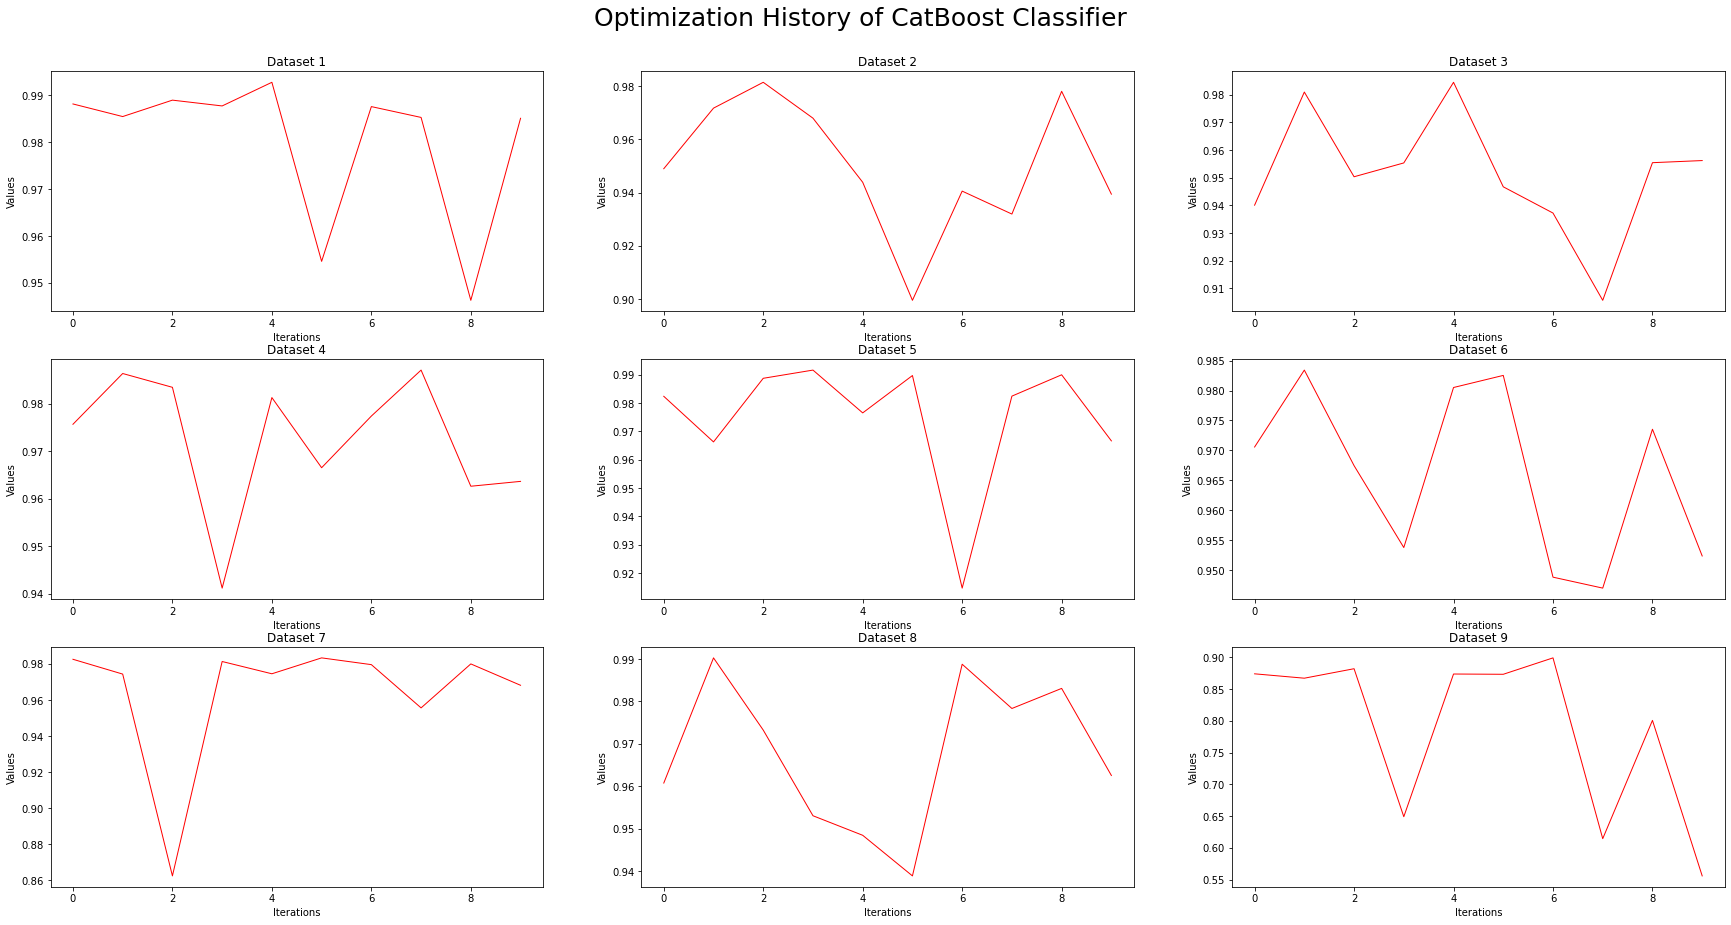

In [52]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'CatBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### For All Resampling Datasets

#### Classifier

In [53]:
table_setC, loss_dictC = runall_nn(train_x = run_train_x, 
                                   train_y = run_train_y, 
                                   test_x = run_test_x, 
                                   test_y = run_test_y, 
                                   n_epoch = 150, 
                                   config = best_paramC,
                                   early_stop = 10,
                                   mode = 'C')

  0%|          | 0/9 [00:00<?, ?it/s]


Starting training Dataset1:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.47342196324597235
Epoch 2: Train Loss = 0.24859649821468022
Epoch 3: Train Loss = 0.14714814836564272
Epoch 4: Train Loss = 0.09172221484391585
Epoch 5: Train Loss = 0.06715704976216606
Recall = 0.9816993464052287, Aging Rate = 0.49956521739130433, Precision = 0.9804177545691906
Validation: Test Loss = 0.06228062213244308
Recall = 0.9870466321243523, Aging Rate = 0.5091264667535854, precision = 0.9756722151088348
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.02777822909147843
Epoch 7: Train Loss = 0.015415500891597374
Epoch 8: Train Loss = 0.010587898742245591
Epoch 9: Train Loss = 0.008579192875843982
Epoch 10: Train Loss = 0.0075402687797727795
Recall = 0.9995642701525055, Aging Rate = 0.4989130434782609, Precision = 0.9995642701525055
Validation: Test Loss = 0.029062224015340966
Recall = 0.9961139896373057, Aging Rate = 0.5052151238591917, precision = 0.9922580645161291
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.005292556835743396
Epoch 12: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6054041627773683
Epoch 2: Train Loss = 0.4495872503928149
Epoch 3: Train Loss = 0.36842132345917983
Epoch 4: Train Loss = 0.3099123464517084
Epoch 5: Train Loss = 0.2643557940250591
Recall = 0.904226618705036, Aging Rate = 0.4978761457634697, Precision = 0.9030085316569376
Validation: Test Loss = 0.25288027343056013
Recall = 0.9445910290237467, Aging Rate = 0.5533199195171026, precision = 0.8678787878787879
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.21116989274339976
Epoch 7: Train Loss = 0.17692844795882234
Epoch 8: Train Loss = 0.1511124612123487
Epoch 9: Train Loss = 0.13165625667821207
Epoch 10: Train Loss = 0.11633885736110199
Recall = 0.9689748201438849, Aging Rate = 0.4945226917057903, Precision = 0.9742314647377939
Validation: Test Loss = 0.13435735259677323
Recall = 0.9564643799472295, Aging Rate = 0.5097250167672703, precision = 0.9539473684210527
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.102736018643053
Epoch 12: Train Loss = 0.09

Epoch 92: Train Loss = 0.02399359368455775
Epoch 93: Train Loss = 0.023472386540996197
Epoch 94: Train Loss = 0.023941001701802717
Epoch 95: Train Loss = 0.025232299281171364
Recall = 0.9991007194244604, Aging Rate = 0.4978761457634697, Precision = 0.9977548271216884
Validation: Test Loss = 0.07334718655477547
Recall = 0.9670184696569921, Aging Rate = 0.500335345405768, precision = 0.982573726541555

Epoch 96: Train Loss = 0.02383449912802461
Epoch 97: Train Loss = 0.024132013307597424
Epoch 98: Train Loss = 0.02339636001143777
Epoch 99: Train Loss = 0.02382269150311185
Epoch 100: Train Loss = 0.023897314069823025
Recall = 0.9991007194244604, Aging Rate = 0.49765258215962443, Precision = 0.9982030548068284
Validation: Test Loss = 0.06935268070231461
Recall = 0.9868073878627969, Aging Rate = 0.5157612340710932, precision = 0.9726918075422627
Model in epoch 100 is saved.

Epoch 101: Train Loss = 0.023818774863814392
Epoch 102: Train Loss = 0.02301892105772302
Epoch 103: Train Loss = 0.02

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.41500631457607834
Epoch 2: Train Loss = 0.21364157054811606
Epoch 3: Train Loss = 0.13550626707813404
Epoch 4: Train Loss = 0.09709273548139585
Epoch 5: Train Loss = 0.07692973709536872
Recall = 0.978965819456617, Aging Rate = 0.5058254561442075, Precision = 0.9708822251195133
Validation: Test Loss = 0.0792562203210439
Recall = 0.9773635153129161, Aging Rate = 0.4990112063282795, precision = 0.9696169088507266
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.0281248107961172
Epoch 7: Train Loss = 0.013464830406022435
Epoch 8: Train Loss = 0.008441352927482017
Epoch 9: Train Loss = 0.006622125839318684
Epoch 10: Train Loss = 0.0055334279772281565
Recall = 0.9995617879053462, Aging Rate = 0.5018685425368212, Precision = 0.9991239597021463
Validation: Test Loss = 0.0723933996577442
Recall = 0.9653794940079894, Aging Rate = 0.4831905075807515, precision = 0.9890859481582538
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.004672019495472155
Epoch 12: Train L

Epoch 97: Train Loss = 0.0030467217830274884
Epoch 98: Train Loss = 0.001224608885470424
Epoch 99: Train Loss = 0.0009606749862431456
Epoch 100: Train Loss = 0.000974131453491141
Recall = 1.0, Aging Rate = 0.5016487140030776, Precision = 0
Validation: Test Loss = 0.061537791517469236
Recall = 0.9707057256990679, Aging Rate = 0.48450889914304546, precision = 0.9918367346938776

Training Finished at epoch 100.
Validation: Test Loss = 3.210561357653127
Recall = 0.5098039215686274, Aging Rate = 0.49984583444675124, precision = 0.0010692108401529794

Starting training Dataset4:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6424403059160811
Epoch 2: Train Loss = 0.5158263871367365
Epoch 3: Train Loss = 0.4111848444053942
Epoch 4: Train Loss = 0.3454433022713175
Epoch 5: Train Loss = 0.30332370814927606
Recall = 0.8834000890075656, Aging Rate = 0.4941847706824665, Precision = 0.8814387211367674
Validation: Test Loss = 0.29075311364666107
Recall = 0.8975979772439949, Aging Rate = 0.5233706385780118, precision = 0.8930817610062893
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2552018231445168
Epoch 7: Train Loss = 0.21967959875845455
Epoch 8: Train Loss = 0.1905436211244982
Epoch 9: Train Loss = 0.16417222142232624
Epoch 10: Train Loss = 0.14232028755593357
Recall = 0.9728526924788607, Aging Rate = 0.4976958525345622, Precision = 0.9638447971781305
Validation: Test Loss = 0.16543367747376828
Recall = 0.9582806573957017, Aging Rate = 0.5273206056616195, precision = 0.9463171036204744
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.12478846868114668
Epoch 12: Train Loss = 0.

Epoch 94: Train Loss = 0.002793115547851843
Epoch 95: Train Loss = 0.0027484622537588634
Recall = 1.0, Aging Rate = 0.4930875576036866, Precision = 0
Validation: Test Loss = 0.07341387365663264
Recall = 0.9835651074589128, Aging Rate = 0.5200789993416721, precision = 0.9848101265822785

Epoch 96: Train Loss = 0.002666302844389475
Epoch 97: Train Loss = 0.0026347622872527057
Epoch 98: Train Loss = 0.0026291789133849703
Epoch 99: Train Loss = 0.0026226571601866
Epoch 100: Train Loss = 0.0025290504833881612
Recall = 1.0, Aging Rate = 0.4930875576036866, Precision = 0
Validation: Test Loss = 0.07318271423853723
Recall = 0.9835651074589128, Aging Rate = 0.5187623436471362, precision = 0.9873096446700508

Epoch 101: Train Loss = 0.0025801094247255903
Epoch 102: Train Loss = 0.0025522242791113595
Epoch 103: Train Loss = 0.0024770316850767603
Epoch 104: Train Loss = 0.0024435134295562994
Epoch 105: Train Loss = 0.0024315724827350003
Recall = 1.0, Aging Rate = 0.4930875576036866, Precision = 0


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6490618869416391
Epoch 2: Train Loss = 0.522179369485811
Epoch 3: Train Loss = 0.41656075289147126
Epoch 4: Train Loss = 0.3516603295362428
Epoch 5: Train Loss = 0.30648864705373746
Recall = 0.8847502191060473, Aging Rate = 0.4946094609460946, Precision = 0.8981316725978647
Validation: Test Loss = 0.29368795849899254
Recall = 0.8482384823848238, Aging Rate = 0.4633663366336634, precision = 0.8917378917378918
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2535826560490989
Epoch 7: Train Loss = 0.2195392509990006
Epoch 8: Train Loss = 0.1911248015491876
Epoch 9: Train Loss = 0.16561783967238447
Epoch 10: Train Loss = 0.1447414085957477
Recall = 0.9671340929009641, Aging Rate = 0.5038503850385039, Precision = 0.9637554585152839
Validation: Test Loss = 0.1573142548303793
Recall = 0.9742547425474255, Aging Rate = 0.500990099009901, precision = 0.9472990777338604
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.12622239761816786
Epoch 12: Train Loss = 0.1138

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.46018107198573677
Epoch 2: Train Loss = 0.24514364711808653
Epoch 3: Train Loss = 0.15701319619539347
Epoch 4: Train Loss = 0.11914917705547683
Epoch 5: Train Loss = 0.10190533583345346
Recall = 0.9756866276452049, Aging Rate = 0.5035335689045937, Precision = 0.9504385964912281
Validation: Test Loss = 0.11146421065393662
Recall = 0.9575289575289575, Aging Rate = 0.5105960264900662, precision = 0.9649805447470817
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.051186585433570526
Epoch 7: Train Loss = 0.03573743429679963
Epoch 8: Train Loss = 0.02680583029340413
Epoch 9: Train Loss = 0.022566098621108508
Epoch 10: Train Loss = 0.016496858893574443
Recall = 0.9977487618190004, Aging Rate = 0.4909452296819788, Precision = 0.99685110211426
Validation: Test Loss = 0.06645157692941608
Recall = 0.9832689832689833, Aging Rate = 0.5172185430463576, precision = 0.9782330345710627
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.01437964461671432
Epoch 12: Train Lo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5844540690693832
Epoch 2: Train Loss = 0.4178075296301527
Epoch 3: Train Loss = 0.3369115448575882
Epoch 4: Train Loss = 0.2809965397718444
Epoch 5: Train Loss = 0.23512276566880286
Recall = 0.8982322025800287, Aging Rate = 0.4633586032621181, Precision = 0.932077342588002
Validation: Test Loss = 0.21923271814982095
Recall = 0.8824404761904762, Aging Rate = 0.4256198347107438, precision = 0.959546925566343
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.17498391197235685
Epoch 7: Train Loss = 0.13996959904706427
Epoch 8: Train Loss = 0.11445164380651998
Epoch 9: Train Loss = 0.0937271015902576
Epoch 10: Train Loss = 0.07674523884447215
Recall = 0.9808886765408504, Aging Rate = 0.4776016540317023, Precision = 0.9874939874939875
Validation: Test Loss = 0.10834858923657867
Recall = 0.9419642857142857, Aging Rate = 0.4462809917355372, precision = 0.9768518518518519
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.0647322418236223
Epoch 12: Train Loss = 0.05

Epoch 97: Train Loss = 0.0020608709623997855
Epoch 98: Train Loss = 0.0020231579751272227
Epoch 99: Train Loss = 0.002093851160235864
Epoch 100: Train Loss = 0.002316451788738948
Recall = 1.0, Aging Rate = 0.4808178267861245, Precision = 0
Validation: Test Loss = 0.037113524578927345
Recall = 0.9806547619047619, Aging Rate = 0.459366391184573, precision = 0.9880059970014993

Epoch 101: Train Loss = 0.001980777762972748
Epoch 102: Train Loss = 0.0018869783074789515
Epoch 103: Train Loss = 0.0017190278788872127
Epoch 104: Train Loss = 0.002026034714574041
Epoch 105: Train Loss = 0.0019485961473398228
Recall = 1.0, Aging Rate = 0.4808178267861245, Precision = 0
Validation: Test Loss = 0.05556480094986729
Recall = 0.9494047619047619, Aging Rate = 0.44008264462809915, precision = 0.9984350547730829

Epoch 106: Train Loss = 0.0021352920670025042
Epoch 107: Train Loss = 0.0018090512138983295
Epoch 108: Train Loss = 0.001987596553151919
Epoch 109: Train Loss = 0.002500961743136041
Epoch 110: T

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5217036461621
Epoch 2: Train Loss = 0.30102000257425143
Epoch 3: Train Loss = 0.2271573248139599
Epoch 4: Train Loss = 0.18589111963907878
Epoch 5: Train Loss = 0.15605478367784567
Recall = 0.9688733011836914, Aging Rate = 0.5210526315789473, Precision = 0.9301346801346801
Validation: Test Loss = 0.15395944306724949
Recall = 0.9631093544137023, Aging Rate = 0.5085526315789474, precision = 0.9456662354463131
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.11700889534856143
Epoch 7: Train Loss = 0.0964584423784624
Epoch 8: Train Loss = 0.07984111005146252
Epoch 9: Train Loss = 0.06697203382326845
Epoch 10: Train Loss = 0.05780466134218793
Recall = 0.9859710653222271, Aging Rate = 0.49912280701754386, Precision = 0.9881370826010545
Validation: Test Loss = 0.09099678605010635
Recall = 0.9749670619235836, Aging Rate = 0.49736842105263157, precision = 0.9788359788359788
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.04924176030775957
Epoch 12: Train Loss = 

Epoch 97: Train Loss = 0.0017545844789741464
Epoch 98: Train Loss = 0.00255611857293141
Epoch 99: Train Loss = 0.00157162042931049
Epoch 100: Train Loss = 0.0016808818831729392
Recall = 1.0, Aging Rate = 0.5002192982456141, Precision = 0
Validation: Test Loss = 0.050794324628077446
Recall = 0.9855072463768116, Aging Rate = 0.4967105263157895, precision = 0.990728476821192

Training Finished at epoch 100.
Validation: Test Loss = 1.646923849210542
Recall = 0.37254901960784315, Aging Rate = 0.35012024913153406, precision = 0.00111548171197088

Starting training Dataset9:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3919365782486765
Epoch 2: Train Loss = 0.2851450413798221
Epoch 3: Train Loss = 0.2665541973410611
Epoch 4: Train Loss = 0.24624180983888666
Epoch 5: Train Loss = 0.22721873523230757
Recall = 0.0136986301369863, Aging Rate = 0.0011961722488038277, Precision = 0
Validation: Test Loss = 0.2644689996419341
Recall = 0.0, Aging Rate = 0.0, precision = 0

Epoch 6: Train Loss = 0.20322502790645738
Epoch 7: Train Loss = 0.18541882532920564
Epoch 8: Train Loss = 0.17176494154443392
Epoch 9: Train Loss = 0.1587574640244388
Epoch 10: Train Loss = 0.14723190743969292
Recall = 0.4748858447488584, Aging Rate = 0.04266347687400319, Precision = 0.9719626168224299
Validation: Test Loss = 0.22384279239120666
Recall = 0.3176470588235294, Aging Rate = 0.03708133971291866, precision = 0.8709677419354839
Model in epoch 10 is saved.

Epoch 11: Train Loss = 0.1375150079742383
Epoch 12: Train Loss = 0.12886934906862188
Epoch 13: Train Loss = 0.11961926027621474
Epoch 14: Train Loss = 0.

Validation: Test Loss = 0.13258221706277445
Recall = 0.8705882352941177, Aging Rate = 0.08971291866028708, precision = 0.9866666666666667

Epoch 96: Train Loss = 0.0028272977862299153
Epoch 97: Train Loss = 0.0027636831854299256
Epoch 98: Train Loss = 0.0027757199182943033
Epoch 99: Train Loss = 0.0026919374579788026
Epoch 100: Train Loss = 0.002640921015001275
Recall = 1.0, Aging Rate = 0.08732057416267942, Precision = 0
Validation: Test Loss = 0.1298630625080834
Recall = 0.8705882352941177, Aging Rate = 0.09090909090909091, precision = 0.9736842105263158

Epoch 101: Train Loss = 0.00260890648623058
Epoch 102: Train Loss = 0.0025985523140387673
Epoch 103: Train Loss = 0.002516027605881472
Epoch 104: Train Loss = 0.0025011592234917093
Epoch 105: Train Loss = 0.00245677635401927
Recall = 1.0, Aging Rate = 0.08732057416267942, Precision = 0
Validation: Test Loss = 0.13562064944057944
Recall = 0.8705882352941177, Aging Rate = 0.08971291866028708, precision = 0.9866666666666667

Epoch 106:

TP       FP    FN       TN  Precision    Recall  Aging Rate  \
dataset1  23.0  17516.0  28.0  31082.0   0.001311  0.450980    0.360521   
dataset2  32.0  25201.0  19.0  23397.0   0.001268  0.627451    0.518675   
dataset3  26.0  24291.0  25.0  24307.0   0.001069  0.509804    0.499846   
dataset4  21.0  14899.0  30.0  33699.0   0.001408  0.411765    0.306687   
dataset5  23.0  16066.0  28.0  32532.0   0.001430  0.450980    0.330716   
dataset6  24.0  23073.0  27.0  25525.0   0.001039  0.470588    0.474768   
dataset7  24.0  21655.0  27.0  26943.0   0.001107  0.470588    0.445621   
dataset8  19.0  17014.0  32.0  31584.0   0.001115  0.372549    0.350120   
dataset9  22.0  19285.0  29.0  29313.0   0.001139  0.431373    0.396863   

          Efficiency    fscore     Score  
dataset1    1.250912  0.002615  0.365896  
dataset2    1.209720  0.002531  0.497484  
dataset3    1.019922  0.002134  0.358422  
dataset4    1.342623  0.002805  0.350524  
dataset5    1.363649  0.002850  0.387936  
dataset6    0.991196  0.002074  0.000000  
dataset7    1.056029  0.002209  0.339189  
dataset8    1.064060  0.002224  0.269977  
dataset9    1.086955  0.002273  0.317363

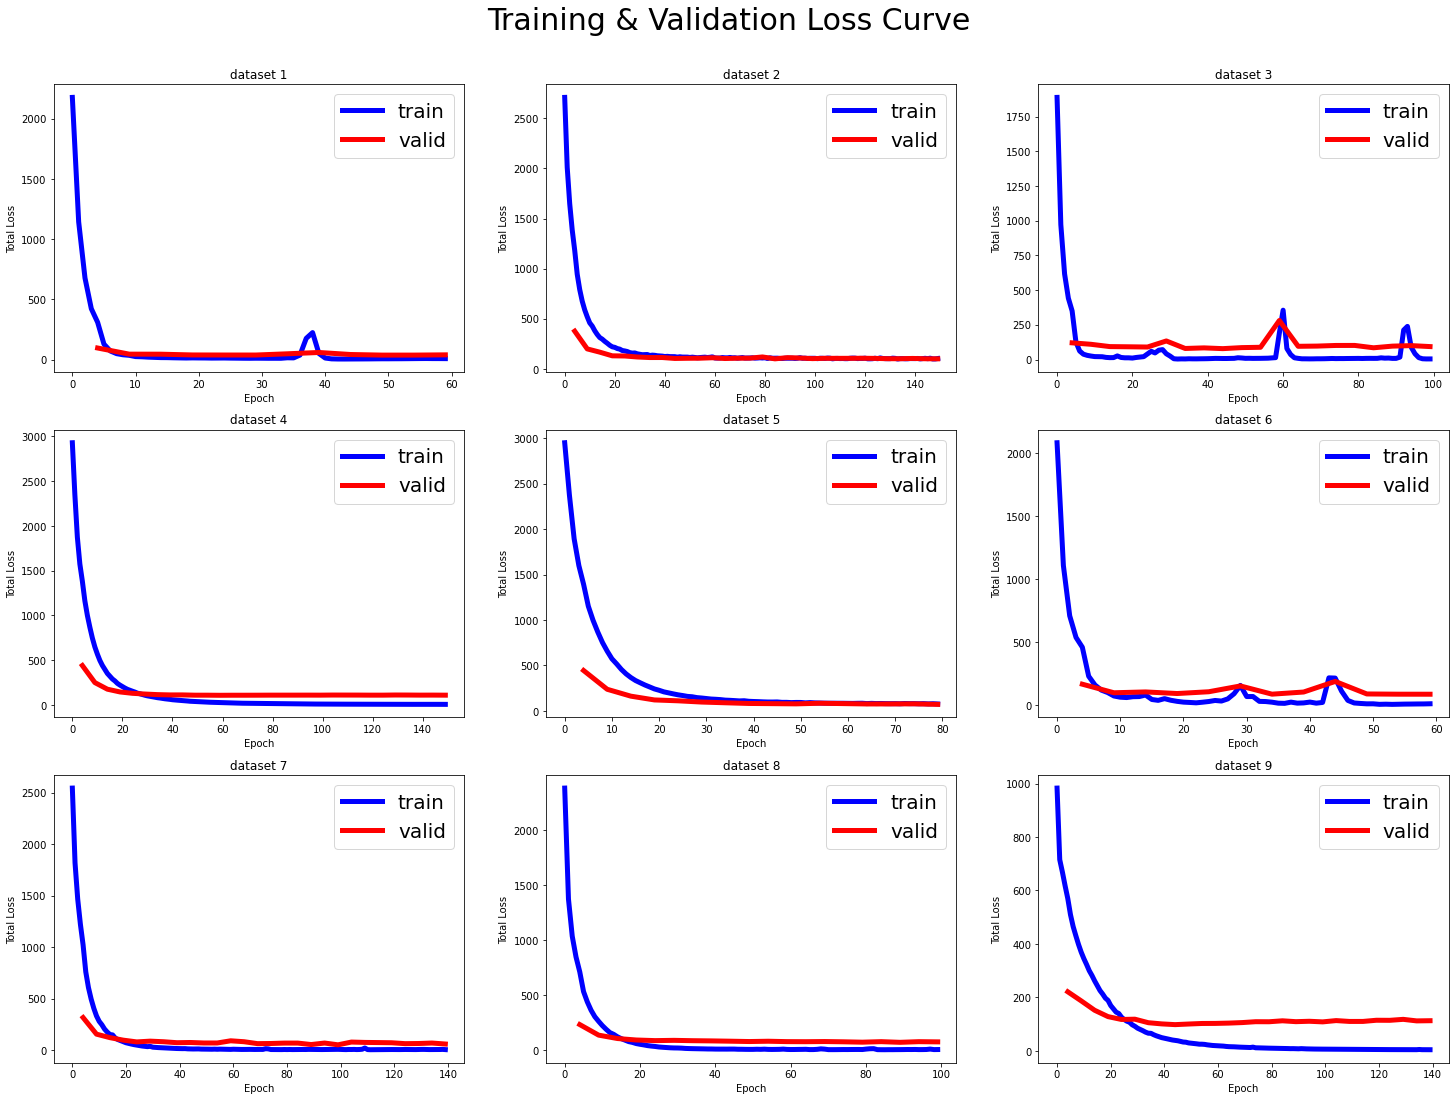

In [54]:
loss_plot(loss_dictC['train'], loss_dictC['valid'], num_row = 3, num_col = 3)
table_setC

#### Regressor (optional)

In [ ]:
runall_modelR = NeuralNetworkR().to(device)
runall_optimizerR = torch.optim.Adam(runall_modelR.parameters(), lr = 0.001, weight_decay = 0.001)
runall_criterionR = nn.MSELoss().to(device)

table_setR, loss_dictR = runall_nn(train_x = run_train_x, 
                                   train_y = run_train_y, 
                                   test_x = run_test_x, 
                                   test_y = run_test_y, 
                                   n_epoch = 150, 
                                   batch_size = 64,
                                   model = runall_modelR,
                                   optimizer = runall_optimizerR, 
                                   criterion = runall_criterionR, 
                                   filename = 'runhist_array_4criteria_NeuralNetworkR', 
                                   train_ratio = 0.75, 
                                   early_stop = 10,
                                   mode = 'R')

In [ ]:
loss_plot(loss_dictR['train'], loss_dictR['valid'], num_row = 4, num_col = 3)
table_setR

### Export

In [55]:
savedate = '20220308'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'NeuralNetwork'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'NeuralNetwork')